# Zach's working code:

In [1]:
## import packages:
import base64, json, uuid, traceback
from typing import Any, Dict, Callable, Optional
import numpy as np
import pandas as pd
import scipy.sparse as sp
import scanpy as sc
import squidpy as sq
import ipywidgets as widgets
from IPython.display import HTML, Javascript, display

/krummellab/data1/zachsten/software/miniconda3/envs/rapids-sc/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/krummellab/data1/zachsten/software/miniconda3/envs/rapids-sc/lib/python3.10/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/krummellab/data1/zachsten/software/miniconda3/envs/rapids-sc/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text fro

In [2]:
adata_sub = sc.read_h5ad('low_load.h5ad')
adata = sc.read_h5ad('../Xenium_analysis/Xenium_dysplasia/data/dysplasia_manuscript_data/072325_dys_analysis_base.h5ad')

In [ ]:
# PART 1: Main body:
# Buttons and main body:
def _b64(s: str) -> str:
    """Base64 encode a string."""
    return base64.b64encode(s.encode("utf-8")).decode("ascii")


def _serialize_result(result: Any) -> Dict:
    """Safely serialize callback results to JSON-compatible format."""
    if isinstance(result, dict):
        return {k: _serialize_result(v) for k, v in result.items()}
    elif isinstance(result, (list, tuple)):
        return [_serialize_result(item) for item in result]
    elif isinstance(result, np.ndarray):
        return result.tolist()
    elif isinstance(result, (np.integer, np.floating)):
        return result.item()
    elif isinstance(result, pd.Series):
        return result.tolist()
    elif isinstance(result, pd.DataFrame):
        return result.to_dict("records")
    elif hasattr(result, "toarray"):
        return result.toarray().tolist()
    elif isinstance(result, (str, int, float, bool, type(None))):
        return result
    else:
        return str(result)


def link_buttons_to_python(
    html_content: str,
    button_callbacks: Dict[str, Callable],
    callback_args: Optional[Dict[str, Any]] = None,
    height: int = 600,
    width: int = 900,
    debug: bool = False,
    max_result_size: int = 10_000_000,
    initial_data: Optional[Dict] = None,
) -> str:
    """
    Link HTML buttons to Python callbacks using widget-based communication.
    Adds a 2-panel layout:
      - Left: iframe UI (buttons/inputs)
      - Right: plot canvas (transparent) that can:
          * render embedding points: spatial/umap/pca (loaded upfront)
          * color points by continuous (GEX/obs numeric) or categorical (obs)
          * clear overlay back to neutral grey
    """
    if callback_args is None:
        callback_args = {}
    if initial_data is None:
        initial_data = {}

    iframe_id = f"iframe_{uuid.uuid4().hex}"
    output = widgets.Output()

    button_ids = list(button_callbacks.keys())
    button_ids_js = json.dumps(button_ids)
    initial_data_js = json.dumps(initial_data)

    # ----------------------------
    # Create data bridge widgets (one per button)
    # ----------------------------
    data_bridges: Dict[str, widgets.Text] = {}
    for bid in button_ids:
        bridge_name = f"_data_{iframe_id}_{bid}"
        bridge = widgets.Text(
            value="",
            description=bridge_name,
            placeholder=f"Data bridge for {bid}",
            layout=widgets.Layout(width="1px", height="1px", visibility="hidden"),
        )
        bridge.add_class(f"data-bridge-{iframe_id}")
        bridge.add_class(f"data-bridge-{bid}")
        data_bridges[bid] = bridge
        display(bridge)

    # ----------------------------
    # JS injected inside iframe:
    # - captures button clicks + input fields
    # - posts to parent
    # - receives python responses and re-dispatches as CustomEvent('pythonResponse')
    # ----------------------------
    communication_script = f"""
<script>
(function() {{
  const iframeId = {json.dumps(iframe_id)};
  const buttonIds = {button_ids_js};
  const initialData = {initial_data_js};
  let pendingRequest = null;

  function log(...args) {{ {"console.log('[iframe]', ...args);" if debug else ""} }}

  window.INITIAL_DATA = initialData;
  log("Initial data loaded:", initialData);

  buttonIds.forEach((bid) => {{
    const button = document.getElementById(bid);
    if (!button) {{
      log("Button not found:", bid);
      return;
    }}

    button.addEventListener('click', () => {{
      if (pendingRequest === bid) {{
        log("Request already pending for", bid);
        return;
      }}

      pendingRequest = bid;
      log("Button clicked:", bid);
      button.disabled = true;

      const data = {{}};

      // data-* attributes on the button
      for (let attr of button.attributes) {{
        if (attr.name.startsWith('data-')) {{
          data[attr.name.substring(5)] = attr.value;
        }}
      }}

      // inputs associated to this button via data-for="buttonId"
      const inputs = document.querySelectorAll('[data-for="' + bid + '"]');
      inputs.forEach(input => {{
        const key = input.getAttribute('data-key') || input.id || input.name;
        if (key) {{
          data[key] = input.value;
        }}
      }});

      log("Sending data:", data);

      window.parent.postMessage({{
        type: 'button_click',
        iframeId: iframeId,
        buttonId: bid,
        data: data,
        timestamp: Date.now()
      }}, '*');
    }});
  }});

  window.addEventListener('message', (event) => {{
    if (event.data && event.data.type === 'python_response') {{
      log("Received Python response:", event.data.data);

      if (pendingRequest) {{
        const button = document.getElementById(pendingRequest);
        if (button) button.disabled = false;
        pendingRequest = null;
      }}

      const customEvent = new CustomEvent('pythonResponse', {{
        detail: event.data.data
      }});
      window.dispatchEvent(customEvent);
    }}
  }});
}})();
</script>
"""

    if "</body>" in html_content.lower():
        idx = html_content.lower().rfind("</body>")
        full_html = html_content[:idx] + communication_script + html_content[idx:]
    else:
        full_html = html_content + communication_script

    payload_b64 = _b64(full_html)

    # ----------------------------
    # Precompute embedding points + sample indices (aligned everywhere)
    # ----------------------------
    adata = callback_args.get("adata", None)

    # pick base embedding to define sample_idx
    spatial = None
    if adata is not None:
        if "spatial" in adata.obsm:
            spatial = np.asarray(adata.obsm["spatial"])
        elif "X_spatial" in adata.obsm:
            spatial = np.asarray(adata.obsm["X_spatial"])

    if spatial is None or spatial.ndim != 2 or spatial.shape[1] < 2:
        sample_idx = np.array([], dtype=int)
        spatial_points = []
    else:
        n = spatial.shape[0]
        max_points = 1_00_000_000  # <-- THIS controls how many cells/points are loaded
        if n > max_points:
            sample_idx = np.random.choice(n, size=max_points, replace=False)
        else:
            sample_idx = np.arange(n, dtype=int)
        spatial_points = spatial[sample_idx, :2].tolist()

    # Optional embeddings (same sample_idx; empty if missing)
    umap_points: list = []
    pca_points: list = []
    if adata is not None and sample_idx.size > 0:
        if "X_umap" in adata.obsm:
            um = np.asarray(adata.obsm["X_umap"])
            if um.ndim == 2 and um.shape[1] >= 2 and um.shape[0] == (spatial.shape[0] if spatial is not None else um.shape[0]):
                umap_points = um[sample_idx, :2].tolist()

        if "X_pca" in adata.obsm:
            pc = np.asarray(adata.obsm["X_pca"])
            if pc.ndim == 2 and pc.shape[1] >= 2 and pc.shape[0] == (spatial.shape[0] if spatial is not None else pc.shape[0]):
                pca_points = pc[sample_idx, :2].tolist()

    embeds_js = json.dumps({
        "spatial": spatial_points,
        "umap": umap_points,
        "pca": pca_points,
    })

    # IMPORTANT: pass sample_idx into callbacks so obs/gene are subset to plotted points
    callback_args = dict(callback_args)
    callback_args["__sample_idx"] = sample_idx.tolist()  # JSON-friendly

    # ----------------------------
    # Parent container: 2 panels + plot canvas (transparent background)
    # ----------------------------
    container_html = f"""
<div style="display:flex; gap:10px; width:100%; height:{int(height)}px;">
  <!-- Left panel: controls iframe -->
  <div id="left_{iframe_id}" style="width: 420px; height:100%; flex: 0 0 420px;">
    <iframe
      id="{iframe_id}"
      style="width:100%; height:100%; border:1px solid #ccc; border-radius:6px; background:white;"
    ></iframe>
  </div>

  <!-- Right panel: plot area -->
  <div id="plot_panel_{iframe_id}"
       tabindex="0"
       style="width:{int(width)}px; height:100%; flex: 0 0 {int(width)}px; border:1px solid rgba(0,0,0,0.15); border-radius:6px;
              background: transparent; position: relative; overflow:hidden; outline:none;">
    <canvas id="plot_canvas_{iframe_id}"
            style="width:100%; height:100%; display:block; background: transparent;"></canvas>

    <!-- Hidden label (needed for state tracking but not displayed) -->
    <div id="plot_label_{iframe_id}" style="display:none;">Embedding: spatial</div>

    <!-- Camera button in top left -->
    <button id="camera_btn_{iframe_id}"
            style="position:absolute; left:10px; top:10px;
                   width:36px; height:36px;
                   border-radius:8px;
                   border:1px solid rgba(0,0,0,0.12);
                   background: rgba(255,255,255,0.9);
                   cursor:pointer;
                   display:flex;
                   align-items:center;
                   justify-content:center;
                   transition: all 0.15s ease;
                   box-shadow: 0 2px 4px rgba(0,0,0,0.08);"
            title="Download plot as PNG">
      <svg width="20" height="20" viewBox="0 0 24 24" fill="none" stroke="currentColor" stroke-width="2" stroke-linecap="round" stroke-linejoin="round">
        <path d="M23 19a2 2 0 0 1-2 2H3a2 2 0 0 1-2-2V8a2 2 0 0 1 2-2h4l2-3h6l2 3h4a2 2 0 0 1 2 2z"></path>
        <circle cx="12" cy="13" r="4"></circle>
      </svg>
    </button>
    
    <!-- Minimap in bottom left -->
    <canvas id="minimap_{iframe_id}"
            style="position:absolute; bottom:10px; left:10px;
                   width:120px; height:120px;
                   background:#000;
                   border:2px solid rgba(255,255,255,0.3);
                   border-radius:8px;
                   display:block;"></canvas>
  </div>
</div>

<style>
  #camera_btn_{iframe_id}:hover {{
    background: rgba(141,236,245,0.2);
    border-color: rgba(141,236,245,0.6);
    box-shadow: 0 4px 8px rgba(0,0,0,0.12);
  }}
</style>

<script>
(function() {{
  const iframeId = {json.dumps(iframe_id)};

  const iframe = document.getElementById({json.dumps(iframe_id)});
  const b64 = {json.dumps(payload_b64)};
  const html = decodeURIComponent(escape(atob(b64)));

  // ---- write iframe content ----
  const doc = iframe.contentWindow.document;
  doc.open();
  doc.write(html);
  doc.close();

  // ---- request queue for button bridge ----
  window["_requests_" + iframeId] = [];

  function log(...args) {{ {"console.log('[parent]', ...args);" if debug else ""} }}

  // Guard against duplicate listener on reruns for this iframe_id
  const MSG_GUARD = "_msg_listener_installed_" + iframeId;
  if (!window[MSG_GUARD]) {{
    window[MSG_GUARD] = true;
    window.addEventListener('message', (event) => {{
      if (!event.data) return;
      if (event.data.iframeId === iframeId && event.data.type === "button_click") {{
        log("Queued button click:", event.data.buttonId, "with data:", event.data.data);
        window["_requests_" + iframeId].push(event.data);
      }}
      // Listen to ui_state updates from iframe (for legend toggles, opacity, etc)
      if (event.data.type === "ui_state") {{
        log("Received ui_state update from iframe");
        const s = window["_plotState_" + iframeId];
        
        // Update obs layer
        if (s && event.data.obs) {{
          if (event.data.obs.values) {{
            // Obs data is active
            s.obs.mode = event.data.obs.mode;
            s.obs.values = event.data.obs.values;
            s.obs.colors = event.data.obs.colors;
            s.obs.categories = event.data.obs.categories;
            s.obs.enabled = event.data.obs.enabled;
            s.obs.opacity = event.data.obs.opacity || 1.0;
          }} else {{
            // No obs data - clear obs layer
            s.obs.mode = null;
            s.obs.values = null;
            s.obs.colors = null;
            s.obs.categories = null;
            s.obs.enabled = null;
          }}
        }}
        
        // Update GEX layer
        if (s && event.data.gex) {{
          if (event.data.gex.active && event.data.gex.values) {{
            // GEX is active
            s.gex.values = event.data.gex.values;
            s.gex.opacity = event.data.gex.opacity || 1.0;
          }} else {{
            // No GEX - clear GEX layer
            s.gex.values = null;
          }}
        }}
        
        // Update selection mask and outline
        if (s && event.data.selection) {{
          s.selectionIndices = event.data.selection.indices || null;
          s.selectionPath = event.data.selection.path || null;
          s.selectionTool = event.data.selection.tool || null;
        }}
        
        // Update point size
        if (s && typeof event.data.pointSize === 'number') {{
          s.pointSize = event.data.pointSize;
        }}
        
        // Update label
        if (s) {{
          const hasObs = s.obs.values != null;
          const hasGex = s.gex.values != null;
          
          if (hasGex && hasObs) {{
            s.label = "obs: " + (event.data.obs.column || "") + " + GEX: " + (event.data.gex.active || "");
          }} else if (hasGex) {{
            s.label = "GEX: " + (event.data.gex.active || "");
          }} else if (hasObs) {{
            s.label = "obs: " + (event.data.obs.column || "");
          }} else {{
            s.label = "Embedding: " + currentEmbedding;
          }}
          setLabel(s.label);
        }}
        
        draw();
      }}
      
      // Listen for selection_tool messages from iframe
      if (event.data.type === "selection_tool") {{
        const tool = event.data.tool;
        window["_selectionTool_" + iframeId] = tool;
        window["_selectionPath_" + iframeId] = [];
        window["_isDrawing_" + iframeId] = false;
        log("Selection tool changed to:", tool);
        draw(); // Redraw to clear any previous selection outline
      }}
      
      // Listen for save_obs_column message from iframe
      if (event.data.type === "save_obs_column" && event.data.iframeId === iframeId) {{
        log("Saving obs column:", event.data.columnName);
        // Queue this as a special request to be handled by Python
        window["_requests_" + iframeId].push({{
          buttonId: "__save_obs_column__",
          data: {{
            columnName: event.data.columnName,
            columnData: event.data.columnData
          }},
          type: "button_click",
          iframeId: iframeId
        }});
      }}
    }});
  }}

  window["sendToIframe_" + iframeId] = function(data) {{
    const iframe2 = document.getElementById(iframeId);
    if (iframe2 && iframe2.contentWindow) {{
      iframe2.contentWindow.postMessage({{
        type: "python_response",
        data: data
      }}, "*");
    }}
  }};

  // ----------------------------
  // Embeddings (preloaded)
  // ----------------------------
  const EMBEDS = {embeds_js};
  let currentEmbedding = "spatial";
  let points = (EMBEDS[currentEmbedding] || []);

  // ----------------------------
  // Navigation state (zoom, pan, rotation)
  // ----------------------------
  let zoom = 1.0;
  let panX = 0;
  let panY = 0;
  let rotation = 0;
  let isDragging = false;
  let lastMouseX = 0;
  let lastMouseY = 0;
  let rotationMode = false;
  let lastRotationKeyPress = 0;
  
  // ----------------------------
  // Animation state
  // ----------------------------
  let isAnimating = false;
  let animationStartTime = 0;
  let animationDuration = 1000; // 1 second for embedding transitions
  let startPoints = null;
  let endPoints = null;
  
  // Color animation
  let colorAnimating = false;
  let colorAnimStart = 0;
  const COLOR_ANIM_MS = 500; // 0.5 seconds
  let oldColors = null;
  let newColors = null;
  
  // Helper function for smooth interpolation
  function lerp(a, b, t) {{
    return a + (b - a) * t;
  }}
  
  // Easing function (ease-in-out)
  function easeInOutQuad(t) {{
    return t < 0.5 ? 2 * t * t : 1 - Math.pow(-2 * t + 2, 2) / 2;
  }}

  // ----------------------------
  // Plot state (supports layered rendering: obs + GEX overlay)
  // ----------------------------
  window["_plotState_" + iframeId] = {{
    // Obs layer (base)
    obs: {{
      mode: null,           // "categorical" | "continuous" | null
      values: null,         // per-point values
      colors: null,         // categorical palette
      categories: null,
      enabled: null,        // boolean array for categorical toggles
      opacity: 1.0
    }},
    // GEX layer (overlay)
    gex: {{
      values: null,         // per-point continuous values
      opacity: 1.0
    }},
    label: "Embedding: spatial",
    pointSize: 1.1,
    selectionIndices: null  // array of selected point indices (acts as mask)
  }};

  function setLabel(text) {{
    const lab = document.getElementById("plot_label_" + iframeId);
    if (lab) lab.textContent = text;
  }}

  // Camera button - download canvas as PNG with custom filename
  const cameraBtn = document.getElementById("camera_btn_" + iframeId);
  if (cameraBtn) {{
    cameraBtn.addEventListener("click", () => {{
      // Prompt for filename
      const defaultName = "spatial_plot_" + new Date().toISOString().slice(0,10);
      const filename = prompt("Enter filename for PNG (without extension):", defaultName);
      
      // If user cancelled or entered empty string, don't download
      if (!filename || filename.trim() === "") {{
        return;
      }}
      
      // Download with user's filename
      const link = document.createElement("a");
      link.download = filename.trim() + ".png";
      link.href = canvas.toDataURL("image/png");
      link.click();
    }});
  }}

  // ----------------------------
  // Plot updater: receives Python callback payloads
  // ----------------------------
  window["updatePlot_" + iframeId] = function(payload) {{
    if (!payload || !payload.type) return;

    // Switch embedding (UMAP/PCA/Spatial) - PRESERVE COLOR STATE WITH ANIMATION
    if (payload.type === "set_embedding") {{
      const name = (payload.embedding || "spatial");
      const newPoints = (EMBEDS[name] || []);
      
      // Don't animate if already on this embedding
      if (currentEmbedding === name) return;
      
      // Start animation
      startPoints = points.slice(); // Copy current points
      endPoints = newPoints;
      currentEmbedding = name;
      isAnimating = true;
      animationStartTime = Date.now();
      
      // Reset navigation on embedding switch
      zoom = 1.0;
      panX = 0;
      panY = 0;
      rotation = 0;
      
      function animateEmbedding() {{
        const elapsed = Date.now() - animationStartTime;
        const progress = Math.min(elapsed / animationDuration, 1);
        const eased = easeInOutQuad(progress);
        
        // Interpolate all points
        points = [];
        for (let i = 0; i < startPoints.length; i++) {{
          const [sx, sy] = startPoints[i];
          const [ex, ey] = endPoints[i];
          points.push([
            lerp(sx, ex, eased),
            lerp(sy, ey, eased)
          ]);
        }}
        
        draw();
        
        if (progress < 1) {{
          requestAnimationFrame(animateEmbedding);
        }} else {{
          points = endPoints;
          isAnimating = false;
          draw();
        }}
      }}
      
      animateEmbedding();

      // Update label
      const s = window["_plotState_" + iframeId];
      if (s) {{
        if (s.mode === "none") {{
          s.label = "Embedding: " + name;
        }}
      }}
      setLabel(s ? s.label : "Embedding: " + name);
      return;
    }}

    // Clear overlay (back to neutral grey)
    if (payload.type === "clear_plot") {{
      const s = window["_plotState_" + iframeId];
      if (s) {{
        // Clear obs layer
        s.obs.mode = null;
        s.obs.values = null;
        s.obs.colors = null;
        s.obs.categories = null;
        s.obs.enabled = null;
        // Clear GEX layer
        s.gex.values = null;
        s.label = "Embedding: " + currentEmbedding;
      }}
      setLabel("Embedding: " + currentEmbedding);
      draw();
      return;
    }}

    // GEX continuous - store in GEX layer
    if (payload.type === "gex_values") {{
      const s = window["_plotState_" + iframeId];
      if (s) {{
        s.gex.values = payload.values || null;
        s.label = "GEX: " + (payload.gene || "");
      }}
      setLabel("GEX: " + (payload.gene || ""));
      draw();
      return;
    }}

    // obs values (categorical or continuous) - store in obs layer
    if (payload.type === "obs_values") {{
      const s = window["_plotState_" + iframeId];
      if (s) {{
        if (payload.mode === "categorical") {{
          s.obs.mode = "categorical";
          s.obs.values = payload.values || null;
          s.obs.colors = payload.colors || null;
          s.obs.categories = payload.categories || null;
          // Initialize enabled array - all true by default
          if (s.obs.categories) {{
            s.obs.enabled = s.obs.categories.map(() => true);
          }}
        }} else {{
          s.obs.mode = "continuous";
          s.obs.values = payload.values || null;
          s.obs.colors = null;
          s.obs.categories = null;
          s.obs.enabled = null;
        }}
        s.label = "obs: " + (payload.column || "");
      }}
      setLabel("obs: " + (payload.column || ""));
      draw();
      return;
    }}
  }};

  // ----------------------------
  // Plotting
  // ----------------------------
  const canvas = document.getElementById("plot_canvas_" + iframeId);
  const panel = document.getElementById("plot_panel_" + iframeId);
  const ctx = canvas.getContext("2d");
  
  const minimap = document.getElementById("minimap_" + iframeId);
  const minimapCtx = minimap.getContext("2d");

  function clamp01(x) {{ return Math.max(0, Math.min(1, x)); }}

  // Minimal viridis approximation via stops
  const VIRIDIS = [
    [0.0,  [68, 1, 84]],
    [0.13, [71, 44, 122]],
    [0.25, [59, 81, 139]],
    [0.38, [44, 113, 142]],
    [0.50, [33, 144, 141]],
    [0.63, [39, 173, 129]],
    [0.75, [92, 200, 99]],
    [0.88, [170, 220, 50]],
    [1.0,  [253, 231, 37]]
  ];

  function viridis(t) {{
    t = clamp01(t);
    for (let i = 0; i < VIRIDIS.length - 1; i++) {{
      const a = VIRIDIS[i], b = VIRIDIS[i + 1];
      if (t >= a[0] && t <= b[0]) {{
        const u = (t - a[0]) / (b[0] - a[0] || 1);
        const r = Math.round(a[1][0] + u*(b[1][0]-a[1][0]));
        const g = Math.round(a[1][1] + u*(b[1][1]-a[1][1]));
        const bl = Math.round(a[1][2] + u*(b[1][2]-a[1][2]));
        return `rgb(${{r}},${{g}},${{bl}})`;
      }}
    }}
    const c = VIRIDIS[VIRIDIS.length - 1][1];
    return `rgb(${{c[0]}},${{c[1]}},${{c[2]}})`;
  }}

  function fallbackCatColor(k) {{
    const h = (k * 137.508) % 360;
    return `hsl(${{h}}, 55%, 55%)`;
  }}

  function resizeCanvas() {{
    const rect = panel.getBoundingClientRect();
    canvas.width = Math.max(1, Math.floor(rect.width * window.devicePixelRatio));
    canvas.height = Math.max(1, Math.floor(rect.height * window.devicePixelRatio));
    ctx.setTransform(1, 0, 0, 1, 0, 0);
    ctx.scale(window.devicePixelRatio, window.devicePixelRatio);
    draw();
  }}

  function draw() {{
    const rect = panel.getBoundingClientRect();
    const W = rect.width;
    const H = rect.height;

    ctx.clearRect(0, 0, W, H);

    if (!points || points.length === 0) {{
      ctx.font = "13px ui-monospace, Menlo, Monaco, monospace";
      ctx.fillStyle = "rgba(0,0,0,0.6)";
      ctx.fillText("Embedding not available (missing in adata.obsm).", 12, 40);
      return;
    }}

    // bounds
    let minX = Infinity, maxX = -Infinity, minY = Infinity, maxY = -Infinity;
    for (let i = 0; i < points.length; i++) {{
      const x = points[i][0], y = points[i][1];
      if (x < minX) minX = x;
      if (x > maxX) maxX = x;
      if (y < minY) minY = y;
      if (y > maxY) maxY = y;
    }}

    const pad = 12;
    const spanX = (maxX - minX) || 1;
    const spanY = (maxY - minY) || 1;
    const baseScale = Math.min((W - 2*pad) / spanX, (H - 2*pad) / spanY);
    
    // Apply zoom
    const scale = baseScale * zoom;

    const usedW = spanX * scale;
    const usedH = spanY * scale;
    const offX = (W - usedW) / 2 + panX;
    const offY = (H - usedH) / 2 + panY;
    
    // Apply rotation transform
    ctx.save();
    ctx.translate(W / 2, H / 2);
    ctx.rotate(rotation);
    ctx.translate(-W / 2, -H / 2);

    const state = window["_plotState_" + iframeId] || {{ obs: {{}}, gex: {{}} }};

    // Calculate GEX continuous range if needed
    let gexMin = 0, gexMax = 1;
    if (state.gex && state.gex.values && state.gex.values.length === points.length) {{
      gexMin = Infinity; gexMax = -Infinity;
      for (let i = 0; i < state.gex.values.length; i++) {{
        const v = state.gex.values[i];
        if (v == null || Number.isNaN(v)) continue;
        if (v < gexMin) gexMin = v;
        if (v > gexMax) gexMax = v;
      }}
      if (!isFinite(gexMin) || !isFinite(gexMax) || gexMin === gexMax) {{ gexMin = 0; gexMax = 1; }}
    }}

    // Calculate obs continuous range if needed
    let obsMin = 0, obsMax = 1;
    if (state.obs && state.obs.mode === "continuous" && state.obs.values && state.obs.values.length === points.length) {{
      obsMin = Infinity; obsMax = -Infinity;
      for (let i = 0; i < state.obs.values.length; i++) {{
        const v = state.obs.values[i];
        if (v == null || Number.isNaN(v)) continue;
        if (v < obsMin) obsMin = v;
        if (v > obsMax) obsMax = v;
      }}
      if (!isFinite(obsMin) || !isFinite(obsMax) || obsMin === obsMax) {{ obsMin = 0; obsMax = 1; }}
    }}

    const r = state.pointSize || 1.1;

    // Layered rendering with categorical masking
    for (let i = 0; i < points.length; i++) {{
      const x = points[i][0];
      const y = points[i][1];
      const px = offX + (x - minX) * scale;
      const py = offY + (y - minY) * scale;

      // MASKING: Check if this point passes categorical mask
      let passesMask = true;
      
      // Categorical mask (from obs toggles)
      if (state.obs && state.obs.mode === "categorical" && state.obs.values && state.obs.values.length === points.length) {{
        const k = state.obs.values[i] | 0;
        const isEnabled = !state.obs.enabled || state.obs.enabled[k] !== false;
        passesMask = passesMask && isEnabled;
      }}
      
      // If point doesn't pass categorical mask, skip it entirely
      if (!passesMask) {{
        continue;
      }}
      
      // SELECTION OPACITY: Check if this point is in active selection
      let selectionOpacity = 1.0;
      if (state.selectionIndices && state.selectionIndices.length > 0) {{
        // If there's an active selection, selected points = 1.0, others = 0.2
        selectionOpacity = state.selectionIndices.includes(i) ? 1.0 : 0.2;
      }}
      
      // Determine what to draw for this point
      let hasObsColor = false;
      let hasGexColor = false;
      
      // Check obs layer
      if (state.obs && state.obs.mode === "categorical" && state.obs.values && state.obs.values.length === points.length) {{
        hasObsColor = true;
      }} else if (state.obs && state.obs.mode === "continuous" && state.obs.values && state.obs.values.length === points.length) {{
        hasObsColor = true;
      }}
      
      // Check GEX layer
      if (state.gex && state.gex.values && state.gex.values.length === points.length) {{
        hasGexColor = true;
      }}
      
      // Skip point entirely if no active layers (no obs, no GEX)
      if (!hasObsColor && !hasGexColor) {{
        continue;
      }}

      // Draw obs base layer first (if exists)
      if (hasObsColor) {{
        if (state.obs.mode === "categorical") {{
          const k = state.obs.values[i] | 0;
          const pal = state.obs.colors;
          ctx.globalAlpha = (state.obs.opacity || 1.0) * selectionOpacity;
          ctx.fillStyle = (pal && pal[k]) ? pal[k] : fallbackCatColor(k);
        }} else if (state.obs.mode === "continuous") {{
          const v = state.obs.values[i];
          const t = (v - obsMin) / (obsMax - obsMin || 1);
          ctx.globalAlpha = (state.obs.opacity || 1.0) * selectionOpacity;
          ctx.fillStyle = viridis(t);
        }}
        
        ctx.beginPath();
        ctx.arc(px, py, r, 0, Math.PI * 2);
        ctx.fill();
      }}

      // Draw GEX overlay on top (if exists)
      if (hasGexColor) {{
        const v = state.gex.values[i];
        const t = (v - gexMin) / (gexMax - gexMin || 1);
        ctx.globalAlpha = (state.gex.opacity || 1.0) * selectionOpacity;
        ctx.fillStyle = viridis(t);
        
        ctx.beginPath();
        ctx.arc(px, py, r, 0, Math.PI * 2);
        ctx.fill();
      }}
    }}

    ctx.globalAlpha = 1.0;
    
    // Restore rotation transform
    ctx.restore();
    
    // NOTE: We don't draw stored selection outlines because they're stored in
    // screen coordinates and become incorrect after zoom/pan/rotate.
    // The opacity dimming (selected=1.0, unselected=0.2) is sufficient visual feedback.
    
    // Draw minimap
    drawMinimap();
  }}
  
  // ----------------------------
  // Minimap drawing
  // ----------------------------
  function drawMinimap() {{
    const mmW = minimap.width;
    const mmH = minimap.height;
    
    minimapCtx.fillStyle = "#000";
    minimapCtx.fillRect(0, 0, mmW, mmH);
    
    // Calculate bounds for current points
    if (!points || points.length === 0) return;
    
    let minX = Infinity, maxX = -Infinity, minY = Infinity, maxY = -Infinity;
    for (let i = 0; i < points.length; i++) {{
      const x = points[i][0], y = points[i][1];
      if (x < minX) minX = x;
      if (x > maxX) maxX = x;
      if (y < minY) minY = y;
      if (y > maxY) maxY = y;
    }}
    
    const pad = 5;
    const spanX = (maxX - minX) || 1;
    const spanY = (maxY - minY) || 1;
    const scale = Math.min((mmW - 2*pad) / spanX, (mmH - 2*pad) / spanY);
    const usedW = spanX * scale;
    const usedH = spanY * scale;
    const offX = (mmW - usedW) / 2;
    const offY = (mmH - usedH) / 2;
    
    // Draw all points as small dots
    minimapCtx.fillStyle = "rgba(100, 100, 100, 0.5)";
    for (let i = 0; i < points.length; i++) {{
      const [x, y] = points[i];
      const px = offX + (x - minX) * scale;
      const py = offY + (y - minY) * scale;
      minimapCtx.fillRect(px - 0.5, py - 0.5, 1, 1);
    }}
    
    // Draw viewport rectangle
    const rect = panel.getBoundingClientRect();
    const W = rect.width;
    const H = rect.height;
    const baseScale = Math.min((W - 24) / spanX, (H - 24) / spanY);
    const viewScale = baseScale * zoom;
    const viewW = spanX * viewScale;
    const viewH = spanY * viewScale;
    const viewOffX = (W - viewW) / 2 + panX;
    const viewOffY = (H - viewH) / 2 + panY;
    
    // Map viewport to minimap coordinates
    const vpMinX = -viewOffX / viewScale * scale + offX;
    const vpMinY = -viewOffY / viewScale * scale + offY;
    const vpMaxX = (W - viewOffX) / viewScale * scale + offX;
    const vpMaxY = (H - viewOffY) / viewScale * scale + offY;
    
    minimapCtx.strokeStyle = "rgba(141, 236, 245, 0.8)";
    minimapCtx.lineWidth = 1;
    minimapCtx.strokeRect(vpMinX, vpMinY, vpMaxX - vpMinX, vpMaxY - vpMinY);
  }}

  resizeCanvas();
  window.addEventListener("resize", resizeCanvas);

  // ----------------------------
  // Pan/Zoom/Rotation controls
  // ----------------------------
  
  // Wheel zoom (slowed to 0.5x)
  canvas.addEventListener("wheel", (e) => {{
    e.preventDefault();
    const rect = canvas.getBoundingClientRect();
    const mouseX = e.clientX - rect.left;
    const mouseY = e.clientY - rect.top;
    
    const delta = e.deltaY * 0.0005;  // Was 0.001, now 0.0005 for slower zoom
    const zoomFactor = delta > 0 ? 0.975 : 1.025;  // Reduced from 0.95/1.05
    const oldZoom = zoom;
    zoom *= zoomFactor;
    zoom = Math.max(0.1, Math.min(zoom, 20));
    
    const zoomChange = zoom / oldZoom;
    panX = mouseX - (mouseX - panX) * zoomChange;
    panY = mouseY - (mouseY - panY) * zoomChange;
    
    draw();
  }});
  
  // Double-click to reset view
  canvas.addEventListener("dblclick", () => {{
    zoom = 1.0;
    panX = 0;
    panY = 0;
    rotation = 0;
    rotationMode = false;
    draw();
  }});
  
  // Auto-focus panel on mouse enter to capture keyboard events
  panel.addEventListener("mouseenter", () => {{
    panel.focus();
  }});
  
  // Keyboard controls - only work when panel has focus
  panel.addEventListener("keydown", (e) => {{
    // Arrow keys for size (when not in input)
    if (e.target.tagName === 'INPUT' && e.target.type === 'text') return;
    
    if (e.key === "ArrowLeft" || e.key === "ArrowRight") {{
      e.preventDefault();
      e.stopPropagation();
      const state = window["_plotState_" + iframeId];
      if (!state) return;
      
      const step = 0.1;
      const min = 0.5;
      const max = 8;
      
      if (e.key === "ArrowLeft") {{
        state.pointSize = Math.max(min, state.pointSize - step);
      }} else {{
        state.pointSize = Math.min(max, state.pointSize + step);
      }}
      
      draw();
    }}
    
    // R key for rotation
    if (e.key === "r" || e.key === "R") {{
      e.preventDefault();
      e.stopPropagation();
      const now = Date.now();
      if (now - lastRotationKeyPress < 500) {{
        // Double-tap: reset rotation
        rotation = 0;
        rotationMode = false;
      }} else {{
        // Single tap: toggle rotation mode
        rotationMode = !rotationMode;
        canvas.style.cursor = rotationMode ? "crosshair" : "default";
      }}
      lastRotationKeyPress = now;
      draw();
    }}
  }});
  
  // Rotation with mouse when in rotation mode
  canvas.addEventListener("mousemove", (e) => {{
    if (rotationMode && !isDragging && !window["_isDrawing_" + iframeId]) {{
      const rect = canvas.getBoundingClientRect();
      const centerX = rect.width / 2;
      const centerY = rect.height / 2;
      const angle = Math.atan2(e.clientY - rect.top - centerY, e.clientX - rect.left - centerX);
      rotation = angle;
      draw();
      return;
    }}
  }});

  // ----------------------------
  // Selection drawing AND panning
  // ----------------------------
  canvas.addEventListener("mousedown", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    const rect = canvas.getBoundingClientRect();
    const x = e.clientX - rect.left;
    const y = e.clientY - rect.top;
    
    // Exit rotation mode on click (locks rotation in place)
    if (rotationMode) {{
      rotationMode = false;
      canvas.style.cursor = "default";
      return;
    }}
    
    if (tool) {{
      // Selection drawing mode
      window["_isDrawing_" + iframeId] = true;
      window["_selectionPath_" + iframeId] = [[x, y]];
      
      if (tool === "rectangle" || tool === "circle") {{
        window["_selectionStart_" + iframeId] = [x, y];
      }}
    }} else if (!rotationMode) {{
      // Panning mode
      isDragging = true;
      lastMouseX = e.clientX;
      lastMouseY = e.clientY;
      canvas.style.cursor = "grabbing";
    }}
  }});
  
  canvas.addEventListener("mousemove", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    const rect = canvas.getBoundingClientRect();
    const x = e.clientX - rect.left;
    const y = e.clientY - rect.top;
    
    if (tool && window["_isDrawing_" + iframeId]) {{
      // Selection drawing
      if (tool === "lasso" || tool === "polygon") {{
        window["_selectionPath_" + iframeId].push([x, y]);
      }} else if (tool === "rectangle" || tool === "circle") {{
        window["_selectionPath_" + iframeId] = [window["_selectionStart_" + iframeId], [x, y]];
      }}
      drawSelectionOutline();
    }} else if (isDragging) {{
      // Panning - rotation-aware
      const dx = e.clientX - lastMouseX;
      const dy = e.clientY - lastMouseY;
      
      // Rotate the pan delta by the inverse of current rotation
      const cos = Math.cos(-rotation);
      const sin = Math.sin(-rotation);
      const rotatedDx = dx * cos - dy * sin;
      const rotatedDy = dx * sin + dy * cos;
      
      panX += rotatedDx;
      panY += rotatedDy;
      lastMouseX = e.clientX;
      lastMouseY = e.clientY;
      draw();
    }}
  }});
  
  canvas.addEventListener("mouseup", () => {{
    const tool = window["_selectionTool_" + iframeId];
    
    if (tool && window["_isDrawing_" + iframeId]) {{
      window["_isDrawing_" + iframeId] = false;
      
      // For polygon, don't complete on mouseup
      if (tool === "polygon") {{
        return;
      }}
      
      completeSelection();
    }}
    
    // End panning
    if (isDragging) {{
      isDragging = false;
      canvas.style.cursor = "default";
    }}
  }});
  
  canvas.addEventListener("mouseleave", () => {{
    if (isDragging) {{
      isDragging = false;
      canvas.style.cursor = "default";
    }}
  }});
  
  // Polygon: click adds point, double-click completes
  canvas.addEventListener("click", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    if (tool !== "polygon" || !window["_isDrawing_" + iframeId]) return;
    
    // Point already added in mousemove
  }});
  
  canvas.addEventListener("dblclick", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    if (tool !== "polygon") return;
    
    e.preventDefault();
    completeSelection();
  }});
  
  // Draw white outline of current selection
  function drawSelectionOutline() {{
    draw(); // Redraw base plot
    
    const path = window["_selectionPath_" + iframeId];
    const tool = window["_selectionTool_" + iframeId];
    if (!path || path.length === 0) return;
    
    const rect = panel.getBoundingClientRect();
    ctx.save();
    ctx.strokeStyle = "rgba(255, 255, 255, 0.9)";
    ctx.lineWidth = 2;
    ctx.setLineDash([5, 5]);
    
    if (tool === "lasso" && path.length > 1) {{
      ctx.beginPath();
      ctx.moveTo(path[0][0], path[0][1]);
      for (let i = 1; i < path.length; i++) {{
        ctx.lineTo(path[i][0], path[i][1]);
      }}
      ctx.stroke();
    }} else if (tool === "polygon" && path.length > 0) {{
      ctx.beginPath();
      ctx.moveTo(path[0][0], path[0][1]);
      for (let i = 1; i < path.length; i++) {{
        ctx.lineTo(path[i][0], path[i][1]);
      }}
      if (path.length > 2) {{
        ctx.closePath();
      }}
      ctx.stroke();
    }} else if (tool === "rectangle" && path.length === 2) {{
      const [x1, y1] = path[0];
      const [x2, y2] = path[1];
      ctx.strokeRect(x1, y1, x2 - x1, y2 - y1);
    }} else if (tool === "circle" && path.length === 2) {{
      const [x1, y1] = path[0];
      const [x2, y2] = path[1];
      const radius = Math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2);
      ctx.beginPath();
      ctx.arc(x1, y1, radius, 0, Math.PI * 2);
      ctx.stroke();
    }}
    
    ctx.restore();
  }}
  
  // Complete selection and detect points inside
  function completeSelection() {{
    const path = window["_selectionPath_" + iframeId];
    const tool = window["_selectionTool_" + iframeId];
    if (!path || path.length === 0) return;
    
    // Get current plot state to check categorical mask
    const state = window["_plotState_" + iframeId] || {{ obs: {{}} }};
    
    // Convert selection path from canvas coords to data coords
    const selectedIndices = [];
    const rect = panel.getBoundingClientRect();
    const W = rect.width;
    const H = rect.height;
    
    // Calculate bounds for current embedding
    let minX = Infinity, maxX = -Infinity, minY = Infinity, maxY = -Infinity;
    for (let i = 0; i < points.length; i++) {{
      const x = points[i][0], y = points[i][1];
      if (x < minX) minX = x;
      if (x > maxX) maxX = x;
      if (y < minY) minY = y;
      if (y > maxY) maxY = y;
    }}
    
    const pad = 12;
    const spanX = (maxX - minX) || 1;
    const spanY = (maxY - minY) || 1;
    const baseScale = Math.min((W - 2*pad) / spanX, (H - 2*pad) / spanY);
    
    // Apply zoom, pan, rotation (same as draw function)
    const scale = baseScale * zoom;
    const usedW = spanX * scale;
    const usedH = spanY * scale;
    const offX = (W - usedW) / 2 + panX;
    const offY = (H - usedH) / 2 + panY;
    
    // Check each point
    for (let i = 0; i < points.length; i++) {{
      // IMPORTANT: Only select from visible (unmasked) points
      let passesMask = true;
      if (state.obs && state.obs.mode === "categorical" && state.obs.values && state.obs.values.length === points.length) {{
        const k = state.obs.values[i] | 0;
        const isEnabled = !state.obs.enabled || state.obs.enabled[k] !== false;
        passesMask = isEnabled;
      }}
      
      // Skip masked points
      if (!passesMask) continue;
      
      const [x, y] = points[i];
      let px = offX + (x - minX) * scale;
      let py = offY + (y - minY) * scale;
      
      // Apply rotation transform to point (same as draw function)
      // Rotate around canvas center
      const centerX = W / 2;
      const centerY = H / 2;
      const dx = px - centerX;
      const dy = py - centerY;
      const cos = Math.cos(rotation);
      const sin = Math.sin(rotation);
      px = centerX + (dx * cos - dy * sin);
      py = centerY + (dx * sin + dy * cos);
      
      let inside = false;
      
      if (tool === "lasso" || tool === "polygon") {{
        inside = pointInPolygon(px, py, path);
      }} else if (tool === "rectangle") {{
        const [x1, y1] = path[0];
        const [x2, y2] = path[1];
        const minRX = Math.min(x1, x2), maxRX = Math.max(x1, x2);
        const minRY = Math.min(y1, y2), maxRY = Math.max(y1, y2);
        inside = px >= minRX && px <= maxRX && py >= minRY && py <= maxRY;
      }} else if (tool === "circle") {{
        const [cx, cy] = path[0];
        const [x2, y2] = path[1];
        const radius = Math.sqrt((x2 - cx) ** 2 + (y2 - cy) ** 2);
        const dist = Math.sqrt((px - cx) ** 2 + (py - cy) ** 2);
        inside = dist <= radius;
      }}
      
      if (inside) {{
        selectedIndices.push(i);
      }}
    }}
    
    // Send selection to iframe with path for dragging
    iframe.contentWindow.postMessage({{
      type: "selection_completed",
      indices: selectedIndices,
      path: path,
      tool: tool
    }}, "*");
    
    // Clear drawing state
    window["_selectionPath_" + iframeId] = [];
    window["_isDrawing_" + iframeId] = false;
    draw();
  }}
  
  // Point in polygon test (ray casting)
  function pointInPolygon(x, y, polygon) {{
    let inside = false;
    for (let i = 0, j = polygon.length - 1; i < polygon.length; j = i++) {{
      const xi = polygon[i][0], yi = polygon[i][1];
      const xj = polygon[j][0], yj = polygon[j][1];
      
      const intersect = ((yi > y) !== (yj > y))
        && (x < (xj - xi) * (y - yi) / (yj - yi) + xi);
      if (intersect) inside = !inside;
    }}
    return inside;
  }}

}})();
</script>
"""
    display(HTML(container_html))

    # ----------------------------
    # Poll buttons: one hidden ipywidgets.Button per iframe button id
    # ----------------------------
    for bid in button_ids:
        label = f"_poll_{iframe_id}__{bid}"
        poll_btn = widgets.Button(
            description=label,
            tooltip=label,
            layout=widgets.Layout(width="1px", height="1px", visibility="hidden"),
        )

        def make_handler(button_id: str):
            def handler(_b):
                try:
                    bridge_value = data_bridges[button_id].value
                    request_data: Dict[str, Any] = {}

                    if bridge_value:
                        try:
                            request_data = json.loads(bridge_value)
                        except json.JSONDecodeError as e:
                            if debug:
                                with output:
                                    print(f"[Python] JSON decode error: {e}, value: {bridge_value}")

                    if debug:
                        with output:
                            print(f"[Python] Handling {button_id!r}")
                            print(f"[Python] Request data: {request_data}")

                    cb = button_callbacks[button_id]
                    result = cb(request_data, **callback_args)

                    serialized = _serialize_result(result)
                    json_str = json.dumps(serialized)
                    size = len(json_str.encode("utf-8"))
                    if size > max_result_size:
                        serialized = {"type": "error", "message": f"Result too large: {size:,} bytes"}

                    with output:
                        js_code = f"""
                        (function() {{
                          const iframeId = {json.dumps(iframe_id)};
                          const sendFn = window["sendToIframe_" + iframeId];
                          const updFn  = window["updatePlot_" + iframeId];
                          if (sendFn) sendFn({json.dumps(serialized)});
                          if (updFn)  updFn({json.dumps(serialized)});
                        }})();
                        """
                        display(Javascript(js_code))

                    data_bridges[button_id].value = ""

                except Exception as e:
                    if debug:
                        with output:
                            print(f"[Python] Error in {button_id}:")
                            traceback.print_exc()

                    error_result = {
                        "type": "error",
                        "message": str(e),
                        "traceback": traceback.format_exc() if debug else None,
                    }

                    with output:
                        js_code = f"""
                        (function() {{
                          const iframeId = {json.dumps(iframe_id)};
                          const sendFn = window["sendToIframe_" + iframeId];
                          const updFn  = window["updatePlot_" + iframeId];
                          if (sendFn) sendFn({json.dumps(error_result)});
                          if (updFn)  updFn({json.dumps(error_result)});
                        }})();
                        """
                        display(Javascript(js_code))

            return handler

        poll_btn.on_click(make_handler(bid))
        display(poll_btn)

    # ----------------------------
    # Dispatcher: moves queued iframe clicks into the correct hidden widget bridge + triggers poll button
    # ----------------------------
    dispatch_script = f"""
<script>
(function() {{
  const iframeId = {json.dumps(iframe_id)};
  let busy = false;

  function findAndClick(label) {{
    const btns = Array.from(document.querySelectorAll("button"));
    for (const b of btns) {{
      const txt = (b.textContent || "");
      const title = (b.getAttribute("title") || "");
      const aria = (b.getAttribute("aria-label") || "");
      if (txt.includes(label) || title.includes(label) || aria.includes(label)) {{
        b.click();
        return true;
      }}
    }}
    return false;
  }}

  function fireWidgetEvents(inputEl) {{
    inputEl.dispatchEvent(new Event('input', {{ bubbles: true }}));
    inputEl.dispatchEvent(new Event('change', {{ bubbles: true }}));
  }}

  function findAndSetInput(description, value) {{
    const parts = description.split('_');
    const buttonId = parts[parts.length - 1];
    const iframeId2 = parts.slice(2, parts.length - 1).join('_'); // iframe_<hex>

    // Strategy 1: scope to (iframeId, buttonId) to avoid stale widgets
    const scopedSelector = '.data-bridge-' + iframeId2 + '.data-bridge-' + buttonId + ' input';
    const scoped = document.querySelector(scopedSelector);
    if (scoped) {{
      scoped.value = value;
      fireWidgetEvents(scoped);
      return true;
    }}

    // Strategy 2: match by widget label text containing the full description
    const allContainers = Array.from(document.querySelectorAll('.widget-text, .jupyter-widgets'));
    for (const container of allContainers) {{
      const label = container.querySelector('.widget-label');
      if (label && label.textContent && label.textContent.includes(description)) {{
        const input = container.querySelector('input');
        if (input) {{
          input.value = value;
          fireWidgetEvents(input);
          return true;
        }}
      }}
    }}
    return false;
  }}

  function dispatch() {{
    if (busy) return;

    const q = window["_requests_" + iframeId] || [];
    if (q.length === 0) return;

    busy = true;
    const req = q.shift();

    const pollLabel = "_poll_" + iframeId + "__" + req.buttonId;
    const dataLabel = "_data_" + iframeId + "_" + req.buttonId;

    findAndSetInput(dataLabel, JSON.stringify(req.data));

    setTimeout(() => {{
      findAndClick(pollLabel);
      setTimeout(() => {{ busy = false; }}, 100);
    }}, 150);
  }}

  setInterval(dispatch, 150);
}})();
</script>
"""
    display(HTML(dispatch_script))

    output.layout.visibility = "hidden"
    output.layout.height = "0px"
    display(output)

    return iframe_id

# PART 2! BASE HTML:
# html_template 2:
html_template = r"""
<!doctype html>
<html>
<head>
  <meta charset="utf-8"/>
  <style>
    :root{
      --accent: rgba(141,236,245,.9);
      --accentSolid: rgba(141,236,245,1);
      --accentRGB: rgb(141,236,245);
    }

    html, body {
      height:100%;
      margin:0;
      padding:0;
      background: transparent;
      font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif;
    }

    /* Panel styling (copied/trimmed from _spatial_scatter.py) */
    .panel{
      width:100%;
      height:100%;
      overflow:auto;
      border:1px solid rgba(0,0,0,.15);
      border-radius:10px;
      padding:16px;
      background:rgba(255,255,255,.98);
      box-sizing:border-box;
    }

    .control-group{ margin-bottom:20px; }
    .control-label{
      font-size:13px;
      font-weight:700;
      color:#444;
      margin-bottom:8px;
      display:block;
    }

    .embedding-selector{
      display:inline-flex;
      align-items:center;
      gap:0;
      font-size:13px;
      background:rgba(0,0,0,.05);
      border-radius:20px;
      padding:4px;
    }
    .embedding-btn{
      background:none;
      border:none;
      color:#888;
      cursor:pointer;
      padding:6px 16px;
      transition:all .2s;
      font-size:13px;
      font-weight:600;
      border-radius:16px;
    }
    .embedding-btn:hover{ color:#555; }
    .embedding-btn.active{
      background:var(--accent);
      color:#000;
      box-shadow:0 2px 8px rgba(0,0,0,.2);
    }
    .embedding-btn:disabled{ opacity:.3; cursor:not-allowed; }
    .separator{ color:#ccc; padding:0 4px; }

    input[type="text"]{
      width:100%;
      padding:8px 12px;
      border:1px solid rgba(0,0,0,.2);
      border-radius:8px;
      font-size:13px;
      background:white;
      box-sizing:border-box;
      font-family: ui-monospace, Menlo, Monaco, monospace;
    }
    input[type="text"]:focus{
      outline:none;
      border-color:var(--accent);
    }

    .btn-row{ display:flex; gap:8px; margin-top:8px; }
    .btn-primary{
      flex:1;
      padding:8px 16px;
      border:none;
      background:var(--accent);
      color:#000;
      border-radius:8px;
      cursor:pointer;
      font-size:13px;
      font-weight:800;
      transition:all .2s;
    }
    .btn-primary:hover{
      background:var(--accentSolid);
      box-shadow:0 2px 8px rgba(0,0,0,.2);
    }
    .btn-secondary{
      flex:1;
      padding:8px 16px;
      border:1px solid rgba(0,0,0,.25);
      background:rgba(255,255,255,.7);
      color:#222;
      border-radius:8px;
      cursor:pointer;
      font-size:13px;
      font-weight:800;
      transition:all .2s;
    }
    .btn-secondary:hover{
      background:rgba(255,255,255,.9);
      box-shadow:0 2px 8px rgba(0,0,0,.12);
    }

    .opacity-row{ display:flex; align-items:center; gap:10px; }
    .opacity-val{
      min-width:44px;
      text-align:right;
      font-size:12px;
      color:#666;
      font-variant-numeric:tabular-nums;
      font-family: ui-monospace, Menlo, Monaco, monospace;
    }

    /* Slider styling (filled left only) */
    input[type="range"]{
      width:100%;
      appearance:none;
      -webkit-appearance:none;
      background:#ffffff;
      border:none;
      outline:none;
      --p: 100%;
    }
    input[type="range"]::-webkit-slider-runnable-track{
      height:6px;
      border-radius:999px;
      background:
        linear-gradient(
          to right,
          var(--accentRGB) 0%,
          var(--accentRGB) var(--p),
          #ffffff var(--p),
          #ffffff 100%
        );
    }
    input[type="range"]::-webkit-slider-thumb{
      -webkit-appearance:none;
      appearance:none;
      width:14px;
      height:14px;
      border-radius:50%;
      background: var(--accentRGB);
      border: 2px solid #ffffff;
      margin-top:-4px;
    }

    /* Legend (toggle list) */
    .legend{
      display:none;
      margin-top:10px;
      border:1px solid rgba(0,0,0,.10);
      background: rgba(255,255,255,.92);
      border-radius:10px;
      overflow:hidden;
    }
    .legend.visible{ display:block; }

    .legend-header{
      padding:10px 10px 8px 10px;
      border-bottom:1px solid rgba(0,0,0,.08);
    }
    .legend-title{
      font-size:12px;
      font-weight:900;
      color:#444;
    }
    .legend-actions{
      margin-top:8px;
      display:flex;
      gap:8px;
    }
    .legend-btn{
      flex:1;
      padding:6px 10px;
      border-radius:8px;
      border:1px solid rgba(0,0,0,.12);
      background: rgba(255,255,255,.85);
      cursor:pointer;
      font-size:12px;
      font-weight:900;
      color:#333;
      transition: all .15s ease;
    }
    .legend-btn:hover{
      background: rgba(255,255,255,1);
      box-shadow: 0 1px 6px rgba(0,0,0,.08);
    }
    .legend-body{
      max-height:220px;
      overflow:auto;
      padding:6px 10px;
    }
    .legend-row{
      display:flex;
      align-items:center;
      justify-content:space-between;
      gap:10px;
      padding:6px 2px;
      border-bottom:1px solid rgba(0,0,0,.06);
      cursor:pointer;
      user-select:none;
    }
    .legend-row:last-child{ border-bottom:none; }
    .legend-row:hover{ background:rgba(0,0,0,.03); }

    .legend-label{
      font-size:12px;
      color:#333;
      overflow:hidden;
      text-overflow:ellipsis;
      white-space:nowrap;
      max-width:200px;
    }
    .legend-dot{
      width:12px;height:12px;border-radius:999px;
      border:1px solid rgba(0,0,0,.15);
      flex:0 0 auto;
    }
    .legend-row.off .legend-label{ opacity:.35; text-decoration:line-through; }
    .legend-row.off .legend-dot{ opacity:.15; }

    /* Gene chips */
    #geneChips{
      padding:8px;
      background:rgba(0,0,0,.02);
      border-radius:8px;
      border:1px solid rgba(0,0,0,.08);
      display:none;
      margin-top:10px;
    }
    #geneChipContainer{
      display:flex;
      flex-wrap:wrap;
      gap:6px;
    }
    .gene-chip{
      display:inline-flex;
      align-items:center;
      gap:6px;
      padding:5px 10px;
      background:rgba(141,236,245,.15);
      border:1px solid rgba(141,236,245,.4);
      border-radius:12px;
      font-size:11px;
      font-weight:800;
      color:#333;
      cursor:pointer;
      transition:all .15s;
    }
    .gene-chip:hover{
      background:rgba(141,236,245,.25);
      border-color:rgba(141,236,245,.6);
      box-shadow:0 2px 4px rgba(0,0,0,.08);
    }
    .gene-chip.active{
      background:rgba(141,236,245,.35);
      border-color:rgba(141,236,245,.9);
      box-shadow:0 2px 10px rgba(0,0,0,.10);
    }
    .gene-chip-remove{
      width:14px;
      height:14px;
      display:flex;
      align-items:center;
      justify-content:center;
      background:rgba(0,0,0,.15);
      border-radius:50%;
      font-size:10px;
      line-height:1;
      transition:all .15s;
    }
    .gene-chip-remove:hover{
      background:rgba(255,0,0,.6);
      color:white;
    }

    /* Selection tool buttons */
    .tool-btn{
      flex:1;
      padding:8px 10px;
      border-radius:8px;
      border:1px solid rgba(0,0,0,.12);
      background: rgba(255,255,255,.85);
      cursor:pointer;
      display:flex;
      align-items:center;
      justify-content:center;
      transition: all .15s ease;
      font-size:11px;
      font-weight:700;
      color:#333;
    }
    .tool-btn:hover{
      background: rgba(255,255,255,1);
      box-shadow: 0 1px 6px rgba(0,0,0,.08);
    }
    .tool-btn.active{
      background: rgba(141,236,245,.25);
      border-color: rgba(141,236,245,.6);
      box-shadow: 0 2px 10px rgba(0,0,0,.10);
    }

    /* Collapsible section headers */
    .section-header{
      display:flex;
      align-items:center;
      gap:6px;
      cursor:pointer;
      user-select:none;
      margin-bottom:10px;
    }
    .section-arrow{
      font-size:10px;
      transition: transform .15s ease;
      color:#666;
    }
    .section-arrow.expanded{
      transform: rotate(90deg);
    }
    .section-content{
      display:none;
    }
    .section-content.expanded{
      display:block;
    }

    /* Selection folder */
    .selection-folder{
      margin-bottom:8px;
    }
    .folder-header{
      display:flex;
      align-items:center;
      gap:6px;
      padding:8px 10px;
      border-radius:8px;
      border:1px solid rgba(0,0,0,.12);
      background: rgba(240,240,240,.85);
      cursor:pointer;
      user-select:none;
      transition: all .15s ease;
    }
    .folder-header:hover{
      background: rgba(240,240,240,1);
      box-shadow: 0 1px 4px rgba(0,0,0,.08);
    }
    .folder-header.active{
      background: rgba(141,236,245,.15);
      border-color: rgba(141,236,245,.5);
    }
    .folder-arrow{
      font-size:10px;
      transition: transform .15s ease;
      flex:0 0 auto;
    }
    .folder-arrow.expanded{
      transform: rotate(90deg);
    }
    .folder-name{
      flex:1;
      font-size:12px;
      font-weight:700;
      color:#333;
    }
    .folder-children{
      margin-left:20px;
      margin-top:4px;
      display:none;
    }
    .folder-children.expanded{
      display:block;
    }
    .gene-chip.multi-selected{
      border:2px solid rgba(141,236,245,.8);
      background: rgba(141,236,245,.1);
    }

    .hint{
      font-size:11px;
      color:#666;
      margin-top:8px;
      font-style:italic;
    }
  </style>
</head>

<body>
  <div class="panel">
    <!-- Embedding -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('embedding')">
        <span class="section-arrow expanded" id="embedding-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Embedding</label>
      </div>
      <div class="section-content expanded" id="embedding-content">
        <div class="embedding-selector">
          <button class="embedding-btn active" id="spatialBtn">Spatial</button>
          <span class="separator">|</span>
          <button class="embedding-btn" id="umapBtn">UMAP</button>
          <span class="separator">|</span>
          <button class="embedding-btn" id="pcaBtn">PCA</button>
        </div>
      </div>
    </div>

    <!-- Point size -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('size')">
        <span class="section-arrow expanded" id="size-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Size</label>
      </div>
      <div class="section-content expanded" id="size-content">
        <div class="opacity-row">
          <input type="range" id="sizeSlider" min="0.5" max="8" step="0.1" value="1.1">
          <div class="opacity-val" id="sizeVal">1.1</div>
        </div>
      </div>
    </div>

    <!-- Color by obs -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('colorby')">
        <span class="section-arrow expanded" id="colorby-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Color By (obs column)</label>
      </div>
      <div class="section-content expanded" id="colorby-content">
        <input
          type="text"
          id="obsInput"
          data-for="obsBtn"
          data-key="column"
        placeholder="Enter obs column name"
        list="obsList"
      />
      <datalist id="obsList"></datalist>

      <div style="margin-top:10px">
        <div class="opacity-row">
          <input type="range" id="obsOpacity" min="0" max="1" step="0.05" value="1.0">
          <div class="opacity-val" id="obsOpacityVal">1.00</div>
        </div>
      </div>

      <div class="btn-row">
        <!-- IMPORTANT: keep id="obsBtn" so your Python callback is triggered -->
        <button class="btn-primary" id="obsBtn">Apply</button>
        <button class="btn-secondary" id="clearObsBtn">Clear</button>
      </div>

      <div id="legend" class="legend"></div>
      </div>
    </div>

    <!-- GEX -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('gex')">
        <span class="section-arrow expanded" id="gex-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">GEX (gene)</label>
      </div>
      <div class="section-content expanded" id="gex-content">
        <input
          type="text"
          id="gexInput"
          data-for="geneBtn"
          data-key="gene"
          placeholder="Enter gene name"
          list="geneList"
        />
        <datalist id="geneList"></datalist>

        <div style="margin-top:10px">
          <div class="opacity-row">
            <input type="range" id="gexOpacity" min="0" max="1" step="0.05" value="1.0">
            <div class="opacity-val" id="gexOpacityVal">1.00</div>
          </div>
        </div>

      <div class="btn-row">
        <!-- IMPORTANT: keep id="geneBtn" so your Python callback is triggered -->
        <button class="btn-primary" id="geneBtn">Add Gene</button>
        <button class="btn-secondary" id="clearGexBtn">Clear GEX</button>
      </div>

      <div id="geneChips">
        <div style="font-size:11px;font-weight:800;color:#666;margin-bottom:6px;">
          Added Genes (click to visualize):
        </div>
        <div id="geneChipContainer"></div>
      </div>
      </div>
    </div>

    <!-- Selection Tools -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('selection')">
        <span class="section-arrow expanded" id="selection-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Selection</label>
      </div>
      <div class="section-content expanded" id="selection-content">
        <div class="selection-tools" style="display:flex; gap:6px; margin-top:10px;">
          <button class="tool-btn" id="lassoBtn" data-tool="lasso" title="Lasso tool">Lasso</button>
          <button class="tool-btn" id="polygonBtn" data-tool="polygon" title="Polygon tool">Poly</button>
          <button class="tool-btn" id="rectangleBtn" data-tool="rectangle" title="Rectangle tool">Square</button>
          <button class="tool-btn" id="circleBtn" data-tool="circle" title="Circle tool">Circle</button>
        </div>

        <div class="btn-row" style="margin-top:10px;">
        <button class="btn-primary" id="groupSelectionBtn">Group</button>
        <button class="btn-secondary" id="clearSelectionBtn">Clear All</button>
      </div>

      <div id="selectionChips" style="display:none; margin-top:10px;">
        <div style="font-size:11px;font-weight:800;color:#666;margin-bottom:6px;">
          Selections (double-click to rename):
        </div>
        <div id="selectionChipContainer"></div>
      </div>
      </div>
    </div>
  </div>

  <script>
    // ----------------------------
    // Toggle section collapse/expand
    // ----------------------------
    function toggleSection(sectionId) {
      const content = document.getElementById(sectionId + '-content');
      const arrow = document.getElementById(sectionId + '-arrow');
      content.classList.toggle('expanded');
      arrow.classList.toggle('expanded');
    }

    // ----------------------------
    // Local UI state (iframe-only)
    // ----------------------------
    const STATE = {
      obs: {
        column: null,
        mode: null,              // "categorical"|"continuous"
        values: null,            // per-point codes/values
        categories: null,
        colors: null,            // palette array (optional)
        enabled: null,           // boolean per category (categorical)
        opacity: 1.0
      },
      gex: {
        genes: {},               // gene -> values[]
        order: [],               // list of added genes
        active: null,
        opacity: 1.0
      },
      selection: {
        tool: null,              // "lasso"|"polygon"|"rectangle"|"circle"|null
        selections: {},          // name -> {indices: [...], tool: "..."}
        order: [],               // list of selection names AND folder names
        active: null,            // active selection/folder name (can be array for multi-select)
        counter: 1,              // for auto-naming: Selection 1, Selection 2, etc.
        folderCounter: 1,        // for auto-naming: Group 1, Group 2, etc.
        folders: {},             // folderName -> {selections: [name1, name2], expanded: true/false}
        multiSelect: []          // array of currently selected items for grouping
      },
      pointSize: 1.1
    };

    // ----------------------------
    // Autocomplete from INITIAL_DATA
    // ----------------------------
    function fillDatalist(id, values) {
      const dl = document.getElementById(id);
      dl.innerHTML = "";
      (values || []).forEach(v => {
        const opt = document.createElement("option");
        opt.value = v;
        dl.appendChild(opt);
      });
    }

    if (window.INITIAL_DATA) {
      fillDatalist("obsList", window.INITIAL_DATA.obs_columns || []);
      fillDatalist("geneList", window.INITIAL_DATA.var_names || []);
    }

    // ----------------------------
    // Sliders → update labels + inform parent plot
    // ----------------------------
    function setRangeFill(rangeEl) {
      const min = parseFloat(rangeEl.min);
      const max = parseFloat(rangeEl.max);
      const v = parseFloat(rangeEl.value);
      const p = ((v - min) / (max - min)) * 100;
      rangeEl.style.setProperty("--p", `${p}%`);
    }

    function postUIState() {
      // Calculate selection indices and path
      let selectionIndices = null;
      let selectionPath = null;
      let selectionTool = null;
      
      if (STATE.selection.active) {
        // Check if active is a folder
        if (STATE.selection.folders[STATE.selection.active]) {
          // Combine all selections in folder
          const folder = STATE.selection.folders[STATE.selection.active];
          const combinedIndices = new Set();
          folder.selections.forEach(selName => {
            const indices = STATE.selection.selections[selName]?.indices || [];
            indices.forEach(idx => combinedIndices.add(idx));
          });
          selectionIndices = Array.from(combinedIndices);
          // Don't show outline for folders (multiple selections)
        } else {
          // Regular selection - get indices and path
          const sel = STATE.selection.selections[STATE.selection.active];
          selectionIndices = sel?.indices || null;
          selectionPath = sel?.path || null;
          selectionTool = sel?.tool || null;
        }
      }
      
      // Tell the parent plot what to render (minimal payload)
      window.parent.postMessage({
        type: "ui_state",
        obs: {
          column: STATE.obs.column,
          mode: STATE.obs.mode,
          values: STATE.obs.values,
          categories: STATE.obs.categories,
          colors: STATE.obs.colors,
          enabled: STATE.obs.enabled,
          opacity: STATE.obs.opacity
        },
        gex: {
          active: STATE.gex.active,  // gene name or null
          values: STATE.gex.active ? (STATE.gex.genes[STATE.gex.active] || null) : null,
          opacity: STATE.gex.opacity
        },
        selection: {
          active: STATE.selection.active,  // selection/folder name or null
          indices: selectionIndices,
          path: selectionPath,  // for drawing outline
          tool: selectionTool    // for drawing outline
        },
        pointSize: STATE.pointSize
      }, "*");
    }

    // Size
    const sizeSlider = document.getElementById("sizeSlider");
    const sizeVal = document.getElementById("sizeVal");
    setRangeFill(sizeSlider);
    sizeSlider.addEventListener("input", () => {
      setRangeFill(sizeSlider);
      const v = parseFloat(sizeSlider.value);
      STATE.pointSize = v;
      sizeVal.textContent = v.toFixed(1);
      postUIState();
    });

    // Obs opacity
    const obsOpacity = document.getElementById("obsOpacity");
    const obsOpacityVal = document.getElementById("obsOpacityVal");
    setRangeFill(obsOpacity);
    obsOpacity.addEventListener("input", () => {
      setRangeFill(obsOpacity);
      const v = parseFloat(obsOpacity.value);
      STATE.obs.opacity = v;
      obsOpacityVal.textContent = v.toFixed(2);
      postUIState();
    });

    // GEX opacity
    const gexOpacity = document.getElementById("gexOpacity");
    const gexOpacityVal = document.getElementById("gexOpacityVal");
    setRangeFill(gexOpacity);
    gexOpacity.addEventListener("input", () => {
      setRangeFill(gexOpacity);
      const v = parseFloat(gexOpacity.value);
      STATE.gex.opacity = v;
      gexOpacityVal.textContent = v.toFixed(2);
      postUIState();
    });

    // ----------------------------
    // Legend rendering + toggles
    // ----------------------------
    function renderLegend() {
      const legend = document.getElementById("legend");

      if (!STATE.obs || STATE.obs.mode !== "categorical" || !STATE.obs.categories) {
        legend.classList.remove("visible");
        legend.innerHTML = "";
        return;
      }

      legend.classList.add("visible");

      const cats = STATE.obs.categories || [];
      const pal = STATE.obs.colors || [];
      if (!STATE.obs.enabled || STATE.obs.enabled.length !== cats.length) {
        STATE.obs.enabled = cats.map(() => true);
      }

      const header = document.createElement("div");
      header.className = "legend-header";

      const title = document.createElement("div");
      title.className = "legend-title";
      title.textContent = `${STATE.obs.column} (click to toggle)`;
      header.appendChild(title);

      const actions = document.createElement("div");
      actions.className = "legend-actions";

      const allOff = document.createElement("button");
      allOff.className = "legend-btn";
      allOff.textContent = "All off";
      allOff.onclick = () => {
        STATE.obs.enabled = cats.map(() => false);
        renderLegend();
        postUIState();
      };

      const allOn = document.createElement("button");
      allOn.className = "legend-btn";
      allOn.textContent = "All on";
      allOn.onclick = () => {
        STATE.obs.enabled = cats.map(() => true);
        renderLegend();
        postUIState();
      };

      actions.appendChild(allOff);
      actions.appendChild(allOn);
      header.appendChild(actions);

      const body = document.createElement("div");
      body.className = "legend-body";

      cats.forEach((c, i) => {
        const row = document.createElement("div");
        row.className = "legend-row" + (STATE.obs.enabled[i] ? "" : " off");
        row.onclick = () => {
          STATE.obs.enabled[i] = !STATE.obs.enabled[i];
          renderLegend();
          postUIState();
        };

        const label = document.createElement("div");
        label.className = "legend-label";
        label.textContent = String(c);

        const dot = document.createElement("div");
        dot.className = "legend-dot";
        dot.style.background = pal[i] ? pal[i] : "hsl(" + ((i * 137.508) % 360) + ",55%,55%)";

        row.appendChild(label);
        row.appendChild(dot);
        body.appendChild(row);
      });

      legend.innerHTML = "";
      legend.appendChild(header);
      legend.appendChild(body);
    }

    // ----------------------------
    // Gene chips rendering
    // ----------------------------
    function renderGeneChips() {
      const box = document.getElementById("geneChips");
      const cont = document.getElementById("geneChipContainer");
      cont.innerHTML = "";

      if (!STATE.gex.order.length) {
        box.style.display = "none";
        return;
      }
      box.style.display = "block";

      STATE.gex.order.forEach((g) => {
        const chip = document.createElement("div");
        chip.className = "gene-chip" + (STATE.gex.active === g ? " active" : "");
        chip.title = STATE.gex.active === g ? "Click to hide" : "Click to visualize";
        chip.onclick = (e) => {
          // avoid remove click bubbling
          if (e.target && e.target.classList && e.target.classList.contains("gene-chip-remove")) return;
          
          // Toggle: if already active, deactivate; otherwise activate
          if (STATE.gex.active === g) {
            STATE.gex.active = null;  // Turn off GEX overlay
          } else {
            STATE.gex.active = g;  // Turn on this gene
          }
          
          renderGeneChips();
          postUIState();
        };

        const txt = document.createElement("div");
        txt.textContent = g;

        const rm = document.createElement("div");
        rm.className = "gene-chip-remove";
        rm.textContent = "×";
        rm.title = "Remove gene";
        rm.onclick = (e) => {
          e.stopPropagation();
          delete STATE.gex.genes[g];
          STATE.gex.order = STATE.gex.order.filter(x => x !== g);
          // If removing the active gene, clear the overlay
          if (STATE.gex.active === g) {
            STATE.gex.active = null;
          }
          renderGeneChips();
          postUIState();
        };

        chip.appendChild(txt);
        chip.appendChild(rm);
        cont.appendChild(chip);
      });
    }

    // ----------------------------
    // Selection chips rendering (with folders and multi-select)
    // ----------------------------
    function renderSelectionChips() {
      const box = document.getElementById("selectionChips");
      const cont = document.getElementById("selectionChipContainer");
      cont.innerHTML = "";

      if (!STATE.selection.order.length) {
        box.style.display = "none";
        return;
      }
      box.style.display = "block";

      STATE.selection.order.forEach((name) => {
        // Check if this is a folder
        if (STATE.selection.folders[name]) {
          renderFolder(name, cont);
        } else {
          // Regular selection
          renderSelectionChip(name, cont);
        }
      });
    }

    function renderFolder(folderName, container) {
      const folder = STATE.selection.folders[folderName];
      const folderDiv = document.createElement("div");
      folderDiv.className = "selection-folder";

      // Folder header
      const header = document.createElement("div");
      const isActive = STATE.selection.active === folderName;
      header.className = "folder-header" + (isActive ? " active" : "");
      
      // Arrow for expand/collapse
      const arrow = document.createElement("span");
      arrow.className = "folder-arrow" + (folder.expanded ? " expanded" : "");
      arrow.textContent = "▶";
      
      // Folder name
      const nameSpan = document.createElement("span");
      nameSpan.className = "folder-name";
      nameSpan.textContent = folderName;
      
      // Save button (saves folder as obs column)
      const saveBtn = document.createElement("button");
      saveBtn.className = "folder-save-btn";
      saveBtn.textContent = "Save";
      saveBtn.title = "Save to adata.obs";
      saveBtn.style.cssText = `
        background:rgba(141,236,245,0.2);
        border:1px solid rgba(141,236,245,0.5);
        border-radius:4px;
        padding:4px 8px;
        cursor:pointer;
        font-size:10px;
        font-weight:700;
        margin-left:auto;
        color:#333;
      `;
      saveBtn.onclick = (e) => {
        e.stopPropagation();
        saveFolderToObs(folderName);
      };
      
      // Remove button
      const rm = document.createElement("div");
      rm.className = "gene-chip-remove";
      rm.textContent = "×";
      rm.title = "Delete folder";
      rm.onclick = (e) => {
        e.stopPropagation();
        // Move selections back to top level
        folder.selections.forEach(sel => {
          if (!STATE.selection.order.includes(sel)) {
            STATE.selection.order.push(sel);
          }
        });
        // Remove folder
        delete STATE.selection.folders[folderName];
        STATE.selection.order = STATE.selection.order.filter(x => x !== folderName);
        if (STATE.selection.active === folderName) {
          STATE.selection.active = null;
        }
        renderSelectionChips();
        postUIState();
      };
      
      // Header click: toggle folder active state
      header.onclick = (e) => {
        if (e.target === rm) return;
        if (STATE.selection.active === folderName) {
          STATE.selection.active = null;
        } else {
          STATE.selection.active = folderName;
        }
        renderSelectionChips();
        postUIState();
      };
      
      // Arrow click: toggle expansion
      arrow.onclick = (e) => {
        e.stopPropagation();
        folder.expanded = !folder.expanded;
        renderSelectionChips();
      };
      
      // Double-click: rename
      header.ondblclick = (e) => {
        e.stopPropagation();
        const newName = prompt("Rename folder:", folderName);
        if (!newName || newName.trim() === "" || newName === folderName) return;
        
        STATE.selection.folders[newName.trim()] = folder;
        delete STATE.selection.folders[folderName];
        const idx = STATE.selection.order.indexOf(folderName);
        STATE.selection.order[idx] = newName.trim();
        if (STATE.selection.active === folderName) {
          STATE.selection.active = newName.trim();
        }
        renderSelectionChips();
        postUIState();
      };
      
      header.appendChild(arrow);
      header.appendChild(nameSpan);
      header.appendChild(saveBtn);
      header.appendChild(rm);
      folderDiv.appendChild(header);
      
      // Folder children (selections)
      if (folder.expanded) {
        const childrenDiv = document.createElement("div");
        childrenDiv.className = "folder-children expanded";
        folder.selections.forEach(selName => {
          renderSelectionChip(selName, childrenDiv, true);
        });
        folderDiv.appendChild(childrenDiv);
      }
      
      container.appendChild(folderDiv);
    }

    // Save folder as obs column in adata
    function saveFolderToObs(folderName) {
      const folder = STATE.selection.folders[folderName];
      if (!folder) return;
      
      // Build mapping: cell index -> selection name
      const columnData = {};
      folder.selections.forEach(selName => {
        const sel = STATE.selection.selections[selName];
        if (sel && sel.indices) {
          sel.indices.forEach(idx => {
            columnData[idx] = selName;
          });
        }
      });
      
      // Send to Python backend to save to adata.obs
      window.parent.postMessage({
        type: "save_obs_column",
        iframeId: window.frameElement?.id || "",
        columnName: folderName,
        columnData: columnData  // {index: value} mapping
      }, "*");
      
      alert(`Saved "${folderName}" to adata.obs!\n\nCells in selections are labeled by selection name.\nOther cells are NaN.`);
    }

    function renderSelectionChip(name, container, isInFolder = false) {
      const chip = document.createElement("div");
      const isActive = STATE.selection.active === name;
      const isMultiSelected = STATE.selection.multiSelect.includes(name);
      chip.className = "gene-chip" 
        + (isActive ? " active" : "")
        + (isMultiSelected ? " multi-selected" : "");
      chip.title = isActive ? "Click to deactivate (show all cells)" : "Click to activate (dim unselected cells)";
      
      // Click: toggle active OR multi-select with Shift
      chip.onclick = (e) => {
        if (e.target && e.target.classList && e.target.classList.contains("gene-chip-remove")) return;
        
        if (e.shiftKey) {
          // Shift+click: add to multi-select
          const idx = STATE.selection.multiSelect.indexOf(name);
          if (idx === -1) {
            STATE.selection.multiSelect.push(name);
          } else {
            STATE.selection.multiSelect.splice(idx, 1);
          }
          renderSelectionChips();
        } else {
          // Normal click: toggle active
          if (STATE.selection.active === name) {
            STATE.selection.active = null;
          } else {
            STATE.selection.active = name;
          }
          renderSelectionChips();
          postUIState();
        }
      };

      // Double-click: rename
      chip.ondblclick = (e) => {
        e.stopPropagation();
        const newName = prompt("Rename selection:", name);
        if (!newName || newName.trim() === "" || newName === name) return;
        
        STATE.selection.selections[newName.trim()] = STATE.selection.selections[name];
        delete STATE.selection.selections[name];
        const idx = STATE.selection.order.indexOf(name);
        if (idx !== -1) STATE.selection.order[idx] = newName.trim();
        if (STATE.selection.active === name) {
          STATE.selection.active = newName.trim();
        }
        
        // Update in multi-select
        const msIdx = STATE.selection.multiSelect.indexOf(name);
        if (msIdx !== -1) {
          STATE.selection.multiSelect[msIdx] = newName.trim();
        }
        
        // Update in any folders
        Object.values(STATE.selection.folders).forEach(folder => {
          const fIdx = folder.selections.indexOf(name);
          if (fIdx !== -1) {
            folder.selections[fIdx] = newName.trim();
          }
        });
        
        renderSelectionChips();
        postUIState();
      };

      const txt = document.createElement("div");
      txt.textContent = name;

      const rm = document.createElement("div");
      rm.className = "gene-chip-remove";
      rm.textContent = "×";
      rm.title = "Remove selection";
      rm.onclick = (e) => {
        e.stopPropagation();
        delete STATE.selection.selections[name];
        STATE.selection.order = STATE.selection.order.filter(x => x !== name);
        STATE.selection.multiSelect = STATE.selection.multiSelect.filter(x => x !== name);
        if (STATE.selection.active === name) {
          STATE.selection.active = null;
        }
        
        // Remove from folders
        Object.values(STATE.selection.folders).forEach(folder => {
          folder.selections = folder.selections.filter(x => x !== name);
        });
        
        renderSelectionChips();
        postUIState();
      };

      chip.appendChild(txt);
      chip.appendChild(rm);
      container.appendChild(chip);
    }

    // ----------------------------
    // Selection tool buttons
    // ----------------------------
    const toolButtons = document.querySelectorAll(".tool-btn");
    toolButtons.forEach(btn => {
      btn.addEventListener("click", () => {
        const tool = btn.dataset.tool;
        
        // Toggle: if clicking active tool, deactivate it
        if (STATE.selection.tool === tool) {
          STATE.selection.tool = null;
          toolButtons.forEach(b => b.classList.remove("active"));
          // Tell parent to disable drawing mode
          window.parent.postMessage({ type: "selection_tool", tool: null }, "*");
        } else {
          STATE.selection.tool = tool;
          toolButtons.forEach(b => b.classList.remove("active"));
          btn.classList.add("active");
          // Tell parent to enable this drawing tool
          window.parent.postMessage({ type: "selection_tool", tool: tool }, "*");
        }
      });
    });

    // ----------------------------
    // Clear buttons
    // ----------------------------
    document.getElementById("clearObsBtn").addEventListener("click", () => {
      STATE.obs.column = null;
      STATE.obs.mode = null;
      STATE.obs.values = null;
      STATE.obs.categories = null;
      STATE.obs.colors = null;
      STATE.obs.enabled = null;
      renderLegend();
      postUIState();
    });

    document.getElementById("clearGexBtn").addEventListener("click", () => {
      STATE.gex.genes = {};
      STATE.gex.order = [];
      STATE.gex.active = null;
      renderGeneChips();
      postUIState();
    });

    document.getElementById("groupSelectionBtn").addEventListener("click", () => {
      // Group all multi-selected items into a folder
      if (STATE.selection.multiSelect.length === 0) {
        alert("Shift+click selections to group them together");
        return;
      }
      
      const folderName = `Group ${STATE.selection.folderCounter}`;
      STATE.selection.folderCounter++;
      
      // Create folder
      STATE.selection.folders[folderName] = {
        selections: [...STATE.selection.multiSelect],
        expanded: true
      };
      
      // Remove grouped selections from top-level order
      STATE.selection.multiSelect.forEach(sel => {
        STATE.selection.order = STATE.selection.order.filter(x => x !== sel);
      });
      
      // Add folder to order
      STATE.selection.order.push(folderName);
      
      // Clear multi-select
      STATE.selection.multiSelect = [];
      
      renderSelectionChips();
      postUIState();
    });

    document.getElementById("clearSelectionBtn").addEventListener("click", () => {
      STATE.selection.selections = {};
      STATE.selection.order = [];
      STATE.selection.active = null;
      STATE.selection.counter = 1;
      STATE.selection.folders = {};
      STATE.selection.folderCounter = 1;
      STATE.selection.multiSelect = [];
      renderSelectionChips();
      postUIState();
    });

    // Enter-to-apply
    document.getElementById("obsInput").addEventListener("keypress", (e) => {
      if (e.key === "Enter") document.getElementById("obsBtn").click();
    });
    document.getElementById("gexInput").addEventListener("keypress", (e) => {
      if (e.key === "Enter") document.getElementById("geneBtn").click();
    });

    // ----------------------------
    // Embedding button active class toggle
    // ----------------------------
    const embeddingButtons = document.querySelectorAll(".embedding-btn");
    embeddingButtons.forEach(btn => {
      const originalClickHandler = btn.onclick;
      btn.addEventListener("click", () => {
        // Remove active from all embedding buttons
        embeddingButtons.forEach(b => b.classList.remove("active"));
        // Add active to clicked button
        btn.classList.add("active");
      });
    });

    // ----------------------------
    // Receive pythonResponse (from your existing bridge)
    // ----------------------------
    window.addEventListener("pythonResponse", (event) => {
      const data = event.detail || {};
      if (!data.type) return;

      if (data.type === "obs_values") {
        STATE.obs.column = data.column || null;
        STATE.obs.mode = data.mode || null;
        STATE.obs.values = data.values || null;
        STATE.obs.categories = data.categories || null;
        STATE.obs.colors = data.colors || null;

        // default: all enabled when new obs loaded
        if (STATE.obs.mode === "categorical" && Array.isArray(STATE.obs.categories)) {
          STATE.obs.enabled = STATE.obs.categories.map(() => true);
        } else {
          STATE.obs.enabled = null;
        }

        renderLegend();
        postUIState();
      }

      if (data.type === "gex_values") {
        const gene = data.gene || null;
        const vals = data.values || null;
        if (!gene || !vals) return;

        STATE.gex.genes[gene] = vals;
        if (!STATE.gex.order.includes(gene)) STATE.gex.order.push(gene);

        // newest gene becomes active by default
        STATE.gex.active = gene;

        // clear input box
        const inp = document.getElementById("gexInput");
        if (inp) inp.value = "";

        renderGeneChips();
        postUIState();
      }
    });

    // Listen for selection completed from parent canvas
    window.addEventListener("message", (event) => {
      if (!event.data || event.data.type !== "selection_completed") return;
      
      const indices = event.data.indices || [];
      if (!indices.length) return;
      
      // Create selection name
      const name = `Selection ${STATE.selection.counter}`;
      STATE.selection.counter++;
      
      // Store selection with path for future dragging
      STATE.selection.selections[name] = {
        indices: indices,
        tool: STATE.selection.tool,
        path: event.data.path || null  // Store original path for dragging
      };
      
      // Add to order and make active
      if (!STATE.selection.order.includes(name)) STATE.selection.order.push(name);
      STATE.selection.active = name;
      
      // Keep tool active (don't deactivate after drawing)
      // User can click tool button again to deactivate
      
      renderSelectionChips();
      postUIState();
    });
  </script>
</body>
</html>
"""

def get_obs_column(data, adata=None, __sample_idx=None):
    if adata is None:
        return {"type": "error", "message": "adata not provided"}

    column = (data.get("column", "") or "").strip()
    if not column:
        return {"type": "error", "message": "Please enter a column name"}

    if column not in adata.obs.columns:
        return {
            "type": "error",
            "message": f"Column '{column}' not found",
            "available_columns": list(adata.obs.columns[:15]),
        }

    idx = np.asarray(__sample_idx if __sample_idx is not None else np.arange(adata.n_obs), dtype=int)
    vals = adata.obs[column].iloc[idx]

    # Numeric → continuous
    if pd.api.types.is_numeric_dtype(vals):
        v = pd.to_numeric(vals, errors="coerce").astype(float).fillna(np.nan)
        return {
            "type": "obs_values",
            "column": column,
            "mode": "continuous",
            "values": v.tolist(),
        }

    # Categorical → codes + categories + colors (prefer adata.uns palette)
    if pd.api.types.is_categorical_dtype(vals):
        categories = list(vals.cat.categories)
        codes = vals.cat.codes.to_numpy()
        codes = np.where(codes < 0, 0, codes)  # missing -> 0
        values_idx = codes.tolist()
    else:
        categories = list(pd.unique(vals))
        lut = {v: i for i, v in enumerate(categories)}
        values_idx = [lut[v] for v in vals]

    palette = None
    key = f"{column}_colors"
    if hasattr(adata, "uns") and key in adata.uns:
        try:
            pal = list(adata.uns[key])
            if len(pal) >= len(categories):
                palette = pal[:len(categories)]
        except Exception:
            palette = None

    return {
        "type": "obs_values",
        "column": column,
        "mode": "categorical",
        "values": values_idx,         # aligned to plotted points
        "categories": categories,
        "colors": palette,            # may be None
    }


def get_gene_expression(data, adata=None, __sample_idx=None):
    if adata is None:
        return {"type": "error", "message": "adata not provided"}

    gene = (data.get("gene", "") or "").strip()
    if not gene:
        return {"type": "error", "message": "Please enter a gene name"}

    if gene not in adata.var_names:
        similar = [g for g in adata.var_names if gene.upper() in g.upper()][:8]
        return {"type": "error", "message": f"Gene '{gene}' not found", "similar_genes": similar or None}

    idx = np.asarray(__sample_idx if __sample_idx is not None else np.arange(adata.n_obs), dtype=int)
    j = int(np.where(adata.var_names == gene)[0][0])

    X = adata.X
    if sp.issparse(X):
        v = np.asarray(X[idx, j].toarray()).ravel().astype(float)
    else:
        v = np.asarray(X[idx, j]).ravel().astype(float)

    # optional: log1p-like display scaling (comment out if you want raw)
    # v = np.log1p(np.maximum(v, 0))

    return {
        "type": "gex_values",
        "gene": gene,
        "values": v.tolist(),   # aligned to plotted points
    }

def set_embedding_spatial(data, adata=None, __sample_idx=None):
    return {"type": "set_embedding", "embedding": "spatial"}

def set_embedding_umap(data, adata=None, __sample_idx=None):
    return {"type": "set_embedding", "embedding": "umap"}

def set_embedding_pca(data, adata=None, __sample_idx=None):
    return {"type": "set_embedding", "embedding": "pca"}

def clear_plot(data, adata=None, __sample_idx=None):
    # Always reset to neutral grey in the parent plot
    return {"type": "clear_plot"}

def save_obs_column(data, adata=None, __sample_idx=None):
    """Save folder selections as a new categorical column in adata.obs"""
    import pandas as pd
    import numpy as np
    
    column_name = data.get("columnName", "selection_group")
    column_data = data.get("columnData", {})  # {index: selection_name}
    
    if adata is None:
        return {"type": "error", "message": "No adata provided"}
    
    # Create column with NaN for all cells
    n_cells = adata.n_obs
    new_column = pd.Series([np.nan] * n_cells, index=adata.obs.index, dtype='object')
    
    # Fill in selections
    for idx_str, sel_name in column_data.items():
        idx = int(idx_str)
        if 0 <= idx < n_cells:
            new_column.iloc[idx] = sel_name
    
    # Add to adata.obs
    adata.obs[column_name] = new_column
    
    # Convert to categorical for efficiency
    adata.obs[column_name] = pd.Categorical(adata.obs[column_name])
    
    print(f"✓ Saved '{column_name}' to adata.obs")
    print(f"  Categories: {list(adata.obs[column_name].cat.categories)}")
    print(f"  NaN count: {adata.obs[column_name].isna().sum()}")
    
    return {"type": "success"}
    
def create_adata_interface(adata, figsize=(900, 600), debug=False, html_template: str = ""):
    # Unpack figsize tuple
    width, height = figsize
    
    initial_data = {
        "obs_columns": list(adata.obs.columns),
        "var_names": list(adata.var_names[:1000]),
    }

    return link_buttons_to_python(
        html_template,
        button_callbacks={
            "obsBtn": get_obs_column,
            "geneBtn": get_gene_expression,
    
            # NEW: embedding buttons
            "spatialBtn": set_embedding_spatial,
            "umapBtn": set_embedding_umap,
            "pcaBtn": set_embedding_pca,
    
            # NEW: clear buttons (wire BOTH clear buttons to this)
            "clearObsBtn": clear_plot,
            "clearGexBtn": clear_plot,
            
            # NEW: save selection folder to obs
            "__save_obs_column__": save_obs_column,
        },
        callback_args={"adata": adata},
        height=height,
        width=width,
        debug=debug,
        initial_data=initial_data,
    )

In [ ]:
create_adata_interface(adata_sub, figsize=(900, 600), html_template = html_template)

## Testing grounds for new code additions:

/krummellab/data1/zachsten/software/miniconda3/envs/rapids-sc/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


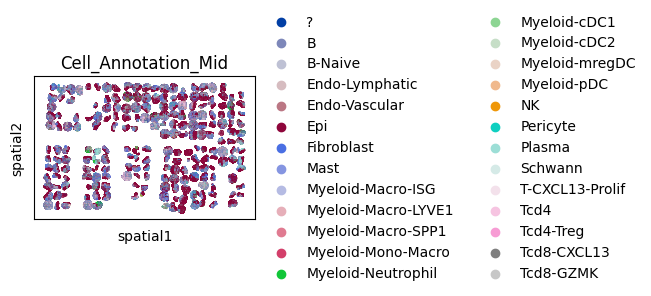

In [3]:
sq.pl.spatial_scatter(adata, shape = None, color = 'Cell_Annotation_Mid')

In [4]:
# PART 1: Main body:
# STREAMING VERSION - Load only visible cells (max 100K at a time)

def _pack_coords_binary(coords_array) -> str:
    """Pack Nx2 float32 coordinates as base64."""
    import base64
    import numpy as np
    return base64.b64encode(coords_array.astype(np.float32).tobytes()).decode('ascii')

def _b64(s: str) -> str:
    """Base64 encode a string."""
    return base64.b64encode(s.encode("utf-8")).decode("ascii")


def _serialize_result(result: Any) -> Dict:
    """Safely serialize callback results to JSON-compatible format."""
    if isinstance(result, dict):
        return {k: _serialize_result(v) for k, v in result.items()}
    elif isinstance(result, (list, tuple)):
        return [_serialize_result(item) for item in result]
    elif isinstance(result, np.ndarray):
        return result.tolist()
    elif isinstance(result, (np.integer, np.floating)):
        return result.item()
    elif isinstance(result, pd.Series):
        return result.tolist()
    elif isinstance(result, pd.DataFrame):
        return result.to_dict("records")
    elif hasattr(result, "toarray"):
        return result.toarray().tolist()
    elif isinstance(result, (str, int, float, bool, type(None))):
        return result
    else:
        return str(result)


def link_buttons_to_python(
    html_content: str,
    button_callbacks: Dict[str, Callable],
    callback_args: Optional[Dict[str, Any]] = None,
    height: int = 600,
    width: int = 900,
    debug: bool = False,
    max_result_size: int = 10_000_000,
    initial_data: Optional[Dict] = None,
) -> str:
    """
    Link HTML buttons to Python callbacks using widget-based communication.
    Adds a 2-panel layout:
      - Left: iframe UI (buttons/inputs)
      - Right: plot canvas (transparent) that can:
          * render embedding points: spatial/umap/pca (loaded upfront)
          * color points by continuous (GEX/obs numeric) or categorical (obs)
          * clear overlay back to neutral grey
    """
    if callback_args is None:
        callback_args = {}
    if initial_data is None:
        initial_data = {}

    iframe_id = f"iframe_{uuid.uuid4().hex}"
    output = widgets.Output()

    button_ids = list(button_callbacks.keys())
    button_ids_js = json.dumps(button_ids)
    initial_data_js = json.dumps(initial_data)

    # ----------------------------
    # Create data bridge widgets (one per button)
    # ----------------------------
    data_bridges: Dict[str, widgets.Text] = {}
    for bid in button_ids:
        bridge_name = f"_data_{iframe_id}_{bid}"
        bridge = widgets.Text(
            value="",
            description=bridge_name,
            placeholder=f"Data bridge for {bid}",
            layout=widgets.Layout(width="1px", height="1px", visibility="hidden"),
        )
        bridge.add_class(f"data-bridge-{iframe_id}")
        bridge.add_class(f"data-bridge-{bid}")
        data_bridges[bid] = bridge
        display(bridge)

    # ----------------------------
    # JS injected inside iframe:
    # - captures button clicks + input fields
    # - posts to parent
    # - receives python responses and re-dispatches as CustomEvent('pythonResponse')
    # ----------------------------
    communication_script = f"""
<script>
(function() {{
  const iframeId = {json.dumps(iframe_id)};
  const buttonIds = {button_ids_js};
  const initialData = {initial_data_js};
  let pendingRequest = null;

  function log(...args) {{ {"console.log('[iframe]', ...args);" if debug else ""} }}

  window.INITIAL_DATA = initialData;
  log("Initial data loaded:", initialData);

  buttonIds.forEach((bid) => {{
    const button = document.getElementById(bid);
    if (!button) {{
      log("Button not found:", bid);
      return;
    }}

    button.addEventListener('click', () => {{
      if (pendingRequest === bid) {{
        log("Request already pending for", bid);
        return;
      }}

      pendingRequest = bid;
      log("Button clicked:", bid);
      button.disabled = true;

      const data = {{}};

      // data-* attributes on the button
      for (let attr of button.attributes) {{
        if (attr.name.startsWith('data-')) {{
          data[attr.name.substring(5)] = attr.value;
        }}
      }}

      // inputs associated to this button via data-for="buttonId"
      const inputs = document.querySelectorAll('[data-for="' + bid + '"]');
      inputs.forEach(input => {{
        const key = input.getAttribute('data-key') || input.id || input.name;
        if (key) {{
          data[key] = input.value;
        }}
      }});

      log("Sending data:", data);

      window.parent.postMessage({{
        type: 'button_click',
        iframeId: iframeId,
        buttonId: bid,
        data: data,
        timestamp: Date.now()
      }}, '*');
    }});
  }});

  window.addEventListener('message', (event) => {{
    if (event.data && event.data.type === 'python_response') {{
      log("Received Python response:", event.data.data);

      if (pendingRequest) {{
        const button = document.getElementById(pendingRequest);
        if (button) button.disabled = false;
        pendingRequest = null;
      }}

      const customEvent = new CustomEvent('pythonResponse', {{
        detail: event.data.data
      }});
      window.dispatchEvent(customEvent);
    }}
  }});
}})();
</script>
"""

    if "</body>" in html_content.lower():
        idx = html_content.lower().rfind("</body>")
        full_html = html_content[:idx] + communication_script + html_content[idx:]
    else:
        full_html = html_content + communication_script

    payload_b64 = _b64(full_html)

    # ----------------------------
    # STREAMING: Send metadata only (bounds, counts) - NO CELLS YET!
    # ----------------------------
    adata = callback_args.get("adata", None)

    spatial = None
    if adata is not None:
        if "spatial" in adata.obsm:
            spatial = np.asarray(adata.obsm["spatial"])
        elif "X_spatial" in adata.obsm:
            spatial = np.asarray(adata.obsm["X_spatial"])

    if spatial is None or spatial.ndim != 2 or spatial.shape[1] < 2:
        sample_idx = np.array([], dtype=int)
        embeds_js = json.dumps({"streaming": True, "spatial": None, "umap": None, "pca": None})
    else:
        n = spatial.shape[0]
        sample_idx = np.arange(n, dtype=int)  # Track all indices
        
        # Calculate bounds only (don't send coordinates yet!)
        spatial_coords = spatial[:, :2]
        bounds = {
            "minX": float(spatial_coords[:, 0].min()),
            "maxX": float(spatial_coords[:, 0].max()),
            "minY": float(spatial_coords[:, 1].min()),
            "maxY": float(spatial_coords[:, 1].max()),
            "count": n
        }
        
        # Sample 100K cells for minimap (global positioning)
        minimap_sample_size = min(100_000, n)
        minimap_indices = np.random.choice(n, size=minimap_sample_size, replace=False)
        minimap_coords = spatial_coords[minimap_indices]
        # Pack as binary for efficiency
        minimap_binary = base64.b64encode(minimap_coords.astype(np.float32).tobytes()).decode('ascii')
        
        # Optional embedding bounds
        umap_bounds = None
        pca_bounds = None
        if "X_umap" in adata.obsm:
            um = np.asarray(adata.obsm["X_umap"])
            if um.ndim == 2 and um.shape[1] >= 2 and um.shape[0] == n:
                umap_bounds = {
                    "minX": float(um[:, 0].min()),
                    "maxX": float(um[:, 0].max()),
                    "minY": float(um[:, 1].min()),
                    "maxY": float(um[:, 1].max()),
                    "count": n
                }
        if "X_pca" in adata.obsm:
            pc = np.asarray(adata.obsm["X_pca"])
            if pc.ndim == 2 and pc.shape[1] >= 2 and pc.shape[0] == n:
                pca_bounds = {
                    "minX": float(pc[:, 0].min()),
                    "maxX": float(pc[:, 0].max()),
                    "minY": float(pc[:, 1].min()),
                    "maxY": float(pc[:, 1].max()),
                    "count": n
                }
        
        embeds_js = json.dumps({
            "streaming": True,
            "spatial": bounds,
            "umap": umap_bounds,
            "pca": pca_bounds,
            "minimap": {
                "coords_binary": minimap_binary,
                "count": minimap_sample_size
            }
        })
        
        print(f"✓ Streaming mode: {n:,} total cells (will load ~100K at a time)")

    callback_args = dict(callback_args)
    callback_args["__sample_idx"] = sample_idx.tolist()

    # ----------------------------
    # Parent container: 2 panels + plot canvas (transparent background)
    # ----------------------------
    container_html = f"""
<div style="display:flex; gap:10px; width:100%; height:{int(height)}px;">
  <!-- Left panel: controls iframe -->
  <div id="left_{iframe_id}" style="width: 420px; height:100%; flex: 0 0 420px;">
    <iframe
      id="{iframe_id}"
      style="width:100%; height:100%; border:1px solid #ccc; border-radius:6px; background:white;"
    ></iframe>
  </div>

  <!-- Right panel: plot area -->
  <div id="plot_panel_{iframe_id}"
       tabindex="0"
       style="width:{int(width)}px; height:100%; flex: 0 0 {int(width)}px; border:1px solid rgba(0,0,0,0.15); border-radius:6px;
              background: transparent; position: relative; overflow:hidden; outline:none;">
    <canvas id="plot_canvas_{iframe_id}"
            style="width:100%; height:100%; display:block; background: transparent;"></canvas>

    <!-- Hidden label (needed for state tracking but not displayed) -->
    <div id="plot_label_{iframe_id}" style="display:none;">Embedding: spatial</div>

    <!-- Camera button in top left -->
    <button id="camera_btn_{iframe_id}"
            style="position:absolute; left:10px; top:10px;
                   width:36px; height:36px;
                   border-radius:8px;
                   border:1px solid rgba(0,0,0,0.12);
                   background: rgba(255,255,255,0.9);
                   cursor:pointer;
                   display:flex;
                   align-items:center;
                   justify-content:center;
                   transition: all 0.15s ease;
                   box-shadow: 0 2px 4px rgba(0,0,0,0.08);"
            title="Download plot as PNG">
      <svg width="20" height="20" viewBox="0 0 24 24" fill="none" stroke="currentColor" stroke-width="2" stroke-linecap="round" stroke-linejoin="round">
        <path d="M23 19a2 2 0 0 1-2 2H3a2 2 0 0 1-2-2V8a2 2 0 0 1 2-2h4l2-3h6l2 3h4a2 2 0 0 1 2 2z"></path>
        <circle cx="12" cy="13" r="4"></circle>
      </svg>
    </button>
    
    <!-- Minimap in bottom left -->
    <canvas id="minimap_{iframe_id}"
            style="position:absolute; bottom:10px; left:10px;
                   width:120px; height:120px;
                   background:#000;
                   border:2px solid rgba(255,255,255,0.3);
                   border-radius:8px;
                   display:block;"></canvas>
  </div>
</div>

<style>
  #camera_btn_{iframe_id}:hover {{
    background: rgba(141,236,245,0.2);
    border-color: rgba(141,236,245,0.6);
    box-shadow: 0 4px 8px rgba(0,0,0,0.12);
  }}
</style>

<script>
(function() {{
  const iframeId = {json.dumps(iframe_id)};

  const iframe = document.getElementById({json.dumps(iframe_id)});
  const b64 = {json.dumps(payload_b64)};
  const html = decodeURIComponent(escape(atob(b64)));

  // ---- write iframe content ----
  const doc = iframe.contentWindow.document;
  doc.open();
  doc.write(html);
  doc.close();

  // ---- request queue for button bridge ----
  window["_requests_" + iframeId] = [];

  function log(...args) {{ {"console.log('[parent]', ...args);" if debug else ""} }}

  // Guard against duplicate listener on reruns for this iframe_id
  const MSG_GUARD = "_msg_listener_installed_" + iframeId;
  if (!window[MSG_GUARD]) {{
    window[MSG_GUARD] = true;
    window.addEventListener('message', (event) => {{
      if (!event.data) return;
      if (event.data.iframeId === iframeId && event.data.type === "button_click") {{
        log("Queued button click:", event.data.buttonId, "with data:", event.data.data);
        window["_requests_" + iframeId].push(event.data);
      }}
      // Listen to ui_state updates from iframe (for legend toggles, opacity, etc)
      if (event.data.type === "ui_state") {{
        log("Received ui_state update from iframe");
        const s = window["_plotState_" + iframeId];
        
        // Update obs layer
        if (s && event.data.obs) {{
          if (event.data.obs.values) {{
            // Obs data is active
            s.obs.mode = event.data.obs.mode;
            s.obs.values = event.data.obs.values;
            s.obs.colors = event.data.obs.colors;
            s.obs.categories = event.data.obs.categories;
            s.obs.enabled = event.data.obs.enabled;
            s.obs.opacity = event.data.obs.opacity || 1.0;
          }} else {{
            // No obs data - clear obs layer
            s.obs.mode = null;
            s.obs.values = null;
            s.obs.colors = null;
            s.obs.categories = null;
            s.obs.enabled = null;
          }}
        }}
        
        // Update GEX layer
        if (s && event.data.gex) {{
          if (event.data.gex.active && event.data.gex.values) {{
            // GEX is active
            s.gex.values = event.data.gex.values;
            s.gex.opacity = event.data.gex.opacity || 1.0;
          }} else {{
            // No GEX - clear GEX layer
            s.gex.values = null;
          }}
        }}
        
        // Update selection mask and outline
        if (s && event.data.selection) {{
          s.selectionIndices = event.data.selection.indices || null;
          s.selectionPath = event.data.selection.path || null;
          s.selectionTool = event.data.selection.tool || null;
        }}
        
        // Update point size
        if (s && typeof event.data.pointSize === 'number') {{
          s.pointSize = event.data.pointSize;
        }}
        
        // Update label
        if (s) {{
          const hasObs = s.obs.values != null;
          const hasGex = s.gex.values != null;
          
          if (hasGex && hasObs) {{
            s.label = "obs: " + (event.data.obs.column || "") + " + GEX: " + (event.data.gex.active || "");
          }} else if (hasGex) {{
            s.label = "GEX: " + (event.data.gex.active || "");
          }} else if (hasObs) {{
            s.label = "obs: " + (event.data.obs.column || "");
          }} else {{
            s.label = "Embedding: " + currentEmbedding;
          }}
          setLabel(s.label);
        }}
        
        draw();
      }}
      
      // Listen for selection_tool messages from iframe
      if (event.data.type === "selection_tool") {{
        const tool = event.data.tool;
        window["_selectionTool_" + iframeId] = tool;
        window["_selectionPath_" + iframeId] = [];
        window["_isDrawing_" + iframeId] = false;
        log("Selection tool changed to:", tool);
        draw(); // Redraw to clear any previous selection outline
      }}
      
      // Listen for save_obs_column message from iframe
      if (event.data.type === "save_obs_column" && event.data.iframeId === iframeId) {{
        log("Saving obs column:", event.data.columnName);
        // Queue this as a special request to be handled by Python
        window["_requests_" + iframeId].push({{
          buttonId: "__save_obs_column__",
          data: {{
            columnName: event.data.columnName,
            columnData: event.data.columnData
          }},
          type: "button_click",
          iframeId: iframeId
        }});
      }}
    }});
  }}

  window["sendToIframe_" + iframeId] = function(data) {{
    const iframe2 = document.getElementById(iframeId);
    if (iframe2 && iframe2.contentWindow) {{
      iframe2.contentWindow.postMessage({{
        type: "python_response",
        data: data
      }}, "*");
    }}
  }};

  // STREAMING: Metadata only initially
  // ----------------------------
  const METADATA = {embeds_js};
  let currentEmbedding = "spatial";
  
  // Storage for loaded cells
  const LOADED_CELLS = new Map();  // Map<index, {{x, y, obs_value, gex_value}}>
  let currentPalette = null;
  let currentCategories = null;
  let currentObsColumn = null;
  let currentGexGene = null;
  
  // Storage for full embeddings (UMAP/PCA load all cells, no streaming)
  const EMBEDS = {{}};  // Will be populated when switching to UMAP/PCA
  
  // Streaming state management
  let isRequestPending = false;
  let lastViewportRequest = null;
  let lastSuccessfulLoadTime = Date.now();
  
  // Decode minimap sample for global positioning
  let MINIMAP_POINTS = [];
  if (METADATA.minimap && METADATA.minimap.coords_binary) {{
    const binary = atob(METADATA.minimap.coords_binary);
    const bytes = new Uint8Array(binary.length);
    for (let i = 0; i < binary.length; i++) bytes[i] = binary.charCodeAt(i);
    const floats = new Float32Array(bytes.buffer);
    
    MINIMAP_POINTS = [];
    for (let i = 0; i < floats.length; i += 2) {{
      MINIMAP_POINTS.push([floats[i], floats[i + 1]]);
    }}
  }}
  
  console.log("[Streaming] Metadata loaded:", METADATA);
  
  // Decode binary coordinates helper
  function decodeBinaryCoords(binaryStr, count) {{
    if (!binaryStr || count === 0) return null;
    const binary = atob(binaryStr);
    const bytes = new Uint8Array(binary.length);
    for (let i = 0; i < binary.length; i++) bytes[i] = binary.charCodeAt(i);
    const floats = new Float32Array(bytes.buffer);
    return floats;  // Returns Float32Array with [x1,y1,x2,y2,...]
  }}
  
  let points = [];  // Keep for compatibility but not used

  // ----------------------------
  // Navigation state (zoom, pan, rotation)
  // ----------------------------
  let zoom = 1.0;
  let panX = 0;
  let panY = 0;
  let rotation = 0;
  let isDragging = false;
  let lastMouseX = 0;
  let lastMouseY = 0;
  let rotationMode = false;
  let lastRotationKeyPress = 0;
  
  // ----------------------------
  // Animation state
  // ----------------------------
  let isAnimating = false;
  let animationStartTime = 0;
  let animationDuration = 1000; // 1 second for embedding transitions
  let startPoints = null;
  let endPoints = null;
  
  // Color animation
  let colorAnimating = false;
  let colorAnimStart = 0;
  const COLOR_ANIM_MS = 500; // 0.5 seconds
  let oldColors = null;
  let newColors = null;
  
  // Helper function for smooth interpolation
  function lerp(a, b, t) {{
    return a + (b - a) * t;
  }}
  
  // Easing function (ease-in-out)
  function easeInOutQuad(t) {{
    return t < 0.5 ? 2 * t * t : 1 - Math.pow(-2 * t + 2, 2) / 2;
  }}

  // ----------------------------
  // Plot state (supports layered rendering: obs + GEX overlay)
  // ----------------------------
  window["_plotState_" + iframeId] = {{
    // Obs layer (base)
    obs: {{
      mode: null,           // "categorical" | "continuous" | null
      values: null,         // per-point values
      colors: null,         // categorical palette
      categories: null,
      enabled: null,        // boolean array for categorical toggles
      opacity: 1.0
    }},
    // GEX layer (overlay)
    gex: {{
      values: null,         // per-point continuous values
      opacity: 1.0
    }},
    label: "Embedding: spatial",
    pointSize: 1.1,
    selectionIndices: null  // array of selected point indices (acts as mask)
  }};

  function setLabel(text) {{
    const lab = document.getElementById("plot_label_" + iframeId);
    if (lab) lab.textContent = text;
  }}

  // Camera button - download canvas as PNG with custom filename
  const cameraBtn = document.getElementById("camera_btn_" + iframeId);
  if (cameraBtn) {{
    cameraBtn.addEventListener("click", () => {{
      // Prompt for filename
      const defaultName = "spatial_plot_" + new Date().toISOString().slice(0,10);
      const filename = prompt("Enter filename for PNG (without extension):", defaultName);
      
      // If user cancelled or entered empty string, don't download
      if (!filename || filename.trim() === "") {{
        return;
      }}
      
      // Download with user's filename
      const link = document.createElement("a");
      link.download = filename.trim() + ".png";
      link.href = canvas.toDataURL("image/png");
      link.click();
    }});
  }}

  // ----------------------------
  // Plot updater: receives Python callback payloads
  // ----------------------------
  window["updatePlot_" + iframeId] = function(payload) {{
    if (!payload || !payload.type) return;

    // STREAMING: Handle viewport cells response
    if (payload.type === "viewport_cells") {{
      console.log("[Streaming] Received viewport cells:", payload);
      
      // Clear pending flag
      isRequestPending = false;
      
      // Decode coordinates
      const coords = decodeBinaryCoords(payload.coords_binary, payload.coords_count);
      if (!coords) {{
        console.error("Failed to decode coordinates");
        return;
      }}
      
      // ADD cells (don't clear existing ones!)
      let newCellCount = 0;
      for (let i = 0; i < payload.indices.length; i++) {{
        const idx = payload.indices[i];
        // Only add if not already present
        if (!LOADED_CELLS.has(idx)) {{
          LOADED_CELLS.set(idx, {{
            x: coords[i * 2],
            y: coords[i * 2 + 1],
            obs_value: payload.obs_values ? payload.obs_values[i] : undefined,
            gex_value: payload.gex_values ? payload.gex_values[i] : undefined
          }});
          newCellCount++;
        }} else {{
          // Update color data if present
          const cell = LOADED_CELLS.get(idx);
          if (payload.obs_values) cell.obs_value = payload.obs_values[i];
          if (payload.gex_values) cell.gex_value = payload.gex_values[i];
        }}
      }}
      
      console.log(`[Streaming] Added ${{newCellCount}} new cells, total now: ${{LOADED_CELLS.size}}`);
      
      // Update health check timestamp
      lastSuccessfulLoadTime = Date.now();
      
      // Memory management: Remove cells far outside viewport (keep 2x viewport area)
      if (LOADED_CELLS.size > 100000) {{  // Prune more aggressively to prevent connection issues
        const embedMeta = METADATA[currentEmbedding];
        if (embedMeta) {{
          const rect = panel.getBoundingClientRect();
          const W = rect.width;
          const H = rect.height;
          const {{minX, maxX, minY, maxY}} = embedMeta;
          const pad = 12;
          const spanX = (maxX - minX) || 1;
          const spanY = (maxY - minY) || 1;
          const baseScale = Math.min((W - 2*pad) / spanX, (H - 2*pad) / spanY);
          const scale = baseScale * zoom;
          const usedW = spanX * scale;
          const usedH = spanY * scale;
          const offX = (W - usedW) / 2 + panX;
          const offY = (H - usedH) / 2 + panY;
          
          // Calculate expanded viewport (2x size for buffer)
          const viewMinX = minX + (-offX) / scale;
          const viewMaxX = minX + (W - offX) / scale;
          const viewMinY = minY + (-offY) / scale;
          const viewMaxY = minY + (H - offY) / scale;
          const bufferX = (viewMaxX - viewMinX) * 0.5;
          const bufferY = (viewMaxY - viewMinY) * 0.5;
          
          let pruned = 0;
          for (const [idx, cell] of LOADED_CELLS.entries()) {{
            if (cell.x < viewMinX - bufferX || cell.x > viewMaxX + bufferX ||
                cell.y < viewMinY - bufferY || cell.y > viewMaxY + bufferY) {{
              LOADED_CELLS.delete(idx);
              pruned++;
            }}
          }}
          if (pruned > 0) {{
            console.log(`[Streaming] Pruned ${{pruned}} distant cells, now have ${{LOADED_CELLS.size}}`);
          }}
        }}
      }}
      
      // Store palette/categories globally
      if (payload.obs_colors) {{
        currentPalette = payload.obs_colors;
        currentCategories = payload.obs_categories;
        currentObsColumn = payload.obs_column;
      }}
      if (payload.gex_gene) {{
        currentGexGene = payload.gex_gene;
      }}
      
      draw();
      return;
    }}

    // Switch embedding (UMAP/PCA/Spatial)
    if (payload.type === "set_embedding") {{
      const name = (payload.embedding || "spatial");
      
      // Don't switch if already on this embedding
      if (currentEmbedding === name) return;
      
      // Switching TO spatial - clear non-spatial data and use streaming mode
      if (name === "spatial") {{
        console.log("[Embedding] Switching to spatial - clearing UMAP/PCA data");
        
        // IMPORTANT: Clear all loaded cells since they have wrong coordinates
        LOADED_CELLS.clear();
        
        currentEmbedding = name;
        zoom = 1.0;
        panX = 0;
        panY = 0;
        rotation = 0;
        draw();
        
        // Request initial viewport for spatial
        if (METADATA.streaming && METADATA.spatial) {{
          const embedMeta = METADATA.spatial;
          const newView = getViewportBounds(embedMeta);
          isRequestPending = true;
          lastViewportRequest = newView;
          requestViewportCells(newView.minX, newView.maxX, newView.minY, newView.maxY);
        }}
      }}
      return;
    }}
    
    // Receive full embedding data chunks (for UMAP/PCA)
    if (payload.type === "full_embedding_chunk") {{
      const name = payload.embedding;
      
      console.log(`[Embedding] Chunk ${{payload.chunk + 1}}: ${{payload.loaded_cells.toLocaleString()}} / ${{payload.total_cells.toLocaleString()}} cells (${{Math.round(payload.loaded_cells / payload.total_cells * 100)}}%)`);
      
      // Decode coordinates
      const coords = decodeBinaryCoords(payload.coords_binary, payload.coords_count);
      if (!coords) {{
        console.error("Failed to decode embedding coordinates");
        return;
      }}
      
      // On first chunk, clear existing data (switching embeddings)
      if (payload.chunk === 0) {{
        console.log(`[Embedding] Starting fresh load of ${{name}} - clearing old data`);
        LOADED_CELLS.clear();
        
        currentEmbedding = name;
        zoom = 1.0;
        panX = 0;
        panY = 0;
        rotation = 0;
      }}
      
      // Add cells to LOADED_CELLS (accumulate chunks!)
      for (let i = 0; i < payload.indices.length; i++) {{
        const idx = payload.indices[i];
        LOADED_CELLS.set(idx, {{
          x: coords[i * 2],
          y: coords[i * 2 + 1],
          obs_value: payload.obs_values ? payload.obs_values[i] : undefined,
          gex_value: payload.gex_values ? payload.gex_values[i] : undefined
        }});
      }}
      
      // Redraw with what we have so far
      draw();
      
      // If not final chunk, request next chunk
      if (!payload.is_final) {{
        console.log(`[Embedding] Requesting next chunk...`);
        sendButtonClick(name + "Btn", {{ chunk: payload.chunk + 1 }});
      }} else {{
        console.log(`[Embedding] ✓ Loaded all ${{payload.total_cells.toLocaleString()}} cells for ${{name}}`);
        EMBEDS[name] = true;  // Mark as fully loaded
      }}
      
      return;
    }}

    // Clear overlay (back to neutral grey)
    if (payload.type === "clear_plot") {{
      const s = window["_plotState_" + iframeId];
      if (s) {{
        // Clear obs layer
        s.obs.mode = null;
        s.obs.values = null;
        s.obs.colors = null;
        s.obs.categories = null;
        s.obs.enabled = null;
        // Clear GEX layer
        s.gex.values = null;
        s.label = "Embedding: " + currentEmbedding;
      }}
      setLabel("Embedding: " + currentEmbedding);
      draw();
      return;
    }}

    // GEX continuous - store in GEX layer
    if (payload.type === "gex_values") {{
      const s = window["_plotState_" + iframeId];
      if (s) {{
        s.gex.values = payload.values || null;
        s.label = "GEX: " + (payload.gene || "");
      }}
      setLabel("GEX: " + (payload.gene || ""));
      draw();
      return;
    }}

    // obs values - STREAMING: Update colors without clearing cells
    if (payload.type === "obs_values") {{
      console.log("[Streaming] Obs column selected, requesting color update...");
      currentObsColumn = payload.column;
      currentPalette = payload.colors;
      currentCategories = payload.categories;
      
      // Request color data for currently loaded cells
      if (LOADED_CELLS.size > 0) {{
        const indices = Array.from(LOADED_CELLS.keys());
        console.log(`[Streaming] Requesting colors for ${{indices.length}} loaded cells`);
        // We'll need a separate callback for this - for now just redraw
        draw();
      }}
      return;
    }}
  }};

  // ----------------------------
  // Plotting
  // ----------------------------
  const canvas = document.getElementById("plot_canvas_" + iframeId);
  const panel = document.getElementById("plot_panel_" + iframeId);
  const ctx = canvas.getContext("2d");
  
  const minimap = document.getElementById("minimap_" + iframeId);
  const minimapCtx = minimap.getContext("2d");
  
  // Set actual minimap canvas dimensions (not just CSS)
  minimap.width = 120;
  minimap.height = 120;

  function clamp01(x) {{ return Math.max(0, Math.min(1, x)); }}

  // Minimal viridis approximation via stops
  const VIRIDIS = [
    [0.0,  [68, 1, 84]],
    [0.13, [71, 44, 122]],
    [0.25, [59, 81, 139]],
    [0.38, [44, 113, 142]],
    [0.50, [33, 144, 141]],
    [0.63, [39, 173, 129]],
    [0.75, [92, 200, 99]],
    [0.88, [170, 220, 50]],
    [1.0,  [253, 231, 37]]
  ];

  function viridis(t) {{
    t = clamp01(t);
    for (let i = 0; i < VIRIDIS.length - 1; i++) {{
      const a = VIRIDIS[i], b = VIRIDIS[i + 1];
      if (t >= a[0] && t <= b[0]) {{
        const u = (t - a[0]) / (b[0] - a[0] || 1);
        const r = Math.round(a[1][0] + u*(b[1][0]-a[1][0]));
        const g = Math.round(a[1][1] + u*(b[1][1]-a[1][1]));
        const bl = Math.round(a[1][2] + u*(b[1][2]-a[1][2]));
        return `rgb(${{r}},${{g}},${{bl}})`;
      }}
    }}
    const c = VIRIDIS[VIRIDIS.length - 1][1];
    return `rgb(${{c[0]}},${{c[1]}},${{c[2]}})`;
  }}

  function fallbackCatColor(k) {{
    const h = (k * 137.508) % 360;
    return `hsl(${{h}}, 55%, 55%)`;
  }}

  // ----------------------------
  // Streaming viewport management
  // ----------------------------
  let viewportRefreshTimer = null;
  // Note: isRequestPending and lastViewportRequest declared earlier
  
  // Helper: Calculate circular viewport that contains entire view at any rotation
  function getViewportBounds(embedMeta) {{
    const rect = panel.getBoundingClientRect();
    const W = rect.width;
    const H = rect.height;
    const {{minX, maxX, minY, maxY}} = embedMeta;
    const pad = 12;
    const spanX = (maxX - minX) || 1;
    const spanY = (maxY - minY) || 1;
    const baseScale = Math.min((W - 2*pad) / spanX, (H - 2*pad) / spanY);
    const scale = baseScale * zoom;
    const usedW = spanX * scale;
    const usedH = spanY * scale;
    const offX = (W - usedW) / 2 + panX;
    const offY = (H - usedH) / 2 + panY;
    
    // Calculate center of viewport in data coordinates
    const centerDataX = minX + (W / 2 - offX) / scale;
    const centerDataY = minY + (H / 2 - offY) / scale;
    
    // Calculate radius: diagonal of viewport / 2 (so circle contains entire rectangle at any rotation)
    const viewWidthData = W / scale;
    const viewHeightData = H / scale;
    const radius = Math.sqrt(viewWidthData * viewWidthData + viewHeightData * viewHeightData) / 2;
    
    // Add 20% buffer for smooth loading
    const bufferedRadius = radius * 1.2;
    
    // Return circular bounds as a square bounding box
    return {{
      minX: centerDataX - bufferedRadius,
      maxX: centerDataX + bufferedRadius,
      minY: centerDataY - bufferedRadius,
      maxY: centerDataY + bufferedRadius
    }};
  }}
  
  // Health check: if we haven't received data in 10 seconds, refresh viewport
  setInterval(() => {{
    if (METADATA.streaming && !isRequestPending) {{
      const timeSinceLastLoad = Date.now() - lastSuccessfulLoadTime;
      // If more than 10 seconds and we have very few cells, request refresh
      if (timeSinceLastLoad > 10000 && LOADED_CELLS.size < 5000) {{
        console.log("[Health Check] Low cell count detected, refreshing viewport...");
        const embedMeta = METADATA[currentEmbedding];
        if (embedMeta) {{
          const newView = getViewportBounds(embedMeta);
          isRequestPending = true;
          lastViewportRequest = newView;
          requestViewportCells(newView.minX, newView.maxX, newView.minY, newView.maxY);
        }}
      }}
    }}
  }}, 5000);  // Check every 5 seconds
  
  // Check if viewport has changed (more sensitive for smooth streaming)
  function hasViewportChanged(oldView, newView) {{
    if (!oldView) return true;
    const overlapX = Math.min(oldView.maxX, newView.maxX) - Math.max(oldView.minX, newView.minX);
    const overlapY = Math.min(oldView.maxY, newView.maxY) - Math.max(oldView.minY, newView.minY);
    const oldAreaX = oldView.maxX - oldView.minX;
    const oldAreaY = oldView.maxY - oldView.minY;
    const overlapRatio = (overlapX * overlapY) / (oldAreaX * oldAreaY);
    return overlapRatio < 0.8;  // Refresh at 80% overlap (more frequent requests)
  }}

  function resizeCanvas() {{
    const rect = panel.getBoundingClientRect();
    canvas.width = Math.max(1, Math.floor(rect.width * window.devicePixelRatio));
    canvas.height = Math.max(1, Math.floor(rect.height * window.devicePixelRatio));
    ctx.setTransform(1, 0, 0, 1, 0, 0);
    ctx.scale(window.devicePixelRatio, window.devicePixelRatio);
    draw();
  }}

  function draw() {{
    const rect = panel.getBoundingClientRect();
    const W = rect.width;
    const H = rect.height;
    ctx.clearRect(0, 0, W, H);

    // Check if we have metadata
    const embedMeta = METADATA[currentEmbedding];
    if (!embedMeta || !METADATA.streaming) {{
      ctx.font = "13px ui-monospace, Menlo, Monaco, monospace";
      ctx.fillStyle = "rgba(0,0,0,0.6)";
      ctx.fillText("Embedding not available.", 12, 40);
      return;
    }}

    const {{minX, maxX, minY, maxY}} = embedMeta;
    const pad = 12;
    const spanX = (maxX - minX) || 1;
    const spanY = (maxY - minY) || 1;
    const baseScale = Math.min((W - 2*pad) / spanX, (H - 2*pad) / spanY);
    const scale = baseScale * zoom;
    const usedW = spanX * scale;
    const usedH = spanY * scale;
    const offX = (W - usedW) / 2 + panX;
    const offY = (H - usedH) / 2 + panY;
    
    // Calculate viewport bounds in data coordinates (accounting for zoom/pan)
    // The visible area in data coordinates
    const viewMinX = minX + (-offX) / scale;
    const viewMaxX = minX + (W - offX) / scale;
    const viewMinY = minY + (-offY) / scale;
    const viewMaxY = minY + (H - offY) / scale;
    
    // Check if we have cells loaded
    if (LOADED_CELLS.size === 0) {{
      // Only request if not already pending
      if (!isRequestPending) {{
        const newView = {{minX: viewMinX, maxX: viewMaxX, minY: viewMinY, maxY: viewMaxY}};
        if (hasViewportChanged(lastViewportRequest, newView)) {{
          console.log("[Streaming] Requesting initial viewport cells...");
          isRequestPending = true;
          lastViewportRequest = newView;
          requestViewportCells(viewMinX, viewMaxX, viewMinY, viewMaxY);
        }}
      }}
      
      ctx.font = "16px ui-monospace, Menlo, Monaco, monospace";
      ctx.fillStyle = "rgba(0,0,0,0.8)";
      ctx.textAlign = "center";
      ctx.fillText("Loading cells...", W/2, H/2);
      ctx.textAlign = "left";
      return;
    }}
    
    ctx.save();
    ctx.translate(W / 2, H / 2);
    ctx.rotate(rotation);
    ctx.translate(-W / 2, -H / 2);

    const state = window["_plotState_" + iframeId] || {{ obs: {{}}, gex: {{}} }};
    const r = state.pointSize || 1.1;
    
    let renderedCount = 0;
    
    // Render all loaded cells (no viewport filtering - we already loaded the right ones!)
    for (const [idx, cell] of LOADED_CELLS.entries()) {{
      const px = offX + (cell.x - minX) * scale;
      const py = offY + (cell.y - minY) * scale;
      
      // Determine color
      let color = "rgba(150, 150, 150, 0.6)";  // Default grey
      
      if (cell.obs_value !== undefined && currentPalette) {{
        // Categorical color
        color = currentPalette[cell.obs_value] || fallbackCatColor(cell.obs_value);
      }} else if (cell.gex_value !== undefined) {{
        // GEX color
        const t = clamp01(cell.gex_value / 5.0);  // Simple normalization
        color = viridis(t);
      }}
      
      ctx.fillStyle = color;
      ctx.globalAlpha = 1.0;
      ctx.beginPath();
      ctx.arc(px, py, r, 0, Math.PI * 2);
      ctx.fill();
      
      renderedCount++;
    }}

    ctx.globalAlpha = 1.0;
    ctx.restore();
    
    drawMinimap();
  }}
  
  // Request viewport cells from Python
  function requestViewportCells(viewMinX, viewMaxX, viewMinY, viewMaxY) {{
    // Build request data
    const requestData = {{
      embedding: currentEmbedding,
      viewMinX: viewMinX,
      viewMaxX: viewMaxX,
      viewMinY: viewMinY,
      viewMaxY: viewMaxY,
      activeColumn: currentObsColumn,
      activeGene: currentGexGene
    }};
    
    console.log("[Streaming] Requesting cells:", requestData);
    
    // Send via iframe postMessage
    window.parent.postMessage({{
      type: 'button_click',
      iframeId: iframeId,
      buttonId: 'viewportBtn',
      data: requestData,
      timestamp: Date.now()
    }}, '*');
  }}
  
  // ----------------------------
  // Minimap drawing
  // ----------------------------
  function drawMinimap() {{
    const mmW = minimap.width;
    const mmH = minimap.height;
    
    minimapCtx.fillStyle = "#000";
    minimapCtx.fillRect(0, 0, mmW, mmH);
    
    // Use minimap sample points (100K global sample)
    if (!MINIMAP_POINTS || MINIMAP_POINTS.length === 0) return;
    
    // Get bounds from metadata
    const embedMeta = METADATA[currentEmbedding];
    if (!embedMeta) return;
    
    const minX = embedMeta.minX;
    const maxX = embedMeta.maxX;
    const minY = embedMeta.minY;
    const maxY = embedMeta.maxY;
    
    const pad = 5;
    const spanX = (maxX - minX) || 1;
    const spanY = (maxY - minY) || 1;
    const scale = Math.min((mmW - 2*pad) / spanX, (mmH - 2*pad) / spanY);
    const usedW = spanX * scale;
    const usedH = spanY * scale;
    const offX = (mmW - usedW) / 2;
    const offY = (mmH - usedH) / 2;
    
    // Draw minimap sample points as small dots
    minimapCtx.fillStyle = "rgba(200, 200, 200, 0.8)";  // Brighter for visibility
    for (let i = 0; i < MINIMAP_POINTS.length; i++) {{
      const [x, y] = MINIMAP_POINTS[i];
      const px = offX + (x - minX) * scale;
      const py = offY + (y - minY) * scale;
      minimapCtx.fillRect(px - 0.5, py - 0.5, 1, 1);
    }}
    
    // Draw viewport indicator on minimap
    const rect = panel.getBoundingClientRect();
    const W = rect.width;
    const H = rect.height;
    const baseScale = Math.min((W - 24) / spanX, (H - 24) / spanY);
    const viewScale = baseScale * zoom;
    const viewW = spanX * viewScale;
    const viewH = spanY * viewScale;
    const viewOffX = (W - viewW) / 2 + panX;
    const viewOffY = (H - viewH) / 2 + panY;
    
    // Calculate viewport bounds in data space (unrotated)
    const dataMinX = minX - viewOffX / viewScale;
    const dataMaxX = minX + (W - viewOffX) / viewScale;
    const dataMinY = minY - viewOffY / viewScale;
    const dataMaxY = minY + (H - viewOffY) / viewScale;
    
    // Calculate 4 corners of viewport
    const dataCenterX = (dataMinX + dataMaxX) / 2;
    const dataCenterY = (dataMinY + dataMaxY) / 2;
    
    const corners = [
      [dataMinX, dataMinY],  // top-left
      [dataMaxX, dataMinY],  // top-right
      [dataMaxX, dataMaxY],  // bottom-right
      [dataMinX, dataMaxY]   // bottom-left
    ];
    
    // If rotation is active, rotate corners
    if (rotation !== 0) {{
      const cos = Math.cos(rotation);
      const sin = Math.sin(rotation);
      
      for (let i = 0; i < corners.length; i++) {{
        const dx = corners[i][0] - dataCenterX;
        const dy = corners[i][1] - dataCenterY;
        corners[i][0] = dataCenterX + (dx * cos - dy * sin);
        corners[i][1] = dataCenterY + (dx * sin + dy * cos);
      }}
    }}
    
    // Convert corners to minimap pixels
    const mmCorners = corners.map(([x, y]) => [
      offX + (x - minX) * scale,
      offY + (y - minY) * scale
    ]);
    
    // Draw the viewport polygon (shows rotation!)
    minimapCtx.strokeStyle = "rgba(255, 50, 50, 0.9)";  // Bright red
    minimapCtx.lineWidth = 1.5;
    minimapCtx.beginPath();
    minimapCtx.moveTo(mmCorners[0][0], mmCorners[0][1]);
    for (let i = 1; i < mmCorners.length; i++) {{
      minimapCtx.lineTo(mmCorners[i][0], mmCorners[i][1]);
    }}
    minimapCtx.closePath();
    minimapCtx.stroke();
  }}

  resizeCanvas();
  window.addEventListener("resize", resizeCanvas);

  // ----------------------------
  // Pan/Zoom/Rotation controls
  // ----------------------------
  
  // Wheel zoom (slowed to 0.5x) with viewport refresh
  canvas.addEventListener("wheel", (e) => {{
    e.preventDefault();
    const rect = canvas.getBoundingClientRect();
    const mouseX = e.clientX - rect.left;
    const mouseY = e.clientY - rect.top;
    
    const delta = e.deltaY * 0.0005;
    const zoomFactor = delta > 0 ? 0.975 : 1.025;
    const oldZoom = zoom;
    zoom *= zoomFactor;
    zoom = Math.max(0.01, zoom);  // Only minimum zoom, no maximum! Zoom in forever!
    
    const zoomChange = zoom / oldZoom;
    panX = mouseX - (mouseX - panX) * zoomChange;
    panY = mouseY - (mouseY - panY) * zoomChange;
    
    draw();
    
    // STREAMING: Request new viewport after zoom stops (debounced)
    clearTimeout(viewportRefreshTimer);
    viewportRefreshTimer = setTimeout(() => {{
      if (METADATA.streaming && !isRequestPending) {{
        const embedMeta = METADATA[currentEmbedding];
        if (embedMeta) {{
          const newView = getViewportBounds(embedMeta);
          
          if (hasViewportChanged(lastViewportRequest, newView)) {{
            console.log("[Streaming] Zoom stopped, requesting incremental fill...");
            isRequestPending = true;
            lastViewportRequest = newView;
            requestViewportCells(newView.minX, newView.maxX, newView.minY, newView.maxY);
          }}
        }}
      }}
    }}, 200);  // 200ms zoom response (reduced request frequency)
  }});
  
  // Double-click to reset view
  canvas.addEventListener("dblclick", () => {{
    zoom = 1.0;
    panX = 0;
    panY = 0;
    rotation = 0;
    rotationMode = false;
    draw();
  }});
  
  // Auto-focus panel on mouse enter to capture keyboard events
  panel.addEventListener("mouseenter", () => {{
    panel.focus();
  }});
  
  // Keyboard controls - only work when panel has focus
  panel.addEventListener("keydown", (e) => {{
    // Arrow keys for size (when not in input)
    if (e.target.tagName === 'INPUT' && e.target.type === 'text') return;
    
    if (e.key === "ArrowLeft" || e.key === "ArrowRight") {{
      e.preventDefault();
      e.stopPropagation();
      const state = window["_plotState_" + iframeId];
      if (!state) return;
      
      const step = 0.1;
      const min = 0.5;
      const max = 8;
      
      if (e.key === "ArrowLeft") {{
        state.pointSize = Math.max(min, state.pointSize - step);
      }} else {{
        state.pointSize = Math.min(max, state.pointSize + step);
      }}
      
      draw();
    }}
    
    // R key for rotation
    if (e.key === "r" || e.key === "R") {{
      e.preventDefault();
      e.stopPropagation();
      const now = Date.now();
      if (now - lastRotationKeyPress < 500) {{
        // Double-tap: reset rotation
        rotation = 0;
        rotationMode = false;
      }} else {{
        // Single tap: toggle rotation mode
        rotationMode = !rotationMode;
        canvas.style.cursor = rotationMode ? "crosshair" : "default";
      }}
      lastRotationKeyPress = now;
      draw();
    }}
  }});
  
  // Rotation with mouse when in rotation mode
  canvas.addEventListener("mousemove", (e) => {{
    if (rotationMode && !isDragging && !window["_isDrawing_" + iframeId]) {{
      const rect = canvas.getBoundingClientRect();
      const centerX = rect.width / 2;
      const centerY = rect.height / 2;
      const angle = Math.atan2(e.clientY - rect.top - centerY, e.clientX - rect.left - centerX);
      rotation = angle;
      draw();
      return;
    }}
  }});

  // ----------------------------
  // Selection drawing AND panning
  // ----------------------------
  canvas.addEventListener("mousedown", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    const rect = canvas.getBoundingClientRect();
    const x = e.clientX - rect.left;
    const y = e.clientY - rect.top;
    
    // Exit rotation mode on click (locks rotation in place)
    if (rotationMode) {{
      rotationMode = false;
      canvas.style.cursor = "default";
      return;
    }}
    
    if (tool) {{
      // Selection drawing mode
      window["_isDrawing_" + iframeId] = true;
      window["_selectionPath_" + iframeId] = [[x, y]];
      
      if (tool === "rectangle" || tool === "circle") {{
        window["_selectionStart_" + iframeId] = [x, y];
      }}
    }} else if (!rotationMode) {{
      // Panning mode
      isDragging = true;
      lastMouseX = e.clientX;
      lastMouseY = e.clientY;
      canvas.style.cursor = "grabbing";
    }}
  }});
  
  canvas.addEventListener("mousemove", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    const rect = canvas.getBoundingClientRect();
    const x = e.clientX - rect.left;
    const y = e.clientY - rect.top;
    
    if (tool && window["_isDrawing_" + iframeId]) {{
      // Selection drawing
      if (tool === "lasso" || tool === "polygon") {{
        window["_selectionPath_" + iframeId].push([x, y]);
      }} else if (tool === "rectangle" || tool === "circle") {{
        window["_selectionPath_" + iframeId] = [window["_selectionStart_" + iframeId], [x, y]];
      }}
      drawSelectionOutline();
    }} else if (isDragging) {{
      // Panning - rotation-aware
      const dx = e.clientX - lastMouseX;
      const dy = e.clientY - lastMouseY;
      
      // Rotate the pan delta by the inverse of current rotation
      const cos = Math.cos(-rotation);
      const sin = Math.sin(-rotation);
      const rotatedDx = dx * cos - dy * sin;
      const rotatedDy = dx * sin + dy * cos;
      
      panX += rotatedDx;
      panY += rotatedDy;
      lastMouseX = e.clientX;
      lastMouseY = e.clientY;
      draw();
    }}
  }});
  
  canvas.addEventListener("mouseup", () => {{
    const tool = window["_selectionTool_" + iframeId];
    
    if (tool && window["_isDrawing_" + iframeId]) {{
      window["_isDrawing_" + iframeId] = false;
      
      // For polygon, don't complete on mouseup
      if (tool === "polygon") {{
        return;
      }}
      
      completeSelection();
    }}
    
    // End panning and refresh viewport
    if (isDragging) {{
      isDragging = false;
      canvas.style.cursor = "default";
      
      // STREAMING: Request new viewport after pan stops
      if (METADATA.streaming && !isRequestPending) {{
        clearTimeout(viewportRefreshTimer);
        viewportRefreshTimer = setTimeout(() => {{
          const embedMeta = METADATA[currentEmbedding];
          if (embedMeta) {{
            const newView = getViewportBounds(embedMeta);
            
            if (hasViewportChanged(lastViewportRequest, newView)) {{
              console.log("[Streaming] Pan stopped, requesting incremental fill...");
              isRequestPending = true;
              lastViewportRequest = newView;
              requestViewportCells(newView.minX, newView.maxX, newView.minY, newView.maxY);
              draw();
            }}
          }}
        }}, 150);  // 150ms pan response (reduced request frequency)
      }}
    }}
  }});
  
  canvas.addEventListener("mouseleave", () => {{
    if (isDragging) {{
      isDragging = false;
      canvas.style.cursor = "default";
    }}
  }});
  
  // Polygon: click adds point, double-click completes
  canvas.addEventListener("click", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    if (tool !== "polygon" || !window["_isDrawing_" + iframeId]) return;
    
    // Point already added in mousemove
  }});
  
  canvas.addEventListener("dblclick", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    if (tool !== "polygon") return;
    
    e.preventDefault();
    completeSelection();
  }});
  
  // Draw white outline of current selection
  function drawSelectionOutline() {{
    draw(); // Redraw base plot
    
    const path = window["_selectionPath_" + iframeId];
    const tool = window["_selectionTool_" + iframeId];
    if (!path || path.length === 0) return;
    
    const rect = panel.getBoundingClientRect();
    ctx.save();
    ctx.strokeStyle = "rgba(255, 255, 255, 0.9)";
    ctx.lineWidth = 2;
    ctx.setLineDash([5, 5]);
    
    if (tool === "lasso" && path.length > 1) {{
      ctx.beginPath();
      ctx.moveTo(path[0][0], path[0][1]);
      for (let i = 1; i < path.length; i++) {{
        ctx.lineTo(path[i][0], path[i][1]);
      }}
      ctx.stroke();
    }} else if (tool === "polygon" && path.length > 0) {{
      ctx.beginPath();
      ctx.moveTo(path[0][0], path[0][1]);
      for (let i = 1; i < path.length; i++) {{
        ctx.lineTo(path[i][0], path[i][1]);
      }}
      if (path.length > 2) {{
        ctx.closePath();
      }}
      ctx.stroke();
    }} else if (tool === "rectangle" && path.length === 2) {{
      const [x1, y1] = path[0];
      const [x2, y2] = path[1];
      ctx.strokeRect(x1, y1, x2 - x1, y2 - y1);
    }} else if (tool === "circle" && path.length === 2) {{
      const [x1, y1] = path[0];
      const [x2, y2] = path[1];
      const radius = Math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2);
      ctx.beginPath();
      ctx.arc(x1, y1, radius, 0, Math.PI * 2);
      ctx.stroke();
    }}
    
    ctx.restore();
  }}
  
  // Complete selection and detect points inside
  function completeSelection() {{
    const path = window["_selectionPath_" + iframeId];
    const tool = window["_selectionTool_" + iframeId];
    if (!path || path.length === 0) return;
    
    // Get current plot state to check categorical mask
    const state = window["_plotState_" + iframeId] || {{ obs: {{}} }};
    
    // Convert selection path from canvas coords to data coords
    const selectedIndices = [];
    const rect = panel.getBoundingClientRect();
    const W = rect.width;
    const H = rect.height;
    
    // Calculate bounds for current embedding
    let minX = Infinity, maxX = -Infinity, minY = Infinity, maxY = -Infinity;
    for (let i = 0; i < points.length; i++) {{
      const x = points[i][0], y = points[i][1];
      if (x < minX) minX = x;
      if (x > maxX) maxX = x;
      if (y < minY) minY = y;
      if (y > maxY) maxY = y;
    }}
    
    const pad = 12;
    const spanX = (maxX - minX) || 1;
    const spanY = (maxY - minY) || 1;
    const baseScale = Math.min((W - 2*pad) / spanX, (H - 2*pad) / spanY);
    
    // Apply zoom, pan, rotation (same as draw function)
    const scale = baseScale * zoom;
    const usedW = spanX * scale;
    const usedH = spanY * scale;
    const offX = (W - usedW) / 2 + panX;
    const offY = (H - usedH) / 2 + panY;
    
    // Check each point
    for (let i = 0; i < points.length; i++) {{
      // IMPORTANT: Only select from visible (unmasked) points
      let passesMask = true;
      if (state.obs && state.obs.mode === "categorical" && state.obs.values && state.obs.values.length === points.length) {{
        const k = state.obs.values[i] | 0;
        const isEnabled = !state.obs.enabled || state.obs.enabled[k] !== false;
        passesMask = isEnabled;
      }}
      
      // Skip masked points
      if (!passesMask) continue;
      
      const [x, y] = points[i];
      let px = offX + (x - minX) * scale;
      let py = offY + (y - minY) * scale;
      
      // Apply rotation transform to point (same as draw function)
      // Rotate around canvas center
      const centerX = W / 2;
      const centerY = H / 2;
      const dx = px - centerX;
      const dy = py - centerY;
      const cos = Math.cos(rotation);
      const sin = Math.sin(rotation);
      px = centerX + (dx * cos - dy * sin);
      py = centerY + (dx * sin + dy * cos);
      
      let inside = false;
      
      if (tool === "lasso" || tool === "polygon") {{
        inside = pointInPolygon(px, py, path);
      }} else if (tool === "rectangle") {{
        const [x1, y1] = path[0];
        const [x2, y2] = path[1];
        const minRX = Math.min(x1, x2), maxRX = Math.max(x1, x2);
        const minRY = Math.min(y1, y2), maxRY = Math.max(y1, y2);
        inside = px >= minRX && px <= maxRX && py >= minRY && py <= maxRY;
      }} else if (tool === "circle") {{
        const [cx, cy] = path[0];
        const [x2, y2] = path[1];
        const radius = Math.sqrt((x2 - cx) ** 2 + (y2 - cy) ** 2);
        const dist = Math.sqrt((px - cx) ** 2 + (py - cy) ** 2);
        inside = dist <= radius;
      }}
      
      if (inside) {{
        selectedIndices.push(i);
      }}
    }}
    
    // Send selection to iframe with path for dragging
    iframe.contentWindow.postMessage({{
      type: "selection_completed",
      indices: selectedIndices,
      path: path,
      tool: tool
    }}, "*");
    
    // Clear drawing state
    window["_selectionPath_" + iframeId] = [];
    window["_isDrawing_" + iframeId] = false;
    draw();
  }}
  
  // Point in polygon test (ray casting)
  function pointInPolygon(x, y, polygon) {{
    let inside = false;
    for (let i = 0, j = polygon.length - 1; i < polygon.length; j = i++) {{
      const xi = polygon[i][0], yi = polygon[i][1];
      const xj = polygon[j][0], yj = polygon[j][1];
      
      const intersect = ((yi > y) !== (yj > y))
        && (x < (xj - xi) * (y - yi) / (yj - yi) + xi);
      if (intersect) inside = !inside;
    }}
    return inside;
  }}

}})();
</script>
"""
    display(HTML(container_html))

    # ----------------------------
    # Poll buttons: one hidden ipywidgets.Button per iframe button id
    # ----------------------------
    for bid in button_ids:
        label = f"_poll_{iframe_id}__{bid}"
        poll_btn = widgets.Button(
            description=label,
            tooltip=label,
            layout=widgets.Layout(width="1px", height="1px", visibility="hidden"),
        )

        def make_handler(button_id: str):
            def handler(_b):
                try:
                    bridge_value = data_bridges[button_id].value
                    request_data: Dict[str, Any] = {}

                    if bridge_value:
                        try:
                            request_data = json.loads(bridge_value)
                        except json.JSONDecodeError as e:
                            if debug:
                                with output:
                                    print(f"[Python] JSON decode error: {e}, value: {bridge_value}")

                    if debug:
                        with output:
                            print(f"[Python] Handling {button_id!r}")
                            print(f"[Python] Request data: {request_data}")

                    cb = button_callbacks[button_id]
                    result = cb(request_data, **callback_args)

                    serialized = _serialize_result(result)
                    json_str = json.dumps(serialized)
                    size = len(json_str.encode("utf-8"))
                    if size > max_result_size:
                        serialized = {"type": "error", "message": f"Result too large: {size:,} bytes"}

                    with output:
                        js_code = f"""
                        (function() {{
                          const iframeId = {json.dumps(iframe_id)};
                          const sendFn = window["sendToIframe_" + iframeId];
                          const updFn  = window["updatePlot_" + iframeId];
                          if (sendFn) sendFn({json.dumps(serialized)});
                          if (updFn)  updFn({json.dumps(serialized)});
                        }})();
                        """
                        display(Javascript(js_code))

                    data_bridges[button_id].value = ""

                except Exception as e:
                    if debug:
                        with output:
                            print(f"[Python] Error in {button_id}:")
                            traceback.print_exc()

                    error_result = {
                        "type": "error",
                        "message": str(e),
                        "traceback": traceback.format_exc() if debug else None,
                    }

                    with output:
                        js_code = f"""
                        (function() {{
                          const iframeId = {json.dumps(iframe_id)};
                          const sendFn = window["sendToIframe_" + iframeId];
                          const updFn  = window["updatePlot_" + iframeId];
                          if (sendFn) sendFn({json.dumps(error_result)});
                          if (updFn)  updFn({json.dumps(error_result)});
                        }})();
                        """
                        display(Javascript(js_code))

            return handler

        poll_btn.on_click(make_handler(bid))
        display(poll_btn)

    # ----------------------------
    # Dispatcher: moves queued iframe clicks into the correct hidden widget bridge + triggers poll button
    # ----------------------------
    dispatch_script = f"""
<script>
(function() {{
  const iframeId = {json.dumps(iframe_id)};
  let busy = false;

  function findAndClick(label) {{
    const btns = Array.from(document.querySelectorAll("button"));
    for (const b of btns) {{
      const txt = (b.textContent || "");
      const title = (b.getAttribute("title") || "");
      const aria = (b.getAttribute("aria-label") || "");
      if (txt.includes(label) || title.includes(label) || aria.includes(label)) {{
        b.click();
        return true;
      }}
    }}
    return false;
  }}

  function fireWidgetEvents(inputEl) {{
    inputEl.dispatchEvent(new Event('input', {{ bubbles: true }}));
    inputEl.dispatchEvent(new Event('change', {{ bubbles: true }}));
  }}

  function findAndSetInput(description, value) {{
    const parts = description.split('_');
    const buttonId = parts[parts.length - 1];
    const iframeId2 = parts.slice(2, parts.length - 1).join('_'); // iframe_<hex>

    // Strategy 1: scope to (iframeId, buttonId) to avoid stale widgets
    const scopedSelector = '.data-bridge-' + iframeId2 + '.data-bridge-' + buttonId + ' input';
    const scoped = document.querySelector(scopedSelector);
    if (scoped) {{
      scoped.value = value;
      fireWidgetEvents(scoped);
      return true;
    }}

    // Strategy 2: match by widget label text containing the full description
    const allContainers = Array.from(document.querySelectorAll('.widget-text, .jupyter-widgets'));
    for (const container of allContainers) {{
      const label = container.querySelector('.widget-label');
      if (label && label.textContent && label.textContent.includes(description)) {{
        const input = container.querySelector('input');
        if (input) {{
          input.value = value;
          fireWidgetEvents(input);
          return true;
        }}
      }}
    }}
    return false;
  }}

  function dispatch() {{
    if (busy) return;

    const q = window["_requests_" + iframeId] || [];
    if (q.length === 0) return;

    busy = true;
    const req = q.shift();

    const pollLabel = "_poll_" + iframeId + "__" + req.buttonId;
    const dataLabel = "_data_" + iframeId + "_" + req.buttonId;

    findAndSetInput(dataLabel, JSON.stringify(req.data));

    setTimeout(() => {{
      findAndClick(pollLabel);
      setTimeout(() => {{ busy = false; }}, 100);
    }}, 150);
  }}

  setInterval(dispatch, 150);
}})();
</script>
"""
    display(HTML(dispatch_script))

    output.layout.visibility = "hidden"
    output.layout.height = "0px"
    display(output)

    return iframe_id

# PART 2! BASE HTML:
# html_template 2:
html_template = r"""
<!doctype html>
<html>
<head>
  <meta charset="utf-8"/>
  <style>
    :root{
      --accent: rgba(141,236,245,.9);
      --accentSolid: rgba(141,236,245,1);
      --accentRGB: rgb(141,236,245);
    }

    html, body {
      height:100%;
      margin:0;
      padding:0;
      background: transparent;
      font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif;
    }

    /* Panel styling (copied/trimmed from _spatial_scatter.py) */
    .panel{
      width:100%;
      height:100%;
      overflow:auto;
      border:1px solid rgba(0,0,0,.15);
      border-radius:10px;
      padding:16px;
      background:rgba(255,255,255,.98);
      box-sizing:border-box;
    }

    .control-group{ margin-bottom:20px; }
    .control-label{
      font-size:13px;
      font-weight:700;
      color:#444;
      margin-bottom:8px;
      display:block;
    }

    .embedding-selector{
      display:inline-flex;
      align-items:center;
      gap:0;
      font-size:13px;
      background:rgba(0,0,0,.05);
      border-radius:20px;
      padding:4px;
    }
    .embedding-btn{
      background:none;
      border:none;
      color:#888;
      cursor:pointer;
      padding:6px 16px;
      transition:all .2s;
      font-size:13px;
      font-weight:600;
      border-radius:16px;
    }
    .embedding-btn:hover{ color:#555; }
    .embedding-btn.active{
      background:var(--accent);
      color:#000;
      box-shadow:0 2px 8px rgba(0,0,0,.2);
    }
    .embedding-btn:disabled{ opacity:.3; cursor:not-allowed; }
    .separator{ color:#ccc; padding:0 4px; }

    input[type="text"]{
      width:100%;
      padding:8px 12px;
      border:1px solid rgba(0,0,0,.2);
      border-radius:8px;
      font-size:13px;
      background:white;
      box-sizing:border-box;
      font-family: ui-monospace, Menlo, Monaco, monospace;
    }
    input[type="text"]:focus{
      outline:none;
      border-color:var(--accent);
    }

    .btn-row{ display:flex; gap:8px; margin-top:8px; }
    .btn-primary{
      flex:1;
      padding:8px 16px;
      border:none;
      background:var(--accent);
      color:#000;
      border-radius:8px;
      cursor:pointer;
      font-size:13px;
      font-weight:800;
      transition:all .2s;
    }
    .btn-primary:hover{
      background:var(--accentSolid);
      box-shadow:0 2px 8px rgba(0,0,0,.2);
    }
    .btn-secondary{
      flex:1;
      padding:8px 16px;
      border:1px solid rgba(0,0,0,.25);
      background:rgba(255,255,255,.7);
      color:#222;
      border-radius:8px;
      cursor:pointer;
      font-size:13px;
      font-weight:800;
      transition:all .2s;
    }
    .btn-secondary:hover{
      background:rgba(255,255,255,.9);
      box-shadow:0 2px 8px rgba(0,0,0,.12);
    }

    .opacity-row{ display:flex; align-items:center; gap:10px; }
    .opacity-val{
      min-width:44px;
      text-align:right;
      font-size:12px;
      color:#666;
      font-variant-numeric:tabular-nums;
      font-family: ui-monospace, Menlo, Monaco, monospace;
    }

    /* Slider styling (filled left only) */
    input[type="range"]{
      width:100%;
      appearance:none;
      -webkit-appearance:none;
      background:#ffffff;
      border:none;
      outline:none;
      --p: 100%;
    }
    input[type="range"]::-webkit-slider-runnable-track{
      height:6px;
      border-radius:999px;
      background:
        linear-gradient(
          to right,
          var(--accentRGB) 0%,
          var(--accentRGB) var(--p),
          #ffffff var(--p),
          #ffffff 100%
        );
    }
    input[type="range"]::-webkit-slider-thumb{
      -webkit-appearance:none;
      appearance:none;
      width:14px;
      height:14px;
      border-radius:50%;
      background: var(--accentRGB);
      border: 2px solid #ffffff;
      margin-top:-4px;
    }

    /* Legend (toggle list) */
    .legend{
      display:none;
      margin-top:10px;
      border:1px solid rgba(0,0,0,.10);
      background: rgba(255,255,255,.92);
      border-radius:10px;
      overflow:hidden;
    }
    .legend.visible{ display:block; }

    .legend-header{
      padding:10px 10px 8px 10px;
      border-bottom:1px solid rgba(0,0,0,.08);
    }
    .legend-title{
      font-size:12px;
      font-weight:900;
      color:#444;
    }
    .legend-actions{
      margin-top:8px;
      display:flex;
      gap:8px;
    }
    .legend-btn{
      flex:1;
      padding:6px 10px;
      border-radius:8px;
      border:1px solid rgba(0,0,0,.12);
      background: rgba(255,255,255,.85);
      cursor:pointer;
      font-size:12px;
      font-weight:900;
      color:#333;
      transition: all .15s ease;
    }
    .legend-btn:hover{
      background: rgba(255,255,255,1);
      box-shadow: 0 1px 6px rgba(0,0,0,.08);
    }
    .legend-body{
      max-height:220px;
      overflow:auto;
      padding:6px 10px;
    }
    .legend-row{
      display:flex;
      align-items:center;
      justify-content:space-between;
      gap:10px;
      padding:6px 2px;
      border-bottom:1px solid rgba(0,0,0,.06);
      cursor:pointer;
      user-select:none;
    }
    .legend-row:last-child{ border-bottom:none; }
    .legend-row:hover{ background:rgba(0,0,0,.03); }

    .legend-label{
      font-size:12px;
      color:#333;
      overflow:hidden;
      text-overflow:ellipsis;
      white-space:nowrap;
      max-width:200px;
    }
    .legend-dot{
      width:12px;height:12px;border-radius:999px;
      border:1px solid rgba(0,0,0,.15);
      flex:0 0 auto;
    }
    .legend-row.off .legend-label{ opacity:.35; text-decoration:line-through; }
    .legend-row.off .legend-dot{ opacity:.15; }

    /* Gene chips */
    #geneChips{
      padding:8px;
      background:rgba(0,0,0,.02);
      border-radius:8px;
      border:1px solid rgba(0,0,0,.08);
      display:none;
      margin-top:10px;
    }
    #geneChipContainer{
      display:flex;
      flex-wrap:wrap;
      gap:6px;
    }
    .gene-chip{
      display:inline-flex;
      align-items:center;
      gap:6px;
      padding:5px 10px;
      background:rgba(141,236,245,.15);
      border:1px solid rgba(141,236,245,.4);
      border-radius:12px;
      font-size:11px;
      font-weight:800;
      color:#333;
      cursor:pointer;
      transition:all .15s;
    }
    .gene-chip:hover{
      background:rgba(141,236,245,.25);
      border-color:rgba(141,236,245,.6);
      box-shadow:0 2px 4px rgba(0,0,0,.08);
    }
    .gene-chip.active{
      background:rgba(141,236,245,.35);
      border-color:rgba(141,236,245,.9);
      box-shadow:0 2px 10px rgba(0,0,0,.10);
    }
    .gene-chip-remove{
      width:14px;
      height:14px;
      display:flex;
      align-items:center;
      justify-content:center;
      background:rgba(0,0,0,.15);
      border-radius:50%;
      font-size:10px;
      line-height:1;
      transition:all .15s;
    }
    .gene-chip-remove:hover{
      background:rgba(255,0,0,.6);
      color:white;
    }

    /* Selection tool buttons */
    .tool-btn{
      flex:1;
      padding:8px 10px;
      border-radius:8px;
      border:1px solid rgba(0,0,0,.12);
      background: rgba(255,255,255,.85);
      cursor:pointer;
      display:flex;
      align-items:center;
      justify-content:center;
      transition: all .15s ease;
      font-size:11px;
      font-weight:700;
      color:#333;
    }
    .tool-btn:hover{
      background: rgba(255,255,255,1);
      box-shadow: 0 1px 6px rgba(0,0,0,.08);
    }
    .tool-btn.active{
      background: rgba(141,236,245,.25);
      border-color: rgba(141,236,245,.6);
      box-shadow: 0 2px 10px rgba(0,0,0,.10);
    }

    /* Collapsible section headers */
    .section-header{
      display:flex;
      align-items:center;
      gap:6px;
      cursor:pointer;
      user-select:none;
      margin-bottom:10px;
    }
    .section-arrow{
      font-size:10px;
      transition: transform .15s ease;
      color:#666;
    }
    .section-arrow.expanded{
      transform: rotate(90deg);
    }
    .section-content{
      display:none;
    }
    .section-content.expanded{
      display:block;
    }

    /* Selection folder */
    .selection-folder{
      margin-bottom:8px;
    }
    .folder-header{
      display:flex;
      align-items:center;
      gap:6px;
      padding:8px 10px;
      border-radius:8px;
      border:1px solid rgba(0,0,0,.12);
      background: rgba(240,240,240,.85);
      cursor:pointer;
      user-select:none;
      transition: all .15s ease;
    }
    .folder-header:hover{
      background: rgba(240,240,240,1);
      box-shadow: 0 1px 4px rgba(0,0,0,.08);
    }
    .folder-header.active{
      background: rgba(141,236,245,.15);
      border-color: rgba(141,236,245,.5);
    }
    .folder-arrow{
      font-size:10px;
      transition: transform .15s ease;
      flex:0 0 auto;
    }
    .folder-arrow.expanded{
      transform: rotate(90deg);
    }
    .folder-name{
      flex:1;
      font-size:12px;
      font-weight:700;
      color:#333;
    }
    .folder-children{
      margin-left:20px;
      margin-top:4px;
      display:none;
    }
    .folder-children.expanded{
      display:block;
    }
    .gene-chip.multi-selected{
      border:2px solid rgba(141,236,245,.8);
      background: rgba(141,236,245,.1);
    }

    .hint{
      font-size:11px;
      color:#666;
      margin-top:8px;
      font-style:italic;
    }
  </style>
</head>

<body>
  <div class="panel">
    <!-- Embedding -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('embedding')">
        <span class="section-arrow expanded" id="embedding-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Embedding</label>
      </div>
      <div class="section-content expanded" id="embedding-content">
        <div class="embedding-selector">
          <button class="embedding-btn active" id="spatialBtn">Spatial</button>
          <span class="separator">|</span>
          <button class="embedding-btn" id="umapBtn">UMAP</button>
          <span class="separator">|</span>
          <button class="embedding-btn" id="pcaBtn">PCA</button>
        </div>
      </div>
    </div>

    <!-- Point size -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('size')">
        <span class="section-arrow expanded" id="size-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Size</label>
      </div>
      <div class="section-content expanded" id="size-content">
        <div class="opacity-row">
          <input type="range" id="sizeSlider" min="0.5" max="8" step="0.1" value="1.1">
          <div class="opacity-val" id="sizeVal">1.1</div>
        </div>
      </div>
    </div>

    <!-- Color by obs -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('colorby')">
        <span class="section-arrow expanded" id="colorby-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Color By (obs column)</label>
      </div>
      <div class="section-content expanded" id="colorby-content">
        <input
          type="text"
          id="obsInput"
          data-for="obsBtn"
          data-key="column"
        placeholder="Enter obs column name"
        list="obsList"
      />
      <datalist id="obsList"></datalist>

      <div style="margin-top:10px">
        <div class="opacity-row">
          <input type="range" id="obsOpacity" min="0" max="1" step="0.05" value="1.0">
          <div class="opacity-val" id="obsOpacityVal">1.00</div>
        </div>
      </div>

      <div class="btn-row">
        <!-- IMPORTANT: keep id="obsBtn" so your Python callback is triggered -->
        <button class="btn-primary" id="obsBtn">Apply</button>
        <button class="btn-secondary" id="clearObsBtn">Clear</button>
      </div>

      <div id="legend" class="legend"></div>
      </div>
    </div>

    <!-- GEX -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('gex')">
        <span class="section-arrow expanded" id="gex-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">GEX (gene)</label>
      </div>
      <div class="section-content expanded" id="gex-content">
        <input
          type="text"
          id="gexInput"
          data-for="geneBtn"
          data-key="gene"
          placeholder="Enter gene name"
          list="geneList"
        />
        <datalist id="geneList"></datalist>

        <div style="margin-top:10px">
          <div class="opacity-row">
            <input type="range" id="gexOpacity" min="0" max="1" step="0.05" value="1.0">
            <div class="opacity-val" id="gexOpacityVal">1.00</div>
          </div>
        </div>

      <div class="btn-row">
        <!-- IMPORTANT: keep id="geneBtn" so your Python callback is triggered -->
        <button class="btn-primary" id="geneBtn">Add Gene</button>
        <button class="btn-secondary" id="clearGexBtn">Clear GEX</button>
      </div>

      <div id="geneChips">
        <div style="font-size:11px;font-weight:800;color:#666;margin-bottom:6px;">
          Added Genes (click to visualize):
        </div>
        <div id="geneChipContainer"></div>
      </div>
      </div>
    </div>

    <!-- Selection Tools -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('selection')">
        <span class="section-arrow expanded" id="selection-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Selection</label>
      </div>
      <div class="section-content expanded" id="selection-content">
        <div class="selection-tools" style="display:flex; gap:6px; margin-top:10px;">
          <button class="tool-btn" id="lassoBtn" data-tool="lasso" title="Lasso tool">Lasso</button>
          <button class="tool-btn" id="polygonBtn" data-tool="polygon" title="Polygon tool">Poly</button>
          <button class="tool-btn" id="rectangleBtn" data-tool="rectangle" title="Rectangle tool">Square</button>
          <button class="tool-btn" id="circleBtn" data-tool="circle" title="Circle tool">Circle</button>
        </div>

        <div class="btn-row" style="margin-top:10px;">
        <button class="btn-primary" id="groupSelectionBtn">Group</button>
        <button class="btn-secondary" id="clearSelectionBtn">Clear All</button>
      </div>

      <div id="selectionChips" style="display:none; margin-top:10px;">
        <div style="font-size:11px;font-weight:800;color:#666;margin-bottom:6px;">
          Selections (double-click to rename):
        </div>
        <div id="selectionChipContainer"></div>
      </div>
      </div>
    </div>
  </div>

  <script>
    // ----------------------------
    // Toggle section collapse/expand
    // ----------------------------
    function toggleSection(sectionId) {
      const content = document.getElementById(sectionId + '-content');
      const arrow = document.getElementById(sectionId + '-arrow');
      content.classList.toggle('expanded');
      arrow.classList.toggle('expanded');
    }

    // ----------------------------
    // Local UI state (iframe-only)
    // ----------------------------
    const STATE = {
      obs: {
        column: null,
        mode: null,              // "categorical"|"continuous"
        values: null,            // per-point codes/values
        categories: null,
        colors: null,            // palette array (optional)
        enabled: null,           // boolean per category (categorical)
        opacity: 1.0
      },
      gex: {
        genes: {},               // gene -> values[]
        order: [],               // list of added genes
        active: null,
        opacity: 1.0
      },
      selection: {
        tool: null,              // "lasso"|"polygon"|"rectangle"|"circle"|null
        selections: {},          // name -> {indices: [...], tool: "..."}
        order: [],               // list of selection names AND folder names
        active: null,            // active selection/folder name (can be array for multi-select)
        counter: 1,              // for auto-naming: Selection 1, Selection 2, etc.
        folderCounter: 1,        // for auto-naming: Group 1, Group 2, etc.
        folders: {},             // folderName -> {selections: [name1, name2], expanded: true/false}
        multiSelect: []          // array of currently selected items for grouping
      },
      pointSize: 1.1
    };

    // ----------------------------
    // Autocomplete from INITIAL_DATA
    // ----------------------------
    function fillDatalist(id, values) {
      const dl = document.getElementById(id);
      dl.innerHTML = "";
      (values || []).forEach(v => {
        const opt = document.createElement("option");
        opt.value = v;
        dl.appendChild(opt);
      });
    }

    if (window.INITIAL_DATA) {
      fillDatalist("obsList", window.INITIAL_DATA.obs_columns || []);
      fillDatalist("geneList", window.INITIAL_DATA.var_names || []);
    }

    // ----------------------------
    // Sliders → update labels + inform parent plot
    // ----------------------------
    function setRangeFill(rangeEl) {
      const min = parseFloat(rangeEl.min);
      const max = parseFloat(rangeEl.max);
      const v = parseFloat(rangeEl.value);
      const p = ((v - min) / (max - min)) * 100;
      rangeEl.style.setProperty("--p", `${p}%`);
    }

    function postUIState() {
      // Calculate selection indices and path
      let selectionIndices = null;
      let selectionPath = null;
      let selectionTool = null;
      
      if (STATE.selection.active) {
        // Check if active is a folder
        if (STATE.selection.folders[STATE.selection.active]) {
          // Combine all selections in folder
          const folder = STATE.selection.folders[STATE.selection.active];
          const combinedIndices = new Set();
          folder.selections.forEach(selName => {
            const indices = STATE.selection.selections[selName]?.indices || [];
            indices.forEach(idx => combinedIndices.add(idx));
          });
          selectionIndices = Array.from(combinedIndices);
          // Don't show outline for folders (multiple selections)
        } else {
          // Regular selection - get indices and path
          const sel = STATE.selection.selections[STATE.selection.active];
          selectionIndices = sel?.indices || null;
          selectionPath = sel?.path || null;
          selectionTool = sel?.tool || null;
        }
      }
      
      // Tell the parent plot what to render (minimal payload)
      window.parent.postMessage({
        type: "ui_state",
        obs: {
          column: STATE.obs.column,
          mode: STATE.obs.mode,
          values: STATE.obs.values,
          categories: STATE.obs.categories,
          colors: STATE.obs.colors,
          enabled: STATE.obs.enabled,
          opacity: STATE.obs.opacity
        },
        gex: {
          active: STATE.gex.active,  // gene name or null
          values: STATE.gex.active ? (STATE.gex.genes[STATE.gex.active] || null) : null,
          opacity: STATE.gex.opacity
        },
        selection: {
          active: STATE.selection.active,  // selection/folder name or null
          indices: selectionIndices,
          path: selectionPath,  // for drawing outline
          tool: selectionTool    // for drawing outline
        },
        pointSize: STATE.pointSize
      }, "*");
    }

    // Size
    const sizeSlider = document.getElementById("sizeSlider");
    const sizeVal = document.getElementById("sizeVal");
    setRangeFill(sizeSlider);
    sizeSlider.addEventListener("input", () => {
      setRangeFill(sizeSlider);
      const v = parseFloat(sizeSlider.value);
      STATE.pointSize = v;
      sizeVal.textContent = v.toFixed(1);
      postUIState();
    });

    // Obs opacity
    const obsOpacity = document.getElementById("obsOpacity");
    const obsOpacityVal = document.getElementById("obsOpacityVal");
    setRangeFill(obsOpacity);
    obsOpacity.addEventListener("input", () => {
      setRangeFill(obsOpacity);
      const v = parseFloat(obsOpacity.value);
      STATE.obs.opacity = v;
      obsOpacityVal.textContent = v.toFixed(2);
      postUIState();
    });

    // GEX opacity
    const gexOpacity = document.getElementById("gexOpacity");
    const gexOpacityVal = document.getElementById("gexOpacityVal");
    setRangeFill(gexOpacity);
    gexOpacity.addEventListener("input", () => {
      setRangeFill(gexOpacity);
      const v = parseFloat(gexOpacity.value);
      STATE.gex.opacity = v;
      gexOpacityVal.textContent = v.toFixed(2);
      postUIState();
    });

    // ----------------------------
    // Legend rendering + toggles
    // ----------------------------
    function renderLegend() {
      const legend = document.getElementById("legend");

      if (!STATE.obs || STATE.obs.mode !== "categorical" || !STATE.obs.categories) {
        legend.classList.remove("visible");
        legend.innerHTML = "";
        return;
      }

      legend.classList.add("visible");

      const cats = STATE.obs.categories || [];
      const pal = STATE.obs.colors || [];
      if (!STATE.obs.enabled || STATE.obs.enabled.length !== cats.length) {
        STATE.obs.enabled = cats.map(() => true);
      }

      const header = document.createElement("div");
      header.className = "legend-header";

      const title = document.createElement("div");
      title.className = "legend-title";
      title.textContent = `${STATE.obs.column} (click to toggle)`;
      header.appendChild(title);

      const actions = document.createElement("div");
      actions.className = "legend-actions";

      const allOff = document.createElement("button");
      allOff.className = "legend-btn";
      allOff.textContent = "All off";
      allOff.onclick = () => {
        STATE.obs.enabled = cats.map(() => false);
        renderLegend();
        postUIState();
      };

      const allOn = document.createElement("button");
      allOn.className = "legend-btn";
      allOn.textContent = "All on";
      allOn.onclick = () => {
        STATE.obs.enabled = cats.map(() => true);
        renderLegend();
        postUIState();
      };

      actions.appendChild(allOff);
      actions.appendChild(allOn);
      header.appendChild(actions);

      const body = document.createElement("div");
      body.className = "legend-body";

      cats.forEach((c, i) => {
        const row = document.createElement("div");
        row.className = "legend-row" + (STATE.obs.enabled[i] ? "" : " off");
        row.onclick = () => {
          STATE.obs.enabled[i] = !STATE.obs.enabled[i];
          renderLegend();
          postUIState();
        };

        const label = document.createElement("div");
        label.className = "legend-label";
        label.textContent = String(c);

        const dot = document.createElement("div");
        dot.className = "legend-dot";
        dot.style.background = pal[i] ? pal[i] : "hsl(" + ((i * 137.508) % 360) + ",55%,55%)";

        row.appendChild(label);
        row.appendChild(dot);
        body.appendChild(row);
      });

      legend.innerHTML = "";
      legend.appendChild(header);
      legend.appendChild(body);
    }

    // ----------------------------
    // Gene chips rendering
    // ----------------------------
    function renderGeneChips() {
      const box = document.getElementById("geneChips");
      const cont = document.getElementById("geneChipContainer");
      cont.innerHTML = "";

      if (!STATE.gex.order.length) {
        box.style.display = "none";
        return;
      }
      box.style.display = "block";

      STATE.gex.order.forEach((g) => {
        const chip = document.createElement("div");
        chip.className = "gene-chip" + (STATE.gex.active === g ? " active" : "");
        chip.title = STATE.gex.active === g ? "Click to hide" : "Click to visualize";
        chip.onclick = (e) => {
          // avoid remove click bubbling
          if (e.target && e.target.classList && e.target.classList.contains("gene-chip-remove")) return;
          
          // Toggle: if already active, deactivate; otherwise activate
          if (STATE.gex.active === g) {
            STATE.gex.active = null;  // Turn off GEX overlay
          } else {
            STATE.gex.active = g;  // Turn on this gene
          }
          
          renderGeneChips();
          postUIState();
        };

        const txt = document.createElement("div");
        txt.textContent = g;

        const rm = document.createElement("div");
        rm.className = "gene-chip-remove";
        rm.textContent = "×";
        rm.title = "Remove gene";
        rm.onclick = (e) => {
          e.stopPropagation();
          delete STATE.gex.genes[g];
          STATE.gex.order = STATE.gex.order.filter(x => x !== g);
          // If removing the active gene, clear the overlay
          if (STATE.gex.active === g) {
            STATE.gex.active = null;
          }
          renderGeneChips();
          postUIState();
        };

        chip.appendChild(txt);
        chip.appendChild(rm);
        cont.appendChild(chip);
      });
    }

    // ----------------------------
    // Selection chips rendering (with folders and multi-select)
    // ----------------------------
    function renderSelectionChips() {
      const box = document.getElementById("selectionChips");
      const cont = document.getElementById("selectionChipContainer");
      cont.innerHTML = "";

      if (!STATE.selection.order.length) {
        box.style.display = "none";
        return;
      }
      box.style.display = "block";

      STATE.selection.order.forEach((name) => {
        // Check if this is a folder
        if (STATE.selection.folders[name]) {
          renderFolder(name, cont);
        } else {
          // Regular selection
          renderSelectionChip(name, cont);
        }
      });
    }

    function renderFolder(folderName, container) {
      const folder = STATE.selection.folders[folderName];
      const folderDiv = document.createElement("div");
      folderDiv.className = "selection-folder";

      // Folder header
      const header = document.createElement("div");
      const isActive = STATE.selection.active === folderName;
      header.className = "folder-header" + (isActive ? " active" : "");
      
      // Arrow for expand/collapse
      const arrow = document.createElement("span");
      arrow.className = "folder-arrow" + (folder.expanded ? " expanded" : "");
      arrow.textContent = "▶";
      
      // Folder name
      const nameSpan = document.createElement("span");
      nameSpan.className = "folder-name";
      nameSpan.textContent = folderName;
      
      // Save button (saves folder as obs column)
      const saveBtn = document.createElement("button");
      saveBtn.className = "folder-save-btn";
      saveBtn.textContent = "Save";
      saveBtn.title = "Save to adata.obs";
      saveBtn.style.cssText = `
        background:rgba(141,236,245,0.2);
        border:1px solid rgba(141,236,245,0.5);
        border-radius:4px;
        padding:4px 8px;
        cursor:pointer;
        font-size:10px;
        font-weight:700;
        margin-left:auto;
        color:#333;
      `;
      saveBtn.onclick = (e) => {
        e.stopPropagation();
        saveFolderToObs(folderName);
      };
      
      // Remove button
      const rm = document.createElement("div");
      rm.className = "gene-chip-remove";
      rm.textContent = "×";
      rm.title = "Delete folder";
      rm.onclick = (e) => {
        e.stopPropagation();
        // Move selections back to top level
        folder.selections.forEach(sel => {
          if (!STATE.selection.order.includes(sel)) {
            STATE.selection.order.push(sel);
          }
        });
        // Remove folder
        delete STATE.selection.folders[folderName];
        STATE.selection.order = STATE.selection.order.filter(x => x !== folderName);
        if (STATE.selection.active === folderName) {
          STATE.selection.active = null;
        }
        renderSelectionChips();
        postUIState();
      };
      
      // Header click: toggle folder active state
      header.onclick = (e) => {
        if (e.target === rm) return;
        if (STATE.selection.active === folderName) {
          STATE.selection.active = null;
        } else {
          STATE.selection.active = folderName;
        }
        renderSelectionChips();
        postUIState();
      };
      
      // Arrow click: toggle expansion
      arrow.onclick = (e) => {
        e.stopPropagation();
        folder.expanded = !folder.expanded;
        renderSelectionChips();
      };
      
      // Double-click: rename
      header.ondblclick = (e) => {
        e.stopPropagation();
        const newName = prompt("Rename folder:", folderName);
        if (!newName || newName.trim() === "" || newName === folderName) return;
        
        STATE.selection.folders[newName.trim()] = folder;
        delete STATE.selection.folders[folderName];
        const idx = STATE.selection.order.indexOf(folderName);
        STATE.selection.order[idx] = newName.trim();
        if (STATE.selection.active === folderName) {
          STATE.selection.active = newName.trim();
        }
        renderSelectionChips();
        postUIState();
      };
      
      header.appendChild(arrow);
      header.appendChild(nameSpan);
      header.appendChild(saveBtn);
      header.appendChild(rm);
      folderDiv.appendChild(header);
      
      // Folder children (selections)
      if (folder.expanded) {
        const childrenDiv = document.createElement("div");
        childrenDiv.className = "folder-children expanded";
        folder.selections.forEach(selName => {
          renderSelectionChip(selName, childrenDiv, true);
        });
        folderDiv.appendChild(childrenDiv);
      }
      
      container.appendChild(folderDiv);
    }

    // Save folder as obs column in adata
    function saveFolderToObs(folderName) {
      const folder = STATE.selection.folders[folderName];
      if (!folder) return;
      
      // Build mapping: cell index -> selection name
      const columnData = {};
      folder.selections.forEach(selName => {
        const sel = STATE.selection.selections[selName];
        if (sel && sel.indices) {
          sel.indices.forEach(idx => {
            columnData[idx] = selName;
          });
        }
      });
      
      // Send to Python backend to save to adata.obs
      window.parent.postMessage({
        type: "save_obs_column",
        iframeId: window.frameElement?.id || "",
        columnName: folderName,
        columnData: columnData  // {index: value} mapping
      }, "*");
      
      alert(`Saved "${folderName}" to adata.obs!\n\nCells in selections are labeled by selection name.\nOther cells are NaN.`);
    }

    function renderSelectionChip(name, container, isInFolder = false) {
      const chip = document.createElement("div");
      const isActive = STATE.selection.active === name;
      const isMultiSelected = STATE.selection.multiSelect.includes(name);
      chip.className = "gene-chip" 
        + (isActive ? " active" : "")
        + (isMultiSelected ? " multi-selected" : "");
      chip.title = isActive ? "Click to deactivate (show all cells)" : "Click to activate (dim unselected cells)";
      
      // Click: toggle active OR multi-select with Shift
      chip.onclick = (e) => {
        if (e.target && e.target.classList && e.target.classList.contains("gene-chip-remove")) return;
        
        if (e.shiftKey) {
          // Shift+click: add to multi-select
          const idx = STATE.selection.multiSelect.indexOf(name);
          if (idx === -1) {
            STATE.selection.multiSelect.push(name);
          } else {
            STATE.selection.multiSelect.splice(idx, 1);
          }
          renderSelectionChips();
        } else {
          // Normal click: toggle active
          if (STATE.selection.active === name) {
            STATE.selection.active = null;
          } else {
            STATE.selection.active = name;
          }
          renderSelectionChips();
          postUIState();
        }
      };

      // Double-click: rename
      chip.ondblclick = (e) => {
        e.stopPropagation();
        const newName = prompt("Rename selection:", name);
        if (!newName || newName.trim() === "" || newName === name) return;
        
        STATE.selection.selections[newName.trim()] = STATE.selection.selections[name];
        delete STATE.selection.selections[name];
        const idx = STATE.selection.order.indexOf(name);
        if (idx !== -1) STATE.selection.order[idx] = newName.trim();
        if (STATE.selection.active === name) {
          STATE.selection.active = newName.trim();
        }
        
        // Update in multi-select
        const msIdx = STATE.selection.multiSelect.indexOf(name);
        if (msIdx !== -1) {
          STATE.selection.multiSelect[msIdx] = newName.trim();
        }
        
        // Update in any folders
        Object.values(STATE.selection.folders).forEach(folder => {
          const fIdx = folder.selections.indexOf(name);
          if (fIdx !== -1) {
            folder.selections[fIdx] = newName.trim();
          }
        });
        
        renderSelectionChips();
        postUIState();
      };

      const txt = document.createElement("div");
      txt.textContent = name;

      const rm = document.createElement("div");
      rm.className = "gene-chip-remove";
      rm.textContent = "×";
      rm.title = "Remove selection";
      rm.onclick = (e) => {
        e.stopPropagation();
        delete STATE.selection.selections[name];
        STATE.selection.order = STATE.selection.order.filter(x => x !== name);
        STATE.selection.multiSelect = STATE.selection.multiSelect.filter(x => x !== name);
        if (STATE.selection.active === name) {
          STATE.selection.active = null;
        }
        
        // Remove from folders
        Object.values(STATE.selection.folders).forEach(folder => {
          folder.selections = folder.selections.filter(x => x !== name);
        });
        
        renderSelectionChips();
        postUIState();
      };

      chip.appendChild(txt);
      chip.appendChild(rm);
      container.appendChild(chip);
    }

    // ----------------------------
    // Selection tool buttons
    // ----------------------------
    const toolButtons = document.querySelectorAll(".tool-btn");
    toolButtons.forEach(btn => {
      btn.addEventListener("click", () => {
        const tool = btn.dataset.tool;
        
        // Toggle: if clicking active tool, deactivate it
        if (STATE.selection.tool === tool) {
          STATE.selection.tool = null;
          toolButtons.forEach(b => b.classList.remove("active"));
          // Tell parent to disable drawing mode
          window.parent.postMessage({ type: "selection_tool", tool: null }, "*");
        } else {
          STATE.selection.tool = tool;
          toolButtons.forEach(b => b.classList.remove("active"));
          btn.classList.add("active");
          // Tell parent to enable this drawing tool
          window.parent.postMessage({ type: "selection_tool", tool: tool }, "*");
        }
      });
    });

    // ----------------------------
    // Clear buttons
    // ----------------------------
    document.getElementById("clearObsBtn").addEventListener("click", () => {
      STATE.obs.column = null;
      STATE.obs.mode = null;
      STATE.obs.values = null;
      STATE.obs.categories = null;
      STATE.obs.colors = null;
      STATE.obs.enabled = null;
      renderLegend();
      postUIState();
    });

    document.getElementById("clearGexBtn").addEventListener("click", () => {
      STATE.gex.genes = {};
      STATE.gex.order = [];
      STATE.gex.active = null;
      renderGeneChips();
      postUIState();
    });

    document.getElementById("groupSelectionBtn").addEventListener("click", () => {
      // Group all multi-selected items into a folder
      if (STATE.selection.multiSelect.length === 0) {
        alert("Shift+click selections to group them together");
        return;
      }
      
      const folderName = `Group ${STATE.selection.folderCounter}`;
      STATE.selection.folderCounter++;
      
      // Create folder
      STATE.selection.folders[folderName] = {
        selections: [...STATE.selection.multiSelect],
        expanded: true
      };
      
      // Remove grouped selections from top-level order
      STATE.selection.multiSelect.forEach(sel => {
        STATE.selection.order = STATE.selection.order.filter(x => x !== sel);
      });
      
      // Add folder to order
      STATE.selection.order.push(folderName);
      
      // Clear multi-select
      STATE.selection.multiSelect = [];
      
      renderSelectionChips();
      postUIState();
    });

    document.getElementById("clearSelectionBtn").addEventListener("click", () => {
      STATE.selection.selections = {};
      STATE.selection.order = [];
      STATE.selection.active = null;
      STATE.selection.counter = 1;
      STATE.selection.folders = {};
      STATE.selection.folderCounter = 1;
      STATE.selection.multiSelect = [];
      renderSelectionChips();
      postUIState();
    });

    // Enter-to-apply
    document.getElementById("obsInput").addEventListener("keypress", (e) => {
      if (e.key === "Enter") document.getElementById("obsBtn").click();
    });
    document.getElementById("gexInput").addEventListener("keypress", (e) => {
      if (e.key === "Enter") document.getElementById("geneBtn").click();
    });

    // ----------------------------
    // Embedding button active class toggle
    // ----------------------------
    const embeddingButtons = document.querySelectorAll(".embedding-btn");
    embeddingButtons.forEach(btn => {
      const originalClickHandler = btn.onclick;
      btn.addEventListener("click", () => {
        // Remove active from all embedding buttons
        embeddingButtons.forEach(b => b.classList.remove("active"));
        // Add active to clicked button
        btn.classList.add("active");
      });
    });

    // ----------------------------
    // Receive pythonResponse (from your existing bridge)
    // ----------------------------
    window.addEventListener("pythonResponse", (event) => {
      const data = event.detail || {};
      if (!data.type) return;

      if (data.type === "obs_values") {
        STATE.obs.column = data.column || null;
        STATE.obs.mode = data.mode || null;
        STATE.obs.values = data.values || null;
        STATE.obs.categories = data.categories || null;
        STATE.obs.colors = data.colors || null;

        // default: all enabled when new obs loaded
        if (STATE.obs.mode === "categorical" && Array.isArray(STATE.obs.categories)) {
          STATE.obs.enabled = STATE.obs.categories.map(() => true);
        } else {
          STATE.obs.enabled = null;
        }

        renderLegend();
        postUIState();
      }

      if (data.type === "gex_values") {
        const gene = data.gene || null;
        const vals = data.values || null;
        if (!gene || !vals) return;

        STATE.gex.genes[gene] = vals;
        if (!STATE.gex.order.includes(gene)) STATE.gex.order.push(gene);

        // newest gene becomes active by default
        STATE.gex.active = gene;

        // clear input box
        const inp = document.getElementById("gexInput");
        if (inp) inp.value = "";

        renderGeneChips();
        postUIState();
      }
    });

    // Listen for selection completed from parent canvas
    window.addEventListener("message", (event) => {
      if (!event.data || event.data.type !== "selection_completed") return;
      
      const indices = event.data.indices || [];
      if (!indices.length) return;
      
      // Create selection name
      const name = `Selection ${STATE.selection.counter}`;
      STATE.selection.counter++;
      
      // Store selection with path for future dragging
      STATE.selection.selections[name] = {
        indices: indices,
        tool: STATE.selection.tool,
        path: event.data.path || null  // Store original path for dragging
      };
      
      // Add to order and make active
      if (!STATE.selection.order.includes(name)) STATE.selection.order.push(name);
      STATE.selection.active = name;
      
      // Keep tool active (don't deactivate after drawing)
      // User can click tool button again to deactivate
      
      renderSelectionChips();
      postUIState();
    });
  </script>
</body>
</html>
"""

def load_full_embedding(data, adata=None, __sample_idx=None):
    """
    Load full embedding data (for UMAP/PCA - no streaming, load all cells)
    """
    if adata is None:
        return {"type": "error", "message": "No data"}
    
    embedding = data.get("embedding", "umap")
    
    if embedding == "umap":
        if "X_umap" not in adata.obsm:
            return {"type": "error", "message": "No UMAP embedding"}
        coords = np.asarray(adata.obsm["X_umap"])[:, :2]
    elif embedding == "pca":
        if "X_pca" not in adata.obsm:
            return {"type": "error", "message": "No PCA embedding"}
        coords = np.asarray(adata.obsm["X_pca"])[:, :2]
    else:
        return {"type": "error", "message": f"Unknown embedding: {embedding}"}
    
    # Load ALL cells (no filtering)
    indices = np.arange(len(coords))
    
    print(f"[Full Embedding] Loading {embedding}: {len(indices):,} cells")
    
    # Pack coordinates as binary
    coords_binary = base64.b64encode(coords.astype(np.float32).tobytes()).decode('ascii')
    
    return {
        "type": "full_embedding",
        "embedding": embedding,
        "indices": indices.tolist(),
        "coords_binary": coords_binary,
        "coords_count": len(indices)
    }


def set_embedding_spatial(data, adata=None, __sample_idx=None):
    """Switch to spatial embedding - return message to trigger streaming"""
    return {"type": "set_embedding", "embedding": "spatial"}


def set_embedding_umap(data, adata=None, __sample_idx=None):
    """Switch to UMAP embedding - load in chunks"""
    if adata is None or "X_umap" not in adata.obsm:
        return {"type": "error", "message": "No UMAP embedding"}
    
    coords = np.asarray(adata.obsm["X_umap"])[:, :2]
    total_cells = len(coords)
    
    # Get chunk info
    chunk_size = 500_000  # 500K cells per chunk
    chunk_idx = data.get("chunk", 0)
    
    start_idx = chunk_idx * chunk_size
    end_idx = min(start_idx + chunk_size, total_cells)
    
    # Get this chunk
    chunk_coords = coords[start_idx:end_idx]
    chunk_indices = np.arange(start_idx, end_idx)
    
    print(f"[Full Embedding] Loading UMAP chunk {chunk_idx + 1}: cells {start_idx:,} to {end_idx:,}")
    
    coords_binary = base64.b64encode(chunk_coords.astype(np.float32).tobytes()).decode('ascii')
    
    is_final = end_idx >= total_cells
    
    return {
        "type": "full_embedding_chunk",
        "embedding": "umap",
        "indices": chunk_indices.tolist(),
        "coords_binary": coords_binary,
        "coords_count": len(chunk_indices),
        "chunk": chunk_idx,
        "is_final": is_final,
        "total_cells": total_cells,
        "loaded_cells": end_idx
    }


def set_embedding_pca(data, adata=None, __sample_idx=None):
    """Switch to PCA embedding - load in chunks"""
    if adata is None or "X_pca" not in adata.obsm:
        return {"type": "error", "message": "No PCA embedding"}
    
    coords = np.asarray(adata.obsm["X_pca"])[:, :2]
    total_cells = len(coords)
    
    # Get chunk info
    chunk_size = 500_000  # 500K cells per chunk
    chunk_idx = data.get("chunk", 0)
    
    start_idx = chunk_idx * chunk_size
    end_idx = min(start_idx + chunk_size, total_cells)
    
    # Get this chunk
    chunk_coords = coords[start_idx:end_idx]
    chunk_indices = np.arange(start_idx, end_idx)
    
    print(f"[Full Embedding] Loading PCA chunk {chunk_idx + 1}: cells {start_idx:,} to {end_idx:,}")
    
    coords_binary = base64.b64encode(chunk_coords.astype(np.float32).tobytes()).decode('ascii')
    
    is_final = end_idx >= total_cells
    
    return {
        "type": "full_embedding_chunk",
        "embedding": "pca",
        "indices": chunk_indices.tolist(),
        "coords_binary": coords_binary,
        "coords_count": len(chunk_indices),
        "chunk": chunk_idx,
        "is_final": is_final,
        "total_cells": total_cells,
        "loaded_cells": end_idx
    }


def get_viewport_cells(data, adata=None, __sample_idx=None):
    """
    STREAMING: Load cells in viewport (coordinates + any active colors/genes)
    Max 100K cells returned at once.
    """
    if adata is None:
        return {"type": "error", "message": "adata not provided"}
    
    # Get viewport bounds and embedding type
    embedding = data.get("embedding", "spatial")
    view_minX = data.get("viewMinX")
    view_maxX = data.get("viewMaxX")
    view_minY = data.get("viewMinY")
    view_maxY = data.get("viewMaxY")
    
    # Validate viewport bounds
    if view_minX is None or view_maxX is None or view_minY is None or view_maxY is None:
        return {"type": "error", "message": "Invalid viewport bounds"}
    
    # Get active column/gene if any
    active_column = data.get("activeColumn", None)
    active_gene = data.get("activeGene", None)
    
    # Get embedding coordinates
    if embedding == "spatial":
        if "spatial" in adata.obsm:
            coords = np.asarray(adata.obsm["spatial"])[:, :2]
        elif "X_spatial" in adata.obsm:
            coords = np.asarray(adata.obsm["X_spatial"])[:, :2]
        else:
            return {"type": "error", "message": "No spatial embedding"}
    elif embedding == "umap":
        if "X_umap" not in adata.obsm:
            return {"type": "error", "message": "No UMAP embedding"}
        coords = np.asarray(adata.obsm["X_umap"])[:, :2]
    elif embedding == "pca":
        if "X_pca" not in adata.obsm:
            return {"type": "error", "message": "No PCA embedding"}
        coords = np.asarray(adata.obsm["X_pca"])[:, :2]
    else:
        return {"type": "error", "message": f"Unknown embedding: {embedding}"}
    
    # CIRCULAR viewport for rotation-invariant loading
    # JavaScript sends us a square bounding box, but we filter circularly
    center_x = (view_minX + view_maxX) / 2
    center_y = (view_minY + view_maxY) / 2
    
    # The bounding box represents a circle - calculate radius
    radius = (view_maxX - view_minX) / 2  # Half the width = radius
    
    # Calculate distance from center for all points
    dx = coords[:, 0] - center_x
    dy = coords[:, 1] - center_y
    distances = np.sqrt(dx**2 + dy**2)
    
    # Select cells within circular radius (not rectangular!)
    in_circle = distances <= radius
    candidate_indices = np.where(in_circle)[0]
    
    # Calculate normalized distance from center (for probability weighting)
    normalized_dist = distances[candidate_indices] / radius  # 0 at center, 1 at edge
    
    # Gaussian falloff: 1.0 at center, smoothly to 0 at edges
    sigma = 0.5  # Controls falloff sharpness
    probabilities = np.exp(-(normalized_dist ** 2) / (2 * sigma ** 2))
    
    # Limit to 30K cells per request (lighter transfers, less connection issues)
    MAX_CELLS = 30_000
    if len(candidate_indices) > MAX_CELLS:
        # Normalize probabilities
        probabilities = probabilities / probabilities.sum()
        
        visible_indices = np.random.choice(
            candidate_indices, 
            size=MAX_CELLS, 
            replace=False,
            p=probabilities
        )
        visible_indices.sort()
    else:
        visible_indices = candidate_indices
    
    print(f"[Streaming] Viewport {embedding}: {len(visible_indices):,} cells (circular, rotation-safe)")
    
    # Pack coordinates as binary
    visible_coords = coords[visible_indices]
    coords_binary = _pack_coords_binary(visible_coords)
    
    # Build response
    response = {
        "type": "viewport_cells",
        "embedding": embedding,
        "indices": visible_indices.tolist(),
        "coords_binary": coords_binary,
        "coords_count": len(visible_indices)
    }
    
    # Add obs color data if requested
    if active_column and active_column in adata.obs.columns:
        vals = adata.obs[active_column].iloc[visible_indices]
        
        if pd.api.types.is_numeric_dtype(vals):
            v = pd.to_numeric(vals, errors="coerce").astype(float).fillna(np.nan)
            response["obs_values"] = v.tolist()
            response["obs_mode"] = "continuous"
            response["obs_column"] = active_column
        else:
            # Categorical
            if pd.api.types.is_categorical_dtype(vals):
                categories = list(vals.cat.categories)
                codes = vals.cat.codes.to_numpy()
                codes = np.where(codes < 0, 0, codes)
                values_idx = codes.tolist()
            else:
                categories = list(pd.unique(vals))
                lut = {v: i for i, v in enumerate(categories)}
                values_idx = [lut[v] for v in vals]
            
            # Get palette
            palette = None
            key = f"{active_column}_colors"
            if hasattr(adata, "uns") and key in adata.uns:
                try:
                    pal = list(adata.uns[key])
                    if len(pal) >= len(categories):
                        palette = pal[:len(categories)]
                except:
                    pass
            
            response["obs_values"] = values_idx
            response["obs_mode"] = "categorical"
            response["obs_column"] = active_column
            response["obs_categories"] = categories
            response["obs_colors"] = palette
    
    # Add gene expression if requested
    if active_gene and active_gene in adata.var_names:
        j = int(np.where(adata.var_names == active_gene)[0][0])
        X = adata.X
        if sp.issparse(X):
            v = np.asarray(X[visible_indices, j].toarray()).ravel().astype(float)
        else:
            v = np.asarray(X[visible_indices, j]).ravel().astype(float)
        response["gex_values"] = v.tolist()
        response["gex_gene"] = active_gene
    
    return response

def get_obs_column(data, adata=None, __sample_idx=None):
    """STREAMING: Just return column metadata, JavaScript will request viewport refresh"""
    if adata is None:
        return {"type": "error", "message": "adata not provided"}

    column = (data.get("column", "") or "").strip()
    if not column:
        return {"type": "error", "message": "Please enter a column name"}

    if column not in adata.obs.columns:
        return {
            "type": "error",
            "message": f"Column '{column}' not found",
            "available_columns": list(adata.obs.columns[:15]),
        }

    # Get categories and palette (but NO values!)
    vals = adata.obs[column]
    
    # Numeric → continuous
    if pd.api.types.is_numeric_dtype(vals):
        return {
            "type": "obs_values",
            "column": column,
            "mode": "continuous",
            "categories": None,
            "colors": None,
        }

    # Categorical → just categories + colors (NO values!)
    if pd.api.types.is_categorical_dtype(vals):
        categories = list(vals.cat.categories)
    else:
        categories = list(pd.unique(vals))

    palette = None
    key = f"{column}_colors"
    if hasattr(adata, "uns") and key in adata.uns:
        try:
            pal = list(adata.uns[key])
            if len(pal) >= len(categories):
                palette = pal[:len(categories)]
        except Exception:
            palette = None

    return {
        "type": "obs_values",
        "column": column,
        "mode": "categorical",
        "categories": categories,
        "colors": palette,
    }


def get_gene_expression(data, adata=None, __sample_idx=None):
    if adata is None:
        return {"type": "error", "message": "adata not provided"}

    gene = (data.get("gene", "") or "").strip()
    if not gene:
        return {"type": "error", "message": "Please enter a gene name"}

    if gene not in adata.var_names:
        similar = [g for g in adata.var_names if gene.upper() in g.upper()][:8]
        return {"type": "error", "message": f"Gene '{gene}' not found", "similar_genes": similar or None}

    idx = np.asarray(__sample_idx if __sample_idx is not None else np.arange(adata.n_obs), dtype=int)
    j = int(np.where(adata.var_names == gene)[0][0])

    X = adata.X
    if sp.issparse(X):
        v = np.asarray(X[idx, j].toarray()).ravel().astype(float)
    else:
        v = np.asarray(X[idx, j]).ravel().astype(float)

    # optional: log1p-like display scaling (comment out if you want raw)
    # v = np.log1p(np.maximum(v, 0))

    return {
        "type": "gex_values",
        "gene": gene,
        "values": v.tolist(),   # aligned to plotted points
    }

def set_embedding_spatial(data, adata=None, __sample_idx=None):
    return {"type": "set_embedding", "embedding": "spatial"}

def clear_plot(data, adata=None, __sample_idx=None):
    # Always reset to neutral grey in the parent plot
    return {"type": "clear_plot"}

def save_obs_column(data, adata=None, __sample_idx=None):
    """Save folder selections as a new categorical column in adata.obs"""
    import pandas as pd
    import numpy as np
    
    column_name = data.get("columnName", "selection_group")
    column_data = data.get("columnData", {})  # {index: selection_name}
    
    if adata is None:
        return {"type": "error", "message": "No adata provided"}
    
    # Create column with NaN for all cells
    n_cells = adata.n_obs
    new_column = pd.Series([np.nan] * n_cells, index=adata.obs.index, dtype='object')
    
    # Fill in selections
    for idx_str, sel_name in column_data.items():
        idx = int(idx_str)
        if 0 <= idx < n_cells:
            new_column.iloc[idx] = sel_name
    
    # Add to adata.obs
    adata.obs[column_name] = new_column
    
    # Convert to categorical for efficiency
    adata.obs[column_name] = pd.Categorical(adata.obs[column_name])
    
    print(f"✓ Saved '{column_name}' to adata.obs")
    print(f"  Categories: {list(adata.obs[column_name].cat.categories)}")
    print(f"  NaN count: {adata.obs[column_name].isna().sum()}")
    
    return {"type": "success"}
    
def create_adata_interface(adata, figsize=(900, 600), debug=False, html_template: str = ""):
    # Unpack figsize tuple
    width, height = figsize
    
    initial_data = {
        "obs_columns": list(adata.obs.columns),
        "var_names": list(adata.var_names[:1000]),
    }

    return link_buttons_to_python(
        html_template,
        button_callbacks={
            "obsBtn": get_obs_column,
            "geneBtn": get_gene_expression,
    
            # NEW: embedding buttons
            "spatialBtn": set_embedding_spatial,
            "umapBtn": set_embedding_umap,
            "pcaBtn": set_embedding_pca,
    
            # NEW: clear buttons (wire BOTH clear buttons to this)
            "clearObsBtn": clear_plot,
            "clearGexBtn": clear_plot,
            
            # STREAMING: viewport cell loader
            "viewportBtn": get_viewport_cells,
            
            # FULL EMBEDDING LOADER: For UMAP/PCA (load all cells)
            "loadEmbeddingBtn": load_full_embedding,
            
            # NEW: save selection folder to obs
            "__save_obs_column__": save_obs_column,
        },
        callback_args={"adata": adata},
        height=height,
        width=width,
        debug=debug,
        initial_data=initial_data,
    )

In [ ]:
create_adata_interface(adata, figsize=(900, 600), html_template = html_template)

### Riddhee feedback:
1. If multiple samples loaded in together, search for sample or hover over sample to show sample ID
2. Adding selections to existing groups, merging/ungrouping, removing selections from groups
3. Visualize average expression of a group of genes
4. When you hover over an existing selection on the spatial scatter, it lights up/shows its selection name

### Madison feedback:
##### Installation and Package Notes:
1. ipykernel install kernel to jupyter instruction is missing
2. Missing squidpy package
3. Note: Edit ‘from src import py_anndata_visualizer as pyav’ to ‘import py_anndata_visualizer as pyav’

##### Jupyter Tool Notes:
1. Continuous variables don’t have a color legend
2. Label alpha
3. It would be nice if just a grey outline of your sample showed up before you entered in an obs column or gene name. Just as a default.
4. It could be cool if the color text box could fill in the black for obs column names that you enter. This is a bit nitpicky though
5. Would be cool if you could change the color and the order for the obs column value categories
6. If you’ve added multiple genes, it wasn’t immediately clear to me that you’re only visualizing expression of 1 gene at a time. I might use color to emphasize which gene is being visualized (bright color) vs which ones are not (grey).
7. If I misspell a gene name or that gene isn’t in my panel and I try and add it to the gene text box, it would be helpful to have an error message pop up instead of nothing so that I can tell what the problem was. Same with the obs column.
8. For the gene expression, I think that it would be helpful to have a color legend.
9. Is it possible to make the selection pane a bit thinner so that you can see more of the sample?
10. I had the gene expression portion on and then I clicked “Apply” on the Color By (obs column) portion and it didn’t switch the colors. I had to click “Clear GEX” and then “Apply” in the Color By section to switch between colors. It would be nice if I clicked any button in one of the different sections, if it would automatically just switch for me. -- I just did this again. I was trying to look at gene expression but I accidentally still had the circle selection on, so it created a circle selection.
11. I like how to lasso automatically closes the circle. I would change the lasso selection color to grey or some other color besides white. It was difficult for me to tell that it was working to make my lasso shape.
12. It would be nice if I can rename the Group name.
13. When grouping the selections, it would be nice if you could just click to highlight your selections of interest (which would highlight in some different color) and then click group. Instead of the shift and click for grouping.
14. It would be nice if you could save selections, not just groups.
15. And I think that the save button should be renamed to “Save in OBS” instead of just “Save”.
16. It would be nice if you could use one of the selection tools to outline a shape and then you could edit the shape yourself before confirming the selection (like trimming off one of the sides).

## Starting over to see if we can get things working better:

In [ ]:
# PART 1: Main body:
# STREAMING VERSION - Load only visible cells (max 100K at a time)

import zlib

def _pack_coords_binary(coords_array, compress=False) -> str:
    """Pack Nx2 float32 coordinates as base64, optionally with zlib compression."""
    import base64
    import numpy as np
    raw_bytes = coords_array.astype(np.float32).tobytes()
    if compress:
        raw_bytes = zlib.compress(raw_bytes, level=6)  # level 6 is good balance of speed/size
    return base64.b64encode(raw_bytes).decode('ascii')

def _b64(s: str) -> str:
    """Base64 encode a string."""
    return base64.b64encode(s.encode("utf-8")).decode("ascii")


def _serialize_result(result: Any) -> Dict:
    """Safely serialize callback results to JSON-compatible format."""
    if isinstance(result, dict):
        return {k: _serialize_result(v) for k, v in result.items()}
    elif isinstance(result, (list, tuple)):
        return [_serialize_result(item) for item in result]
    elif isinstance(result, np.ndarray):
        return result.tolist()
    elif isinstance(result, (np.integer, np.floating)):
        return result.item()
    elif isinstance(result, pd.Series):
        return result.tolist()
    elif isinstance(result, pd.DataFrame):
        return result.to_dict("records")
    elif hasattr(result, "toarray"):
        return result.toarray().tolist()
    elif isinstance(result, (str, int, float, bool, type(None))):
        return result
    else:
        return str(result)


def link_buttons_to_python(
    html_content: str,
    button_callbacks: Dict[str, Callable],
    callback_args: Optional[Dict[str, Any]] = None,
    height: int = 600,
    width: int = 900,
    debug: bool = False,
    max_result_size: int = 30_000_000,
    initial_data: Optional[Dict] = None,
) -> str:
    """
    Link HTML buttons to Python callbacks using widget-based communication.
    Adds a 2-panel layout:
      - Left: iframe UI (buttons/inputs)
      - Right: plot canvas (transparent) that can:
          * render embedding points: spatial/umap/pca (loaded upfront)
          * color points by continuous (GEX/obs numeric) or categorical (obs)
          * clear overlay back to neutral grey
    """
    import uuid
    import os
    
    if callback_args is None:
        callback_args = {}
    if initial_data is None:
        initial_data = {}

    iframe_id = f"iframe_{uuid.uuid4().hex}"
    output = widgets.Output()

    button_ids = list(button_callbacks.keys())
    button_ids_js = json.dumps(button_ids)
    initial_data_js = json.dumps(initial_data)

    # ----------------------------
    # Create data bridge widgets (one per button)
    # ----------------------------
    data_bridges: Dict[str, widgets.Text] = {}
    for bid in button_ids:
        bridge_name = f"_data_{iframe_id}_{bid}"
        bridge = widgets.Text(
            value="",
            description=bridge_name,
            placeholder=f"Data bridge for {bid}",
            layout=widgets.Layout(width="1px", height="1px", visibility="hidden"),
        )
        bridge.add_class(f"data-bridge-{iframe_id}")
        bridge.add_class(f"data-bridge-{bid}")
        data_bridges[bid] = bridge
        display(bridge)

    # ----------------------------
    # JS injected inside iframe:
    # - captures button clicks + input fields
    # - posts to parent
    # - receives python responses and re-dispatches as CustomEvent('pythonResponse')
    # ----------------------------
    communication_script = f"""
<script>
(function() {{
  const iframeId = {json.dumps(iframe_id)};
  const buttonIds = {button_ids_js};
  const initialData = {initial_data_js};
  let pendingRequest = null;

  function log(...args) {{ {"console.log('[iframe]', ...args);" if debug else ""} }}

  window.INITIAL_DATA = initialData;
  window._iframeId = iframeId;
  log("Initial data loaded:", initialData);

  const skipBridgeButtons = new Set(["computeLayoutBtn", "deleteLayoutBtn", "loadLayoutBtn", "saveLayoutBtn"]);
  
  buttonIds.forEach((bid) => {{
    if (skipBridgeButtons.has(bid)) return;
    const button = document.getElementById(bid);
    if (!button) {{
      log("Button not found:", bid);
      return;
    }}

    button.addEventListener('click', () => {{
      if (pendingRequest === bid) {{
        log("Request already pending for", bid);
        return;
      }}

      pendingRequest = bid;
      log("Button clicked:", bid);
      button.disabled = true;

      const data = {{}};

      // data-* attributes on the button
      for (let attr of button.attributes) {{
        if (attr.name.startsWith('data-')) {{
          data[attr.name.substring(5)] = attr.value;
        }}
      }}

      // inputs associated to this button via data-for="buttonId"
      const inputs = document.querySelectorAll('[data-for="' + bid + '"]');
      inputs.forEach(input => {{
        const key = input.getAttribute('data-key') || input.id || input.name;
        if (key) {{
          data[key] = input.value;
        }}
      }});

      log("Sending data:", data);

      window.parent.postMessage({{
        type: 'button_click',
        iframeId: iframeId,
        buttonId: bid,
        data: data,
        timestamp: Date.now()
      }}, '*');
    }});
  }});

  window.addEventListener('message', (event) => {{
    if (event.data && event.data.type === 'python_response') {{
      log("Received Python response:", event.data.data);

      if (pendingRequest) {{
        const button = document.getElementById(pendingRequest);
        if (button) button.disabled = false;
        pendingRequest = null;
      }}

      const customEvent = new CustomEvent('pythonResponse', {{
        detail: event.data.data
      }});
      window.dispatchEvent(customEvent);
    }}
  }});
}})();
</script>
"""

    if "</body>" in html_content.lower():
        idx = html_content.lower().rfind("</body>")
        full_html = html_content[:idx] + communication_script + html_content[idx:]
    else:
        full_html = html_content + communication_script

    payload_b64 = _b64(full_html)

    # ----------------------------
    # CHUNKED LOADING: Stream chunks via websocket with struct-of-arrays on JS side
    # ----------------------------
    adata = callback_args.get("adata", None)
    USE_COMPRESSION = True
    
    spatial = None
    if adata is not None:
        if "spatial" in adata.obsm:
            spatial = np.asarray(adata.obsm["spatial"])
        elif "X_spatial" in adata.obsm:
            spatial = np.asarray(adata.obsm["X_spatial"])

    if spatial is None or spatial.ndim != 2 or spatial.shape[1] < 2:
        sample_idx = np.array([], dtype=int)
        embeds_js = json.dumps({"streaming": True, "chunked": True, "spatial": None, "umap": None, "pca": None})
        sample_meta_js = "null"
    else:
        n = spatial.shape[0]
        sample_idx = np.arange(n, dtype=int)
        
        # ----------------------------
        # DYNAMIC CHUNK SIZING: ~250K cells per chunk (sweet spot for websocket)
        # ----------------------------
        CELLS_PER_CHUNK = 500_000
        NUM_CHUNKS = max(1, (n + CELLS_PER_CHUNK - 1) // CELLS_PER_CHUNK)  # Ceiling division
        NUM_CHUNKS = min(NUM_CHUNKS, 50)  # Cap at 50 chunks max
        print(f"[Chunked Loading] {n:,} cells → {NUM_CHUNKS} chunks (~{n // NUM_CHUNKS:,} cells each)")
        
        # ----------------------------
        # CHUNK ASSIGNMENT
        # ----------------------------
        need_reassign = "__chunk__" not in adata.obs.columns
        if not need_reassign:
            max_chunk = adata.obs["__chunk__"].max()
            if max_chunk != NUM_CHUNKS - 1:
                need_reassign = True
        
        if need_reassign:
            np.random.seed(42)
            chunk_assignments = np.random.randint(0, NUM_CHUNKS, size=n)
            adata.obs["__chunk__"] = chunk_assignments
        else:
            chunk_assignments = adata.obs["__chunk__"].values
        
        # Calculate bounds
        spatial_coords = spatial[:, :2]
        bounds = {
            "minX": float(spatial_coords[:, 0].min()),
            "maxX": float(spatial_coords[:, 0].max()),
            "minY": float(spatial_coords[:, 1].min()),
            "maxY": float(spatial_coords[:, 1].max()),
            "count": n
        }
        
        # Get UMAP/PCA if available
        umap_coords = None
        pca_coords = None
        if "X_umap" in adata.obsm:
            umap_coords = np.asarray(adata.obsm["X_umap"])[:, :2]
        if "X_pca" in adata.obsm:
            pca_coords = np.asarray(adata.obsm["X_pca"])[:, :2]
        
        # ----------------------------
        # CHUNK 0: Embed in HTML for instant display
        # ----------------------------
        chunk0_mask = (chunk_assignments == 0)
        chunk0_indices = np.where(chunk0_mask)[0]
        chunk0_binary = _pack_coords_binary(spatial_coords[chunk0_indices], compress=USE_COMPRESSION)
        
        chunk0_umap_binary = None
        chunk0_pca_binary = None
        if umap_coords is not None:
            chunk0_umap_binary = _pack_coords_binary(umap_coords[chunk0_indices], compress=USE_COMPRESSION)
        if pca_coords is not None:
            chunk0_pca_binary = _pack_coords_binary(pca_coords[chunk0_indices], compress=USE_COMPRESSION)
        
        # Sample for minimap (use chunk 0 - it's already a representative sample!)
        minimap_sample_size = min(50_000, len(chunk0_indices))
        chunk0_spatial = spatial_coords[chunk0_indices]
        if len(chunk0_indices) > minimap_sample_size:
            minimap_subset = np.random.choice(len(chunk0_indices), size=minimap_sample_size, replace=False)
            minimap_coords = chunk0_spatial[minimap_subset]
        else:
            minimap_coords = chunk0_spatial
        minimap_binary = base64.b64encode(minimap_coords.astype(np.float32).tobytes()).decode('ascii')
        
        # Embedding bounds
        umap_bounds = None
        pca_bounds = None
        if umap_coords is not None:
            umap_bounds = {
                "minX": float(umap_coords[:, 0].min()),
                "maxX": float(umap_coords[:, 0].max()),
                "minY": float(umap_coords[:, 1].min()),
                "maxY": float(umap_coords[:, 1].max()),
                "count": n
            }
        if pca_coords is not None:
            pca_bounds = {
                "minX": float(pca_coords[:, 0].min()),
                "maxX": float(pca_coords[:, 0].max()),
                "minY": float(pca_coords[:, 1].min()),
                "maxY": float(pca_coords[:, 1].max()),
                "count": n
            }
        
        embeds_js = json.dumps({
            "streaming": True,
            "chunked": True,
            "compressed": USE_COMPRESSION,
            "numChunks": NUM_CHUNKS,
            "hasUmap": umap_coords is not None,
            "hasPca": pca_coords is not None,
            "spatial": bounds,
            "umap": umap_bounds,
            "pca": pca_bounds,
            "chunk0": {
                "indices": chunk0_indices.tolist(),
                "spatial_binary": chunk0_binary,
                "umap_binary": chunk0_umap_binary,
                "pca_binary": chunk0_pca_binary,
                "count": len(chunk0_indices)
            },
            "minimap": {
                "coords_binary": minimap_binary,
                "count": len(minimap_coords)
            }
        })
        
        # ----------------------------
        # SAMPLE METADATA for JS-side layout computation
        # Lightweight: just names + spatial centroids + bboxes
        # Group/sort metadata fetched on-demand via bridge
        # ----------------------------
        sample_id_col = initial_data.get("sample_id") if initial_data else None
        sample_meta_js = "null"
        if sample_id_col and sample_id_col in adata.obs.columns:
            samp_arr = adata.obs[sample_id_col].astype(str).values
            unique_samps = list(pd.Series(samp_arr).unique())
            n_samps = len(unique_samps)
            samp_to_idx = {s: i for i, s in enumerate(unique_samps)}
            
            # Per-cell sample index (uint16)
            cell_sample_ids = np.array([samp_to_idx[s] for s in samp_arr], dtype=np.uint16)
            
            # Per-sample spatial metadata (compact arrays)
            s_cx = np.zeros(n_samps, dtype=np.float32)
            s_cy = np.zeros(n_samps, dtype=np.float32)
            s_w = np.zeros(n_samps, dtype=np.float32)
            s_h = np.zeros(n_samps, dtype=np.float32)
            for si, s in enumerate(unique_samps):
                mask = (samp_arr == s)
                sc = spatial_coords[mask]
                s_cx[si] = sc[:, 0].mean()
                s_cy[si] = sc[:, 1].mean()
                s_w[si] = np.ptp(sc[:, 0])
                s_h[si] = np.ptp(sc[:, 1])
            
            # Chunk0 sample IDs (compressed)
            chunk0_sids_b64 = base64.b64encode(
                zlib.compress(cell_sample_ids[chunk0_indices].tobytes(), level=6)
            ).decode("ascii")
            
            sample_meta_js = json.dumps({
                "names": [s for s in unique_samps],
                "cx": s_cx.tolist(), "cy": s_cy.tolist(),
                "w": s_w.tolist(), "h": s_h.tolist(),
                "chunk0_sids_b64": chunk0_sids_b64,
            })
            
            adata.uns["__cell_sample_ids__"] = cell_sample_ids
            adata.uns["__sample_names__"] = unique_samps
            print(f"[Layout] {n_samps} samples")

    callback_args = dict(callback_args)
    callback_args["__sample_idx"] = sample_idx.tolist()

    # ----------------------------
    # Parent container: 2 panels + plot canvas (transparent background)
    # ----------------------------
    container_html = f"""
<div style="display:flex; gap:10px; width:100%; height:{int(height)}px;">
  <!-- Left panel: controls iframe -->
  <div id="left_{iframe_id}" style="width: 420px; height:100%; flex: 0 0 420px;">
    <iframe
      id="{iframe_id}"
      style="width:100%; height:100%; border:1px solid #ccc; border-radius:6px; background:white;"
    ></iframe>
  </div>

  <!-- Right panel: plot area -->
  <div id="plot_panel_{iframe_id}"
       tabindex="0"
       style="width:{int(width)}px; height:100%; flex: 0 0 {int(width)}px; border:1px solid rgba(0,0,0,0.15); border-radius:6px;
              background: transparent; position: relative; overflow:hidden; outline:none;">
    <canvas id="plot_canvas_{iframe_id}"
            style="width:100%; height:100%; display:block; background: transparent;"></canvas>

    <!-- Loading overlay - shown until all chunks loaded -->
    <div id="loading_overlay_{iframe_id}"
         style="position:absolute; top:0; left:0; right:0; bottom:0;
                display:flex; flex-direction:column; align-items:center; justify-content:center;
                background: rgba(255,255,255,0.85); z-index:100;
                pointer-events: all;">
      <div style="text-align:center;">
        <div style="font-size:14px; color:#333; margin-bottom:12px; font-family: ui-monospace, monospace;">
          Loading cells...
        </div>
        <div style="width:200px; height:8px; background:#e0e0e0; border-radius:4px; overflow:hidden;">
          <div id="loading_bar_{iframe_id}" 
               style="width:3%; height:100%; background: linear-gradient(90deg, #4CAF50, #8BC34A); 
                      border-radius:4px; transition: width 0.2s ease;"></div>
        </div>
        <div id="loading_text_{iframe_id}" 
             style="font-size:11px; color:#666; margin-top:8px; font-family: ui-monospace, monospace;">
          0 / 3,432,339 cells
        </div>
      </div>
    </div>
    
    <!-- Layout loading overlay - shown during layout computation -->
    <div id="layout_loading_{iframe_id}"
         style="position:absolute; top:0; left:0; right:0; bottom:0;
                display:none; flex-direction:column; align-items:center; justify-content:center;
                background: rgba(255,255,255,0.75); z-index:150;
                pointer-events: all;">
      <div style="text-align:center;">
        <div style="font-size:14px; color:#333; font-family: ui-monospace, monospace;">
          Configuring layout...
        </div>
      </div>
    </div>

    <!-- Hidden label (needed for state tracking but not displayed) -->
    <div id="plot_label_{iframe_id}" style="display:none;">Embedding: spatial</div>

    <!-- Camera button in top left -->
    <button id="camera_btn_{iframe_id}"
            style="position:absolute; left:10px; top:10px;
                   width:36px; height:36px;
                   border-radius:8px;
                   border:1px solid rgba(0,0,0,0.12);
                   background: rgba(255,255,255,0.9);
                   cursor:pointer;
                   display:flex;
                   align-items:center;
                   justify-content:center;
                   transition: all 0.15s ease;
                   box-shadow: 0 2px 4px rgba(0,0,0,0.08);"
            title="Download plot as PNG">
      <svg width="20" height="20" viewBox="0 0 24 24" fill="none" stroke="currentColor" stroke-width="2" stroke-linecap="round" stroke-linejoin="round">
        <path d="M23 19a2 2 0 0 1-2 2H3a2 2 0 0 1-2-2V8a2 2 0 0 1 2-2h4l2-3h6l2 3h4a2 2 0 0 1 2 2z"></path>
        <circle cx="12" cy="13" r="4"></circle>
      </svg>
    </button>
    
    <!-- Minimap in bottom left -->
    <canvas id="minimap_{iframe_id}"
            style="position:absolute; bottom:10px; left:10px;
                   width:120px; height:120px;
                   background:#000;
                   border:2px solid rgba(255,255,255,0.3);
                   border-radius:8px;
                   display:block;"></canvas>
    
    <!-- 2D overlay canvas for sample labels (on top of WebGL) -->
    <canvas id="label_overlay_{iframe_id}"
            style="position:absolute; top:0; left:0; width:100%; height:100%;
                   pointer-events:none; z-index:10;"></canvas>
  </div>
</div>

<style>
  #camera_btn_{iframe_id}:hover {{
    background: rgba(141,236,245,0.2);
    border-color: rgba(141,236,245,0.6);
    box-shadow: 0 4px 8px rgba(0,0,0,0.12);
  }}
</style>

<script>
(function() {{
  const iframeId = {json.dumps(iframe_id)};

  const iframe = document.getElementById({json.dumps(iframe_id)});
  const b64 = {json.dumps(payload_b64)};
  const html = decodeURIComponent(escape(atob(b64)));

  // ---- write iframe content ----
  const doc = iframe.contentWindow.document;
  doc.open();
  doc.write(html);
  doc.close();

  // ---- request queue for button bridge ----
  window["_requests_" + iframeId] = [];

  function log(...args) {{ {"console.log('[parent]', ...args);" if debug else ""} }}

  // Guard against duplicate listener on reruns for this iframe_id
  const MSG_GUARD = "_msg_listener_installed_" + iframeId;
  if (!window[MSG_GUARD]) {{
    window[MSG_GUARD] = true;
    window.addEventListener('message', (event) => {{
      if (!event.data) return;
      if (event.data.iframeId === iframeId && event.data.type === "button_click") {{
        log("Queued button click:", event.data.buttonId, "with data:", event.data.data);
        window["_requests_" + iframeId].push(event.data);
      }}
      // Gene switch from iframe chip — use cache
      if (event.data.type === "switch_gene" && event.data.gene) {{
        const gene = event.data.gene;
        if (activateCachedGene(gene)) {{
          console.log(`[GEX] Cache hit: ${{gene}}`);
          const iframeEl = document.getElementById(iframeId);
          if (iframeEl && iframeEl.contentWindow) {{
            iframeEl.contentWindow.postMessage({{ type: "gex_loaded", gene: gene, vmax: currentGexVmax }}, "*");
          }}
          setLabel("GEX: " + gene); markGPUDirty(); draw();
        }} else {{
          const iframeEl = document.getElementById(iframeId);
          if (iframeEl && iframeEl.contentWindow) {{
            iframeEl.contentWindow.postMessage({{ type: "gex_cache_miss", gene: gene }}, "*");
          }}
        }}
      }}
      // Listen to ui_state updates from iframe (for legend toggles, opacity, etc)
      if (event.data.type === "ui_state") {{
        const s = window["_plotState_" + iframeId];
        let colorsDirty = false;
        
        // Sync obs toggles/colors/opacity
        if (s && event.data.obs) {{
          if (event.data.obs.enabled) {{
            const prev = JSON.stringify(s.obs.enabled);
            s.obs.enabled = event.data.obs.enabled;
            if (JSON.stringify(s.obs.enabled) !== prev) colorsDirty = true;
          }}
          const newOp = event.data.obs.opacity != null ? event.data.obs.opacity : 1.0;
          if (s.obs.opacity !== newOp) {{ s.obs.opacity = newOp; colorsDirty = true; }}
          if (event.data.obs.colors) {{ s.obs.colors = event.data.obs.colors; currentPalette = event.data.obs.colors; colorsDirty = true; }}
        }}
        
        // Sync gex colormap/opacity
        if (s && event.data.gex) {{
          const newOp = event.data.gex.opacity != null ? event.data.gex.opacity : 1.0;
          if (s.gex.opacity !== newOp) {{ s.gex.opacity = newOp; colorsDirty = true; }}
          if (event.data.gex.colormap && s.gex.colormap !== event.data.gex.colormap) {{
            s.gex.colormap = event.data.gex.colormap; currentColormap = event.data.gex.colormap; colorsDirty = true;
          }}
          // Gene chip toggled OFF
          if (!event.data.gex.active && currentGexGene) {{
            gexValues.fill(0); currentGexGene = null; currentGexVmax = 0; colorsDirty = true;
          }}
          if (event.data.gex.active && event.data.gex.active !== currentGexGene) {{
            if (activateCachedGene(event.data.gex.active)) {{
              const iframeEl = document.getElementById(iframeId);
              if (iframeEl && iframeEl.contentWindow) {{
                iframeEl.contentWindow.postMessage({{ type: "gex_loaded", gene: event.data.gex.active, vmax: currentGexVmax }}, "*");
              }}
              colorsDirty = true;
            }}
          }}
        }}
        
        if (s && event.data.selection) {{
          s.selectionIndices = event.data.selection.indices || null;
          s.selectionPath = event.data.selection.path || null;
          s.selectionTool = event.data.selection.tool || null;
        }}
        if (s && typeof event.data.pointSize === 'number') s.pointSize = event.data.pointSize;
        
        // Label
        if (s) {{
          const ho = currentObsColumn != null, hg = currentGexGene != null;
          s.label = hg && ho ? "obs: "+currentObsColumn+" + GEX: "+currentGexGene : hg ? "GEX: "+currentGexGene : ho ? "obs: "+currentObsColumn : "Embedding: "+currentEmbedding;
          setLabel(s.label);
        }}
        
        if (colorsDirty) markGPUDirty();
        draw();
      }}
      
      // Listen for selection_tool messages from iframe
      if (event.data.type === "selection_tool") {{
        const tool = event.data.tool;
        window["_selectionTool_" + iframeId] = tool;
        window["_selectionPath_" + iframeId] = [];
        window["_isDrawing_" + iframeId] = false;
        log("Selection tool changed to:", tool);
        draw(); // Redraw to clear any previous selection outline
      }}
      
      // Listen for save_obs_column message from iframe
      if (event.data.type === "save_obs_column" && event.data.iframeId === iframeId) {{
        log("Saving obs column:", event.data.columnName);
        window["_requests_" + iframeId].push({{
          buttonId: "__save_obs_column__",
          data: {{
            columnName: event.data.columnName,
            columnData: event.data.columnData
          }},
          type: "button_click",
          iframeId: iframeId
        }});
      }}
      
      // Layout compute request from iframe — route directly to updatePlot (no Python)
      if (event.data.type === "compute_layout") {{
        const updateFn = window["updatePlot_" + iframeId];
        if (updateFn) updateFn(event.data);
      }}
      
      // Toggle sample labels
      if (event.data.type === "toggle_sample_labels") {{
        const updateFn = window["updatePlot_" + iframeId];
        if (updateFn) updateFn(event.data);
      }}
      
      // Layout save request, switch, delete, obsm, and ADJUST (live gap/transpose)
      if (event.data.type === "save_layout_request" || 
          event.data.type === "switch_to_saved_layout" ||
          event.data.type === "delete_saved_layout" ||
          event.data.type === "save_to_obsm" ||
          event.data.type === "adjust_layout") {{
        const updateFn = window["updatePlot_" + iframeId];
        if (updateFn) updateFn(event.data);
      }}
    }});
  }}

  window["sendToIframe_" + iframeId] = function(data) {{
    const iframe2 = document.getElementById(iframeId);
    if (iframe2 && iframe2.contentWindow) {{
      iframe2.contentWindow.postMessage({{
        type: "python_response",
        data: data
      }}, "*");
    }}
  }};

  // ============================================================
  // STRUCT-OF-ARRAYS ARCHITECTURE: No per-cell objects, flat typed arrays
  // This avoids GC hell and enables O(1) embedding switches
  // ============================================================
  const METADATA = {embeds_js};
  const SAMPLE_META = {sample_meta_js};
  window["_sampleMeta_" + iframeId] = SAMPLE_META;
  let currentEmbedding = "spatial";
  
  // Total cells we'll load
  const TOTAL_CELLS = METADATA.spatial ? METADATA.spatial.count : 0;
  
  // STRUCT-OF-ARRAYS: Flat typed arrays instead of Map of objects
  const cellIds = new Int32Array(TOTAL_CELLS);
  const posSpatial = new Float32Array(TOTAL_CELLS * 2);
  const posUmap = new Float32Array(TOTAL_CELLS * 2);
  const posPca = new Float32Array(TOTAL_CELLS * 2);
  const posLayout = new Float32Array(TOTAL_CELLS * 2);
  const posLayoutSnapshot = new Float32Array(TOTAL_CELLS * 2);  // For layout-to-layout transitions
  const cellSampleId = new Uint16Array(TOTAL_CELLS);  // Per-cell sample index
  let layoutHasData = false;
  let layoutSampleLabels = [];
  let layoutLabelPositions = [];
  let showSampleLabels = true;  // Toggle for label visibility
  let layoutParams = null;  // Current layout parameters
  
  // Group and axis annotations for layout
  let layoutGroupLabels = [];      // Array of {{name, x, y}} objects - group name labels
  let layoutAxisInfo = null;       // {{columns: "patient_id", rows: "sample_order"}} - axis descriptors
  let layoutColLabels = [];        // Array of {{name, x, y}} - column header labels
  let layoutRowLabels = [];        // Array of {{name, x, y}} - row header labels
  
  // In-memory saved layouts (name -> snapshot of posLayout + metadata)
  const savedLayouts = {{}};
  let activeLayoutName = null;
  const obsValues = new Float32Array(TOTAL_CELLS);       // For coloring
  const gexValues = new Float32Array(TOTAL_CELLS);       // For gene expression
  let loadedCount = 0;  // Write head - how many cells loaded so far
  
  // Index lookup: cellId -> position in arrays (for color updates)
  const cellIdToIndex = new Map();
  
  // Color state
  let currentPalette = null;
  let currentCategories = null;
  let currentObsColumn = null;
  let currentGexGene = null;
  
  // Chunk tracking - SEQUENTIAL loading (more stable)
  const CHUNKS_LOADED = new Set();
  const NUM_CHUNKS = METADATA.numChunks || 10;
  let isLoadingChunk = false;  // One at a time
  let isFullyLoaded = false;
  
  // Loading overlay elements
  const loadingOverlay = document.getElementById("loading_overlay_" + iframeId);
  const loadingBar = document.getElementById("loading_bar_" + iframeId);
  const loadingText = document.getElementById("loading_text_" + iframeId);
  const layoutLoadingOverlay = document.getElementById("layout_loading_" + iframeId);
  
  // Show/hide layout loading overlay
  function showLayoutLoading() {{
    if (layoutLoadingOverlay) {{
      layoutLoadingOverlay.style.display = "flex";
    }}
  }}
  function hideLayoutLoading() {{
    if (layoutLoadingOverlay) {{
      layoutLoadingOverlay.style.display = "none";
    }}
  }}
  
  // Update loading progress
  function updateLoadingProgress() {{
    const progress = Math.round(CHUNKS_LOADED.size / NUM_CHUNKS * 100);
    
    if (loadingBar) {{
      loadingBar.style.width = progress + "%";
    }}
    if (loadingText) {{
      loadingText.textContent = `${{loadedCount.toLocaleString()}} / ${{TOTAL_CELLS.toLocaleString()}} cells`;
    }}
  }}
  
  // Hide loading overlay when complete
  function hideLoadingOverlay() {{
    if (loadingOverlay) {{
      loadingOverlay.style.opacity = "0";
      loadingOverlay.style.transition = "opacity 0.3s ease";
      setTimeout(() => {{
        loadingOverlay.style.display = "none";
      }}, 300);
    }}
    isFullyLoaded = true;
    console.log(`[Loading] Complete! ${{loadedCount.toLocaleString()}} cells loaded`);
  }}
  
  // ----------------------------
  // INSTANT LOAD: Decode Chunk 0 with ALL embeddings
  // Appends directly to typed arrays (no objects!)
  // ----------------------------
  function loadChunk0() {{
    if (!METADATA.chunk0) return;
    
    const chunk0 = METADATA.chunk0;
    const indices = chunk0.indices;
    const count = chunk0.count;
    
    // Decode ALL embedding coordinates
    const spatialCoords = chunk0.spatial_binary ? decodeBinaryCoords(chunk0.spatial_binary, count) : null;
    const umapCoords = chunk0.umap_binary ? decodeBinaryCoords(chunk0.umap_binary, count) : null;
    const pcaCoords = chunk0.pca_binary ? decodeBinaryCoords(chunk0.pca_binary, count) : null;
    
    // Decode sample IDs for chunk0
    let chunk0Sids = null;
    if (SAMPLE_META && SAMPLE_META.chunk0_sids_b64) {{
      try {{
        const raw = atob(SAMPLE_META.chunk0_sids_b64);
        const bytes = new Uint8Array(raw.length);
        for (let i = 0; i < raw.length; i++) bytes[i] = raw.charCodeAt(i);
        const inflated = (typeof pako !== 'undefined') ? pako.inflate(bytes) : bytes;
        // Copy to aligned buffer for Uint16Array
        const aligned = new ArrayBuffer(count * 2);
        new Uint8Array(aligned).set(inflated.subarray(0, count * 2));
        chunk0Sids = new Uint16Array(aligned);
      }} catch(e) {{ console.warn("[Chunk0] Failed to decode sample IDs:", e); }}
    }}
    
    if (!spatialCoords && !umapCoords && !pcaCoords) {{
      console.warn("[Chunk0] No coordinate data available");
      return;
    }}
    
    // Reset state
    loadedCount = 0;
    cellIdToIndex.clear();
    CHUNKS_LOADED.clear();
    
    // STRUCT-OF-ARRAYS: Append directly to flat typed arrays (no objects!)
    for (let i = 0; i < count; i++) {{
      const idx = indices[i];
      const writePos = loadedCount;
      
      // Store cell ID and its position in our arrays
      cellIds[writePos] = idx;
      cellIdToIndex.set(idx, writePos);
      
      // Store sample assignment
      if (chunk0Sids) cellSampleId[writePos] = chunk0Sids[i];
      
      // Copy coordinates directly (no object allocation!)
      if (spatialCoords) {{
        posSpatial[writePos * 2] = spatialCoords[i * 2];
        posSpatial[writePos * 2 + 1] = spatialCoords[i * 2 + 1];
      }}
      if (umapCoords) {{
        posUmap[writePos * 2] = umapCoords[i * 2];
        posUmap[writePos * 2 + 1] = umapCoords[i * 2 + 1];
      }}
      if (pcaCoords) {{
        posPca[writePos * 2] = pcaCoords[i * 2];
        posPca[writePos * 2 + 1] = pcaCoords[i * 2 + 1];
      }}
      
      loadedCount++;
    }}
    
    CHUNKS_LOADED.add(0);
    
    // Update loading progress bar
    updateLoadingProgress();
    
    // Start SEQUENTIAL chunk loading (one at a time for stability)
    setTimeout(() => requestNextChunk(), 100);
  }}
  
  // ----------------------------
  // SEQUENTIAL CHUNK LOADING: One chunk at a time for stability
  // ----------------------------
  function requestNextChunk() {{
    // Don't request if already loading or done
    if (isLoadingChunk) return;
    if (CHUNKS_LOADED.size >= NUM_CHUNKS) {{
      hideLoadingOverlay();
      return;
    }}
    
    // Find next chunk to load
    let nextChunk = null;
    for (let c = 1; c < NUM_CHUNKS; c++) {{
      if (!CHUNKS_LOADED.has(c)) {{
        nextChunk = c;
        break;
      }}
    }}
    
    if (nextChunk === null) {{
      hideLoadingOverlay();
      return;
    }}
    
    isLoadingChunk = true;
    
    const requestData = {{
      chunk: nextChunk,
      activeColumn: currentObsColumn,
      activeGene: currentGexGene
    }};
    
    window["_requests_" + iframeId].push({{
      type: 'button_click',
      iframeId: iframeId,
      buttonId: 'chunkBtn',
      data: requestData,
      timestamp: Date.now()
    }});
  }}
  
  // Process chunk data - STRUCT-OF-ARRAYS version (no objects!)
  function processChunkData(chunkId, indices, spatialCoords, umapCoords, pcaCoords, count, chunkSids) {{
    // Skip if we already have this chunk
    if (CHUNKS_LOADED.has(chunkId)) {{
      isLoadingChunk = false;
      setTimeout(() => requestNextChunk(), 100);
      return;
    }}
    
    CHUNKS_LOADED.add(chunkId);
    isLoadingChunk = false;
    
    for (let i = 0; i < count; i++) {{
      const idx = indices[i];
      if (cellIdToIndex.has(idx)) continue;
      
      const writePos = loadedCount;
      cellIds[writePos] = idx;
      cellIdToIndex.set(idx, writePos);
      
      // Store sample assignment
      if (chunkSids) cellSampleId[writePos] = chunkSids[i];
      
      if (spatialCoords) {{
        posSpatial[writePos * 2] = spatialCoords[i * 2];
        posSpatial[writePos * 2 + 1] = spatialCoords[i * 2 + 1];
      }}
      if (umapCoords) {{
        posUmap[writePos * 2] = umapCoords[i * 2];
        posUmap[writePos * 2 + 1] = umapCoords[i * 2 + 1];
      }}
      if (pcaCoords) {{
        posPca[writePos * 2] = pcaCoords[i * 2];
        posPca[writePos * 2 + 1] = pcaCoords[i * 2 + 1];
      }}
      
      loadedCount++;
    }}
    
    // If layout is active, recompute with new cells
    if (layoutHasData && layoutParams && currentEmbedding === "layout") {{
      computeLayoutJS(layoutParams);
    }}
    
    updateLoadingProgress();
    markGPUDirty();
    draw();
    
    // Request next chunk (sequential)
    if (CHUNKS_LOADED.size < NUM_CHUNKS) {{
      setTimeout(() => requestNextChunk(), 100);
    }} else {{
      hideLoadingOverlay();
    }}
  }}
  
  // NOTE: loadChunk0() is called AFTER WebGL initialization below
  
  // Decode minimap sample for global positioning
  let MINIMAP_POINTS = [];
  if (METADATA.minimap && METADATA.minimap.coords_binary) {{
    const binary = atob(METADATA.minimap.coords_binary);
    const bytes = new Uint8Array(binary.length);
    for (let i = 0; i < binary.length; i++) bytes[i] = binary.charCodeAt(i);
    const floats = new Float32Array(bytes.buffer);
    
    MINIMAP_POINTS = [];
    for (let i = 0; i < floats.length; i += 2) {{
      MINIMAP_POINTS.push([floats[i], floats[i + 1]]);
    }}
  }}
  
  console.log("[Chunked Streaming] Metadata loaded:", METADATA);
  
  // Load pako for zlib decompression if needed
  const USE_COMPRESSION = METADATA.compressed || false;
  let pakoLoaded = false;
  
  if (USE_COMPRESSION && typeof pako === 'undefined') {{
    const script = document.createElement('script');
    script.src = 'https://cdnjs.cloudflare.com/ajax/libs/pako/2.1.0/pako.min.js';
    script.onload = () => {{ pakoLoaded = true; console.log("[Compression] pako loaded"); }};
    document.head.appendChild(script);
  }} else if (typeof pako !== 'undefined') {{
    pakoLoaded = true;
  }}
  
  // Decode binary coordinates helper (with optional zlib decompression)
  function decodeBinaryCoords(binaryStr, count) {{
    if (!binaryStr || count === 0) return null;
    const binary = atob(binaryStr);
    let bytes = new Uint8Array(binary.length);
    for (let i = 0; i < binary.length; i++) bytes[i] = binary.charCodeAt(i);
    if (USE_COMPRESSION && typeof pako !== 'undefined') {{
      try {{ bytes = pako.inflate(bytes); }} catch (e) {{ console.error("[Compression] fail:", e); return null; }}
    }}
    return new Float32Array(bytes.buffer);
  }}

  // Decode zlib-compressed base64 uint8 array (GEX/obs data)
  function decodeBinaryUint8(b64, expectedCount) {{
    if (!b64) return null;
    try {{
      const raw = atob(b64);
      let bytes = new Uint8Array(raw.length);
      for (let i = 0; i < raw.length; i++) bytes[i] = raw.charCodeAt(i);
      if (typeof pako !== 'undefined') bytes = pako.inflate(bytes);
      return bytes;  // Uint8Array
    }} catch(e) {{ console.error("[Binary] Decode failed:", e); return null; }}
  }}
  
  // Store current GEX vmax for colorbar labels
  let currentGexVmax = 0;

  // GEX cache for instant gene switching
  const gexCache = new Map();
  const GEX_CACHE_MAX = 10;
  function cacheGex(gene, arr, vmax) {{
    if (gexCache.size >= GEX_CACHE_MAX) gexCache.delete(gexCache.keys().next().value);
    gexCache.set(gene, {{ u8: arr, vm: vmax }});
  }}
  function activateCachedGene(gene) {{
    const entry = gexCache.get(gene);
    if (!entry) return false;
    currentGexGene = gene;
    currentGexVmax = entry.vm;
    gexValues.fill(0);
    const d = entry.u8;
    for (let k = 0; k < d.length; k++) {{
      if (d[k] > 0) {{
        const ap = cellIdToIndex.get(k);
        if (ap !== undefined) gexValues[ap] = d[k];
      }}
    }}
    return true;
  }}
  
  let points = [];  // Keep for compatibility but not used

  // ----------------------------
  // Navigation state (zoom, pan, rotation)
  // ----------------------------
  let zoom = 1.0;
  let lastZoomLevel = 1.0;  // Track for zoom-out detection
  let panX = 0;
  let panY = 0;
  let rotation = 0;
  let isDragging = false;
  let lastMouseX = 0;
  let lastMouseY = 0;
  let rotationMode = false;
  let lastRotationKeyPress = 0;
  
  // ----------------------------
  // Animation state
  // ----------------------------
  let isAnimating = false;
  let animationStartTime = 0;
  let animationDuration = 800; // 0.8 second for embedding transitions
  let startPoints = null;
  let endPoints = null;
  
  // Embedding animation state
  let animationSourceEmbedding = null;
  let animationTargetEmbedding = null;
  
  // Color animation
  let colorAnimating = false;
  let colorAnimStart = 0;
  const COLOR_ANIM_MS = 500; // 0.5 seconds
  let oldColors = null;
  let newColors = null;
  
  // Helper function for smooth interpolation
  function lerp(a, b, t) {{
    return a + (b - a) * t;
  }}
  
  // Easing function (ease-in-out)
  function easeInOutQuad(t) {{
    return t < 0.5 ? 2 * t * t : 1 - Math.pow(-2 * t + 2, 2) / 2;
  }}
  
  // Get position array for an embedding
  function getEmbeddingPositions(embeddingName) {{
    if (embeddingName === "spatial") return posSpatial;
    if (embeddingName === "umap") return posUmap;
    if (embeddingName === "pca") return posPca;
    if (embeddingName === "layout") return posLayout;
    if (embeddingName === "layout_snapshot") return posLayoutSnapshot;
    return posSpatial;
  }}

  // ----------------------------
  // Plot state (supports layered rendering: obs + GEX overlay)
  // ----------------------------
  window["_plotState_" + iframeId] = {{
    // Obs layer (base)
    obs: {{
      mode: null,           // "categorical" | "continuous" | null
      values: null,         // per-point values
      colors: null,         // categorical palette
      categories: null,
      enabled: null,        // boolean array for categorical toggles
      opacity: 1.0
    }},
    // GEX layer (overlay)
    gex: {{
      values: null,
      opacity: 1.0,
      colormap: "viridis"
    }},
    label: "Embedding: spatial",
    pointSize: 1.1,
    selectionIndices: null  // array of selected point indices (acts as mask)
  }};

  function setLabel(text) {{
    const lab = document.getElementById("plot_label_" + iframeId);
    if (lab) lab.textContent = text;
  }}

  // Camera button - download canvas as PNG with custom filename
  const cameraBtn = document.getElementById("camera_btn_" + iframeId);
  if (cameraBtn) {{
    cameraBtn.addEventListener("click", () => {{
      // Prompt for filename
      const defaultName = "spatial_plot_" + new Date().toISOString().slice(0,10);
      const filename = prompt("Enter filename for PNG (without extension):", defaultName);
      
      // If user cancelled or entered empty string, don't download
      if (!filename || filename.trim() === "") {{
        return;
      }}
      
      // Force redraw labels to ensure they're up to date
      drawSampleLabels();
      
      // Create composite canvas with WebGL + labels
      const compositeCanvas = document.createElement("canvas");
      compositeCanvas.width = canvas.width;
      compositeCanvas.height = canvas.height;
      const compCtx = compositeCanvas.getContext("2d");
      
      // Transparent background (WebGL canvas already has transparent bg)
      compCtx.clearRect(0, 0, compositeCanvas.width, compositeCanvas.height);
      
      // Draw WebGL canvas
      compCtx.drawImage(canvas, 0, 0);
      
      // Draw label overlay on top
      if (labelOverlay) {{
        compCtx.drawImage(labelOverlay, 0, 0);
      }}
      
      // Download with user's filename
      const link = document.createElement("a");
      link.download = filename.trim() + ".png";
      link.href = compositeCanvas.toDataURL("image/png");
      link.click();
    }});
  }}

  // ----------------------------
  // Plot updater: receives Python callback payloads
  // ----------------------------
  window["updatePlot_" + iframeId] = function(payload) {{
    if (!payload || !payload.type) return;

    // CHUNKED: Handle chunk data with ALL embeddings - uses processChunkData
    if (payload.type === "chunk_data") {{
      const chunkId = payload.chunk;
      
      // Decode ALL embedding coordinates
      const spatialCoords = payload.spatial_binary ? decodeBinaryCoords(payload.spatial_binary, payload.count) : null;
      const umapCoords = payload.umap_binary ? decodeBinaryCoords(payload.umap_binary, payload.count) : null;
      const pcaCoords = payload.pca_binary ? decodeBinaryCoords(payload.pca_binary, payload.count) : null;
      
      if (!spatialCoords && !umapCoords && !pcaCoords) {{
        console.error("Failed to decode chunk coordinates");
        isLoadingChunk = false;
        setTimeout(() => requestNextChunk(), 100);
        return;
      }}
      
      // Convert indices to Int32Array for processChunkData
      const indices = new Int32Array(payload.indices);
      
      // Use shared processChunkData (struct-of-arrays)
      // Decode sample IDs if present
      let chunkSids = null;
      if (payload.sids_b64) {{
        try {{
          const raw = atob(payload.sids_b64);
          const bytes = new Uint8Array(raw.length);
          for (let j = 0; j < raw.length; j++) bytes[j] = raw.charCodeAt(j);
          const inflated = (typeof pako !== 'undefined') ? pako.inflate(bytes) : bytes;
          const aligned = new ArrayBuffer(payload.count * 2);
          new Uint8Array(aligned).set(inflated.subarray(0, payload.count * 2));
          chunkSids = new Uint16Array(aligned);
        }} catch(e) {{ console.warn("[Chunk] Failed to decode sample IDs"); }}
      }}
      processChunkData(chunkId, indices, spatialCoords, umapCoords, pcaCoords, payload.count, chunkSids);
      
      // Store palette if provided
      if (payload.obs_colors) {{
        currentPalette = payload.obs_colors;
        currentCategories = payload.obs_categories;
        currentObsColumn = payload.obs_column;
      }}
      if (payload.gex_gene) {{
        currentGexGene = payload.gex_gene;
      }}
      
      return;
    }}

    // LAYOUT: JS-side compute request from iframe
    if (payload.type === "compute_layout") {{
      showLayoutLoading();
      
      // Check which columns need metadata
      const neededCols = [payload.group_by, payload.columns, payload.rows].filter(c => c && c.trim());
      const missingCols = neededCols.filter(c => !sampleMetaCache[c]);
      
      if (missingCols.length > 0) {{
        // Fetch missing metadata via bridge, then compute
        let fetched = 0;
        const pendingParams = payload;
        
        // Store a listener for sample_meta responses
        const metaHandler = (metaPayload) => {{
          if (metaPayload.type === "sample_meta" && metaPayload.valid) {{
            sampleMetaCache[metaPayload.column] = {{
              cats: metaPayload.cats,
              codes: metaPayload.codes
            }};
          }}
          fetched++;
          if (fetched >= missingCols.length) {{
            // All fetched — now compute
            window["_layoutMetaHandler_" + iframeId] = null;
            doLayoutCompute(pendingParams);
            hideLayoutLoading();
          }}
        }};
        window["_layoutMetaHandler_" + iframeId] = metaHandler;
        
        // Request each missing column
        for (const col of missingCols) {{
          const iframeEl = document.getElementById(iframeId);
          if (iframeEl && iframeEl.contentWindow) {{
            // Click hidden sampleMetaBtn with column data
            const reqId = "sampleMetaBtn";
            window["_requests_" + iframeId].push({{
              buttonId: reqId,
              data: {{ column: col }},
              type: "button_click",
              iframeId: iframeId
            }});
          }}
        }}
      }} else {{
        // All cached — compute immediately
        doLayoutCompute(payload);
        hideLayoutLoading();
      }}
      return;
    }}
    
    // Handle sample_meta response from Python
    if (payload.type === "sample_meta") {{
      const handler = window["_layoutMetaHandler_" + iframeId];
      if (handler) {{
        handler(payload);
      }} else if (payload.valid) {{
        sampleMetaCache[payload.column] = {{
          cats: payload.cats,
          codes: payload.codes
        }};
      }}
      return;
    }}
    
    // Toggle sample labels
    if (payload.type === "toggle_sample_labels") {{
      showSampleLabels = !!payload.show;
      draw();
      return;
    }}
    
    // LAYOUT: Python-returned coords (for loading saved layouts from obsm)
    if (payload.type === "layout_coords") {{
      const decoded = decodeBinaryCoords(payload.coords_binary, payload.count);
      if (!decoded || decoded.length !== TOTAL_CELLS * 2) {{
        console.error("[Layout] Coordinate count mismatch");
        return;
      }}
      posLayout.set(decoded);
      layoutHasData = true;
      if (payload.bounds) METADATA["layout"] = payload.bounds;
      layoutSampleLabels = payload.sample_labels || [];
      layoutLabelPositions = payload.sample_label_positions || [];
      
      const iframeEl = document.getElementById(iframeId);
      if (iframeEl && iframeEl.contentWindow) {{
        iframeEl.contentWindow.postMessage({{
          type: "layout_applied",
          sample_labels: layoutSampleLabels,
          layout_name: payload.layout_name || null,
        }}, "*");
      }}
      
      if (currentEmbedding === "layout" && !isAnimating) {{
        markGPUDirty(); draw();
      }} else {{
        animationSourceEmbedding = currentEmbedding;
        animationTargetEmbedding = "layout";
        currentEmbedding = "layout";
        isAnimating = true;
        animationStartTime = performance.now();
        zoom = 1.0; panX = 0; panY = 0; rotation = 0;
        requestAnimationFrame(animateEmbeddingTransition);
      }}
      setLabel("Layout");
      return;
    }}

    // LAYOUT SAVE: store current layout in JS memory (no Python round-trip)
    if (payload.type === "save_layout_request") {{
      if (!layoutHasData) return;
      const name = payload.name;
      savedLayouts[name] = {{
        positions: new Float32Array(posLayout.subarray(0, loadedCount * 2)),
        labels: [...layoutSampleLabels],
        labelPositions: layoutLabelPositions.map(p => [...p]),
        groupLabels: layoutGroupLabels.map(g => ({{...g}})),
        colLabels: layoutColLabels.map(c => ({{...c}})),
        rowLabels: layoutRowLabels.map(r => ({{...r}})),
        axisInfo: layoutAxisInfo ? {{...layoutAxisInfo}} : null,
        bounds: METADATA["layout"] ? {{...METADATA["layout"]}} : null,
        params: layoutParams ? {{...layoutParams}} : null,
      }};
      activeLayoutName = name;
      console.log("[Layout] Saved:", name, "(" + Object.keys(savedLayouts).length + " total)");
      
      const iframeEl = document.getElementById(iframeId);
      if (iframeEl && iframeEl.contentWindow) {{
        iframeEl.contentWindow.postMessage({{
          type: "layout_saved",
          name: name,
          all_names: Object.keys(savedLayouts),
        }}, "*");
      }}
      return;
    }}
    
    // LAYOUT SWITCH: restore a saved layout from JS memory with animation
    if (payload.type === "switch_to_saved_layout") {{
      const name = payload.name;
      const saved = savedLayouts[name];
      if (!saved) return;
      
      // Snapshot current layout positions for animation source
      if (layoutHasData && currentEmbedding === "layout") {{
        posLayoutSnapshot.set(posLayout.subarray(0, loadedCount * 2));
        METADATA["layout_snapshot"] = METADATA["layout"] ? {{...METADATA["layout"]}} : null;
      }}
      
      // Load the saved layout into posLayout (target)
      posLayout.set(saved.positions);
      layoutHasData = true;
      layoutSampleLabels = [...saved.labels];
      layoutLabelPositions = saved.labelPositions.map(p => [...p]);
      layoutGroupLabels = saved.groupLabels ? saved.groupLabels.map(g => ({{...g}})) : [];
      layoutColLabels = saved.colLabels ? saved.colLabels.map(c => ({{...c}})) : [];
      layoutRowLabels = saved.rowLabels ? saved.rowLabels.map(r => ({{...r}})) : [];
      layoutAxisInfo = saved.axisInfo ? {{...saved.axisInfo}} : null;
      if (saved.bounds) METADATA["layout"] = {{...saved.bounds}};
      if (saved.params) layoutParams = {{...saved.params}};
      activeLayoutName = name;
      
      // Animate: if already on layout, animate from snapshot to new layout
      if (currentEmbedding === "layout" && METADATA["layout_snapshot"] && !isAnimating) {{
        animationSourceEmbedding = "layout_snapshot";
        animationTargetEmbedding = "layout";
        isAnimating = true;
        animationStartTime = performance.now();
        requestAnimationFrame(animateEmbeddingTransition);
      }} else if (currentEmbedding !== "layout") {{
        // Animate from current embedding to layout
        animationSourceEmbedding = currentEmbedding;
        animationTargetEmbedding = "layout";
        currentEmbedding = "layout";
        isAnimating = true;
        animationStartTime = performance.now();
        zoom = 1.0; panX = 0; panY = 0; rotation = 0;
        requestAnimationFrame(animateEmbeddingTransition);
      }} else {{
        // Already on layout, just redraw
        markGPUDirty(); draw();
      }}
      setLabel("Layout: " + name);
      
      const iframeEl = document.getElementById(iframeId);
      if (iframeEl && iframeEl.contentWindow) {{
        iframeEl.contentWindow.postMessage({{
          type: "layout_applied",
          layout_name: name,
          sample_labels: layoutSampleLabels,
        }}, "*");
      }}
      return;
    }}
    
    // LAYOUT DELETE: remove from JS memory
    if (payload.type === "delete_saved_layout") {{
      const name = payload.name;
      delete savedLayouts[name];
      if (activeLayoutName === name) activeLayoutName = null;
      
      const iframeEl = document.getElementById(iframeId);
      if (iframeEl && iframeEl.contentWindow) {{
        iframeEl.contentWindow.postMessage({{
          type: "layout_deleted",
          name: name,
        }}, "*");
      }}
      return;
    }}
    
    // SAVE TO OBSM: encode positions and send to Python
    if (payload.type === "save_to_obsm") {{
      if (!layoutHasData) {{
        console.error("[Layout] save_to_obsm: no layout data");
        return;
      }}
      const name = payload.name;
      const src = savedLayouts[name] || null;
      
      // Get the position data - either from saved layout or current layout
      let posData;
      if (src && src.positions) {{
        posData = src.positions;
        console.log("[Layout] save_to_obsm: using saved layout", name, "length:", posData.length);
      }} else {{
        posData = new Float32Array(posLayout.buffer, posLayout.byteOffset, loadedCount * 2);
        console.log("[Layout] save_to_obsm: using current layout, length:", posData.length);
      }}
      
      if (!posData || posData.length === 0) {{
        console.error("[Layout] save_to_obsm: empty position data");
        return;
      }}
      
      // Convert Float32Array to bytes
      const layoutBytes = new Uint8Array(posData.buffer, posData.byteOffset, posData.byteLength);
      console.log("[Layout] save_to_obsm: bytes length:", layoutBytes.length);
      
      let compressedB64 = "";
      try {{
        if (typeof pako !== 'undefined') {{
          const compressed = pako.deflate(layoutBytes);
          let binary = "";
          for (let i = 0; i < compressed.length; i++) binary += String.fromCharCode(compressed[i]);
          compressedB64 = btoa(binary);
          console.log("[Layout] save_to_obsm: compressed to", compressedB64.length, "chars");
        }} else {{
          let binary = "";
          for (let i = 0; i < layoutBytes.length; i++) binary += String.fromCharCode(layoutBytes[i]);
          compressedB64 = btoa(binary);
          console.log("[Layout] save_to_obsm: uncompressed b64:", compressedB64.length, "chars");
        }}
      }} catch(e) {{ 
        console.error("[Layout] Encoding failed:", e); 
        return; 
      }}
      
      if (!compressedB64) {{
        console.error("[Layout] save_to_obsm: empty compressedB64");
        return;
      }}
      
      window["_requests_" + iframeId].push({{
        buttonId: "obsmBtn",
        data: {{ name: name, coords_b64: compressedB64 }},
        type: "button_click",
        iframeId: iframeId
      }});
      console.log("[Layout] save_to_obsm: queued request for", name);
      return;
    }}
    
    // ADJUST LAYOUT: live gap/transpose changes without full recompute
    if (payload.type === "adjust_layout") {{
      if (!layoutHasData || !layoutParams) return;
      // Merge new gap/transpose into existing params
      const newParams = {{...layoutParams}};
      if (payload.gap != null) newParams.gap = payload.gap;
      if (payload.transpose != null) newParams.transpose = payload.transpose;
      
      // Snapshot current for smooth animation
      posLayoutSnapshot.set(posLayout.subarray(0, loadedCount * 2));
      METADATA["layout_snapshot"] = METADATA["layout"] ? {{...METADATA["layout"]}} : null;
      
      // Recompute with adjusted params
      computeLayoutJS(newParams);
      
      // Animate the adjustment
      if (!isAnimating) {{
        animationSourceEmbedding = "layout_snapshot";
        animationTargetEmbedding = "layout";
        isAnimating = true;
        animationStartTime = performance.now();
        requestAnimationFrame(animateEmbeddingTransition);
      }}
      return;
    }}

    // LAYOUT: saved/deleted/obsm confirmation (forward from Python bridge to iframe)
    if (payload.type === "layout_obsm_saved") {{
      const iframeEl = document.getElementById(iframeId);
      if (iframeEl && iframeEl.contentWindow) {{
        iframeEl.contentWindow.postMessage(payload, "*");
      }}
      return;
    }}

    // Switch embedding - SMOOTH ANIMATED TRANSITION
    if (payload.type === "set_embedding") {{
      const name = (payload.embedding || "spatial");
      
      // Don't switch if already on this embedding
      if (currentEmbedding === name) return;
      
      // Don't animate if we're still loading or if animation already in progress
      if (!isFullyLoaded || isAnimating) {{
        currentEmbedding = name;
        zoom = 1.0;
        panX = 0;
        panY = 0;
        rotation = 0;
        markGPUDirty();
        draw();
        return;
      }}
      
      console.log(`[Embedding] Animating transition: ${{currentEmbedding}} → ${{name}}`);
      
      // Store the source embedding for animation
      animationSourceEmbedding = currentEmbedding;
      animationTargetEmbedding = name;
      
      // Start animation
      isAnimating = true;
      animationStartTime = performance.now();
      
      // Reset view for the transition
      zoom = 1.0;
      panX = 0;
      panY = 0;
      rotation = 0;
      
      // Start animation loop
      requestAnimationFrame(animateEmbeddingTransition);
      return;
    }}

    // Clear overlay (back to neutral grey)
    if (payload.type === "clear_plot") {{
      obsValues.fill(0); gexValues.fill(0);
      currentObsColumn = null; currentPalette = null; currentCategories = null; currentGexGene = null; currentGexVmax = 0;
      setLabel("Embedding: " + currentEmbedding); markGPUDirty(); draw(); return;
    }}
    if (payload.type === "clear_obs") {{
      obsValues.fill(0); currentObsColumn = null; currentPalette = null; currentCategories = null;
      setLabel(currentGexGene ? "GEX: "+currentGexGene : "Embedding: "+currentEmbedding);
      markGPUDirty(); draw(); return;
    }}
    if (payload.type === "clear_gex") {{
      gexValues.fill(0); currentGexGene = null; currentGexVmax = 0;
      setLabel(currentObsColumn ? "obs: "+currentObsColumn : "Embedding: "+currentEmbedding);
      markGPUDirty(); draw(); return;
    }}

    // GEX values — decode compressed uint8 into gexValues[], forward to iframe
    if (payload.type === "gex_values") {{
      currentGexGene = payload.gene || null;
      currentGexVmax = payload.vmax || 0;
      gexValues.fill(0);
      const decoded = decodeBinaryUint8(payload.values_b64, payload.count || 0);
      if (decoded) {{
        cacheGex(payload.gene, decoded, payload.vmax || 0);
        for (let k = 0; k < decoded.length; k++) {{
          if (decoded[k] > 0) {{
            const ap = cellIdToIndex.get(k);
            if (ap !== undefined) gexValues[ap] = decoded[k];
          }}
        }}
        console.log(`[GEX] ${{payload.gene}}: cached (${{gexCache.size}}/${{GEX_CACHE_MAX}})`);
      }}
      setLabel("GEX: " + (payload.gene || ""));
      // Forward gene name + vmax to iframe (no big arrays — iframe tracks names only)
      const iframeEl = document.querySelector("iframe");
      if (iframeEl && iframeEl.contentWindow) {{
        iframeEl.contentWindow.postMessage({{
          type: "gex_loaded", gene: payload.gene, vmax: payload.vmax
        }}, "*");
      }}
      markGPUDirty(); draw(); return;
    }}

    // Obs values — decode compressed uint8 category codes
    if (payload.type === "obs_values") {{
      currentObsColumn = payload.column;
      currentPalette = payload.colors;
      currentCategories = payload.categories;
      obsValues.fill(0);
      const decoded = decodeBinaryUint8(payload.codes_b64, payload.count || 0);
      if (decoded) {{
        for (let k = 0; k < decoded.length; k++) {{
          if (decoded[k] > 0) {{
            const ap = cellIdToIndex.get(k);
            if (ap !== undefined) obsValues[ap] = decoded[k];
          }}
        }}
        console.log(`[OBS] ${{payload.column}}: ${{decoded.length}} cells`);
      }}
      markGPUDirty(); draw(); return;
    }}
  }};

  // ----------------------------
  // WebGL Plotting (GPU-accelerated, handles millions of points at 60fps)
  // ----------------------------
  const canvas = document.getElementById("plot_canvas_" + iframeId);
  const panel = document.getElementById("plot_panel_" + iframeId);
  
  // Initialize WebGL context
  const gl = canvas.getContext("webgl", {{ antialias: true, alpha: true, preserveDrawingBuffer: true }}) || 
             canvas.getContext("experimental-webgl", {{ antialias: true, alpha: true, preserveDrawingBuffer: true }});
  
  if (!gl) {{
    console.error("WebGL not supported!");
  }}
  
  // Keep 2D context for minimap only
  const minimap = document.getElementById("minimap_" + iframeId);
  const minimapCtx = minimap.getContext("2d");
  minimap.width = 120;
  minimap.height = 120;
  
  // Label overlay for sample names (2D canvas on top of WebGL)
  const labelOverlay = document.getElementById("label_overlay_" + iframeId);
  const labelCtx = labelOverlay ? labelOverlay.getContext("2d") : null;

  // ----------------------------
  // WebGL Shaders
  // ----------------------------
  const vertexShaderSource = `
    attribute vec2 a_position;
    attribute vec3 a_color;
    
    uniform mat3 u_matrix;
    uniform float u_pointSize;
    
    varying vec3 v_color;
    
    void main() {{
      vec3 pos = u_matrix * vec3(a_position, 1.0);
      gl_Position = vec4(pos.xy, 0.0, 1.0);
      gl_PointSize = u_pointSize;
      v_color = a_color;
    }}
  `;
  
  const fragmentShaderSource = `
    precision mediump float;
    varying vec3 v_color;
    uniform float u_opacity;
    void main() {{
      vec2 coord = gl_PointCoord - vec2(0.5);
      float dist = length(coord);
      if (dist > 0.5) discard;
      float alpha = 1.0 - smoothstep(0.35, 0.5, dist);
      gl_FragColor = vec4(v_color, alpha * u_opacity);
    }}
  `;
  
  // Compile shader
  function compileShader(gl, type, source) {{
    const shader = gl.createShader(type);
    gl.shaderSource(shader, source);
    gl.compileShader(shader);
    if (!gl.getShaderParameter(shader, gl.COMPILE_STATUS)) {{
      console.error("Shader compile error:", gl.getShaderInfoLog(shader));
      gl.deleteShader(shader);
      return null;
    }}
    return shader;
  }}
  
  // Create program
  const vertexShader = compileShader(gl, gl.VERTEX_SHADER, vertexShaderSource);
  const fragmentShader = compileShader(gl, gl.FRAGMENT_SHADER, fragmentShaderSource);
  
  const program = gl.createProgram();
  gl.attachShader(program, vertexShader);
  gl.attachShader(program, fragmentShader);
  gl.linkProgram(program);
  
  if (!gl.getProgramParameter(program, gl.LINK_STATUS)) {{
    console.error("Program link error:", gl.getProgramInfoLog(program));
  }}
  
  // Get attribute/uniform locations
  const a_position = gl.getAttribLocation(program, "a_position");
  const a_color = gl.getAttribLocation(program, "a_color");
  const u_matrix = gl.getUniformLocation(program, "u_matrix");
  const u_pointSize = gl.getUniformLocation(program, "u_pointSize");
  const u_opacity = gl.getUniformLocation(program, "u_opacity");
  
  // Create buffers
  const positionBuffer = gl.createBuffer();
  const colorBuffer = gl.createBuffer();
  
  // GPU data tracking
  let gpuPointCount = 0;
  let gpuDataDirty = true;  // Flag to rebuild GPU buffers
  
  // Mark GPU data as needing rebuild
  function markGPUDirty() {{
    gpuDataDirty = true;
  }}

  function clamp01(x) {{ return Math.max(0, Math.min(1, x)); }}
  const COLORMAPS_GL = {{
    viridis:[[0,[.267,.004,.329]],[.13,[.278,.173,.478]],[.25,[.231,.318,.545]],[.38,[.173,.443,.557]],[.5,[.129,.565,.553]],[.63,[.153,.678,.506]],[.75,[.361,.784,.388]],[.88,[.667,.863,.196]],[1,[.992,.906,.145]]],
    plasma:[[0,[.051,.031,.529]],[.13,[.329,.008,.639]],[.25,[.545,.039,.647]],[.38,[.725,.196,.537]],[.5,[.859,.361,.408]],[.63,[.957,.533,.286]],[.75,[.996,.737,.169]],[1,[.941,.976,.129]]],
    inferno:[[0,[0,0,.016]],[.13,[.078,.043,.208]],[.25,[.227,.047,.376]],[.38,[.396,.082,.431]],[.5,[.584,.153,.376]],[.63,[.784,.259,.235]],[.75,[.929,.475,.106]],[.88,[.984,.749,.141]],[1,[.988,1,.643]]],
    magma:[[0,[0,0,.016]],[.13,[.071,.051,.196]],[.25,[.2,.063,.408]],[.38,[.384,.09,.502]],[.5,[.584,.161,.475]],[.63,[.765,.282,.408]],[.75,[.902,.478,.349]],[.88,[.976,.729,.455]],[1,[.988,.992,.749]]],
    cividis:[[0,[0,.125,.302]],[.25,[.239,.263,.42]],[.5,[.486,.482,.471]],[.75,[.761,.702,.392]],[1,[.992,.918,.271]]],
    coolwarm:[[0,[.231,.298,.753]],[.25,[.486,.624,.902]],[.5,[.867,.867,.867]],[.75,[.855,.51,.416]],[1,[.706,.016,.149]]],
    hot:[[0,[.043,0,0]],[.33,[.902,0,0]],[.66,[1,.824,0]],[1,[1,1,1]]],
    YlOrRd:[[0,[1,1,.8]],[.25,[.996,.8,.361]],[.5,[.992,.553,.235]],[.75,[.89,.102,.11]],[1,[.502,0,.149]]],
    YlGnBu:[[0,[1,1,.851]],[.25,[.631,.855,.706]],[.5,[.255,.714,.769]],[.75,[.133,.369,.659]],[1,[.031,.114,.345]]],
    Greens:[[0,[.969,.988,.961]],[.25,[.729,.894,.702]],[.5,[.455,.769,.463]],[.75,[.137,.545,.271]],[1,[0,.267,.106]]],
    Blues:[[0,[.969,.984,1]],[.25,[.62,.792,.882]],[.5,[.259,.573,.776]],[.75,[.031,.318,.612]],[1,[.031,.188,.42]]],
    Reds:[[0,[1,.961,.941]],[.25,[.988,.682,.569]],[.5,[.984,.416,.29]],[.75,[.796,.094,.114]],[1,[.404,0,.051]]],
    Greys:[[0,[1,1,1]],[.25,[.8,.8,.8]],[.5,[.588,.588,.588]],[.75,[.322,.322,.322]],[1,[0,0,0]]],
    turbo:[[0,[.188,.071,.231]],[.13,[.271,.459,.706]],[.25,[.125,.725,.686]],[.38,[.427,.91,.384]],[.5,[.796,.922,.102]],[.63,[.992,.714,.047]],[.75,[.973,.424,.094]],[.88,[.78,.129,.149]],[1,[.478,.016,.012]]],
    Spectral:[[0,[.62,.004,.259]],[.25,[.957,.427,.263]],[.5,[1,1,.749]],[.75,[.4,.761,.647]],[1,[.369,.31,.635]]],
    RdBu:[[0,[.404,0,.122]],[.25,[.792,.306,.247]],[.5,[.969,.969,.969]],[.75,[.294,.58,.769]],[1,[.02,.188,.38]]],
    jet:[[0,[0,0,.502]],[.12,[0,0,1]],[.37,[0,1,1]],[.5,[0,1,0]],[.63,[1,1,0]],[.87,[1,0,0]],[1,[.502,0,0]]],
    rainbow:[[0,[.502,0,1]],[.25,[0,.502,1]],[.5,[0,1,0]],[.75,[1,1,0]],[1,[1,0,0]]]
  }};
  let currentColormap = "viridis";
  function cmapRGB(t, cmapName) {{
    const stops = COLORMAPS_GL[cmapName || currentColormap] || COLORMAPS_GL.viridis;
    t = clamp01(t);
    for (let i = 0; i < stops.length - 1; i++) {{
      const a = stops[i], b = stops[i+1];
      if (t >= a[0] && t <= b[0]) {{
        const u = (t - a[0]) / (b[0] - a[0] || 1);
        return [a[1][0]+u*(b[1][0]-a[1][0]), a[1][1]+u*(b[1][1]-a[1][1]), a[1][2]+u*(b[1][2]-a[1][2])];
      }}
    }}
    return stops[stops.length-1][1];
  }}

  // Parse CSS color to RGB (0-1)
  function parseColor(colorStr) {{
    if (!colorStr) return [0.6, 0.6, 0.6];
    
    // Handle rgb(r,g,b)
    const rgbMatch = colorStr.match(/rgb\((\d+),\s*(\d+),\s*(\d+)\)/);
    if (rgbMatch) {{
      return [parseInt(rgbMatch[1])/255, parseInt(rgbMatch[2])/255, parseInt(rgbMatch[3])/255];
    }}
    
    // Handle rgba(r,g,b,a)
    const rgbaMatch = colorStr.match(/rgba\((\d+),\s*(\d+),\s*(\d+)/);
    if (rgbaMatch) {{
      return [parseInt(rgbaMatch[1])/255, parseInt(rgbaMatch[2])/255, parseInt(rgbaMatch[3])/255];
    }}
    
    // Handle hex
    if (colorStr.startsWith('#')) {{
      const hex = colorStr.slice(1);
      if (hex.length === 3) {{
        return [parseInt(hex[0]+hex[0],16)/255, parseInt(hex[1]+hex[1],16)/255, parseInt(hex[2]+hex[2],16)/255];
      }} else if (hex.length >= 6) {{
        return [parseInt(hex.slice(0,2),16)/255, parseInt(hex.slice(2,4),16)/255, parseInt(hex.slice(4,6),16)/255];
      }}
    }}
    
    // Handle hsl
    const hslMatch = colorStr.match(/hsl\(([0-9.]+),\s*([0-9.]+)%,\s*([0-9.]+)%\)/);
    if (hslMatch) {{
      const h = parseFloat(hslMatch[1]) / 360;
      const s = parseFloat(hslMatch[2]) / 100;
      const l = parseFloat(hslMatch[3]) / 100;
      return hslToRgb(h, s, l);
    }}
    
    return [0.6, 0.6, 0.6];  // Default grey
  }}
  
  function hslToRgb(h, s, l) {{
    let r, g, b;
    if (s === 0) {{
      r = g = b = l;
    }} else {{
      const hue2rgb = (p, q, t) => {{
        if (t < 0) t += 1;
        if (t > 1) t -= 1;
        if (t < 1/6) return p + (q - p) * 6 * t;
        if (t < 1/2) return q;
        if (t < 2/3) return p + (q - p) * (2/3 - t) * 6;
        return p;
      }};
      const q = l < 0.5 ? l * (1 + s) : l + s - l * s;
      const p = 2 * l - q;
      r = hue2rgb(p, q, h + 1/3);
      g = hue2rgb(p, q, h);
      b = hue2rgb(p, q, h - 1/3);
    }}
    return [r, g, b];
  }}

  function fallbackCatColorRGB(k) {{
    const h = (k * 137.508) % 360;
    return hslToRgb(h / 360, 0.55, 0.55);
  }}
  
  // For backward compatibility (used by minimap)
  function fallbackCatColor(k) {{
    const h = (k * 137.508) % 360;
    return `hsl(${{h}}, 55%, 55%)`;
  }}

  function resizeCanvas() {{
    const rect = panel.getBoundingClientRect();
    const dpr = window.devicePixelRatio || 1;
    canvas.width = Math.max(1, Math.floor(rect.width * dpr));
    canvas.height = Math.max(1, Math.floor(rect.height * dpr));
    gl.viewport(0, 0, canvas.width, canvas.height);
    // Resize label overlay too
    if (labelOverlay) {{
      labelOverlay.width = canvas.width;
      labelOverlay.height = canvas.height;
    }}
    draw();
  }}
  
  // Draw sample labels on 2D overlay (only when in layout mode)
  function drawSampleLabels() {{
    if (!labelCtx || !labelOverlay) return;
    labelCtx.clearRect(0, 0, labelOverlay.width, labelOverlay.height);
    
    if (!showSampleLabels) return;
    if (!SAMPLE_META || !SAMPLE_META.names) return;
    
    // Choose which label positions to use
    let labels, positions;
    if (currentEmbedding === "layout" && layoutHasData && layoutSampleLabels.length > 0) {{
      labels = layoutSampleLabels;
      positions = layoutLabelPositions;
    }} else if (currentEmbedding === "spatial" && SAMPLE_META.names) {{
      labels = SAMPLE_META.names;
      positions = SAMPLE_META.names.map((_, i) => [SAMPLE_META.cx[i], SAMPLE_META.cy[i]]);
    }} else {{
      return;
    }}
    
    const embedMeta = METADATA[currentEmbedding];
    if (!embedMeta) return;
    
    const rect = panel.getBoundingClientRect();
    const W = rect.width;
    const H = rect.height;
    const dpr = window.devicePixelRatio || 1;
    
    const minX = embedMeta.minX, maxX = embedMeta.maxX;
    const minY = embedMeta.minY, maxY = embedMeta.maxY;
    const spanX = (maxX - minX) || 1;
    const spanY = (maxY - minY) || 1;
    const pad = 12;
    const baseScale = Math.min((W - 2*pad) / spanX, (H - 2*pad) / spanY);
    const scale = baseScale * zoom;
    const offX = (W - spanX * scale) / 2 + panX;
    const offY = (H - spanY * scale) / 2 + panY;
    
    const cos = Math.cos(rotation);
    const sin = Math.sin(rotation);
    const cx = W / 2;
    const cy = H / 2;
    
    labelCtx.save();
    labelCtx.scale(dpr, dpr);
    labelCtx.font = "bold 11px ui-monospace, monospace";
    labelCtx.textAlign = "center";
    labelCtx.textBaseline = "middle";
    
    for (let i = 0; i < labels.length; i++) {{
      const lbl = labels[i];
      const [dx, dy] = positions[i];
      
      let px = offX + (dx - minX) * scale;
      let py = offY + (dy - minY) * scale;
      
      const rx = cos * (px - cx) - sin * (py - cy) + cx;
      const ry = sin * (px - cx) + cos * (py - cy) + cy;
      
      // Skip if off-screen
      if (rx < -50 || rx > W + 50 || ry < -20 || ry > H + 20) continue;
      
      const tw = labelCtx.measureText(lbl).width + 8;
      
      labelCtx.fillStyle = "rgba(0,0,0,0.55)";
      labelCtx.beginPath();
      labelCtx.roundRect(rx - tw/2, ry - 8, tw, 16, 4);
      labelCtx.fill();
      
      labelCtx.fillStyle = "#fff";
      labelCtx.fillText(lbl, rx, ry);
    }}
    
    // Draw group labels (larger, above each group) - mid grey text
    if (currentEmbedding === "layout" && layoutGroupLabels.length > 0) {{
      labelCtx.font = "bold 13px system-ui, sans-serif";
      labelCtx.textAlign = "center";
      labelCtx.textBaseline = "bottom";
      
      for (const grp of layoutGroupLabels) {{
        let px = offX + (grp.x - minX) * scale;
        let py = offY + (grp.y - minY) * scale;
        
        const rx = cos * (px - cx) - sin * (py - cy) + cx;
        const ry = sin * (px - cx) + cos * (py - cy) + cy;
        
        if (rx < -100 || rx > W + 100 || ry < -50 || ry > H + 50) continue;
        
        labelCtx.fillStyle = "rgba(100,100,100,0.9)";
        labelCtx.fillText(grp.name, rx, ry);
      }}
    }}
    
    // Draw column labels (along top of first group) - mid grey, smaller
    if (currentEmbedding === "layout" && layoutColLabels.length > 0) {{
      labelCtx.font = "11px system-ui, sans-serif";
      labelCtx.textAlign = "center";
      labelCtx.textBaseline = "bottom";
      
      for (const col of layoutColLabels) {{
        let px = offX + (col.x - minX) * scale;
        let py = offY + (col.y - minY) * scale;
        
        const rx = cos * (px - cx) - sin * (py - cy) + cx;
        const ry = sin * (px - cx) + cos * (py - cy) + cy;
        
        if (rx < -50 || rx > W + 50 || ry < -30 || ry > H + 30) continue;
        
        labelCtx.fillStyle = "rgba(120,120,120,0.85)";
        labelCtx.fillText(col.name, rx, ry);
      }}
    }}
    
    // Draw row labels (along left of first group) - mid grey, smaller
    if (currentEmbedding === "layout" && layoutRowLabels.length > 0) {{
      labelCtx.font = "11px system-ui, sans-serif";
      labelCtx.textAlign = "right";
      labelCtx.textBaseline = "middle";
      
      for (const row of layoutRowLabels) {{
        let px = offX + (row.x - minX) * scale;
        let py = offY + (row.y - minY) * scale;
        
        const rx = cos * (px - cx) - sin * (py - cy) + cx;
        const ry = sin * (px - cx) + cos * (py - cy) + cy;
        
        if (rx < -50 || rx > W + 50 || ry < -30 || ry > H + 30) continue;
        
        labelCtx.fillStyle = "rgba(120,120,120,0.85)";
        labelCtx.fillText(row.name, rx, ry);
      }}
    }}
    
    labelCtx.restore();
  }}
  
  // ============================================================
  // JS-SIDE LAYOUT COMPUTATION (instant, no Python round-trip)
  // ============================================================
  // Cache for on-demand sample metadata columns
  const sampleMetaCache = {{}};  // column -> cached meta
  
  function doLayoutCompute(params) {{
    const success = computeLayoutJS(params);
    if (!success) return;
    
    const iframeEl = document.getElementById(iframeId);
    if (iframeEl && iframeEl.contentWindow) {{
      iframeEl.contentWindow.postMessage({{
        type: "layout_applied",
        sample_labels: layoutSampleLabels,
      }}, "*");
    }}
    
    if (currentEmbedding === "layout" && !isAnimating) {{
      markGPUDirty(); draw();
    }} else {{
      animationSourceEmbedding = currentEmbedding;
      animationTargetEmbedding = "layout";
      currentEmbedding = "layout";
      isAnimating = true;
      animationStartTime = performance.now();
      zoom = 1.0; panX = 0; panY = 0; rotation = 0;
      requestAnimationFrame(animateEmbeddingTransition);
    }}
    setLabel("Layout");
  }}
  
  function computeLayoutJS(params) {{
    if (!SAMPLE_META || !SAMPLE_META.names || SAMPLE_META.names.length === 0) {{
      console.warn("[Layout] No sample metadata available");
      return false;
    }}
    
    const names = SAMPLE_META.names;
    const nSamp = names.length;
    const cxArr = SAMPLE_META.cx;
    const cyArr = SAMPLE_META.cy;
    const wArr = SAMPLE_META.w;
    const hArr = SAMPLE_META.h;
    
    const groupCol = params.group_by || "";
    const groupNCols = params.group_ncols || 2;
    const colsCol = params.columns || "";      // Determines columns within group
    const rowsCol = params.rows || "";         // Determines row order within column
    const gap = params.gap != null ? params.gap : 2.0;
    const transpose = !!params.transpose;
    
    // Use median sample bbox for cell size
    const sortedW = Array.from(wArr).sort((a,b) => a-b);
    const sortedH = Array.from(hArr).sort((a,b) => a-b);
    const medW = sortedW[Math.floor(nSamp/2)] || 1;
    const medH = sortedH[Math.floor(nSamp/2)] || 1;
    // Gap: fraction of median size added between samples (equal X and Y)
    const gapMult = 1 + gap * 0.25;
    const cellW = medW * gapMult;
    const cellH = medH * gapMult;
    
    // Group assignment
    const groupMeta = (groupCol && sampleMetaCache[groupCol]) ? sampleMetaCache[groupCol] : null;
    const groupCodes = groupMeta ? groupMeta.codes : null;
    const groupCats = groupMeta ? groupMeta.cats : ["all"];
    const nGroups = groupCats.length;
    
    const groups = new Array(nGroups);
    for (let g = 0; g < nGroups; g++) groups[g] = [];
    for (let si = 0; si < nSamp; si++) {{
      const gi = groupCodes ? groupCodes[si] : 0;
      groups[gi].push(si);
    }}
    
    // Column/Row metadata
    const colsMeta = (colsCol && sampleMetaCache[colsCol]) ? sampleMetaCache[colsCol] : null;
    const rowsMeta = (rowsCol && sampleMetaCache[rowsCol]) ? sampleMetaCache[rowsCol] : null;
    
    const targetX = new Float32Array(nSamp);
    const targetY = new Float32Array(nSamp);
    layoutSampleLabels = [];
    layoutLabelPositions = [];
    layoutGroupLabels = [];
    layoutColLabels = [];
    layoutRowLabels = [];
    layoutAxisInfo = {{ columns: colsCol || "(auto)", rows: rowsCol || "(name)" }};
    
    // Auto-square: find most square grid for n items
    function autoSquare(n) {{
      const cols = Math.ceil(Math.sqrt(n));
      const rows = Math.ceil(n / cols);
      return [cols, rows];
    }}
    
    // Group gap: slightly larger than cell gap for visual separation
    const groupGapX = cellW * 1.2;
    const groupGapY = cellH * 1.2;
    
    // Track max block size for group positioning
    let maxBlockW = 0, maxBlockH = 0;
    
    // Pre-compute each group's grid
    const groupGrids = [];
    
    for (let gi = 0; gi < nGroups; gi++) {{
      const members = groups[gi];
      
      if (colsMeta) {{
        // 2D GRID: columns = unique colsMeta values, rows = rowsMeta order
        const colMap = new Map();
        for (const si of members) {{
          const colKey = colsMeta.codes[si];
          if (!colMap.has(colKey)) colMap.set(colKey, []);
          colMap.get(colKey).push(si);
        }}
        
        const colKeys = Array.from(colMap.keys()).sort((a, b) => a - b);
        
        // Sort rows within each column
        for (const key of colKeys) {{
          colMap.get(key).sort((a, b) => {{
            if (rowsMeta) {{
              const ra = rowsMeta.codes[a], rb = rowsMeta.codes[b];
              if (ra !== rb) return ra - rb;
            }}
            return names[a] < names[b] ? -1 : names[a] > names[b] ? 1 : 0;
          }});
        }}
        
        let maxRows = 0;
        for (const key of colKeys) {{
          if (colMap.get(key).length > maxRows) maxRows = colMap.get(key).length;
        }}
        
        // With transpose: swap cols/rows
        const nC = transpose ? maxRows : colKeys.length;
        const nR = transpose ? colKeys.length : maxRows;
        
        groupGrids.push({{ type: "2d", colKeys, colMap, nC, nR, transpose: transpose }});
        if (nC * cellW > maxBlockW) maxBlockW = nC * cellW;
        if (nR * cellH > maxBlockH) maxBlockH = nR * cellH;
      }} else {{
        // AUTO-SQUARE GRID
        const [autoCols, autoRows] = autoSquare(members.length);
        const nC = transpose ? autoRows : autoCols;
        const nR = transpose ? autoCols : autoRows;
        
        // Sort by rows metadata or name
        members.sort((a, b) => {{
          if (rowsMeta) {{
            const ra = rowsMeta.codes[a], rb = rowsMeta.codes[b];
            if (ra !== rb) return ra - rb;
          }}
          return names[a] < names[b] ? -1 : names[a] > names[b] ? 1 : 0;
        }});
        
        groupGrids.push({{ type: "flat", members: [...members], nC, nR }});
        if (nC * cellW > maxBlockW) maxBlockW = nC * cellW;
        if (nR * cellH > maxBlockH) maxBlockH = nR * cellH;
      }}
    }}
    
    // Place groups in grid
    for (let gi = 0; gi < nGroups; gi++) {{
      const gRow = Math.floor(gi / groupNCols);
      const gCol = gi % groupNCols;
      const gx0 = gCol * (maxBlockW + groupGapX);
      const gy0 = gRow * (maxBlockH + groupGapY);
      
      // Store group label position (centered above the group)
      layoutGroupLabels.push({{
        name: groupCats[gi],
        x: gx0 + maxBlockW / 2,
        y: gy0 - cellH * 0.8  // Further above the group
      }});
      
      const grid = groupGrids[gi];
      
      if (grid.type === "2d") {{
        const {{ colKeys, colMap }} = grid;
        const isT = grid.transpose;
        
        // Get max rows across all columns for proper positioning
        let maxRowsInGroup = 0;
        for (const key of colKeys) {{
          if (colMap.get(key).length > maxRowsInGroup) maxRowsInGroup = colMap.get(key).length;
        }}
        
        // Collect unique row values if rowsMeta exists
        let sortedRowKeys = [];
        if (rowsMeta) {{
          const rowKeysSet = new Set();
          for (const key of colKeys) {{
            colMap.get(key).forEach(si => rowKeysSet.add(rowsMeta.codes[si]));
          }}
          sortedRowKeys = Array.from(rowKeysSet).sort((a, b) => a - b);
          console.log("[Layout] rowsMeta found, sortedRowKeys:", sortedRowKeys, "cats:", rowsMeta.cats);
        }} else {{
          console.log("[Layout] rowsMeta is null, rowsCol:", rowsCol, "cache keys:", Object.keys(sampleMetaCache));
        }}
        
        // Add axis labels based on transpose state
        if (isT) {{
          // TRANSPOSED: what was columns (colsMeta) is now on left as rows
          //             what was rows (rowsMeta) is now on top as columns
          
          // Row headers (left side) - use colsMeta values
          if (colsMeta) {{
            colKeys.forEach((ck, ri) => {{
              const rowName = colsMeta.cats[ck] || ("" + ck);
              layoutRowLabels.push({{ 
                name: rowName, 
                x: gx0 - cellW * 0.2, 
                y: gy0 + ri * cellH + cellH / 2 
              }});
            }});
          }}
          
          // Column headers (top) - use rowsMeta values
          if (rowsMeta && sortedRowKeys.length > 0) {{
            sortedRowKeys.forEach((rk, ci) => {{
              const colName = rowsMeta.cats[rk] || ("" + rk);
              layoutColLabels.push({{ 
                name: colName, 
                x: gx0 + ci * cellW + cellW / 2, 
                y: gy0 - cellH * 0.2
              }});
            }});
          }}
        }} else {{
          // NORMAL: colsMeta on top as columns, rowsMeta on left as rows
          
          // Column headers (top) - use colsMeta values  
          if (colsMeta) {{
            colKeys.forEach((ck, ci) => {{
              const colName = colsMeta.cats[ck] || ("" + ck);
              layoutColLabels.push({{ 
                name: colName, 
                x: gx0 + ci * cellW + cellW / 2, 
                y: gy0 - cellH * 0.2
              }});
            }});
          }}
          
          // Row headers (left side) - use rowsMeta values
          if (rowsMeta && sortedRowKeys.length > 0) {{
            sortedRowKeys.forEach((rk, ri) => {{
              const rowName = rowsMeta.cats[rk] || ("" + rk);
              layoutRowLabels.push({{ 
                name: rowName, 
                x: gx0 - cellW * 0.2, 
                y: gy0 + ri * cellH + cellH / 2 
              }});
            }});
          }}
        }}
        
        for (let ci = 0; ci < colKeys.length; ci++) {{
          const colSamples = colMap.get(colKeys[ci]);
          for (let ri = 0; ri < colSamples.length; ri++) {{
            const si = colSamples[ri];
            const gc = isT ? ri : ci;
            const gr = isT ? ci : ri;
            targetX[si] = gx0 + gc * cellW + cellW / 2;
            targetY[si] = gy0 + gr * cellH + cellH / 2;
            layoutSampleLabels.push(names[si]);
            layoutLabelPositions.push([targetX[si], targetY[si]]);
          }}
        }}
      }} else {{
        const {{ members, nC }} = grid;
        for (let mi = 0; mi < members.length; mi++) {{
          const si = members[mi];
          const col = mi % nC;
          const row = Math.floor(mi / nC);
          targetX[si] = gx0 + col * cellW + cellW / 2;
          targetY[si] = gy0 + row * cellH + cellH / 2;
          layoutSampleLabels.push(names[si]);
          layoutLabelPositions.push([targetX[si], targetY[si]]);
        }}
      }}
    }}
    
    // Apply offsets to all loaded cells
    for (let i = 0; i < loadedCount; i++) {{
      const sid = cellSampleId[i];
      posLayout[i * 2] = posSpatial[i * 2] + (targetX[sid] - cxArr[sid]);
      posLayout[i * 2 + 1] = posSpatial[i * 2 + 1] + (targetY[sid] - cyArr[sid]);
    }}
    
    // Bounds
    let minX = Infinity, maxX2 = -Infinity, minY = Infinity, maxY2 = -Infinity;
    for (let i = 0; i < loadedCount; i++) {{
      const x = posLayout[i * 2], y = posLayout[i * 2 + 1];
      if (x < minX) minX = x;
      if (x > maxX2) maxX2 = x;
      if (y < minY) minY = y;
      if (y > maxY2) maxY2 = y;
    }}
    METADATA["layout"] = {{ minX, maxX: maxX2, minY, maxY: maxY2, count: loadedCount }};
    
    layoutHasData = true;
    layoutParams = params;
    console.log(`[Layout] ${{nSamp}} samples, ${{nGroups}} groups (${{groupCats.join(",")}}) → instant`);
    return true;
  }}

  // Track which embedding the GPU buffers were built for
  let gpuEmbedding = null;
  let gpuLoadedCount = 0;  // Track how many points are in GPU buffers

  // Build GPU buffers from struct-of-arrays for current embedding
  // FAST: No object iteration, just array slicing and buffer upload
  function updateGPUBuffers() {{
    // Rebuild if data changed OR if embedding changed
    if (!gpuDataDirty && gpuEmbedding === currentEmbedding && gpuLoadedCount === loadedCount) return;
    
    if (loadedCount === 0) {{
      gpuPointCount = 0;
      gpuDataDirty = false;
      gpuEmbedding = currentEmbedding;
      gpuLoadedCount = 0;
      return;
    }}
    
    // Select which position array to use based on current embedding
    let posArray;
    if (currentEmbedding === "spatial") {{
      posArray = posSpatial;
    }} else if (currentEmbedding === "umap") {{
      posArray = posUmap;
    }} else if (currentEmbedding === "pca") {{
      posArray = posPca;
    }} else if (currentEmbedding === "layout") {{
      posArray = posLayout;
    }} else {{
      posArray = posSpatial;
    }}
    
    // FAST: Just slice the preallocated arrays (no iteration needed for positions!)
    const positions = posArray.subarray(0, loadedCount * 2);
    
    // Get plot state for toggles, colormap, opacity
    const _ps2 = window["_plotState_" + iframeId];
    const enabledArr = _ps2 && _ps2.obs && _ps2.obs.enabled;
    const activeCmap = (_ps2 && _ps2.gex && _ps2.gex.colormap) || currentColormap;
    const obsAlpha = (_ps2 && _ps2.obs && _ps2.obs.opacity != null) ? _ps2.obs.opacity : 1.0;
    
    // LAYERED: GEX base + obs overlay
    const colors = new Float32Array(loadedCount * 3);
    for (let i = 0; i < loadedCount; i++) {{
      let r = 0.6, g = 0.6, b = 0.6;
      const obsVal = obsValues[i];
      const gexVal = gexValues[i];
      
      // Layer 1: GEX colormap — when gene is active, ALL cells get colored
      // gexVal 0 = low end of colormap (dark), 1-255 = expression range
      if (currentGexGene) {{
        const t = clamp01(gexVal / 255.0);
        const c = cmapRGB(t, activeCmap);
        r = c[0]; g = c[1]; b = c[2];
      }}
      
      // Layer 2: obs overlay (alpha-blend on top)
      if (obsVal > 0 && currentObsColumn) {{
        const ci = obsVal - 1;
        if (enabledArr && enabledArr[ci] === false) {{
          r *= 0.15; g *= 0.15; b *= 0.15;
        }} else {{
          let or2, og, ob;
          if (currentPalette && currentPalette[ci]) {{
            const c = parseColor(currentPalette[ci]); or2=c[0]; og=c[1]; ob=c[2];
          }} else {{
            const c = fallbackCatColorRGB(ci); or2=c[0]; og=c[1]; ob=c[2];
          }}
          r = r*(1-obsAlpha) + or2*obsAlpha;
          g = g*(1-obsAlpha) + og*obsAlpha;
          b = b*(1-obsAlpha) + ob*obsAlpha;
        }}
      }}
      colors[i*3] = r; colors[i*3+1] = g; colors[i*3+2] = b;
    }}
    
    // Upload to GPU
    gl.bindBuffer(gl.ARRAY_BUFFER, positionBuffer);
    gl.bufferData(gl.ARRAY_BUFFER, positions, gl.DYNAMIC_DRAW);
    
    gl.bindBuffer(gl.ARRAY_BUFFER, colorBuffer);
    gl.bufferData(gl.ARRAY_BUFFER, colors, gl.DYNAMIC_DRAW);
    
    gpuPointCount = loadedCount;
    gpuDataDirty = false;
    gpuEmbedding = currentEmbedding;
    gpuLoadedCount = loadedCount;
    
    console.log(`[WebGL] Uploaded ${{loadedCount.toLocaleString()}} points for ${{currentEmbedding}}`);
  }}

  // ----------------------------
  // EMBEDDING ANIMATION FUNCTIONS (need WebGL context)
  // ----------------------------
  
  // Animate embedding transition (called via requestAnimationFrame)
  function animateEmbeddingTransition(timestamp) {{
    if (!isAnimating) return;
    
    const elapsed = timestamp - animationStartTime;
    const t = Math.min(1.0, elapsed / animationDuration);
    const easedT = easeInOutQuad(t);
    
    // Get source and target position arrays
    const srcPositions = getEmbeddingPositions(animationSourceEmbedding);
    const tgtPositions = getEmbeddingPositions(animationTargetEmbedding);
    
    // Create interpolated positions
    const interpolated = new Float32Array(loadedCount * 2);
    for (let i = 0; i < loadedCount * 2; i++) {{
      interpolated[i] = lerp(srcPositions[i], tgtPositions[i], easedT);
    }}
    
    // Upload interpolated positions to GPU
    gl.bindBuffer(gl.ARRAY_BUFFER, positionBuffer);
    gl.bufferData(gl.ARRAY_BUFFER, interpolated, gl.DYNAMIC_DRAW);
    
    // Draw the frame
    drawAnimationFrame(easedT);
    
    if (t < 1.0) {{
      // Continue animation
      requestAnimationFrame(animateEmbeddingTransition);
    }} else {{
      // Animation complete
      isAnimating = false;
      currentEmbedding = animationTargetEmbedding;
      animationSourceEmbedding = null;
      animationTargetEmbedding = null;
      markGPUDirty();  // Force rebuild with final positions
      draw();
      console.log(`[Embedding] Transition complete: now on ${{currentEmbedding}}`);
    }}
  }}
  
  // Draw a single animation frame with interpolated bounds
  function drawAnimationFrame(t) {{
    const rect = panel.getBoundingClientRect();
    const W = rect.width;
    const H = rect.height;
    
    gl.clearColor(0, 0, 0, 0);
    gl.clear(gl.COLOR_BUFFER_BIT);
    
    if (loadedCount === 0) return;
    
    // Interpolate bounds between source and target embeddings
    const srcMeta = METADATA[animationSourceEmbedding];
    const tgtMeta = METADATA[animationTargetEmbedding];
    if (!srcMeta || !tgtMeta) return;
    
    const minX = lerp(srcMeta.minX, tgtMeta.minX, t);
    const maxX = lerp(srcMeta.maxX, tgtMeta.maxX, t);
    const minY = lerp(srcMeta.minY, tgtMeta.minY, t);
    const maxY = lerp(srcMeta.maxY, tgtMeta.maxY, t);
    
    const spanX = maxX - minX || 1;
    const spanY = maxY - minY || 1;
    const pad = 12;
    
    const baseScale = Math.min((W - 2*pad) / spanX, (H - 2*pad) / spanY);
    const scale = baseScale * zoom;
    const offX = (W - spanX * scale) / 2 + panX;
    const offY = (H - spanY * scale) / 2 + panY;
    
    // Build transformation matrix
    const dpr = window.devicePixelRatio || 1;
    const canvasW = canvas.width / dpr;
    const canvasH = canvas.height / dpr;
    
    const cos = Math.cos(rotation);
    const sin = Math.sin(rotation);
    const cx = canvasW / 2;
    const cy = canvasH / 2;
    
    const a = scale * cos;
    const b = scale * sin;
    const c = -scale * sin;
    const d = scale * cos;
    
    const tx_pre = -minX * scale + offX;
    const ty_pre = -minY * scale + offY;
    
    const tx = cos * (tx_pre - cx) - sin * (ty_pre - cy) + cx;
    const ty = sin * (tx_pre - cx) + cos * (ty_pre - cy) + cy;
    
    const sx = 2.0 / canvasW;
    const sy = -2.0 / canvasH;
    const ox = -1.0;
    const oy = 1.0;
    
    const m00 = a * sx;
    const m01 = c * sx;
    const m02 = tx * sx + ox;
    const m10 = b * sy;
    const m11 = d * sy;
    const m12 = ty * sy + oy;
    
    const matrix = new Float32Array([
      m00, m10, 0,
      m01, m11, 0,
      m02, m12, 1
    ]);
    
    gl.useProgram(program);
    gl.uniformMatrix3fv(u_matrix, false, matrix);
    
    const baseSize = Math.max(1.5, Math.min(6, 3000 / Math.sqrt(loadedCount)));
    const zoomAdjustedSize = baseSize * Math.pow(zoom, 0.5);
    const finalSize = Math.max(1.0, Math.min(zoomAdjustedSize, 15)) * dpr;
    gl.uniform1f(u_pointSize, finalSize);
    const _ps = window["_plotState_" + iframeId];
    const _gexOp = (_ps && _ps.gex && _ps.gex.opacity != null) ? _ps.gex.opacity : 0.85;
    gl.uniform1f(u_opacity, currentGexGene ? _gexOp : 0.85);
    
    gl.bindBuffer(gl.ARRAY_BUFFER, positionBuffer);
    gl.enableVertexAttribArray(a_position);
    gl.vertexAttribPointer(a_position, 2, gl.FLOAT, false, 0, 0);
    
    gl.bindBuffer(gl.ARRAY_BUFFER, colorBuffer);
    gl.enableVertexAttribArray(a_color);
    gl.vertexAttribPointer(a_color, 3, gl.FLOAT, false, 0, 0);
    
    gl.enable(gl.BLEND);
    gl.blendFunc(gl.SRC_ALPHA, gl.ONE_MINUS_SRC_ALPHA);
    
    gl.drawArrays(gl.POINTS, 0, loadedCount);
    
    drawMinimap();
  }}

  function draw() {{
    const rect = panel.getBoundingClientRect();
    const W = rect.width;
    const H = rect.height;
    
    // Clear with transparent background
    gl.clearColor(0, 0, 0, 0);
    gl.clear(gl.COLOR_BUFFER_BIT);

    // Check if we have metadata
    const embedMeta = METADATA[currentEmbedding];
    if (!embedMeta || !METADATA.streaming) {{
      // Can't show text with WebGL easily, just leave blank
      drawMinimap();
      return;
    }}

    const {{minX, maxX, minY, maxY}} = embedMeta;
    const pad = 12;
    const spanX = (maxX - minX) || 1;
    const spanY = (maxY - minY) || 1;
    const baseScale = Math.min((W - 2*pad) / spanX, (H - 2*pad) / spanY);
    const scale = baseScale * zoom;
    const usedW = spanX * scale;
    const usedH = spanY * scale;
    const offX = (W - usedW) / 2 + panX;
    const offY = (H - usedH) / 2 + panY;
    
    // Check if we have cells loaded (chunk 0 should load instantly)
    if (loadedCount === 0) {{
      drawMinimap();
      return;
    }}
    
    // Update GPU buffers if needed (handles embedding switch too)
    updateGPUBuffers();
    
    if (gpuPointCount === 0) {{
      drawMinimap();
      return;
    }}
    
    // Build transformation matrix (data coords -> clip coords)
    const dpr = window.devicePixelRatio || 1;
    const canvasW = canvas.width / dpr;
    const canvasH = canvas.height / dpr;
    
    const cos = Math.cos(rotation);
    const sin = Math.sin(rotation);
    
    // Center of canvas in pixels
    const cx = canvasW / 2;
    const cy = canvasH / 2;
    
    // Transform: data -> pixels -> rotated pixels -> clip space
    // For a point (x, y) in data coords:
    // px = offX + (x - minX) * scale
    // py = offY + (y - minY) * scale
    // Then rotate around center, then convert to clip space
    
    // We'll build this as a 3x3 matrix for 2D homogeneous coordinates
    // Final transform: clip = M * dataPoint
    
    // Step 1: data to pixels (before rotation)
    // px = scale * x - scale * minX + offX
    // py = scale * y - scale * minY + offY
    
    // Step 2: rotate around (cx, cy)
    // px' = cos*(px-cx) - sin*(py-cy) + cx
    // py' = sin*(px-cx) + cos*(py-cy) + cy
    
    // Step 3: pixels to clip space
    // clipX = (px' / canvasW) * 2 - 1
    // clipY = 1 - (py' / canvasH) * 2  (flip Y)
    
    // Combining all these into one matrix...
    const sx = scale;
    const sy = scale;
    const tx = -minX * scale + offX;
    const ty = -minY * scale + offY;
    
    // After data->pixel transform, we have:
    // px = sx * x + tx
    // py = sy * y + ty
    
    // Rotate around (cx, cy):
    // px' = cos*(px - cx) - sin*(py - cy) + cx
    // py' = sin*(px - cx) + cos*(py - cy) + cy
    //
    // px' = cos*px - cos*cx - sin*py + sin*cy + cx
    // py' = sin*px - sin*cx + cos*py - cos*cy + cy
    //
    // Substituting px, py:
    // px' = cos*(sx*x + tx) - sin*(sy*y + ty) + cx*(1-cos) + cy*sin
    // py' = sin*(sx*x + tx) + cos*(sy*y + ty) - cx*sin + cy*(1-cos)
    //
    // px' = cos*sx*x - sin*sy*y + (cos*tx - sin*ty + cx*(1-cos) + cy*sin)
    // py' = sin*sx*x + cos*sy*y + (sin*tx + cos*ty - cx*sin + cy*(1-cos))
    
    const rotTx = cos*tx - sin*ty + cx*(1-cos) + cy*sin;
    const rotTy = sin*tx + cos*ty - cx*sin + cy*(1-cos);
    
    // Now convert to clip space:
    // clipX = px' * (2/canvasW) - 1
    // clipY = 1 - py' * (2/canvasH) = -py' * (2/canvasH) + 1
    
    // Final matrix (row-major for WebGL uniform):
    // | a  b  c |   | x |   | clipX |
    // | d  e  f | * | y | = | clipY |
    // | 0  0  1 |   | 1 |   |   1   |
    
    const toClipX = 2 / canvasW;
    const toClipY = -2 / canvasH;
    
    const a = cos * sx * toClipX;
    const b = -sin * sy * toClipX;
    const c = rotTx * toClipX - 1;
    
    const d = sin * sx * toClipY;
    const e = cos * sy * toClipY;
    const f = rotTy * toClipY + 1;
    
    // WebGL uses column-major, so transpose
    const matrix = new Float32Array([
      a, d, 0,
      b, e, 0,
      c, f, 1
    ]);
    
    // Set up WebGL state
    gl.useProgram(program);
    gl.enable(gl.BLEND);
    gl.blendFunc(gl.SRC_ALPHA, gl.ONE_MINUS_SRC_ALPHA);
    
    // Set uniforms
    gl.uniformMatrix3fv(u_matrix, false, matrix);
    
    const state = window["_plotState_" + iframeId] || {{}};
    const pointSize = (state.pointSize || 1.1) * (window.devicePixelRatio || 1) * 2;
    gl.uniform1f(u_pointSize, pointSize);
    gl.uniform1f(u_opacity, 0.85);
    
    // Bind position buffer
    gl.bindBuffer(gl.ARRAY_BUFFER, positionBuffer);
    gl.enableVertexAttribArray(a_position);
    gl.vertexAttribPointer(a_position, 2, gl.FLOAT, false, 0, 0);
    
    // Bind color buffer
    gl.bindBuffer(gl.ARRAY_BUFFER, colorBuffer);
    gl.enableVertexAttribArray(a_color);
    gl.vertexAttribPointer(a_color, 3, gl.FLOAT, false, 0, 0);
    
    // Draw!
    gl.drawArrays(gl.POINTS, 0, gpuPointCount);
    
    drawSampleLabels();
    drawMinimap();
  }}
  
  // Helper: programmatically trigger a button click with data (from parent context)
  function sendButtonClick(buttonId, data) {{
    const requestData = {{
      ...data,
      activeColumn: currentObsColumn,
      activeGene: currentGexGene
    }};
    
    console.log(`[Parent] Sending button click: ${{buttonId}}`, requestData);
    
    window["_requests_" + iframeId].push({{
      type: 'button_click',
      iframeId: iframeId,
      buttonId: buttonId,
      data: requestData,
      timestamp: Date.now()
    }});
  }}
  
  // ----------------------------
  // Minimap drawing
  // ----------------------------
  function drawMinimap() {{
    const mmW = minimap.width;
    const mmH = minimap.height;
    
    minimapCtx.fillStyle = "#000";
    minimapCtx.fillRect(0, 0, mmW, mmH);
    
    // Get bounds from metadata
    const embedMeta = METADATA[currentEmbedding];
    if (!embedMeta) return;
    
    const minX = embedMeta.minX;
    const maxX = embedMeta.maxX;
    const minY = embedMeta.minY;
    const maxY = embedMeta.maxY;
    
    const pad = 5;
    const spanX = (maxX - minX) || 1;
    const spanY = (maxY - minY) || 1;
    const scale = Math.min((mmW - 2*pad) / spanX, (mmH - 2*pad) / spanY);
    const usedW = spanX * scale;
    const usedH = spanY * scale;
    const offX = (mmW - usedW) / 2;
    const offY = (mmH - usedH) / 2;
    
    // Draw minimap sample points as small dots
    minimapCtx.fillStyle = "rgba(200, 200, 200, 0.8)";
    
    // For layout mode, draw from actual layout positions (sample centroids)
    if (currentEmbedding === "layout" && layoutHasData && layoutLabelPositions.length > 0) {{
      for (let i = 0; i < layoutLabelPositions.length; i++) {{
        const [x, y] = layoutLabelPositions[i];
        const px = offX + (x - minX) * scale;
        const py = offY + (y - minY) * scale;
        minimapCtx.beginPath();
        minimapCtx.arc(px, py, 2, 0, Math.PI * 2);
        minimapCtx.fill();
      }}
    }} else if (MINIMAP_POINTS && MINIMAP_POINTS.length > 0) {{
      // For other embeddings, use the precomputed minimap sample
      for (let i = 0; i < MINIMAP_POINTS.length; i++) {{
        const [x, y] = MINIMAP_POINTS[i];
        const px = offX + (x - minX) * scale;
        const py = offY + (y - minY) * scale;
        minimapCtx.fillRect(px - 0.5, py - 0.5, 1, 1);
      }}
    }}
    
    // Draw viewport indicator on minimap
    const rect = panel.getBoundingClientRect();
    const W = rect.width;
    const H = rect.height;
    const baseScale = Math.min((W - 24) / spanX, (H - 24) / spanY);
    const viewScale = baseScale * zoom;
    const viewW = spanX * viewScale;
    const viewH = spanY * viewScale;
    const viewOffX = (W - viewW) / 2 + panX;
    const viewOffY = (H - viewH) / 2 + panY;
    
    // Calculate viewport bounds in data space (unrotated)
    const dataMinX = minX - viewOffX / viewScale;
    const dataMaxX = minX + (W - viewOffX) / viewScale;
    const dataMinY = minY - viewOffY / viewScale;
    const dataMaxY = minY + (H - viewOffY) / viewScale;
    
    // Calculate 4 corners of viewport
    const dataCenterX = (dataMinX + dataMaxX) / 2;
    const dataCenterY = (dataMinY + dataMaxY) / 2;
    
    const corners = [
      [dataMinX, dataMinY],  // top-left
      [dataMaxX, dataMinY],  // top-right
      [dataMaxX, dataMaxY],  // bottom-right
      [dataMinX, dataMaxY]   // bottom-left
    ];
    
    // If rotation is active, rotate corners
    if (rotation !== 0) {{
      const cos = Math.cos(rotation);
      const sin = Math.sin(rotation);
      
      for (let i = 0; i < corners.length; i++) {{
        const dx = corners[i][0] - dataCenterX;
        const dy = corners[i][1] - dataCenterY;
        corners[i][0] = dataCenterX + (dx * cos - dy * sin);
        corners[i][1] = dataCenterY + (dx * sin + dy * cos);
      }}
    }}
    
    // Convert corners to minimap pixels
    const mmCorners = corners.map(([x, y]) => [
      offX + (x - minX) * scale,
      offY + (y - minY) * scale
    ]);
    
    // Draw the viewport polygon (shows rotation!)
    minimapCtx.strokeStyle = "rgba(255, 50, 50, 0.9)";  // Bright red
    minimapCtx.lineWidth = 1.5;
    minimapCtx.beginPath();
    minimapCtx.moveTo(mmCorners[0][0], mmCorners[0][1]);
    for (let i = 1; i < mmCorners.length; i++) {{
      minimapCtx.lineTo(mmCorners[i][0], mmCorners[i][1]);
    }}
    minimapCtx.closePath();
    minimapCtx.stroke();
  }}

  // ----------------------------
  // Initialize: Load chunk 0 and start rendering
  // Wait for pako to load if using compression
  // ----------------------------
  function startLoading() {{
    loadChunk0();
    markGPUDirty();
    resizeCanvas();
  }}
  
  if (USE_COMPRESSION && typeof pako === 'undefined') {{
    // Wait for pako to load (check every 50ms, max 2 seconds)
    let pakoWaitCount = 0;
    const pakoWait = setInterval(() => {{
      pakoWaitCount++;
      if (typeof pako !== 'undefined') {{
        clearInterval(pakoWait);
        startLoading();
      }} else if (pakoWaitCount > 40) {{
        clearInterval(pakoWait);
        console.error("[Compression] pako failed to load, trying without compression");
        // Try anyway - decodeBinaryCoords will handle uncompressed fallback
        startLoading();
      }}
    }}, 50);
  }} else {{
    startLoading();
  }}
  
  window.addEventListener("resize", resizeCanvas);

  // ----------------------------
  // Pan/Zoom/Rotation controls
  // ----------------------------
  
  // Wheel zoom (WebGL handles all points efficiently - no viewport loading needed!)
  canvas.addEventListener("wheel", (e) => {{
    e.preventDefault();
    const rect = canvas.getBoundingClientRect();
    const mouseX = e.clientX - rect.left;
    const mouseY = e.clientY - rect.top;
    
    const delta = e.deltaY * 0.0005;
    const zoomFactor = delta > 0 ? 0.975 : 1.025;
    const oldZoom = zoom;
    zoom *= zoomFactor;
    zoom = Math.max(0.01, zoom);  // Only minimum zoom, no maximum! Zoom in forever!
    
    const zoomChange = zoom / oldZoom;
    panX = mouseX - (mouseX - panX) * zoomChange;
    panY = mouseY - (mouseY - panY) * zoomChange;
    
    draw();  // WebGL renders instantly regardless of point count
  }});
  
  // Double-click to reset view (just reset pan/zoom/rotation - keep all loaded cells!)
  canvas.addEventListener("dblclick", () => {{
    zoom = 1.0;
    lastZoomLevel = 1.0;
    panX = 0;
    panY = 0;
    rotation = 0;
    rotationMode = false;
    draw();
  }});
  
  // Auto-focus panel on mouse enter to capture keyboard events
  panel.addEventListener("mouseenter", () => {{
    panel.focus();
  }});
  
  // Keyboard controls - only work when panel has focus
  panel.addEventListener("keydown", (e) => {{
    // Arrow keys for size (when not in input)
    if (e.target.tagName === 'INPUT' && e.target.type === 'text') return;
    
    if (e.key === "ArrowLeft" || e.key === "ArrowRight") {{
      e.preventDefault();
      e.stopPropagation();
      const state = window["_plotState_" + iframeId];
      if (!state) return;
      
      const step = 0.1;
      const min = 0.5;
      const max = 8;
      
      if (e.key === "ArrowLeft") {{
        state.pointSize = Math.max(min, state.pointSize - step);
      }} else {{
        state.pointSize = Math.min(max, state.pointSize + step);
      }}
      
      draw();
    }}
    
    // R key for rotation
    if (e.key === "r" || e.key === "R") {{
      e.preventDefault();
      e.stopPropagation();
      const now = Date.now();
      if (now - lastRotationKeyPress < 500) {{
        // Double-tap: reset rotation
        rotation = 0;
        rotationMode = false;
      }} else {{
        // Single tap: toggle rotation mode
        rotationMode = !rotationMode;
        canvas.style.cursor = rotationMode ? "crosshair" : "default";
      }}
      lastRotationKeyPress = now;
      draw();
    }}
  }});
  
  // Rotation with mouse when in rotation mode
  canvas.addEventListener("mousemove", (e) => {{
    if (rotationMode && !isDragging && !window["_isDrawing_" + iframeId]) {{
      const rect = canvas.getBoundingClientRect();
      const centerX = rect.width / 2;
      const centerY = rect.height / 2;
      const angle = Math.atan2(e.clientY - rect.top - centerY, e.clientX - rect.left - centerX);
      rotation = angle;
      draw();
      return;
    }}
  }});

  // ----------------------------
  // Selection drawing AND panning
  // ----------------------------
  canvas.addEventListener("mousedown", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    const rect = canvas.getBoundingClientRect();
    const x = e.clientX - rect.left;
    const y = e.clientY - rect.top;
    
    // Exit rotation mode on click (locks rotation in place)
    if (rotationMode) {{
      rotationMode = false;
      canvas.style.cursor = "default";
      return;
    }}
    
    if (tool) {{
      // Selection drawing mode
      window["_isDrawing_" + iframeId] = true;
      window["_selectionPath_" + iframeId] = [[x, y]];
      
      if (tool === "rectangle" || tool === "circle") {{
        window["_selectionStart_" + iframeId] = [x, y];
      }}
    }} else if (!rotationMode) {{
      // Panning mode
      isDragging = true;
      lastMouseX = e.clientX;
      lastMouseY = e.clientY;
      canvas.style.cursor = "grabbing";
    }}
  }});
  
  canvas.addEventListener("mousemove", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    const rect = canvas.getBoundingClientRect();
    const x = e.clientX - rect.left;
    const y = e.clientY - rect.top;
    
    if (tool && window["_isDrawing_" + iframeId]) {{
      // Selection drawing
      if (tool === "lasso" || tool === "polygon") {{
        window["_selectionPath_" + iframeId].push([x, y]);
      }} else if (tool === "rectangle" || tool === "circle") {{
        window["_selectionPath_" + iframeId] = [window["_selectionStart_" + iframeId], [x, y]];
      }}
      drawSelectionOutline();
    }} else if (isDragging) {{
      // Panning - rotation-aware
      const dx = e.clientX - lastMouseX;
      const dy = e.clientY - lastMouseY;
      
      // Rotate the pan delta by the inverse of current rotation
      const cos = Math.cos(-rotation);
      const sin = Math.sin(-rotation);
      const rotatedDx = dx * cos - dy * sin;
      const rotatedDy = dx * sin + dy * cos;
      
      panX += rotatedDx;
      panY += rotatedDy;
      lastMouseX = e.clientX;
      lastMouseY = e.clientY;
      draw();
    }}
  }});
  
  canvas.addEventListener("mouseup", () => {{
    const tool = window["_selectionTool_" + iframeId];
    
    if (tool && window["_isDrawing_" + iframeId]) {{
      window["_isDrawing_" + iframeId] = false;
      
      // For polygon, don't complete on mouseup
      if (tool === "polygon") {{
        return;
      }}
      
      completeSelection();
    }}
    
    // End panning (no viewport refresh needed - all data is loaded!)
    if (isDragging) {{
      isDragging = false;
      canvas.style.cursor = "default";
    }}
  }});
  
  canvas.addEventListener("mouseleave", () => {{
    if (isDragging) {{
      isDragging = false;
      canvas.style.cursor = "default";
    }}
  }});
  
  // Polygon: click adds point, double-click completes
  canvas.addEventListener("click", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    if (tool !== "polygon" || !window["_isDrawing_" + iframeId]) return;
    
    // Point already added in mousemove
  }});
  
  canvas.addEventListener("dblclick", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    if (tool !== "polygon") return;
    
    e.preventDefault();
    completeSelection();
  }});
  
  // Draw white outline of current selection
  function drawSelectionOutline() {{
    draw(); // Redraw base plot
    
    const path = window["_selectionPath_" + iframeId];
    const tool = window["_selectionTool_" + iframeId];
    if (!path || path.length === 0) return;
    
    const rect = panel.getBoundingClientRect();
    ctx.save();
    ctx.strokeStyle = "rgba(255, 255, 255, 0.9)";
    ctx.lineWidth = 2;
    ctx.setLineDash([5, 5]);
    
    if (tool === "lasso" && path.length > 1) {{
      ctx.beginPath();
      ctx.moveTo(path[0][0], path[0][1]);
      for (let i = 1; i < path.length; i++) {{
        ctx.lineTo(path[i][0], path[i][1]);
      }}
      ctx.stroke();
    }} else if (tool === "polygon" && path.length > 0) {{
      ctx.beginPath();
      ctx.moveTo(path[0][0], path[0][1]);
      for (let i = 1; i < path.length; i++) {{
        ctx.lineTo(path[i][0], path[i][1]);
      }}
      if (path.length > 2) {{
        ctx.closePath();
      }}
      ctx.stroke();
    }} else if (tool === "rectangle" && path.length === 2) {{
      const [x1, y1] = path[0];
      const [x2, y2] = path[1];
      ctx.strokeRect(x1, y1, x2 - x1, y2 - y1);
    }} else if (tool === "circle" && path.length === 2) {{
      const [x1, y1] = path[0];
      const [x2, y2] = path[1];
      const radius = Math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2);
      ctx.beginPath();
      ctx.arc(x1, y1, radius, 0, Math.PI * 2);
      ctx.stroke();
    }}
    
    ctx.restore();
  }}
  
  // Complete selection and detect points inside
  function completeSelection() {{
    const path = window["_selectionPath_" + iframeId];
    const tool = window["_selectionTool_" + iframeId];
    if (!path || path.length === 0) return;
    
    // Get current plot state to check categorical mask
    const state = window["_plotState_" + iframeId] || {{ obs: {{}} }};
    
    // Convert selection path from canvas coords to data coords
    const selectedIndices = [];
    const rect = panel.getBoundingClientRect();
    const W = rect.width;
    const H = rect.height;
    
    // Calculate bounds for current embedding
    let minX = Infinity, maxX = -Infinity, minY = Infinity, maxY = -Infinity;
    for (let i = 0; i < points.length; i++) {{
      const x = points[i][0], y = points[i][1];
      if (x < minX) minX = x;
      if (x > maxX) maxX = x;
      if (y < minY) minY = y;
      if (y > maxY) maxY = y;
    }}
    
    const pad = 12;
    const spanX = (maxX - minX) || 1;
    const spanY = (maxY - minY) || 1;
    const baseScale = Math.min((W - 2*pad) / spanX, (H - 2*pad) / spanY);
    
    // Apply zoom, pan, rotation (same as draw function)
    const scale = baseScale * zoom;
    const usedW = spanX * scale;
    const usedH = spanY * scale;
    const offX = (W - usedW) / 2 + panX;
    const offY = (H - usedH) / 2 + panY;
    
    // Check each point
    for (let i = 0; i < points.length; i++) {{
      // IMPORTANT: Only select from visible (unmasked) points
      let passesMask = true;
      if (state.obs && state.obs.mode === "categorical" && state.obs.values && state.obs.values.length === points.length) {{
        const k = state.obs.values[i] | 0;
        const isEnabled = !state.obs.enabled || state.obs.enabled[k] !== false;
        passesMask = isEnabled;
      }}
      
      // Skip masked points
      if (!passesMask) continue;
      
      const [x, y] = points[i];
      let px = offX + (x - minX) * scale;
      let py = offY + (y - minY) * scale;
      
      // Apply rotation transform to point (same as draw function)
      // Rotate around canvas center
      const centerX = W / 2;
      const centerY = H / 2;
      const dx = px - centerX;
      const dy = py - centerY;
      const cos = Math.cos(rotation);
      const sin = Math.sin(rotation);
      px = centerX + (dx * cos - dy * sin);
      py = centerY + (dx * sin + dy * cos);
      
      let inside = false;
      
      if (tool === "lasso" || tool === "polygon") {{
        inside = pointInPolygon(px, py, path);
      }} else if (tool === "rectangle") {{
        const [x1, y1] = path[0];
        const [x2, y2] = path[1];
        const minRX = Math.min(x1, x2), maxRX = Math.max(x1, x2);
        const minRY = Math.min(y1, y2), maxRY = Math.max(y1, y2);
        inside = px >= minRX && px <= maxRX && py >= minRY && py <= maxRY;
      }} else if (tool === "circle") {{
        const [cx, cy] = path[0];
        const [x2, y2] = path[1];
        const radius = Math.sqrt((x2 - cx) ** 2 + (y2 - cy) ** 2);
        const dist = Math.sqrt((px - cx) ** 2 + (py - cy) ** 2);
        inside = dist <= radius;
      }}
      
      if (inside) {{
        selectedIndices.push(i);
      }}
    }}
    
    // Send selection to iframe with path for dragging
    iframe.contentWindow.postMessage({{
      type: "selection_completed",
      indices: selectedIndices,
      path: path,
      tool: tool
    }}, "*");
    
    // Clear drawing state
    window["_selectionPath_" + iframeId] = [];
    window["_isDrawing_" + iframeId] = false;
    draw();
  }}
  
  // Point in polygon test (ray casting)
  function pointInPolygon(x, y, polygon) {{
    let inside = false;
    for (let i = 0, j = polygon.length - 1; i < polygon.length; j = i++) {{
      const xi = polygon[i][0], yi = polygon[i][1];
      const xj = polygon[j][0], yj = polygon[j][1];
      
      const intersect = ((yi > y) !== (yj > y))
        && (x < (xj - xi) * (y - yi) / (yj - yi) + xi);
      if (intersect) inside = !inside;
    }}
    return inside;
  }}

}})();
</script>
"""
    display(HTML(container_html))

    # ----------------------------
    # Poll buttons: one hidden ipywidgets.Button per iframe button id
    # ----------------------------
    for bid in button_ids:
        label = f"_poll_{iframe_id}__{bid}"
        poll_btn = widgets.Button(
            description=label,
            tooltip=label,
            layout=widgets.Layout(width="1px", height="1px", visibility="hidden"),
        )

        def make_handler(button_id: str):
            def handler(_b):
                try:
                    bridge_value = data_bridges[button_id].value
                    request_data: Dict[str, Any] = {}

                    if bridge_value:
                        try:
                            request_data = json.loads(bridge_value)
                        except json.JSONDecodeError as e:
                            if debug:
                                with output:
                                    print(f"[Python] JSON decode error: {e}, value: {bridge_value}")

                    if debug:
                        with output:
                            print(f"[Python] Handling {button_id!r}")
                            print(f"[Python] Request data: {request_data}")

                    cb = button_callbacks[button_id]
                    result = cb(request_data, **callback_args)

                    serialized = _serialize_result(result)
                    json_str = json.dumps(serialized)
                    size = len(json_str.encode("utf-8"))
                    if size > max_result_size:
                        serialized = {"type": "error", "message": f"Result too large: {size:,} bytes"}

                    with output:
                        js_code = f"""
                        (function() {{
                          const iframeId = {json.dumps(iframe_id)};
                          const sendFn = window["sendToIframe_" + iframeId];
                          const updFn  = window["updatePlot_" + iframeId];
                          if (sendFn) sendFn({json.dumps(serialized)});
                          if (updFn)  updFn({json.dumps(serialized)});
                        }})();
                        """
                        display(Javascript(js_code))

                    data_bridges[button_id].value = ""

                except Exception as e:
                    if debug:
                        with output:
                            print(f"[Python] Error in {button_id}:")
                            traceback.print_exc()

                    error_result = {
                        "type": "error",
                        "message": str(e),
                        "traceback": traceback.format_exc() if debug else None,
                    }

                    with output:
                        js_code = f"""
                        (function() {{
                          const iframeId = {json.dumps(iframe_id)};
                          const sendFn = window["sendToIframe_" + iframeId];
                          const updFn  = window["updatePlot_" + iframeId];
                          if (sendFn) sendFn({json.dumps(error_result)});
                          if (updFn)  updFn({json.dumps(error_result)});
                        }})();
                        """
                        display(Javascript(js_code))

            return handler

        poll_btn.on_click(make_handler(bid))
        display(poll_btn)

    # ----------------------------
    # Dispatcher: moves queued iframe clicks into the correct hidden widget bridge + triggers poll button
    # ----------------------------
    dispatch_script = f"""
<script>
(function() {{
  const iframeId = {json.dumps(iframe_id)};
  let busy = false;

  function findAndClick(label) {{
    const btns = Array.from(document.querySelectorAll("button"));
    for (const b of btns) {{
      const txt = (b.textContent || "");
      const title = (b.getAttribute("title") || "");
      const aria = (b.getAttribute("aria-label") || "");
      if (txt.includes(label) || title.includes(label) || aria.includes(label)) {{
        b.click();
        return true;
      }}
    }}
    return false;
  }}

  function fireWidgetEvents(inputEl) {{
    inputEl.dispatchEvent(new Event('input', {{ bubbles: true }}));
    inputEl.dispatchEvent(new Event('change', {{ bubbles: true }}));
  }}

  function findAndSetInput(description, value) {{
    const parts = description.split('_');
    const buttonId = parts[parts.length - 1];
    const iframeId2 = parts.slice(2, parts.length - 1).join('_'); // iframe_<hex>

    // Strategy 1: scope to (iframeId, buttonId) to avoid stale widgets
    const scopedSelector = '.data-bridge-' + iframeId2 + '.data-bridge-' + buttonId + ' input';
    const scoped = document.querySelector(scopedSelector);
    if (scoped) {{
      scoped.value = value;
      fireWidgetEvents(scoped);
      return true;
    }}

    // Strategy 2: match by widget label text containing the full description
    const allContainers = Array.from(document.querySelectorAll('.widget-text, .jupyter-widgets'));
    for (const container of allContainers) {{
      const label = container.querySelector('.widget-label');
      if (label && label.textContent && label.textContent.includes(description)) {{
        const input = container.querySelector('input');
        if (input) {{
          input.value = value;
          fireWidgetEvents(input);
          return true;
        }}
      }}
    }}
    return false;
  }}

  function dispatch() {{
    if (busy) return;

    const q = window["_requests_" + iframeId] || [];
    if (q.length === 0) return;

    busy = true;
    const req = q.shift();

    const pollLabel = "_poll_" + iframeId + "__" + req.buttonId;
    const dataLabel = "_data_" + iframeId + "_" + req.buttonId;

    findAndSetInput(dataLabel, JSON.stringify(req.data));

    setTimeout(() => {{
      findAndClick(pollLabel);
      setTimeout(() => {{ busy = false; }}, 100);
    }}, 150);
  }}

  setInterval(dispatch, 150);
}})();
</script>
"""
    display(HTML(dispatch_script))

    output.layout.visibility = "hidden"
    output.layout.height = "0px"
    display(output)

    return iframe_id

# PART 2! BASE HTML:
# html_template 2:
html_template = r"""
<!doctype html>
<html>
<head>
  <meta charset="utf-8"/>
  <style>
    :root{
      --accent: rgba(141,236,245,.9);
      --accentSolid: rgba(141,236,245,1);
      --accentRGB: rgb(141,236,245);
    }

    html, body {
      height:100%;
      margin:0;
      padding:0;
      background: transparent;
      font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif;
    }

    /* Panel styling (copied/trimmed from _spatial_scatter.py) */
    .panel{
      width:100%;
      height:100%;
      overflow:auto;
      border:1px solid rgba(0,0,0,.15);
      border-radius:10px;
      padding:16px;
      background:rgba(255,255,255,.98);
      box-sizing:border-box;
    }

    .control-group{ margin-bottom:20px; }
    .control-label{
      font-size:13px;
      font-weight:700;
      color:#444;
      margin-bottom:8px;
      display:block;
    }

    .embedding-selector{
      display:inline-flex;
      align-items:center;
      gap:0;
      font-size:13px;
      background:rgba(0,0,0,.05);
      border-radius:20px;
      padding:4px;
    }
    .embedding-btn{
      background:none;
      border:none;
      color:#888;
      cursor:pointer;
      padding:6px 16px;
      transition:all .2s;
      font-size:13px;
      font-weight:600;
      border-radius:16px;
    }
    .embedding-btn:hover{ color:#555; }
    .embedding-btn.active{
      background:var(--accent);
      color:#000;
      box-shadow:0 2px 8px rgba(0,0,0,.2);
    }
    .embedding-btn:disabled{ opacity:.3; cursor:not-allowed; }
    .separator{ color:#ccc; padding:0 4px; }

    input[type="text"]{
      width:100%;
      padding:8px 12px;
      border:1px solid rgba(0,0,0,.2);
      border-radius:8px;
      font-size:13px;
      background:white;
      box-sizing:border-box;
      font-family: ui-monospace, Menlo, Monaco, monospace;
    }
    input[type="text"]:focus{
      outline:none;
      border-color:var(--accent);
    }

    .btn-row{ display:flex; gap:8px; margin-top:8px; }
    .btn-primary{
      flex:1;
      padding:8px 16px;
      border:none;
      background:var(--accent);
      color:#000;
      border-radius:8px;
      cursor:pointer;
      font-size:13px;
      font-weight:800;
      transition:all .2s;
    }
    .btn-primary:hover{
      background:var(--accentSolid);
      box-shadow:0 2px 8px rgba(0,0,0,.2);
    }
    .btn-secondary{
      flex:1;
      padding:8px 16px;
      border:1px solid rgba(0,0,0,.25);
      background:rgba(255,255,255,.7);
      color:#222;
      border-radius:8px;
      cursor:pointer;
      font-size:13px;
      font-weight:800;
      transition:all .2s;
    }
    .btn-secondary:hover{
      background:rgba(255,255,255,.9);
      box-shadow:0 2px 8px rgba(0,0,0,.12);
    }

    .opacity-row{ display:flex; align-items:center; gap:10px; }
    .opacity-val{
      min-width:44px;
      text-align:right;
      font-size:12px;
      color:#666;
      font-variant-numeric:tabular-nums;
      font-family: ui-monospace, Menlo, Monaco, monospace;
    }

    /* Slider styling (filled left only) */
    input[type="range"]{
      width:100%;
      appearance:none;
      -webkit-appearance:none;
      background:#ffffff;
      border:none;
      outline:none;
      --p: 100%;
    }
    input[type="range"]::-webkit-slider-runnable-track{
      height:6px;
      border-radius:999px;
      background:
        linear-gradient(
          to right,
          var(--accentRGB) 0%,
          var(--accentRGB) var(--p),
          #ffffff var(--p),
          #ffffff 100%
        );
    }
    input[type="range"]::-webkit-slider-thumb{
      -webkit-appearance:none;
      appearance:none;
      width:14px;
      height:14px;
      border-radius:50%;
      background: var(--accentRGB);
      border: 2px solid #ffffff;
      margin-top:-4px;
    }

    /* Legend (toggle list) */
    .legend{
      display:none;
      margin-top:10px;
      border:1px solid rgba(0,0,0,.10);
      background: rgba(255,255,255,.92);
      border-radius:10px;
      overflow:hidden;
    }
    .legend.visible{ display:block; }

    .legend-header{
      padding:10px 10px 8px 10px;
      border-bottom:1px solid rgba(0,0,0,.08);
    }
    .legend-title{
      font-size:12px;
      font-weight:900;
      color:#444;
    }
    .legend-actions{
      margin-top:8px;
      display:flex;
      gap:8px;
    }
    .legend-btn{
      flex:1;
      padding:6px 10px;
      border-radius:8px;
      border:1px solid rgba(0,0,0,.12);
      background: rgba(255,255,255,.85);
      cursor:pointer;
      font-size:12px;
      font-weight:900;
      color:#333;
      transition: all .15s ease;
    }
    .legend-btn:hover{
      background: rgba(255,255,255,1);
      box-shadow: 0 1px 6px rgba(0,0,0,.08);
    }
    .legend-body{
      max-height:220px;
      overflow:auto;
      padding:6px 10px;
    }
    .legend-row{
      display:flex;
      align-items:center;
      justify-content:space-between;
      gap:10px;
      padding:6px 2px;
      border-bottom:1px solid rgba(0,0,0,.06);
      cursor:pointer;
      user-select:none;
    }
    .legend-row:last-child{ border-bottom:none; }
    .legend-row:hover{ background:rgba(0,0,0,.03); }

    .legend-label{
      font-size:12px;
      color:#333;
      overflow:hidden;
      text-overflow:ellipsis;
      white-space:nowrap;
      max-width:200px;
    }
    .legend-dot{
      width:16px;height:16px;border-radius:999px;border:2px solid rgba(0,0,0,.12);
      flex:0 0 auto;cursor:pointer;position:relative;transition:transform .1s ease;
    }
    .legend-dot:hover{ transform:scale(1.3); }
    .legend-dot input[type="color"]{
      position:absolute;top:0;left:0;width:100%;height:100%;opacity:0;cursor:pointer;border:0;padding:0;
    }
    .legend-row.off .legend-label{ opacity:.35; text-decoration:line-through; }
    .legend-row.off .legend-dot{ opacity:.15; }
    .cmap-dropdown{
      display:none;max-height:240px;overflow-y:auto;border:1px solid rgba(0,0,0,.1);
      border-radius:8px;margin-top:4px;background:#fff;box-shadow:0 4px 16px rgba(0,0,0,.08);
    }
    .cmap-dropdown-search{
      position:sticky;top:0;background:#fff;padding:6px 8px;border-bottom:1px solid rgba(0,0,0,.06);z-index:2;
    }
    .cmap-dropdown-search input{
      width:100%;box-sizing:border-box;font-size:11px;padding:5px 8px;
      background:rgba(0,0,0,.03);border:1px solid rgba(0,0,0,.08);border-radius:6px;color:#333;outline:none;
    }
    .cmap-dropdown-search input:focus{ border-color:rgba(59,130,246,.4); }
    .cmap-row{
      display:flex;align-items:center;gap:8px;padding:5px 10px;cursor:pointer;transition:background .1s;
    }
    .cmap-row:hover{ background:rgba(59,130,246,.06); }
    .cmap-row.active{ background:rgba(59,130,246,.12); }
    .cmap-row-name{ font-size:11px;color:#666;min-width:54px;flex-shrink:0; }
    .cmap-row-bar{ flex:1;height:16px;border-radius:4px;display:block; }

    /* Gene chips */
    #geneChips{
      padding:8px;
      background:rgba(0,0,0,.02);
      border-radius:8px;
      border:1px solid rgba(0,0,0,.08);
      display:none;
      margin-top:10px;
    }
    #geneChipContainer{
      display:flex;
      flex-wrap:wrap;
      gap:6px;
    }
    .gene-chip{
      display:inline-flex;align-items:center;gap:6px;padding:5px 10px;
      background:rgba(0,0,0,.04);border:1px solid rgba(0,0,0,.12);
      border-radius:12px;font-size:11px;font-weight:800;color:#888;cursor:pointer;transition:all .15s;
    }
    .gene-chip:hover{ background:rgba(0,0,0,.08);border-color:rgba(0,0,0,.2);color:#555; }
    .gene-chip.active{
      background:rgba(59,130,246,.15);border-color:rgba(59,130,246,.6);
      color:#2563eb;box-shadow:0 0 0 2px rgba(59,130,246,.12);
    }
    .gene-chip.active:hover{ background:rgba(59,130,246,.22);border-color:rgba(59,130,246,.8); }
    .gene-chip-remove{
      width:14px;
      height:14px;
      display:flex;
      align-items:center;
      justify-content:center;
      background:rgba(0,0,0,.15);
      border-radius:50%;
      font-size:10px;
      line-height:1;
      transition:all .15s;
    }
    .gene-chip-remove:hover{
      background:rgba(255,0,0,.6);
      color:white;
    }

    /* Selection tool buttons */
    .tool-btn{
      flex:1;
      padding:8px 10px;
      border-radius:8px;
      border:1px solid rgba(0,0,0,.12);
      background: rgba(255,255,255,.85);
      cursor:pointer;
      display:flex;
      align-items:center;
      justify-content:center;
      transition: all .15s ease;
      font-size:11px;
      font-weight:700;
      color:#333;
    }
    .tool-btn:hover{
      background: rgba(255,255,255,1);
      box-shadow: 0 1px 6px rgba(0,0,0,.08);
    }
    .tool-btn.active{
      background: rgba(141,236,245,.25);
      border-color: rgba(141,236,245,.6);
      box-shadow: 0 2px 10px rgba(0,0,0,.10);
    }

    /* Collapsible section headers */
    .section-header{
      display:flex;
      align-items:center;
      gap:6px;
      cursor:pointer;
      user-select:none;
      margin-bottom:10px;
    }
    .section-arrow{
      font-size:10px;
      transition: transform .15s ease;
      color:#666;
    }
    .section-arrow.expanded{
      transform: rotate(90deg);
    }
    .section-content{
      display:none;
    }
    .section-content.expanded{
      display:block;
    }

    /* Selection folder */
    .selection-folder{
      margin-bottom:8px;
    }
    .folder-header{
      display:flex;
      align-items:center;
      gap:6px;
      padding:8px 10px;
      border-radius:8px;
      border:1px solid rgba(0,0,0,.12);
      background: rgba(240,240,240,.85);
      cursor:pointer;
      user-select:none;
      transition: all .15s ease;
    }
    .folder-header:hover{
      background: rgba(240,240,240,1);
      box-shadow: 0 1px 4px rgba(0,0,0,.08);
    }
    .folder-header.active{
      background: rgba(141,236,245,.15);
      border-color: rgba(141,236,245,.5);
    }
    .folder-arrow{
      font-size:10px;
      transition: transform .15s ease;
      flex:0 0 auto;
    }
    .folder-arrow.expanded{
      transform: rotate(90deg);
    }
    .folder-name{
      flex:1;
      font-size:12px;
      font-weight:700;
      color:#333;
    }
    .folder-children{
      margin-left:20px;
      margin-top:4px;
      display:none;
    }
    .folder-children.expanded{
      display:block;
    }
    .gene-chip.multi-selected{
      border:2px solid rgba(141,236,245,.8);
      background: rgba(141,236,245,.1);
    }

    .hint{
      font-size:11px;
      color:#666;
      margin-top:8px;
      font-style:italic;
    }
    /* Hide number input spinners */
    input[type="number"]::-webkit-inner-spin-button,
    input[type="number"]::-webkit-outer-spin-button { -webkit-appearance:none; margin:0; }
    input[type="number"] { -moz-appearance:textfield; }
  </style>
</head>

<body>
  <div class="panel">
    <!-- Embedding -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('embedding')">
        <span class="section-arrow expanded" id="embedding-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Embedding</label>
      </div>
      <div class="section-content expanded" id="embedding-content">
        <div class="embedding-selector">
          <button class="embedding-btn active" id="spatialBtn">Spatial</button>
          <span class="separator">|</span>
          <button class="embedding-btn" id="umapBtn">UMAP</button>
          <span class="separator">|</span>
          <button class="embedding-btn" id="pcaBtn">PCA</button>
        </div>
      </div>
    </div>

    <!-- Point size -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('size')">
        <span class="section-arrow expanded" id="size-arrow">&#9654;</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Size</label>
      </div>
      <div class="section-content expanded" id="size-content">
        <div class="opacity-row">
          <input type="range" id="sizeSlider" min="0.5" max="8" step="0.1" value="1.1">
          <div class="opacity-val" id="sizeVal">1.1</div>
        </div>
      </div>
    </div>

    <!-- LAYOUT (grid arrangement) -->
    <div class="control-group" id="layoutSection">
      <div class="section-header" onclick="toggleSection('layout')">
        <span class="section-arrow" id="layout-arrow">&#9654;</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Layout</label>
      </div>
      <div class="section-content" id="layout-content">
        <!-- Group by -->
        <div style="margin-bottom:6px;">
          <div style="display:flex;align-items:center;gap:6px;">
            <span style="font-size:11px;color:#888;min-width:58px;">Group by</span>
            <input type="text" id="layoutGroupBy" list="layoutGroupByList" placeholder="obs column..." 
                   style="flex:1;font-size:11px;padding:4px 6px;border:1px solid rgba(0,0,0,.12);border-radius:6px;background:#fff;">
            <datalist id="layoutGroupByList"></datalist>
            <span style="font-size:10px;color:#888;">Grid</span>
            <input type="number" id="layoutGroupCols" min="1" max="20" value="2" 
                   style="width:36px;font-size:11px;padding:4px;border:1px solid rgba(0,0,0,.12);border-radius:6px;text-align:center;"
                   title="Number of columns in group grid">
          </div>
        </div>
        
        <!-- Columns (determines columns within each group) -->
        <div style="margin-bottom:6px;">
          <div style="display:flex;align-items:center;gap:6px;">
            <span style="font-size:11px;color:#888;min-width:58px;">Columns</span>
            <input type="text" id="layoutSortBy" list="layoutSortByList" placeholder="leave blank for auto..."
                   style="flex:1;font-size:11px;padding:4px 6px;border:1px solid rgba(0,0,0,.12);border-radius:6px;background:#fff;"
                   title="Each unique value becomes a column. Leave blank for auto-square grid.">
            <datalist id="layoutSortByList"></datalist>
          </div>
        </div>
        
        <!-- Rows (determines row ordering within columns) -->
        <div style="margin-bottom:6px;">
          <div style="display:flex;align-items:center;gap:6px;">
            <span style="font-size:11px;color:#888;min-width:58px;">Rows</span>
            <input type="text" id="layoutOrderBy" list="layoutOrderByList" placeholder="optional row order..."
                   style="flex:1;font-size:11px;padding:4px 6px;border:1px solid rgba(0,0,0,.12);border-radius:6px;background:#fff;"
                   title="Controls vertical ordering within each column">
            <datalist id="layoutOrderByList"></datalist>
          </div>
        </div>
        
        <!-- Gap + Transpose row -->
        <div style="margin-bottom:8px;">
          <div style="display:flex;align-items:center;gap:6px;">
            <span style="font-size:11px;color:#888;min-width:58px;">Gap</span>
            <input type="range" id="layoutGap" min="0" max="3" step="0.05" value="2.00" style="flex:1;">
            <span style="font-size:10px;color:#888;min-width:24px;" id="layoutGapVal">2.00</span>
            <label style="font-size:10px;color:#888;display:flex;align-items:center;gap:3px;cursor:pointer;margin-left:4px;">
              <input type="checkbox" id="layoutTranspose" style="margin:0;width:14px;height:14px;">
              <span>T</span>
            </label>
          </div>
        </div>
        
        <!-- Action buttons -->
        <div style="display:flex;gap:6px;margin-bottom:6px;">
          <button class="btn-primary" id="computeLayoutBtn" style="flex:1;font-size:11px;padding:6px 8px;">Compute</button>
          <button class="btn-secondary" id="saveLayoutBtn" style="flex:1;font-size:11px;padding:6px 8px;">Save</button>
        </div>
        
        <!-- Label toggle -->
        <div style="display:flex;align-items:center;gap:6px;margin-bottom:8px;">
          <label style="font-size:11px;color:#888;display:flex;align-items:center;gap:4px;cursor:pointer;">
            <input type="checkbox" id="layoutLabelToggle" checked style="margin:0;">
            Show sample labels
          </label>
        </div>
        
        <!-- Saved layouts list -->
        <div id="layoutSavedList" style="border-top:1px solid rgba(0,0,0,0.08);padding-top:6px;">
          <div style="font-size:10px;color:#999;margin-bottom:4px;">Layouts</div>
          <div id="layoutSavedItems"></div>
        </div>
        
        <!-- Hidden buttons for Python callbacks -->
        <button id="deleteLayoutBtn" style="display:none;"></button>
        <button id="loadLayoutBtn" style="display:none;"></button>
        <button id="sampleMetaBtn" style="display:none;"></button>
        <button id="obsmBtn" style="display:none;"></button>
      </div>
    </div>

    <!-- GEX (base layer) -->
    <div class="control-group" id="gexSection">
      <div class="section-header" onclick="toggleSection('gex')">
        <span class="section-arrow expanded" id="gex-arrow">&#9654;</span>
        <label class="control-label" style="margin:0;cursor:pointer;">GEX (gene)</label>
      </div>
      <div class="section-content expanded" id="gex-content">
        <input type="text" id="gexInput" data-for="geneBtn" data-key="gene" placeholder="Enter gene name" list="geneList" />
        <datalist id="geneList"></datalist>
        <div style="margin-top:10px">
          <div class="opacity-row">
            <span style="font-size:11px;color:#888;min-width:48px;">Opacity</span>
            <input type="range" id="gexOpacity" min="0" max="1" step="0.05" value="1.0">
            <div class="opacity-val" id="gexOpacityVal">1.00</div>
          </div>
        </div>
        <!-- Colormap: bar with min/max, no enclosing box -->
        <div style="margin-top:8px;">
          <div style="font-size:11px;color:#888;margin-bottom:4px;">Colormap</div>
          <div id="cmapSelected" style="cursor:pointer;display:flex;align-items:center;gap:8px;">
            <span id="cmapName" style="font-size:11px;color:#666;min-width:54px;flex-shrink:0;">viridis</span>
            <div style="flex:1;position:relative;">
              <div style="display:flex;justify-content:space-between;font-size:9px;color:#999;margin-bottom:2px;">
                <span id="cmapMinLabel">0</span><span id="cmapMaxLabel">max</span>
              </div>
              <canvas id="cmapPreview" style="width:100%;height:16px;border-radius:4px;display:block;cursor:pointer;" height="16"></canvas>
            </div>
            <span style="font-size:9px;color:#999;flex-shrink:0;">&#9660;</span>
          </div>
          <div class="cmap-dropdown" id="cmapDropdown">
            <div class="cmap-dropdown-search"><input type="text" id="cmapSearch" placeholder="Search colormaps..."></div>
            <div id="cmapList"></div>
          </div>
        </div>
      <div class="btn-row">
        <button class="btn-primary" id="geneBtn">Add Gene</button>
        <button class="btn-secondary" id="clearGexBtn">Clear GEX</button>
      </div>
      <div id="geneChips">
        <div style="font-size:11px;font-weight:800;color:#666;margin-bottom:6px;">Added Genes (click to visualize):</div>
        <div id="geneChipContainer"></div>
      </div>
      </div>
    </div>

    <!-- Color by obs (overlay) -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('colorby')">
        <span class="section-arrow expanded" id="colorby-arrow">&#9654;</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Color By (obs column)</label>
      </div>
      <div class="section-content expanded" id="colorby-content">
        <input type="text" id="obsInput" data-for="obsBtn" data-key="column" placeholder="Enter obs column name" list="obsList" />
        <datalist id="obsList"></datalist>
      <div style="margin-top:10px">
        <div class="opacity-row">
          <span style="font-size:11px;color:#888;min-width:48px;">Opacity</span>
          <input type="range" id="obsOpacity" min="0" max="1" step="0.05" value="1.0">
          <div class="opacity-val" id="obsOpacityVal">1.00</div>
        </div>
      </div>
      <div class="btn-row">
        <button class="btn-primary" id="obsBtn">Apply</button>
        <button class="btn-secondary" id="clearObsBtn">Clear</button>
      </div>
      <div id="legend" class="legend"></div>
      </div>
    </div>

    <!-- Selection Tools -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('selection')">
        <span class="section-arrow expanded" id="selection-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Selection</label>
      </div>
      <div class="section-content expanded" id="selection-content">
        <div class="selection-tools" style="display:flex; gap:6px; margin-top:10px;">
          <button class="tool-btn" id="lassoBtn" data-tool="lasso" title="Lasso tool">Lasso</button>
          <button class="tool-btn" id="polygonBtn" data-tool="polygon" title="Polygon tool">Poly</button>
          <button class="tool-btn" id="rectangleBtn" data-tool="rectangle" title="Rectangle tool">Square</button>
          <button class="tool-btn" id="circleBtn" data-tool="circle" title="Circle tool">Circle</button>
        </div>

        <div class="btn-row" style="margin-top:10px;">
        <button class="btn-primary" id="groupSelectionBtn">Group</button>
        <button class="btn-secondary" id="clearSelectionBtn">Clear All</button>
      </div>

      <div id="selectionChips" style="display:none; margin-top:10px;">
        <div style="font-size:11px;font-weight:800;color:#666;margin-bottom:6px;">
          Selections (double-click to rename):
        </div>
        <div id="selectionChipContainer"></div>
      </div>
      </div>
    </div>
  </div>

  <script>
    // ----------------------------
    // Toggle section collapse/expand
    // ----------------------------
    function toggleSection(sectionId) {
      const content = document.getElementById(sectionId + '-content');
      const arrow = document.getElementById(sectionId + '-arrow');
      content.classList.toggle('expanded');
      arrow.classList.toggle('expanded');
    }

    // ----------------------------
    // Local UI state (iframe-only)
    // ----------------------------
    const STATE = {
      obs: {
        column: null,
        mode: null,              // "categorical"|"continuous"
        values: null,            // per-point codes/values
        categories: null,
        colors: null,            // palette array (optional)
        enabled: null,           // boolean per category (categorical)
        opacity: 1.0
      },
      gex: {
        genes: {},               // gene -> values[]
        order: [],               // list of added genes
        active: null,
        opacity: 1.0
      },
      selection: {
        tool: null,              // "lasso"|"polygon"|"rectangle"|"circle"|null
        selections: {},          // name -> {indices: [...], tool: "..."}
        order: [],               // list of selection names AND folder names
        active: null,            // active selection/folder name (can be array for multi-select)
        counter: 1,              // for auto-naming: Selection 1, Selection 2, etc.
        folderCounter: 1,        // for auto-naming: Group 1, Group 2, etc.
        folders: {},             // folderName -> {selections: [name1, name2], expanded: true/false}
        multiSelect: []          // array of currently selected items for grouping
      },
      pointSize: 1.1
    };

    // ----------------------------
    // Autocomplete from INITIAL_DATA
    // ----------------------------
    function fillDatalist(id, values) {
      const dl = document.getElementById(id);
      dl.innerHTML = "";
      (values || []).forEach(v => {
        const opt = document.createElement("option");
        opt.value = v;
        dl.appendChild(opt);
      });
    }

    if (window.INITIAL_DATA) {
      fillDatalist("obsList", window.INITIAL_DATA.obs_columns || []);
      fillDatalist("geneList", window.INITIAL_DATA.var_names || []);
    }

    // ----------------------------
    // Sliders → update labels + inform parent plot
    // ----------------------------
    function setRangeFill(rangeEl) {
      const min = parseFloat(rangeEl.min);
      const max = parseFloat(rangeEl.max);
      const v = parseFloat(rangeEl.value);
      const p = ((v - min) / (max - min)) * 100;
      rangeEl.style.setProperty("--p", `${p}%`);
    }

    function postUIState() {
      // Calculate selection indices and path
      let selectionIndices = null;
      let selectionPath = null;
      let selectionTool = null;
      
      if (STATE.selection.active) {
        // Check if active is a folder
        if (STATE.selection.folders[STATE.selection.active]) {
          // Combine all selections in folder
          const folder = STATE.selection.folders[STATE.selection.active];
          const combinedIndices = new Set();
          folder.selections.forEach(selName => {
            const indices = STATE.selection.selections[selName]?.indices || [];
            indices.forEach(idx => combinedIndices.add(idx));
          });
          selectionIndices = Array.from(combinedIndices);
          // Don't show outline for folders (multiple selections)
        } else {
          // Regular selection - get indices and path
          const sel = STATE.selection.selections[STATE.selection.active];
          selectionIndices = sel?.indices || null;
          selectionPath = sel?.path || null;
          selectionTool = sel?.tool || null;
        }
      }
      
      // Tell the parent plot what to render (minimal payload)
      window.parent.postMessage({
        type: "ui_state",
        obs: {
          column: STATE.obs.column,
          mode: STATE.obs.mode,
          values: STATE.obs.values,
          categories: STATE.obs.categories,
          colors: STATE.obs.colors,
          enabled: STATE.obs.enabled,
          opacity: STATE.obs.opacity
        },
        gex: {
          active: STATE.gex.active,
          opacity: STATE.gex.opacity,
          colormap: STATE.gex.colormap || "viridis"
        },
        selection: {
          active: STATE.selection.active,  // selection/folder name or null
          indices: selectionIndices,
          path: selectionPath,  // for drawing outline
          tool: selectionTool    // for drawing outline
        },
        pointSize: STATE.pointSize
      }, "*");
    }

    // Size
    const sizeSlider = document.getElementById("sizeSlider");
    const sizeVal = document.getElementById("sizeVal");
    setRangeFill(sizeSlider);
    sizeSlider.addEventListener("input", () => {
      setRangeFill(sizeSlider);
      const v = parseFloat(sizeSlider.value);
      STATE.pointSize = v;
      sizeVal.textContent = v.toFixed(1);
      postUIState();
    });

    // ----------------------------
    // LAYOUT section logic
    // ----------------------------
    (function initLayout() {
      const existingLayouts = (window.INITIAL_DATA && window.INITIAL_DATA.existing_layouts) || [];
      const sampleId = (window.INITIAL_DATA && window.INITIAL_DATA.sample_id) || null;
      const obsCols = (window.INITIAL_DATA && window.INITIAL_DATA.obs_columns) || [];
      
      // Populate datalists with all obs columns (same as color by)
      const groupList = document.getElementById("layoutGroupByList");
      const sortList = document.getElementById("layoutSortByList");
      const orderList = document.getElementById("layoutOrderByList");
      
      [groupList, sortList, orderList].forEach(dl => {
        if (!dl) return;
        obsCols.forEach(col => {
          const opt = document.createElement("option");
          opt.value = col;
          dl.appendChild(opt);
        });
      });
      
      // Text inputs
      const groupInput = document.getElementById("layoutGroupBy");
      const sortInput = document.getElementById("layoutSortBy");
      const orderInput = document.getElementById("layoutOrderBy");
      
      // Gap slider (single unified gap) — sends adjust_layout for live updates
      const gapSlider = document.getElementById("layoutGap");
      const gapVal = document.getElementById("layoutGapVal");
      const transposeEl = document.getElementById("layoutTranspose");
      
      if (gapSlider) {
        setRangeFill(gapSlider);
        gapSlider.addEventListener("input", () => { 
          setRangeFill(gapSlider); 
          gapVal.textContent = parseFloat(gapSlider.value).toFixed(2);
          // Live adjustment (only if layout has been computed)
          window.parent.postMessage({
            type: "adjust_layout",
            gap: parseFloat(gapSlider.value),
            transpose: transposeEl ? transposeEl.checked : false
          }, "*");
        });
      }
      
      // Transpose checkbox — live adjustment
      if (transposeEl) {
        transposeEl.addEventListener("change", () => {
          window.parent.postMessage({
            type: "adjust_layout",
            gap: gapSlider ? parseFloat(gapSlider.value) : 2.0,
            transpose: transposeEl.checked
          }, "*");
        });
      }
      
      // Override computeLayoutBtn click — gather params and send to parent
      const computeBtn = document.getElementById("computeLayoutBtn");
      if (computeBtn) {
        computeBtn.removeAttribute("data-for");
        computeBtn.addEventListener("click", (e) => {
          e.stopPropagation();
          const transposeEl = document.getElementById("layoutTranspose");
          const params = {
            type: "compute_layout",
            sample_id: sampleId,
            group_by: groupInput ? groupInput.value.trim() : "",
            group_ncols: parseInt(document.getElementById("layoutGroupCols").value) || 2,
            columns: sortInput ? sortInput.value.trim() : "",
            rows: orderInput ? orderInput.value.trim() : "",
            gap: gapSlider ? parseFloat(gapSlider.value) : 2.0,
            transpose: transposeEl ? transposeEl.checked : false,
          };
          window.parent.postMessage(params, "*");
        });
      }
      
      // Save layout button — saves to JS memory (instant, no Python)
      const saveBtn = document.getElementById("saveLayoutBtn");
      if (saveBtn) {
        saveBtn.removeAttribute("data-for");
        saveBtn.addEventListener("click", (e) => {
          e.stopPropagation();
          const count = savedLayouts.length + 1;
          const defaultName = "Layout_" + count;
          const name = prompt("Layout name:", defaultName);
          if (!name || !name.trim()) return;
          window.parent.postMessage({
            type: "save_layout_request",
            name: name.trim()
          }, "*");
        });
      }
      
      // Label toggle
      const labelToggle = document.getElementById("layoutLabelToggle");
      if (labelToggle) {
        labelToggle.addEventListener("change", () => {
          window.parent.postMessage({
            type: "toggle_sample_labels",
            show: labelToggle.checked
          }, "*");
        });
      }
      
      // Saved layouts list + active tracking
      let savedLayouts = [...existingLayouts];
      let activeLayoutName = null;
      
      function renderSavedLayouts() {
        const container = document.getElementById("layoutSavedItems");
        if (!container) return;
        if (savedLayouts.length === 0) {
          container.innerHTML = '<div style="font-size:10px;color:#bbb;padding:2px 0;">No saved layouts</div>';
          return;
        }
        let html = '';
        savedLayouts.forEach(name => {
          const isActive = (name === activeLayoutName);
          html += `<div style="display:flex;align-items:center;gap:4px;margin-bottom:3px;padding:4px 8px;
                    background:${isActive ? 'rgba(141,236,245,0.15)' : 'rgba(0,0,0,.03)'};
                    border:1px solid ${isActive ? 'rgba(141,236,245,0.5)' : 'rgba(0,0,0,.08)'};
                    border-radius:6px;cursor:pointer;transition:all 0.15s;"
                    class="saved-layout-row" data-name="${name}">
            <span style="flex:1;font-size:11px;font-weight:${isActive ? '700' : '500'};
                  color:${isActive ? '#333' : '#555'};overflow:hidden;text-overflow:ellipsis;white-space:nowrap;"
                  title="Click to switch">${name}</span>
            <button style="background:none;border:1px solid rgba(0,0,0,.1);border-radius:4px;cursor:pointer;
                    font-size:9px;color:#555;padding:1px 4px;line-height:1.2;white-space:nowrap;"
                    class="layout-obsm-btn" data-name="${name}" title="Save to adata.obsm">Save to obsm</button>
            <button style="background:none;border:none;cursor:pointer;font-size:13px;color:#c00;padding:0 2px;line-height:1;"
                    class="layout-delete-btn" data-name="${name}" title="Delete">&times;</button>
          </div>`;
        });
        container.innerHTML = html;
        
        // Click row = switch to this layout
        container.querySelectorAll(".saved-layout-row").forEach(row => {
          row.addEventListener("click", (e) => {
            if (e.target.classList.contains("layout-delete-btn")) return;
            if (e.target.classList.contains("layout-obsm-btn")) return;
            const n = row.dataset.name;
            activeLayoutName = n;
            document.querySelectorAll(".embedding-btn").forEach(b => b.classList.remove("active"));
            renderSavedLayouts();
            window.parent.postMessage({ type: "switch_to_saved_layout", name: n }, "*");
          });
        });
        
        // Save to obsm button
        container.querySelectorAll(".layout-obsm-btn").forEach(btn => {
          btn.addEventListener("click", (e) => {
            e.stopPropagation();
            const n = btn.dataset.name;
            btn.textContent = "...";
            btn.disabled = true;
            window.parent.postMessage({ type: "save_to_obsm", name: n }, "*");
          });
        });
        
        // Delete button
        container.querySelectorAll(".layout-delete-btn").forEach(btn => {
          btn.addEventListener("click", (e) => {
            e.stopPropagation();
            const n = btn.dataset.name;
            if (!confirm("Delete layout '" + n + "'?")) return;
            window.parent.postMessage({ type: "delete_saved_layout", name: n }, "*");
          });
        });
      }
      
      renderSavedLayouts();
      
      // Listen for layout events from parent
      window.addEventListener("message", (event) => {
        if (event.data && event.data.type === "layout_saved") {
          const n = event.data.name;
          if (!savedLayouts.includes(n)) savedLayouts.push(n);
          activeLayoutName = n;
          renderSavedLayouts();
        }
        if (event.data && event.data.type === "layout_deleted") {
          savedLayouts = savedLayouts.filter(x => x !== event.data.name);
          if (activeLayoutName === event.data.name) activeLayoutName = null;
          renderSavedLayouts();
        }
        if (event.data && event.data.type === "layout_applied") {
          document.querySelectorAll(".embedding-btn").forEach(b => b.classList.remove("active"));
          if (event.data.layout_name) {
            activeLayoutName = event.data.layout_name;
          }
          renderSavedLayouts();
        }
        // obsm save confirmation
        if (event.data && event.data.type === "layout_obsm_saved") {
          const btns = document.querySelectorAll(".layout-obsm-btn");
          btns.forEach(b => { b.textContent = "obsm"; b.disabled = false; });
        }
      });
      
      // When user clicks Spatial/UMAP/PCA, deactivate layout
      document.querySelectorAll(".embedding-btn").forEach(btn => {
        btn.addEventListener("click", () => {
          activeLayoutName = null;
          renderSavedLayouts();
        });
      });
      
      // Store iframe ID for message passing
      window._iframeId = window._iframeId || null;
    })();

    // Obs opacity
    const obsOpacity = document.getElementById("obsOpacity");
    const obsOpacityVal = document.getElementById("obsOpacityVal");
    setRangeFill(obsOpacity);
    obsOpacity.addEventListener("input", () => {
      setRangeFill(obsOpacity);
      const v = parseFloat(obsOpacity.value);
      STATE.obs.opacity = v;
      obsOpacityVal.textContent = v.toFixed(2);
      postUIState();
    });

    // GEX opacity
    const gexOpacity = document.getElementById("gexOpacity");
    const gexOpacityVal = document.getElementById("gexOpacityVal");
    setRangeFill(gexOpacity);
    gexOpacity.addEventListener("input", () => {
      setRangeFill(gexOpacity);
      const v = parseFloat(gexOpacity.value);
      STATE.gex.opacity = v;
      gexOpacityVal.textContent = v.toFixed(2);
      postUIState();
    });

    // ----------------------------
    // Colormap Picker
    // ----------------------------
    const COLORMAPS = {
      viridis:[[0,[68,1,84]],[.13,[71,44,122]],[.25,[59,81,139]],[.38,[44,113,142]],[.5,[33,144,141]],[.63,[39,173,129]],[.75,[92,200,99]],[.88,[170,220,50]],[1,[253,231,37]]],
      plasma:[[0,[13,8,135]],[.5,[219,92,104]],[1,[240,249,33]]],
      inferno:[[0,[0,0,4]],[.5,[149,39,96]],[1,[252,255,164]]],
      magma:[[0,[0,0,4]],[.5,[149,41,121]],[1,[252,253,191]]],
      cividis:[[0,[0,32,77]],[.5,[124,123,120]],[1,[253,234,69]]],
      coolwarm:[[0,[59,76,192]],[.5,[221,221,221]],[1,[180,4,38]]],
      hot:[[0,[11,0,0]],[.33,[230,0,0]],[.66,[255,210,0]],[1,[255,255,255]]],
      YlOrRd:[[0,[255,255,204]],[.5,[253,141,60]],[1,[128,0,38]]],
      YlGnBu:[[0,[255,255,217]],[.5,[65,182,196]],[1,[8,29,88]]],
      Greens:[[0,[247,252,245]],[.5,[116,196,118]],[1,[0,68,27]]],
      Blues:[[0,[247,251,255]],[.5,[66,146,198]],[1,[8,48,107]]],
      Reds:[[0,[255,245,240]],[.5,[251,106,74]],[1,[103,0,13]]],
      Greys:[[0,[255,255,255]],[.5,[150,150,150]],[1,[0,0,0]]],
      turbo:[[0,[48,18,59]],[.25,[32,185,175]],[.5,[203,235,26]],[.75,[248,108,24]],[1,[122,4,3]]],
      Spectral:[[0,[158,1,66]],[.5,[255,255,191]],[1,[94,79,162]]],
      RdBu:[[0,[103,0,31]],[.5,[247,247,247]],[1,[5,48,97]]],
      jet:[[0,[0,0,128]],[.25,[0,255,255]],[.5,[0,255,0]],[.75,[255,255,0]],[1,[128,0,0]]],
      rainbow:[[0,[128,0,255]],[.25,[0,128,255]],[.5,[0,255,0]],[.75,[255,255,0]],[1,[255,0,0]]]
    };
    STATE.gex.colormap = "viridis";
    STATE.gex.vmax = 0;

    function cmapInterp(stops, t) {
      t = Math.max(0, Math.min(1, t));
      for (let i = 0; i < stops.length-1; i++) {
        const a = stops[i], b = stops[i+1];
        if (t >= a[0] && t <= b[0]) {
          const u = (t-a[0])/(b[0]-a[0]||1);
          return [Math.round(a[1][0]+u*(b[1][0]-a[1][0])), Math.round(a[1][1]+u*(b[1][1]-a[1][1])), Math.round(a[1][2]+u*(b[1][2]-a[1][2]))];
        }
      }
      return stops[stops.length-1][1];
    }
    function drawCmapBar(canvas, name) {
      if (!canvas || !canvas.parentElement) return;
      const dpr = window.devicePixelRatio || 1;
      const w = Math.max(1, Math.floor(canvas.clientWidth * dpr));
      const h = Math.max(1, Math.floor(canvas.clientHeight * dpr));
      canvas.width = w; canvas.height = h;
      const ctx = canvas.getContext("2d");
      const stops = COLORMAPS[name] || COLORMAPS.viridis;
      for (let x = 0; x < w; x++) {
        const c = cmapInterp(stops, x/(w-1||1));
        ctx.fillStyle = `rgb(${c[0]},${c[1]},${c[2]})`;
        ctx.fillRect(x, 0, 1, h);
      }
    }
    function updateCmapLabels() {
      const minEl = document.getElementById("cmapMinLabel");
      const maxEl = document.getElementById("cmapMaxLabel");
      if (minEl) minEl.textContent = "0";
      if (maxEl) maxEl.textContent = STATE.gex.vmax ? STATE.gex.vmax.toFixed(2) : "max";
    }
    requestAnimationFrame(() => { drawCmapBar(document.getElementById("cmapPreview"), "viridis"); updateCmapLabels(); });

    document.getElementById("cmapSelected").addEventListener("click", () => {
      const dd = document.getElementById("cmapDropdown");
      const vis = dd.style.display === "block";
      dd.style.display = vis ? "none" : "block";
      if (!vis) { renderCmapList(""); const s = document.getElementById("cmapSearch"); s.value = ""; s.focus(); }
    });
    document.addEventListener("click", (e) => {
      const dd = document.getElementById("cmapDropdown"), sel = document.getElementById("cmapSelected");
      if (dd && sel && !dd.contains(e.target) && !sel.contains(e.target)) dd.style.display = "none";
    });
    document.getElementById("cmapSearch").addEventListener("input", (e) => renderCmapList(e.target.value.toLowerCase()));
    document.getElementById("cmapSearch").addEventListener("click", (e) => e.stopPropagation());

    function renderCmapList(filter) {
      const list = document.getElementById("cmapList"); list.innerHTML = "";
      Object.keys(COLORMAPS).forEach(name => {
        if (filter && !name.toLowerCase().includes(filter)) return;
        const row = document.createElement("div");
        row.className = "cmap-row" + (name === STATE.gex.colormap ? " active" : "");
        const label = document.createElement("span"); label.className = "cmap-row-name"; label.textContent = name;
        const bar = document.createElement("canvas"); bar.className = "cmap-row-bar"; bar.height = 16;
        row.appendChild(label); row.appendChild(bar); list.appendChild(row);
        requestAnimationFrame(() => drawCmapBar(bar, name));
        row.addEventListener("click", (e) => {
          e.stopPropagation();
          STATE.gex.colormap = name;
          document.getElementById("cmapName").textContent = name;
          drawCmapBar(document.getElementById("cmapPreview"), name);
          document.getElementById("cmapDropdown").style.display = "none";
          postUIState();
        });
      });
    }

    window.addEventListener("message", (event) => {
      if (event.data && event.data.type === "gex_loaded") {
        const gene = event.data.gene;
        const vmax = event.data.vmax || 0;
        if (!gene) return;
        if (!STATE.gex.order.includes(gene)) STATE.gex.order.push(gene);
        STATE.gex.genes[gene] = true;
        STATE.gex.active = gene;
        STATE.gex.vmax = vmax;
        updateCmapLabels();
        const inp = document.getElementById("gexInput");
        if (inp) inp.value = "";
        renderGeneChips();
      }
      if (event.data && event.data.type === "gex_cache_miss") {
        const gene = event.data.gene;
        if (!gene) return;
        const inp = document.getElementById("gexInput");
        if (inp) inp.value = gene;
        document.getElementById("geneBtn").click();
      }
    });

    // ----------------------------
    // CSS-to-hex helper
    // ----------------------------
    function cssToHex(color) {
      if (!color) return "#999999";
      if (color.startsWith("#")) {
        if (color.length === 4) return "#"+color[1]+color[1]+color[2]+color[2]+color[3]+color[3];
        return color.slice(0,7);
      }
      const tmp = document.createElement("div"); tmp.style.color = color;
      document.body.appendChild(tmp);
      const comp = getComputedStyle(tmp).color; document.body.removeChild(tmp);
      const m = comp.match(/(\d+)/g);
      if (m && m.length >= 3) return "#"+((1<<24)+(+m[0]<<16)+(+m[1]<<8)+ +m[2]).toString(16).slice(1);
      return "#999999";
    }

    // ----------------------------
    // Legend rendering + toggles + color picker
    // ----------------------------
    function renderLegend() {
      const legend = document.getElementById("legend");

      if (!STATE.obs || STATE.obs.mode !== "categorical" || !STATE.obs.categories) {
        legend.classList.remove("visible");
        legend.innerHTML = "";
        return;
      }

      legend.classList.add("visible");

      const cats = STATE.obs.categories || [];
      const pal = STATE.obs.colors || [];
      if (!STATE.obs.enabled || STATE.obs.enabled.length !== cats.length) {
        STATE.obs.enabled = cats.map(() => true);
      }

      const header = document.createElement("div");
      header.className = "legend-header";

      const title = document.createElement("div");
      title.className = "legend-title";
      title.textContent = `${STATE.obs.column} (click to toggle)`;
      header.appendChild(title);

      const actions = document.createElement("div");
      actions.className = "legend-actions";

      const allOff = document.createElement("button");
      allOff.className = "legend-btn";
      allOff.textContent = "All off";
      allOff.onclick = () => {
        STATE.obs.enabled = cats.map(() => false);
        renderLegend();
        postUIState();
      };

      const allOn = document.createElement("button");
      allOn.className = "legend-btn";
      allOn.textContent = "All on";
      allOn.onclick = () => {
        STATE.obs.enabled = cats.map(() => true);
        renderLegend();
        postUIState();
      };

      actions.appendChild(allOff);
      actions.appendChild(allOn);
      header.appendChild(actions);

      const body = document.createElement("div");
      body.className = "legend-body";

      cats.forEach((c, i) => {
        const row = document.createElement("div");
        row.className = "legend-row" + (STATE.obs.enabled[i] ? "" : " off");
        row.onclick = () => { STATE.obs.enabled[i] = !STATE.obs.enabled[i]; renderLegend(); postUIState(); };
        const label = document.createElement("div"); label.className = "legend-label"; label.textContent = String(c);
        const curColor = pal[i] ? pal[i] : "hsl(" + ((i * 137.508) % 360) + ",55%,55%)";
        const dot = document.createElement("div"); dot.className = "legend-dot"; dot.style.background = curColor;
        const ci = document.createElement("input"); ci.type = "color"; ci.value = cssToHex(curColor);
        ci.addEventListener("click", (e) => e.stopPropagation());
        ci.addEventListener("input", (e) => {
          e.stopPropagation(); dot.style.background = e.target.value;
          if (!STATE.obs.colors) STATE.obs.colors = cats.map((_,j) => pal[j] || "hsl("+((j*137.508)%360)+",55%,55%)");
          STATE.obs.colors[i] = e.target.value; postUIState();
        });
        dot.appendChild(ci);
        row.appendChild(label); row.appendChild(dot); body.appendChild(row);
      });

      legend.innerHTML = "";
      legend.appendChild(header);
      legend.appendChild(body);
    }

    // ----------------------------
    // Gene chips rendering
    // ----------------------------
    function renderGeneChips() {
      const box = document.getElementById("geneChips");
      const cont = document.getElementById("geneChipContainer");
      cont.innerHTML = "";

      if (!STATE.gex.order.length) {
        box.style.display = "none";
        return;
      }
      box.style.display = "block";

      STATE.gex.order.forEach((g) => {
        const chip = document.createElement("div");
        chip.className = "gene-chip" + (STATE.gex.active === g ? " active" : "");
        chip.title = STATE.gex.active === g ? "Click to hide" : "Click to visualize";
        chip.onclick = (e) => {
          if (e.target && e.target.classList && e.target.classList.contains("gene-chip-remove")) return;
          if (STATE.gex.active === g) {
            STATE.gex.active = null;
            renderGeneChips();
            postUIState();
          } else {
            STATE.gex.active = g;
            renderGeneChips();
            window.parent.postMessage({ type: "switch_gene", gene: g }, "*");
          }
        };

        const txt = document.createElement("div");
        txt.textContent = g;

        const rm = document.createElement("div");
        rm.className = "gene-chip-remove";
        rm.textContent = "×";
        rm.title = "Remove gene";
        rm.onclick = (e) => {
          e.stopPropagation();
          delete STATE.gex.genes[g];
          STATE.gex.order = STATE.gex.order.filter(x => x !== g);
          // If removing the active gene, clear the overlay
          if (STATE.gex.active === g) {
            STATE.gex.active = null;
          }
          renderGeneChips();
          postUIState();
        };

        chip.appendChild(txt);
        chip.appendChild(rm);
        cont.appendChild(chip);
      });
    }

    // ----------------------------
    // Selection chips rendering (with folders and multi-select)
    // ----------------------------
    function renderSelectionChips() {
      const box = document.getElementById("selectionChips");
      const cont = document.getElementById("selectionChipContainer");
      cont.innerHTML = "";

      if (!STATE.selection.order.length) {
        box.style.display = "none";
        return;
      }
      box.style.display = "block";

      STATE.selection.order.forEach((name) => {
        // Check if this is a folder
        if (STATE.selection.folders[name]) {
          renderFolder(name, cont);
        } else {
          // Regular selection
          renderSelectionChip(name, cont);
        }
      });
    }

    function renderFolder(folderName, container) {
      const folder = STATE.selection.folders[folderName];
      const folderDiv = document.createElement("div");
      folderDiv.className = "selection-folder";

      // Folder header
      const header = document.createElement("div");
      const isActive = STATE.selection.active === folderName;
      header.className = "folder-header" + (isActive ? " active" : "");
      
      // Arrow for expand/collapse
      const arrow = document.createElement("span");
      arrow.className = "folder-arrow" + (folder.expanded ? " expanded" : "");
      arrow.textContent = "▶";
      
      // Folder name
      const nameSpan = document.createElement("span");
      nameSpan.className = "folder-name";
      nameSpan.textContent = folderName;
      
      // Save button (saves folder as obs column)
      const saveBtn = document.createElement("button");
      saveBtn.className = "folder-save-btn";
      saveBtn.textContent = "Save";
      saveBtn.title = "Save to adata.obs";
      saveBtn.style.cssText = `
        background:rgba(141,236,245,0.2);
        border:1px solid rgba(141,236,245,0.5);
        border-radius:4px;
        padding:4px 8px;
        cursor:pointer;
        font-size:10px;
        font-weight:700;
        margin-left:auto;
        color:#333;
      `;
      saveBtn.onclick = (e) => {
        e.stopPropagation();
        saveFolderToObs(folderName);
      };
      
      // Remove button
      const rm = document.createElement("div");
      rm.className = "gene-chip-remove";
      rm.textContent = "×";
      rm.title = "Delete folder";
      rm.onclick = (e) => {
        e.stopPropagation();
        // Move selections back to top level
        folder.selections.forEach(sel => {
          if (!STATE.selection.order.includes(sel)) {
            STATE.selection.order.push(sel);
          }
        });
        // Remove folder
        delete STATE.selection.folders[folderName];
        STATE.selection.order = STATE.selection.order.filter(x => x !== folderName);
        if (STATE.selection.active === folderName) {
          STATE.selection.active = null;
        }
        renderSelectionChips();
        postUIState();
      };
      
      // Header click: toggle folder active state
      header.onclick = (e) => {
        if (e.target === rm) return;
        if (STATE.selection.active === folderName) {
          STATE.selection.active = null;
        } else {
          STATE.selection.active = folderName;
        }
        renderSelectionChips();
        postUIState();
      };
      
      // Arrow click: toggle expansion
      arrow.onclick = (e) => {
        e.stopPropagation();
        folder.expanded = !folder.expanded;
        renderSelectionChips();
      };
      
      // Double-click: rename
      header.ondblclick = (e) => {
        e.stopPropagation();
        const newName = prompt("Rename folder:", folderName);
        if (!newName || newName.trim() === "" || newName === folderName) return;
        
        STATE.selection.folders[newName.trim()] = folder;
        delete STATE.selection.folders[folderName];
        const idx = STATE.selection.order.indexOf(folderName);
        STATE.selection.order[idx] = newName.trim();
        if (STATE.selection.active === folderName) {
          STATE.selection.active = newName.trim();
        }
        renderSelectionChips();
        postUIState();
      };
      
      header.appendChild(arrow);
      header.appendChild(nameSpan);
      header.appendChild(saveBtn);
      header.appendChild(rm);
      folderDiv.appendChild(header);
      
      // Folder children (selections)
      if (folder.expanded) {
        const childrenDiv = document.createElement("div");
        childrenDiv.className = "folder-children expanded";
        folder.selections.forEach(selName => {
          renderSelectionChip(selName, childrenDiv, true);
        });
        folderDiv.appendChild(childrenDiv);
      }
      
      container.appendChild(folderDiv);
    }

    // Save folder as obs column in adata
    function saveFolderToObs(folderName) {
      const folder = STATE.selection.folders[folderName];
      if (!folder) return;
      
      // Build mapping: cell index -> selection name
      const columnData = {};
      folder.selections.forEach(selName => {
        const sel = STATE.selection.selections[selName];
        if (sel && sel.indices) {
          sel.indices.forEach(idx => {
            columnData[idx] = selName;
          });
        }
      });
      
      // Send to Python backend to save to adata.obs
      window.parent.postMessage({
        type: "save_obs_column",
        iframeId: window.frameElement?.id || "",
        columnName: folderName,
        columnData: columnData  // {index: value} mapping
      }, "*");
      
      alert(`Saved "${folderName}" to adata.obs!\n\nCells in selections are labeled by selection name.\nOther cells are NaN.`);
    }

    function renderSelectionChip(name, container, isInFolder = false) {
      const chip = document.createElement("div");
      const isActive = STATE.selection.active === name;
      const isMultiSelected = STATE.selection.multiSelect.includes(name);
      chip.className = "gene-chip" 
        + (isActive ? " active" : "")
        + (isMultiSelected ? " multi-selected" : "");
      chip.title = isActive ? "Click to deactivate (show all cells)" : "Click to activate (dim unselected cells)";
      
      // Click: toggle active OR multi-select with Shift
      chip.onclick = (e) => {
        if (e.target && e.target.classList && e.target.classList.contains("gene-chip-remove")) return;
        
        if (e.shiftKey) {
          // Shift+click: add to multi-select
          const idx = STATE.selection.multiSelect.indexOf(name);
          if (idx === -1) {
            STATE.selection.multiSelect.push(name);
          } else {
            STATE.selection.multiSelect.splice(idx, 1);
          }
          renderSelectionChips();
        } else {
          // Normal click: toggle active
          if (STATE.selection.active === name) {
            STATE.selection.active = null;
          } else {
            STATE.selection.active = name;
          }
          renderSelectionChips();
          postUIState();
        }
      };

      // Double-click: rename
      chip.ondblclick = (e) => {
        e.stopPropagation();
        const newName = prompt("Rename selection:", name);
        if (!newName || newName.trim() === "" || newName === name) return;
        
        STATE.selection.selections[newName.trim()] = STATE.selection.selections[name];
        delete STATE.selection.selections[name];
        const idx = STATE.selection.order.indexOf(name);
        if (idx !== -1) STATE.selection.order[idx] = newName.trim();
        if (STATE.selection.active === name) {
          STATE.selection.active = newName.trim();
        }
        
        // Update in multi-select
        const msIdx = STATE.selection.multiSelect.indexOf(name);
        if (msIdx !== -1) {
          STATE.selection.multiSelect[msIdx] = newName.trim();
        }
        
        // Update in any folders
        Object.values(STATE.selection.folders).forEach(folder => {
          const fIdx = folder.selections.indexOf(name);
          if (fIdx !== -1) {
            folder.selections[fIdx] = newName.trim();
          }
        });
        
        renderSelectionChips();
        postUIState();
      };

      const txt = document.createElement("div");
      txt.textContent = name;

      const rm = document.createElement("div");
      rm.className = "gene-chip-remove";
      rm.textContent = "×";
      rm.title = "Remove selection";
      rm.onclick = (e) => {
        e.stopPropagation();
        delete STATE.selection.selections[name];
        STATE.selection.order = STATE.selection.order.filter(x => x !== name);
        STATE.selection.multiSelect = STATE.selection.multiSelect.filter(x => x !== name);
        if (STATE.selection.active === name) {
          STATE.selection.active = null;
        }
        
        // Remove from folders
        Object.values(STATE.selection.folders).forEach(folder => {
          folder.selections = folder.selections.filter(x => x !== name);
        });
        
        renderSelectionChips();
        postUIState();
      };

      chip.appendChild(txt);
      chip.appendChild(rm);
      container.appendChild(chip);
    }

    // ----------------------------
    // Selection tool buttons
    // ----------------------------
    const toolButtons = document.querySelectorAll(".tool-btn");
    toolButtons.forEach(btn => {
      btn.addEventListener("click", () => {
        const tool = btn.dataset.tool;
        
        // Toggle: if clicking active tool, deactivate it
        if (STATE.selection.tool === tool) {
          STATE.selection.tool = null;
          toolButtons.forEach(b => b.classList.remove("active"));
          // Tell parent to disable drawing mode
          window.parent.postMessage({ type: "selection_tool", tool: null }, "*");
        } else {
          STATE.selection.tool = tool;
          toolButtons.forEach(b => b.classList.remove("active"));
          btn.classList.add("active");
          // Tell parent to enable this drawing tool
          window.parent.postMessage({ type: "selection_tool", tool: tool }, "*");
        }
      });
    });

    // ----------------------------
    // Clear buttons
    // ----------------------------
    document.getElementById("clearObsBtn").addEventListener("click", () => {
      STATE.obs.column = null;
      STATE.obs.mode = null;
      STATE.obs.values = null;
      STATE.obs.categories = null;
      STATE.obs.colors = null;
      STATE.obs.enabled = null;
      renderLegend();
      postUIState();
    });

    document.getElementById("clearGexBtn").addEventListener("click", () => {
      STATE.gex.genes = {};
      STATE.gex.order = [];
      STATE.gex.active = null;
      renderGeneChips();
      postUIState();
    });

    document.getElementById("groupSelectionBtn").addEventListener("click", () => {
      // Group all multi-selected items into a folder
      if (STATE.selection.multiSelect.length === 0) {
        alert("Shift+click selections to group them together");
        return;
      }
      
      const folderName = `Group ${STATE.selection.folderCounter}`;
      STATE.selection.folderCounter++;
      
      // Create folder
      STATE.selection.folders[folderName] = {
        selections: [...STATE.selection.multiSelect],
        expanded: true
      };
      
      // Remove grouped selections from top-level order
      STATE.selection.multiSelect.forEach(sel => {
        STATE.selection.order = STATE.selection.order.filter(x => x !== sel);
      });
      
      // Add folder to order
      STATE.selection.order.push(folderName);
      
      // Clear multi-select
      STATE.selection.multiSelect = [];
      
      renderSelectionChips();
      postUIState();
    });

    document.getElementById("clearSelectionBtn").addEventListener("click", () => {
      STATE.selection.selections = {};
      STATE.selection.order = [];
      STATE.selection.active = null;
      STATE.selection.counter = 1;
      STATE.selection.folders = {};
      STATE.selection.folderCounter = 1;
      STATE.selection.multiSelect = [];
      renderSelectionChips();
      postUIState();
    });

    // Enter-to-apply
    document.getElementById("obsInput").addEventListener("keypress", (e) => {
      if (e.key === "Enter") document.getElementById("obsBtn").click();
    });
    document.getElementById("gexInput").addEventListener("keypress", (e) => {
      if (e.key === "Enter") document.getElementById("geneBtn").click();
    });

    // ----------------------------
    // Embedding button active class toggle
    // ----------------------------
    const embeddingButtons = document.querySelectorAll(".embedding-btn");
    embeddingButtons.forEach(btn => {
      const originalClickHandler = btn.onclick;
      btn.addEventListener("click", () => {
        // Remove active from all embedding buttons
        embeddingButtons.forEach(b => b.classList.remove("active"));
        // Add active to clicked button
        btn.classList.add("active");
      });
    });

    // ----------------------------
    // Receive pythonResponse (from your existing bridge)
    // ----------------------------
    window.addEventListener("pythonResponse", (event) => {
      const data = event.detail || {};
      if (!data.type) return;

      if (data.type === "obs_values") {
        STATE.obs.column = data.column || null;
        STATE.obs.mode = data.mode || null;
        STATE.obs.values = data.values || null;
        STATE.obs.categories = data.categories || null;
        STATE.obs.colors = data.colors || null;

        // default: all enabled when new obs loaded
        if (STATE.obs.mode === "categorical" && Array.isArray(STATE.obs.categories)) {
          STATE.obs.enabled = STATE.obs.categories.map(() => true);
        } else {
          STATE.obs.enabled = null;
        }

        renderLegend();
        postUIState();
      }

      if (data.type === "gex_values") {
        // Binary data is decoded by parent, which sends us "gex_loaded" instead
        // Nothing to do here — parent handles the typed array writes
        return;
      }
    });

    // Listen for selection completed from parent canvas
    window.addEventListener("message", (event) => {
      if (!event.data || event.data.type !== "selection_completed") return;
      
      const indices = event.data.indices || [];
      if (!indices.length) return;
      
      // Create selection name
      const name = `Selection ${STATE.selection.counter}`;
      STATE.selection.counter++;
      
      // Store selection with path for future dragging
      STATE.selection.selections[name] = {
        indices: indices,
        tool: STATE.selection.tool,
        path: event.data.path || null  // Store original path for dragging
      };
      
      // Add to order and make active
      if (!STATE.selection.order.includes(name)) STATE.selection.order.push(name);
      STATE.selection.active = name;
      
      // Keep tool active (don't deactivate after drawing)
      // User can click tool button again to deactivate
      
      renderSelectionChips();
      postUIState();
    });
  </script>
</body>
</html>
"""

def load_full_embedding(data, adata=None, __sample_idx=None, **kwargs):
    """
    Load full embedding data (for UMAP/PCA - no streaming, load all cells)
    """
    if adata is None:
        return {"type": "error", "message": "No data"}
    
    embedding = data.get("embedding", "umap")
    
    if embedding == "umap":
        if "X_umap" not in adata.obsm:
            return {"type": "error", "message": "No UMAP embedding"}
        coords = np.asarray(adata.obsm["X_umap"])[:, :2]
    elif embedding == "pca":
        if "X_pca" not in adata.obsm:
            return {"type": "error", "message": "No PCA embedding"}
        coords = np.asarray(adata.obsm["X_pca"])[:, :2]
    else:
        return {"type": "error", "message": f"Unknown embedding: {embedding}"}
    
    # Load ALL cells (no filtering)
    indices = np.arange(len(coords))
    
    print(f"[Full Embedding] Loading {embedding}: {len(indices):,} cells")
    
    # Pack coordinates as binary
    coords_binary = base64.b64encode(coords.astype(np.float32).tobytes()).decode('ascii')
    
    return {
        "type": "full_embedding",
        "embedding": embedding,
        "indices": indices.tolist(),
        "coords_binary": coords_binary,
        "coords_count": len(indices)
    }


def set_embedding_spatial(data, adata=None, __sample_idx=None, **kwargs):
    """Switch to spatial embedding - JavaScript will load chunk 0 instantly"""
    return {"type": "set_embedding", "embedding": "spatial"}


def set_embedding_umap(data, adata=None, __sample_idx=None, **kwargs):
    """Switch to UMAP embedding - JavaScript will load chunk 0 instantly, then load others"""
    if adata is None or "X_umap" not in adata.obsm:
        return {"type": "error", "message": "No UMAP embedding"}
    return {"type": "set_embedding", "embedding": "umap"}


def set_embedding_pca(data, adata=None, __sample_idx=None, **kwargs):
    """Switch to PCA embedding - JavaScript will load chunk 0 instantly, then load others"""
    if adata is None or "X_pca" not in adata.obsm:
        return {"type": "error", "message": "No PCA embedding"}
    return {"type": "set_embedding", "embedding": "pca"}


def get_viewport_cells(data, adata=None, __sample_idx=None, **kwargs):
    """
    CHUNKED STREAMING: Load cells in viewport from NON-CHUNK-0 cells.
    Chunk 0 is always pre-loaded, this adds detail from other chunks when zooming.
    Max 30K cells returned at once with Gaussian center-weighting.
    """
    if adata is None:
        return {"type": "error", "message": "adata not provided"}
    
    # Get viewport bounds and embedding type
    embedding = data.get("embedding", "spatial")
    view_minX = data.get("viewMinX")
    view_maxX = data.get("viewMaxX")
    view_minY = data.get("viewMinY")
    view_maxY = data.get("viewMaxY")
    
    # Validate viewport bounds
    if view_minX is None or view_maxX is None or view_minY is None or view_maxY is None:
        return {"type": "error", "message": "Invalid viewport bounds"}
    
    # Get active column/gene if any
    active_column = data.get("activeColumn", None)
    active_gene = data.get("activeGene", None)
    
    # Get embedding coordinates
    if embedding == "spatial":
        if "spatial" in adata.obsm:
            coords = np.asarray(adata.obsm["spatial"])[:, :2]
        elif "X_spatial" in adata.obsm:
            coords = np.asarray(adata.obsm["X_spatial"])[:, :2]
        else:
            return {"type": "error", "message": "No spatial embedding"}
    elif embedding == "umap":
        if "X_umap" not in adata.obsm:
            return {"type": "error", "message": "No UMAP embedding"}
        coords = np.asarray(adata.obsm["X_umap"])[:, :2]
    elif embedding == "pca":
        if "X_pca" not in adata.obsm:
            return {"type": "error", "message": "No PCA embedding"}
        coords = np.asarray(adata.obsm["X_pca"])[:, :2]
    else:
        return {"type": "error", "message": f"Unknown embedding: {embedding}"}
    
    # CIRCULAR viewport for rotation-invariant loading
    center_x = (view_minX + view_maxX) / 2
    center_y = (view_minY + view_maxY) / 2
    radius = (view_maxX - view_minX) / 2
    
    # Calculate distance from center for all points
    dx = coords[:, 0] - center_x
    dy = coords[:, 1] - center_y
    distances = np.sqrt(dx**2 + dy**2)
    
    # Select cells within circular radius
    in_circle = distances <= radius
    
    # CHUNK-AWARE: Only load from NON-CHUNK-0 cells (chunk 0 is pre-loaded)
    if "__chunk__" in adata.obs.columns:
        chunk_assignments = adata.obs["__chunk__"].values
        non_chunk0 = (chunk_assignments != 0)
        in_circle = in_circle & non_chunk0
    
    candidate_indices = np.where(in_circle)[0]
    
    if len(candidate_indices) == 0:
        # No new cells to add (chunk 0 covers this area)
        return {
            "type": "viewport_cells",
            "embedding": embedding,
            "indices": [],
            "coords_binary": "",
            "coords_count": 0,
            "message": "No additional cells in viewport (chunk 0 covers this area)"
        }
    
    # Calculate normalized distance from center (for probability weighting)
    normalized_dist = distances[candidate_indices] / radius
    
    # Gaussian falloff: 1.0 at center, smoothly to 0 at edges
    sigma = 0.5
    probabilities = np.exp(-(normalized_dist ** 2) / (2 * sigma ** 2))
    
    # Limit to 30K cells per request
    MAX_CELLS = 30_000
    if len(candidate_indices) > MAX_CELLS:
        # Normalize probabilities
        probabilities = probabilities / probabilities.sum()
        
        visible_indices = np.random.choice(
            candidate_indices, 
            size=MAX_CELLS, 
            replace=False,
            p=probabilities
        )
        visible_indices.sort()
    else:
        visible_indices = candidate_indices
    
    print(f"[Streaming] Viewport {embedding}: {len(visible_indices):,} cells (circular, rotation-safe)")
    
    # Pack coordinates as binary
    visible_coords = coords[visible_indices]
    coords_binary = _pack_coords_binary(visible_coords)
    
    # Get chunk assignments for visible cells
    chunks = None
    if "__chunk__" in adata.obs.columns:
        chunks = adata.obs["__chunk__"].iloc[visible_indices].tolist()
    
    # Build response
    response = {
        "type": "viewport_cells",
        "embedding": embedding,
        "indices": visible_indices.tolist(),
        "coords_binary": coords_binary,
        "coords_count": len(visible_indices),
        "chunks": chunks  # Include chunk info for each cell
    }
    
    # Add obs color data if requested
    if active_column and active_column in adata.obs.columns:
        vals = adata.obs[active_column].iloc[visible_indices]
        
        if pd.api.types.is_numeric_dtype(vals):
            v = pd.to_numeric(vals, errors="coerce").astype(float).fillna(np.nan)
            response["obs_values"] = v.tolist()
            response["obs_mode"] = "continuous"
            response["obs_column"] = active_column
        else:
            # Categorical
            if pd.api.types.is_categorical_dtype(vals):
                categories = list(vals.cat.categories)
                codes = vals.cat.codes.to_numpy()
                codes = np.where(codes < 0, 0, codes)
                values_idx = codes.tolist()
            else:
                categories = list(pd.unique(vals))
                lut = {v: i for i, v in enumerate(categories)}
                values_idx = [lut[v] for v in vals]
            
            # Get palette
            palette = None
            key = f"{active_column}_colors"
            if hasattr(adata, "uns") and key in adata.uns:
                try:
                    pal = list(adata.uns[key])
                    if len(pal) >= len(categories):
                        palette = pal[:len(categories)]
                except:
                    pass
            
            response["obs_values"] = values_idx
            response["obs_mode"] = "categorical"
            response["obs_column"] = active_column
            response["obs_categories"] = categories
            response["obs_colors"] = palette
    
    # Add gene expression if requested
    if active_gene and active_gene in adata.var_names:
        j = int(np.where(adata.var_names == active_gene)[0][0])
        X = adata.X
        if sp.issparse(X):
            v = np.asarray(X[visible_indices, j].toarray()).ravel().astype(float)
        else:
            v = np.asarray(X[visible_indices, j]).ravel().astype(float)
        response["gex_values"] = v.tolist()
        response["gex_gene"] = active_gene
    
    return response

def get_obs_column(data, adata=None, __sample_idx=None, **kwargs):
    """Return category metadata AND compressed per-cell codes"""
    import base64
    if adata is None:
        return {"type": "error", "message": "adata not provided"}
    column = (data.get("column", "") or "").strip()
    if not column:
        return {"type": "error", "message": "Please enter a column name"}
    if column not in adata.obs.columns:
        return {"type": "error", "message": f"Column '{column}' not found",
                "available_columns": list(adata.obs.columns[:15])}
    vals = adata.obs[column]
    idx = np.asarray(__sample_idx if __sample_idx is not None else np.arange(adata.n_obs), dtype=int)
    # Numeric → quantize to uint8
    if pd.api.types.is_numeric_dtype(vals):
        v = np.nan_to_num(vals.values[idx].astype(float), nan=0.0)
        vmin, vmax = float(np.nanmin(v)), float(np.nanmax(v))
        codes = np.zeros(len(v), dtype=np.uint8)
        if vmax > vmin:
            codes[np.isfinite(v)] = np.clip(((v[np.isfinite(v)]-vmin)/(vmax-vmin)*254+1),1,255).astype(np.uint8)
        compressed = zlib.compress(codes.tobytes(), level=6)
        b64 = base64.b64encode(compressed).decode("ascii")
        return {"type":"obs_values","column":column,"mode":"continuous",
                "categories":None,"colors":None,"codes_b64":b64,"count":len(codes)}
    # Categorical → 1-indexed codes
    if pd.api.types.is_categorical_dtype(vals):
        categories = list(vals.cat.categories)
        raw_codes = vals.cat.codes.values[idx]
        codes = (raw_codes + 1).astype(np.int16)
        codes[raw_codes < 0] = 0
    else:
        categories = list(pd.unique(vals.dropna()))
        cat_to_idx = {c: i+1 for i, c in enumerate(categories)}
        codes = np.array([cat_to_idx.get(v, 0) for v in vals.values[idx]], dtype=np.int16)
    palette = None
    key = f"{column}_colors"
    if hasattr(adata, "uns") and key in adata.uns:
        try:
            pal = list(adata.uns[key])
            if len(pal) >= len(categories): palette = pal[:len(categories)]
        except Exception: pass
    codes_u8 = np.clip(codes, 0, 255).astype(np.uint8)
    compressed = zlib.compress(codes_u8.tobytes(), level=6)
    b64 = base64.b64encode(compressed).decode("ascii")
    return {"type":"obs_values","column":column,"mode":"categorical",
            "categories":categories,"colors":palette,"codes_b64":b64,"count":len(codes_u8)}


def get_gene_expression(data, adata=None, __sample_idx=None, **kwargs):
    import base64
    if adata is None:
        return {"type": "error", "message": "adata not provided"}
    gene = (data.get("gene", "") or "").strip()
    if not gene:
        return {"type": "error", "message": "Please enter a gene name"}
    if gene not in adata.var_names:
        similar = [g for g in adata.var_names if gene.upper() in g.upper()][:8]
        return {"type": "error", "message": f"Gene '{gene}' not found", "similar_genes": similar or None}
    idx = np.asarray(__sample_idx if __sample_idx is not None else np.arange(adata.n_obs), dtype=int)
    j = int(np.where(adata.var_names == gene)[0][0])
    X = adata.X
    if sp.issparse(X):
        v = np.asarray(X[idx, j].toarray()).ravel().astype(np.float32)
    else:
        v = np.asarray(X[idx, j]).ravel().astype(np.float32)
    # NaN/negative → 0
    v = np.nan_to_num(v, nan=0.0, posinf=0.0, neginf=0.0)
    v = np.maximum(v, 0.0)
    vmax = float(v.max())
    # Quantize to uint8: 0=zero expression, 1-255=expression range
    quantized = np.zeros(len(v), dtype=np.uint8)
    if vmax > 0:
        quantized[v > 0] = np.clip((v[v > 0] / vmax * 254 + 1), 1, 255).astype(np.uint8)
    # Compress: zlib + base64 (~500KB for 3.5M cells vs 30MB raw JSON)
    compressed = zlib.compress(quantized.tobytes(), level=6)
    b64 = base64.b64encode(compressed).decode("ascii")
    return {
        "type": "gex_values",
        "gene": gene,
        "count": len(quantized),
        "vmax": round(vmax, 4),
        "values_b64": b64,
    }

def set_embedding_spatial(data, adata=None, __sample_idx=None, **kwargs):
    return {"type": "set_embedding", "embedding": "spatial"}

def clear_plot(data, adata=None, __sample_idx=None):
    return {"type": "clear_plot"}
def clear_obs(data, adata=None, __sample_idx=None, **kwargs):
    return {"type": "clear_obs"}
def clear_gex(data, adata=None, __sample_idx=None, **kwargs):
    return {"type": "clear_gex"}

def save_obs_column(data, adata=None, __sample_idx=None, **kwargs):
    """Save folder selections as a new categorical column in adata.obs"""
    import pandas as pd
    import numpy as np
    
    column_name = data.get("columnName", "selection_group")
    column_data = data.get("columnData", {})  # {index: selection_name}
    
    if adata is None:
        return {"type": "error", "message": "No adata provided"}
    
    # Create column with NaN for all cells
    n_cells = adata.n_obs
    new_column = pd.Series([np.nan] * n_cells, index=adata.obs.index, dtype='object')
    
    # Fill in selections
    for idx_str, sel_name in column_data.items():
        idx = int(idx_str)
        if 0 <= idx < n_cells:
            new_column.iloc[idx] = sel_name
    
    # Add to adata.obs
    adata.obs[column_name] = new_column
    
    # Convert to categorical for efficiency
    adata.obs[column_name] = pd.Categorical(adata.obs[column_name])
    
    print(f"✓ Saved '{column_name}' to adata.obs")
    print(f"  Categories: {list(adata.obs[column_name].cat.categories)}")
    print(f"  NaN count: {adata.obs[column_name].isna().sum()}")
    
    return {"type": "success"}


def get_chunk_cells(data, adata=None, __sample_idx=None, **kwargs):
    """
    CHUNKED: Load cells from a specific chunk with ALL embeddings (spatial, UMAP, PCA).
    This enables instant switching between embeddings on the client side.
    """
    if adata is None:
        return {"type": "error", "message": "adata not provided"}
    
    if "__chunk__" not in adata.obs.columns:
        return {"type": "error", "message": "Chunk assignments not found - run initialization first"}
    
    chunk_id = data.get("chunk", 1)
    active_column = data.get("activeColumn", None)
    active_gene = data.get("activeGene", None)
    
    # Get cells in this chunk
    chunk_mask = (adata.obs["__chunk__"].values == chunk_id)
    chunk_indices = np.where(chunk_mask)[0]
    
    if len(chunk_indices) == 0:
        return {"type": "error", "message": f"Chunk {chunk_id} is empty"}
    
    # Use compression for smaller payloads
    USE_COMPRESSION = True
    
    # Get ALL embedding coordinates for this chunk (compressed)
    spatial_binary = None
    umap_binary = None
    pca_binary = None
    
    # Spatial
    if "spatial" in adata.obsm:
        coords = np.asarray(adata.obsm["spatial"])[chunk_indices, :2]
        spatial_binary = _pack_coords_binary(coords, compress=USE_COMPRESSION)
    elif "X_spatial" in adata.obsm:
        coords = np.asarray(adata.obsm["X_spatial"])[chunk_indices, :2]
        spatial_binary = _pack_coords_binary(coords, compress=USE_COMPRESSION)
    
    # UMAP
    if "X_umap" in adata.obsm:
        coords = np.asarray(adata.obsm["X_umap"])[chunk_indices, :2]
        umap_binary = _pack_coords_binary(coords, compress=USE_COMPRESSION)
    
    # PCA
    if "X_pca" in adata.obsm:
        coords = np.asarray(adata.obsm["X_pca"])[chunk_indices, :2]
        pca_binary = _pack_coords_binary(coords, compress=USE_COMPRESSION)
    
    # Build response with ALL embeddings
    response = {
        "type": "chunk_data",
        "chunk": chunk_id,
        "indices": chunk_indices.tolist(),
        "spatial_binary": spatial_binary,
        "umap_binary": umap_binary,
        "pca_binary": pca_binary,
        "count": len(chunk_indices)
    }
    
    # Add per-cell sample IDs if available
    if "__cell_sample_ids__" in adata.uns:
        sids = adata.uns["__cell_sample_ids__"][chunk_indices]
        response["sids_b64"] = base64.b64encode(
            zlib.compress(sids.astype(np.uint16).tobytes(), level=6)
        ).decode("ascii")
    
    # Add obs color data if requested
    if active_column and active_column in adata.obs.columns:
        vals = adata.obs[active_column].iloc[chunk_indices]
        
        if pd.api.types.is_numeric_dtype(vals):
            v = pd.to_numeric(vals, errors="coerce").astype(float).fillna(np.nan)
            response["obs_values"] = v.tolist()
            response["obs_mode"] = "continuous"
            response["obs_column"] = active_column
        else:
            # Categorical
            if pd.api.types.is_categorical_dtype(vals):
                categories = list(vals.cat.categories)
                codes = vals.cat.codes.to_numpy()
                codes = np.where(codes < 0, 0, codes)
                values_idx = codes.tolist()
            else:
                categories = list(pd.unique(adata.obs[active_column]))
                lut = {v: i for i, v in enumerate(categories)}
                values_idx = [lut.get(v, 0) for v in vals]
            
            # Get palette
            palette = None
            key = f"{active_column}_colors"
            if hasattr(adata, "uns") and key in adata.uns:
                try:
                    pal = list(adata.uns[key])
                    if len(pal) >= len(categories):
                        palette = pal[:len(categories)]
                except:
                    pass
            
            response["obs_values"] = values_idx
            response["obs_mode"] = "categorical"
            response["obs_column"] = active_column
            response["obs_categories"] = categories
            response["obs_colors"] = palette
    
    # Add gene expression if requested
    if active_gene and active_gene in adata.var_names:
        j = int(np.where(adata.var_names == active_gene)[0][0])
        X = adata.X
        if sp.issparse(X):
            v = np.asarray(X[chunk_indices, j].toarray()).ravel().astype(float)
        else:
            v = np.asarray(X[chunk_indices, j]).ravel().astype(float)
        response["gex_values"] = v.tolist()
        response["gex_gene"] = active_gene
    
    return response


# ============================================================
# LAYOUT: Grid-based sample arrangement
# ============================================================

def get_sample_meta(data, adata=None, __sample_idx=None, __sample_id__=None):
    """Fetch per-sample metadata for a given obs column (on-demand).
    Returns integer codes + categories if column has 1 unique value per sample."""
    if adata is None:
        return {"type": "error", "message": "No adata provided"}
    
    col = data.get("column", "")
    sample_col = __sample_id__ or data.get("sample_id")
    if not col or not col.strip():
        return {"type": "sample_meta", "column": "", "valid": False,
                "message": "No column specified"}
    if col not in adata.obs.columns:
        return {"type": "sample_meta", "column": col, "valid": False,
                "message": f"Column '{col}' not found in obs"}
    if not sample_col or sample_col not in adata.obs.columns:
        return {"type": "error", "message": f"Sample column not set"}
    
    sample_names = adata.uns.get("__sample_names__", [])
    if not sample_names:
        return {"type": "error", "message": "No sample names stored"}
    
    # Check if column is sample-level (1 unique value per sample)
    samp_arr = adata.obs[sample_col].astype(str).values
    col_vals = adata.obs[col].astype(str).values
    
    per_sample_val = []
    for s in sample_names:
        mask = (samp_arr == s)
        uniq = set(col_vals[mask])
        if len(uniq) > 1:
            return {"type": "sample_meta", "column": col, "valid": False,
                    "message": f"Column '{col}' has multiple values per sample"}
        per_sample_val.append(uniq.pop() if uniq else "__NA__")
    
    cats = sorted(set(per_sample_val))
    cat_to_code = {c: i for i, c in enumerate(cats)}
    codes = [cat_to_code[v] for v in per_sample_val]
    
    return {
        "type": "sample_meta",
        "column": col,
        "valid": True,
        "cats": cats,
        "codes": codes,
    }

def compute_layout(data, adata=None, __sample_idx=None, __sample_id__=None):
    """Compute grid layout coordinates for all cells based on sample grouping."""
    if adata is None:
        return {"type": "error", "message": "No adata provided"}
    
    sample_col = __sample_id__ or data.get("sample_id")
    if not sample_col or sample_col not in adata.obs.columns:
        return {"type": "error", "message": f"Sample column '{sample_col}' not found"}
    
    group_col = data.get("group_by")
    group_ncols = int(data.get("group_ncols", 2))
    sample_ncols = int(data.get("sample_ncols", 3))
    sort_col = data.get("sort_by") or None
    order_col = data.get("order_by") or None
    gap_x = float(data.get("gap_x", 1.0))
    gap_y = float(data.get("gap_y", 1.0))
    
    if "spatial" in adata.obsm:
        spatial = np.asarray(adata.obsm["spatial"])[:, :2].copy()
    elif "X_spatial" in adata.obsm:
        spatial = np.asarray(adata.obsm["X_spatial"])[:, :2].copy()
    else:
        return {"type": "error", "message": "No spatial coordinates"}
    
    samples_arr = adata.obs[sample_col].astype(str).values
    unique_samples = list(pd.Series(samples_arr).unique())
    
    # Per-sample centroid and bounding box
    sample_centroids = {}
    sample_sizes = {}
    for s in unique_samples:
        mask = (samples_arr == s)
        coords = spatial[mask]
        if len(coords) == 0:
            continue
        sample_centroids[s] = (float(coords[:, 0].mean()), float(coords[:, 1].mean()))
        sample_sizes[s] = (float(np.ptp(coords[:, 0])), float(np.ptp(coords[:, 1])))
    
    max_w = max((sz[0] for sz in sample_sizes.values()), default=1)
    max_h = max((sz[1] for sz in sample_sizes.values()), default=1)
    cell_w = max_w * (1 + gap_x * 0.3)
    cell_h = max_h * (1 + gap_y * 0.3)
    
    # Group samples
    if group_col and group_col in adata.obs.columns:
        groups_ser = adata.obs.groupby(sample_col)[group_col].first()
        sample_to_group = groups_ser.astype(str).to_dict()
    else:
        sample_to_group = {s: "all" for s in unique_samples}
    
    group_names = sorted(set(sample_to_group.values()))
    
    # Sort samples within each group
    groups = {}
    for gname in group_names:
        members = [s for s in unique_samples if sample_to_group.get(s) == gname]
        if sort_col and sort_col in adata.obs.columns:
            sort_ser = adata.obs.groupby(sample_col)[sort_col].first()
            if order_col and order_col in adata.obs.columns:
                order_ser = adata.obs.groupby(sample_col)[order_col].first()
                sort_df = pd.DataFrame({"sort": sort_ser, "order": order_ser})
                sort_df = sort_df.loc[[s for s in members if s in sort_df.index]]
                sort_df = sort_df.sort_values(["sort", "order"])
                members = list(sort_df.index)
            else:
                members = sorted(members, key=lambda s: str(sort_ser.get(s, s)))
        else:
            members = sorted(members)
        groups[gname] = members
    
    # Grid geometry
    max_sample_rows = max(((len(v) + sample_ncols - 1) // sample_ncols for v in groups.values()), default=1)
    block_w = sample_ncols * cell_w
    block_h = max_sample_rows * cell_h
    group_gap_x = cell_w * 1.5
    group_gap_y = cell_h * 1.5
    
    sample_grid_pos = {}
    for gi, gname in enumerate(group_names):
        g_row, g_col = gi // group_ncols, gi % group_ncols
        gx0 = g_col * (block_w + group_gap_x)
        gy0 = g_row * (block_h + group_gap_y)
        for si, sname in enumerate(groups[gname]):
            s_row, s_col = si // sample_ncols, si % sample_ncols
            sample_grid_pos[sname] = (gx0 + s_col * cell_w + cell_w / 2,
                                       gy0 + s_row * cell_h + cell_h / 2)
    
    # Shift each cell
    new_coords = spatial.copy()
    sample_labels = []
    sample_label_positions = []
    for s in unique_samples:
        if s not in sample_grid_pos or s not in sample_centroids:
            continue
        mask = (samples_arr == s)
        cx, cy = sample_centroids[s]
        tx, ty = sample_grid_pos[s]
        new_coords[mask, 0] += (tx - cx)
        new_coords[mask, 1] += (ty - cy)
        sample_labels.append(s)
        sample_label_positions.append([float(tx), float(ty)])
    
    minX, maxX = float(new_coords[:, 0].min()), float(new_coords[:, 0].max())
    minY, maxY = float(new_coords[:, 1].min()), float(new_coords[:, 1].max())
    
    coords_binary = _pack_coords_binary(new_coords.astype(np.float32), compress=True)
    
    print(f"[Layout] {len(unique_samples)} samples, {len(group_names)} groups, grid {group_ncols} cols")
    return {
        "type": "layout_coords",
        "coords_binary": coords_binary,
        "count": len(new_coords),
        "bounds": {"minX": minX, "maxX": maxX, "minY": minY, "maxY": maxY, "count": len(new_coords)},
        "sample_labels": sample_labels,
        "sample_label_positions": sample_label_positions,
        "group_names": group_names,
        "groups": {g: groups[g] for g in group_names},
    }


def save_layout(data, adata=None, __sample_idx=None, **kwargs):
    """Save layout coords to adata.obsm['X_layout_<name>']."""
    if adata is None:
        return {"type": "error", "message": "No adata provided"}
    name = data.get("name", "default")
    coords_b64 = data.get("coords_b64")
    if not coords_b64:
        return {"type": "error", "message": "No coordinates"}
    import zlib
    raw = base64.b64decode(coords_b64)
    try:
        raw = zlib.decompress(raw)
    except Exception:
        pass
    coords = np.frombuffer(raw, dtype=np.float32).reshape(-1, 2).copy()
    if coords.shape[0] != adata.n_obs:
        return {"type": "error", "message": f"Count mismatch: {coords.shape[0]} vs {adata.n_obs}"}
    key = f"X_layout_{name}"
    adata.obsm[key] = coords
    print(f"Saved layout '{name}' to adata.obsm['{key}'] shape={coords.shape}")
    return {"type": "layout_obsm_saved", "name": name, "key": key}


def delete_layout(data, adata=None, __sample_idx=None, **kwargs):
    """Delete a layout from adata.obsm."""
    if adata is None:
        return {"type": "error", "message": "No adata provided"}
    name = data.get("name", "")
    key = f"X_layout_{name}"
    if key in adata.obsm:
        del adata.obsm[key]
        print(f"Deleted layout '{name}' from adata.obsm")
        return {"type": "layout_deleted", "name": name}
    return {"type": "error", "message": f"Layout '{name}' not found"}


def load_layout(data, adata=None, __sample_idx=None, __sample_id__=None, **kwargs):
    """Load a saved layout from adata.obsm and return binary coords."""
    if adata is None:
        return {"type": "error", "message": "No adata provided"}
    name = data.get("name", "")
    key = f"X_layout_{name}"
    if key not in adata.obsm:
        return {"type": "error", "message": f"Layout '{name}' not found"}
    coords = np.asarray(adata.obsm[key])[:, :2].astype(np.float32)
    minX, maxX = float(coords[:, 0].min()), float(coords[:, 0].max())
    minY, maxY = float(coords[:, 1].min()), float(coords[:, 1].max())
    sample_labels = []
    sample_label_positions = []
    sample_col = __sample_id__ or kwargs.get("__sample_id__")
    if sample_col and sample_col in adata.obs.columns:
        samps = adata.obs[sample_col].astype(str).values
        for s in pd.Series(samps).unique():
            mask = (samps == s)
            sample_labels.append(s)
            sample_label_positions.append([float(coords[mask, 0].mean()), float(coords[mask, 1].mean())])
    coords_binary = _pack_coords_binary(coords, compress=True)
    return {
        "type": "layout_coords",
        "coords_binary": coords_binary,
        "count": len(coords),
        "bounds": {"minX": minX, "maxX": maxX, "minY": minY, "maxY": maxY, "count": len(coords)},
        "sample_labels": sample_labels,
        "sample_label_positions": sample_label_positions,
        "layout_name": name,
    }

    
def create_adata_interface(adata, figsize=(900, 600), debug=False, html_template: str = "", sample_id: str = None):
    # Unpack figsize tuple
    width, height = figsize
    
    # Detect categorical/string columns for layout dropdowns
    cat_columns = []
    for col in adata.obs.columns:
        if col.startswith("__"): continue
        if hasattr(adata.obs[col], 'cat') or adata.obs[col].dtype == object:
            cat_columns.append(col)
    
    # Get sample info if sample_id provided
    sample_info = None
    if sample_id and sample_id in adata.obs.columns:
        sample_info = {
            "column": sample_id,
            "samples": list(adata.obs[sample_id].astype(str).unique()),
        }
    
    # Detect existing X_layout_* in obsm
    existing_layouts = [k.replace("X_layout_", "") for k in adata.obsm.keys() if k.startswith("X_layout_")]
    
    initial_data = {
        "obs_columns": list(adata.obs.columns),
        "var_names": list(adata.var_names[:1000]),
        "cat_columns": cat_columns,
        "sample_id": sample_id,
        "sample_info": sample_info,
        "existing_layouts": existing_layouts,
    }

    return link_buttons_to_python(
        html_template,
        button_callbacks={
            "obsBtn": get_obs_column,
            "geneBtn": get_gene_expression,
    
            # Embedding buttons
            "spatialBtn": set_embedding_spatial,
            "umapBtn": set_embedding_umap,
            "pcaBtn": set_embedding_pca,
    
            # Clear buttons
            "clearObsBtn": clear_obs,
            "clearGexBtn": clear_gex,
            
            # CHUNKED: viewport cell loader (for spatial zoom detail)
            "viewportBtn": get_viewport_cells,
            
            # CHUNKED: load specific chunk (for UMAP/PCA progressive loading)
            "chunkBtn": get_chunk_cells,
            
            # LEGACY: full embedding loader (deprecated but kept for compat)
            "loadEmbeddingBtn": load_full_embedding,
            
            # Save selection folder to obs
            "__save_obs_column__": save_obs_column,
            
            # Layout
            "computeLayoutBtn": lambda data, adata=None, __sample_idx=None: compute_layout(data, adata=adata, __sample_id__=sample_id),
            "saveLayoutBtn": save_layout,
            "obsmBtn": save_layout,
            "deleteLayoutBtn": delete_layout,
            "loadLayoutBtn": lambda data, adata=None, __sample_idx=None: load_layout(data, adata=adata, __sample_id__=sample_id),
            "sampleMetaBtn": lambda data, adata=None, __sample_idx=None: get_sample_meta(data, adata=adata, __sample_id__=sample_id),
        },
        callback_args={"adata": adata},
        height=height,
        width=width,
        debug=debug,
        initial_data=initial_data,
    )

In [ ]:
create_adata_interface(adata, figsize=(900, 600), debug = True, html_template = html_template, sample_id = 'core_id')

In [ ]:
# weird issue im noticing is that this works well natively but is having some trouble loading on C4. I wonder if whats happening is we lost the reconnecting thing thats making this struggle more.

# Seems better if we knock down the chunks a bit but its a little slower. Oh well! 